In [67]:
import os
import tensorflow as tf
import numpy as np
import re
from tensorboard.plugins import projector
import collections
from collections import Counter
import math
import tqdm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [68]:
class evaluation():
    global vals
    vals = 0.0
    def __init__(self, nemb, dictionary, questions):
        self.dictionary = dictionary
        self.questions = questions
        self.nemb = nemb
        self.vocab_size = len(dictionary.keys())
        self.build_eval_graph()
       
    
    def build_eval_graph(self):
        """Build the eval graph."""
        # Eval graph

        # Each analogy task is to predict the 4th word (d) given three
        # words: a, b, c.  E.g., a=italy, b=rome, c=france, we should
        # predict d=paris.

        # The eval feeds three vectors of word ids for a, b, c, each of
        # which is of size N, where N is the number of analogies we want to
        # evaluate in one batch.
        analogy_a = tf.placeholder(dtype=tf.int32)  # [N]
        analogy_b = tf.placeholder(dtype=tf.int32)  # [N]
        analogy_c = tf.placeholder(dtype=tf.int32)  # [N]

        # Normalized word embeddings of shape [vocab_size, emb_dim].
        #nemb = tf.nn.l2_normalize(self.emb_layer, 1)
        # Each row of a_emb, b_emb, c_emb is a word's embedding vector.
        # They all have the shape [N, emb_dim]
        a_emb = tf.nn.embedding_lookup(self.nemb, analogy_a)  # a's embs
        b_emb = tf.nn.embedding_lookup(self.nemb, analogy_b)  # b's embs
        c_emb = tf.nn.embedding_lookup(self.nemb, analogy_c)  # c's embs

        # We expect that d's embedding vectors on the unit hyper-sphere is
        # near: c_emb + (b_emb - a_emb), which has the shape [N, emb_dim].
        target = c_emb + (b_emb - a_emb)

        # Compute cosine distance between each pair of target and vocab.
        # dist has shape [N, vocab_size].
        dist = tf.matmul(target, self.nemb, transpose_b=True)

        # For each question (row in dist), find the top 10 words.
        _, pred_idx = tf.nn.top_k(dist, 10)

        # Nodes for computing neighbors for a given word according to
        # their cosine distance.
        nearby_word = tf.placeholder(dtype=tf.int32)  # word id
        nearby_emb = tf.gather(self.nemb, nearby_word)
        nearby_dist = tf.matmul(nearby_emb, self.nemb, transpose_b=True)
        nearby_val, nearby_idx = tf.nn.top_k(nearby_dist, min(1000, self.vocab_size))

        # Nodes in the construct graph which are used by training and
        # evaluation to run/feed/fetch.
        self._analogy_a = analogy_a
        self._analogy_b = analogy_b
        self._analogy_c = analogy_c
        self._analogy_pred_idx = pred_idx
        self._nearby_word = nearby_word
        self._nearby_val = nearby_val
        self._nearby_idx = nearby_idx

    def _predict(self, session, analogy):
        """Predict the top 4 answers for analogy questions."""
        idx, = session.run([self._analogy_pred_idx], {
            self._analogy_a: analogy[:, 0],
            self._analogy_b: analogy[:, 1],
            self._analogy_c: analogy[:, 2]
        })
        return idx

    def eval(self, session):
        """Evaluate analogy questions and reports accuracy."""

        # How many questions we get right at precision@1.
        correct = 0

        try:
            total = self.questions.shape[0]
        except AttributeError as e:
            raise AttributeError("Need to read analogy questions.")

        start = 0
        while start < total:
            limit = start + 2500
            sub = self.questions[start:limit, :]
            idx = self._predict(session, sub)
            start = limit
            for question in range(sub.shape[0]):
                for j in range(4):
                    if idx[question, j] == sub[question, 3]:
                        # Bingo! We predicted correctly. E.g., [italy, rome, france, paris].
                        correct += 1
                        break
                    elif idx[question, j] in sub[question, :3]:
                        # We need to skip words already in the question.
                        continue
                    else:
                        # The correct label is not the precision@1
                        break
        print()
        print("Eval %4d/%d accuracy = %4.1f%%" % (correct, total, correct * 100.0 / total))
        vals = correct * 100.0 / total
        return vals

In [158]:
# run on CPU
# comment this part if you want to run it on GPU
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"  # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = ""

TRAIN_DIR = "dataset/DATA/TRAIN"
VALID_DIR = "dataset/DATA/DEV"
TMP_DIR = "tmp12/"
ANALOGIES_FILE = "dataset/eval/questions-words.txt"
TEST_DIR = "dataset/TEST"
DOM_NAMES = []

In [71]:
### READ THE TEXT FILES ###

# Read the data into a list of strings.
# the domain_words parameters limits the number of words to be loaded per domain
def read_data(directory, domain_words=-1):
    n = 0
    data = []
    for domain in os.listdir(directory):
        print(domain)
        #for dirpath, dnames, fnames in os.walk(directory):
        limit = domain_words
        for f in os.listdir(os.path.join(directory, domain)):
            if f.endswith(".txt"):
                with open(os.path.join(directory, domain, f) ,encoding="utf8") as file:
                    limit = domain_words
                    for line in file.readlines():
                        split = line.lower().strip().split()
                        if limit > 0 and limit - len(split) < 0:
                            split = split[:limit]
                        else:
                            limit -= len(split)
                        if limit >= 0 or limit == -1:
                            data += split
        print("Data Length: ", len(data), "\n")
    return data


In [72]:
# load the training set
raw_data = read_data(TRAIN_DIR, domain_words=1000)
print('Data size', len(raw_data))
# the portion of the training set used for data evaluation

ANIMALS
Data Length:  4019043 

ART_ARCHITECTURE_AND_ARCHAEOLOGY
Data Length:  7199212 

BIOLOGY
Data Length:  9498470 

BUSINESS_ECONOMICS_AND_FINANCE
Data Length:  10546520 

CHEMISTRY_AND_MINERALOGY
Data Length:  12591549 

COMPUTING
Data Length:  14809354 

CULTURE_AND_SOCIETY
Data Length:  14905512 

EDUCATION
Data Length:  16013400 

ENGINEERING_AND_TECHNOLOGY
Data Length:  16881445 

FARMING
Data Length:  17297642 

FOOD_AND_DRINK
Data Length:  18274930 

GAMES_AND_VIDEO_GAMES
Data Length:  20100168 

GEOGRAPHY_AND_PLACES
Data Length:  29879000 

GEOLOGY_AND_GEOPHYSICS
Data Length:  30459715 

HEALTH_AND_MEDICINE
Data Length:  33043744 

HERALDRY_HONORS_AND_VEXILLOLOGY
Data Length:  33485230 

HISTORY
Data Length:  34626166 

LANGUAGE_AND_LINGUISTICS
Data Length:  36075857 

LAW_AND_CRIME
Data Length:  36871672 

LITERATURE_AND_THEATRE
Data Length:  39646455 

MATHEMATICS
Data Length:  41974188 

MEDIA
Data Length:  52309554 

METEOROLOGY
Data Length:  52768023 

MUSIC
Data Leng

In [73]:
#Cleaning data
sw = set(open("stopwords.txt", 'r') .read().split()) #reading a text file containing all stop words
vocab = Counter() # counter to store words (to decide the size of our vocabulary)
red_raw_data = list() #reduced raw data after removing stop words and other un-necessary characters

for i in raw_data:
    l = re.sub(r'[ ()â€\'ˈˌ,@^*+=-`~<>—|&$%#,“/"\.;{}:\\]', r"", i) # removing un-necessary characters from words
    l = ''.join([i for i in l if not i.isdigit()])
    l.replace(" ", "")
    if (l not in sw) and (not l.isdigit()):
        red_raw_data.append(l)
        vocab[l] += 1
        
    
print("Reduced Data Size: ", len(red_raw_data))

#to reduce memory size
del raw_data 

Reduced Data Size:  50691601


In [86]:
# Parameters
BATCH_SIZE = 64 #Number of samples per batch.. 32, 64 , 96, 128, 160, 192, 224, 256, 288, 320
EMBEDDING_SIZE = 128 # Dimension of the embedding vector.. 50, 100, 150, 200, 250, 300, 400
WINDOW_SIZE = 1  # How many words to consider left and right.. 1,2,3,4,5
NEG_SAMPLES = 64  # Number of negative examples to sample.. 32, 64, 96, 128, 160, 192
VOCABULARY_SIZE = 30000 #The most N word to consider in the dictionary.. 1610, , 4030

In [87]:
### build_dataset ###
# This function is responsible of generating the dataset and dictionaries.
# While constructing the dictionary take into account the unseen words by
# retaining the rare (less frequent) words of the dataset from the dictionary
# and assigning to them a special token in the dictionary: UNK. This
# will train the model to handle the unseen words.
### Parameters ###
# words: a list of words
# vocab_size:  the size of vocabulary
#
### Return values ###
# data: list of codes (integers from 0 to vocabulary_size-1).
#       This is the original text but words are replaced by their codes
# dictionary: map of words(strings) to their codes(integers)
# reverse_dictionary: maps codes(integers) to words(strings)
def build_dataset(words, vocab_size):

    count = [] #list to store words and their number of occurences
    data = [] #list to store codes(integers) of every word in the same sequence as in original text
    unkCount = 0 #counter to store number of UNK
    dictionary = dict() #dictionary to store map of words(strings) to their codes(integers)
    reversed_dictionary = dict() #dictionary to store map of codes(intgers) to their words(strings)
    
    # appending 'vocab_size' values with most number of occurences to the list 'count' as tuples 
    counter = collections.Counter(words)
    count.extend(counter.most_common(vocab_size ))
    
    #Assigning codes(integers) to each word in the list 'count'
    for word, cnt in count:
        dictionary[word] = len(dictionary) # assigning codes(integers)
    
    # calculating number of unknons UNK (words lesser then threshold)
    for word in words:
        if word in dictionary:
            ind = dictionary[word] #word
        else:
            ind = 0 
            unkCount += 1 #unknown
        data.append(ind)

    count.insert(0, ('UNK',unkCount)) #inserting UNK to the beginning of list
    
    reversed_dictionary = {v: k for k, v in dictionary.items()} #creating reverse dictionary
    
    return data, dictionary, reversed_dictionary


In [88]:
### PARAMETERS ###

valid_size = 7  # Random set of words to evaluate similarity on.
valid_examples = np.ndarray(shape=(valid_size), dtype=np.int32)
valids = ["german", "general", "food", "car", "eat", "teach", "november"]
for i in range(len(valids)):
    valid_examples[i] = dictionary[valids[i]]


In [89]:
#Read Analogies
def read_analogies(file, dictionary):
    questions = []
    questions_skipped = 0
    with open(file, "r") as analogy_f:
        for line in analogy_f:
            if line.startswith(":"):  # Skip comments.
                continue
            words = line.strip().lower().split(" ")
            ids = [dictionary.get(str(w.strip())) for w in words]
            if None in ids or len(ids) != 4:
                questions_skipped += 1
            else:
                questions.append(np.array(ids))
    print("Eval analogy file: ", file)
    print("Questions: ", len(questions))
    print("Skipped: ", questions_skipped)
    return np.array(questions, dtype=np.int32)

In [90]:
### CREATE THE DATASET AND WORD-INT MAPPING ###

data, dictionary, reverse_dictionary = build_dataset(red_raw_data, VOCABULARY_SIZE)
#del raw_data  # Hint to reduce memory.
#del red_raw_data  # Hint to reduce memory.
# read the question file for the Analogical Reasoning evaluation
questions = read_analogies(ANALOGIES_FILE, dictionary)

Eval analogy file:  dataset/eval/questions-words.txt
Questions:  11100
Skipped:  8444


In [91]:
### SAVE VECTORS ###
def save_vectors(vectors):
    
    np.savetxt(TMP_DIR +'embeddings.txt', vectors, fmt='%.12f')

    pass

In [92]:

def generate_batch(batch_size, curr_batch, window_size, data):        
    
    global index
    global unsent_train
    global unsent_labels
    train = []
    labels = []
    trainn = np.ndarray(shape=(batch_size), dtype=np.int32)
    labelsn = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    #print(trainn.shape)
    #print(labelsn.shape)
    
    found = len(unsent_train) #initialize with the number of pairs already store in 'unsent' list
    #nested loop will end either sufficient number of pairs are found or end of data index is reached
    while found < batch_size and index < len(data): 
        for i in range(window_size): # loop to find number of pairs equal to or more then 'window_size'

            #handling the case when window_size is larger than the data length
            if( not ((index - (i+1) < 0) and (index + (i+1) >= len(data))) ): 
                if (index - (i+1)) < 0: #for the initial values of data set, when there are no prior neighbours
                    unsent_train.append(data[index])
                    unsent_labels.append(data[index+(i+1)])
                    found += 1
                #for the final values of data set when there are no subsequent values
                elif (index + (i+1)) >= len(data) and index < len(data):        
                    unsent_train.append(data[index])
                    unsent_labels.append(data[index-(i+1)])
                else:
                    unsent_train.append(data[index])
                    unsent_labels.append(data[index-(i+1)])
                    found += 1

                    unsent_train.append(data[index])
                    unsent_labels.append(data[index+(i+1)])
                    found += 1
            else: 
                continue
        index += 1

    #setting number of values equal to batch_size
    train = unsent_train[0:batch_size] 
    labels = unsent_labels[0:batch_size] 

    #storing the remaining extra values to respective unsent lists
    unsent_train = unsent_train[batch_size:]
    unsent_labels = unsent_labels[batch_size:]
        
    trainn.flat[:] = train
    labelsn.flat[:] = labels
    return trainn, labelsn


In [ ]:
### MODEL DEFINITION ###

graph = tf.Graph()
eval = None

with graph.as_default():
    # Define input data tensors.
    with tf.name_scope('inputs'):
        train_inputs = tf.placeholder(tf.int32, shape=[BATCH_SIZE])
        train_labels = tf.placeholder(tf.int32, shape=[BATCH_SIZE, 1])
        valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

    with tf.device('/cpu:0'):
        # Look up embeddings for inputs.
        embeddings = tf.Variable(
            tf.random_uniform([VOCABULARY_SIZE, EMBEDDING_SIZE], -1.0, 1.0))
        embed = tf.nn.embedding_lookup(embeddings, train_inputs)
        # take mean of embeddings of context words for context embedding
        embed_context = tf.reduce_mean(embed, 1)

        # Construct the variables for the NCE loss
        nce_weights = tf.Variable(
            tf.truncated_normal([VOCABULARY_SIZE, EMBEDDING_SIZE],
                                stddev=1.0 / math.sqrt(EMBEDDING_SIZE)))
        nce_biases = tf.Variable(tf.zeros([VOCABULARY_SIZE]))

    with tf.name_scope('loss'):
        loss = tf.reduce_mean(
            tf.nn.nce_loss(weights=nce_weights,
                 biases=nce_biases,
                 labels=train_labels,
                 inputs=embed,
                 num_sampled=NEG_SAMPLES,
                 num_classes=VOCABULARY_SIZE))

    # Add the loss value as a scalar to summary.
    tf.summary.scalar('loss', loss)

    # Construct the SGD optimizer using a learning rate of 1.0.
    with tf.name_scope('optimizer'):
        optimizer = tf.train.GradientDescentOptimizer(1.0).minimize(loss)

    # Compute the cosine similarity between minibatch examples and all embeddings.
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keepdims=True))
    normalized_embeddings = embeddings / norm
    valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings,
                                              valid_dataset)
    similarity = tf.matmul(valid_embeddings, normalized_embeddings, transpose_b=True)
    # Merge all summaries.
    merged = tf.summary.merge_all()

    # Add variable initializer.
    init = tf.global_variables_initializer()

    # Create a saver.
    saver = tf.train.Saver()

    # evaluation graph
    eval = evaluation(normalized_embeddings, dictionary, questions)


In [ ]:
### TRAINING ###

# Step 5: Begin training.
index = 0
unsent_train = []
unsent_labels = []
num_steps = 250000
accu = []
los = []

with tf.Session(graph=graph) as session:
    # Open a writer to write summaries.
    writer = tf.summary.FileWriter(TMP_DIR, session.graph)
    # We must initialize all variables before we use them.
    init.run()
    print('Initialized')

    average_loss = 0
    bar = tqdm.tqdm(range(num_steps))
    #print(data[0:20])
    #print("\n")
    for step in bar:
        batch_inputs, batch_labels = generate_batch(BATCH_SIZE, step, WINDOW_SIZE, data)
        
        # Define metadata variable.
        run_metadata = tf.RunMetadata()

        # We perform one update step by evaluating the optimizer op
        _, summary, loss_val = session.run(
            [optimizer, merged, loss],
            feed_dict={train_inputs: batch_inputs, train_labels: batch_labels},
            run_metadata=run_metadata)
        average_loss += loss_val

        # Add returned summaries to writer in each step.
        writer.add_summary(summary, step)
        # Add metadata to visualize the graph for the last run.
        if (step+1) % num_steps == 0:
            
            sim = similarity.eval()
            for i in range(valid_size):
                valid_word = reverse_dictionary[valid_examples[i]]
                top_k = 8  # number of nearest neighbors
                nearest = (-sim[i, :]).argsort()[1:top_k + 1]
                log_str = 'Nearest to %s:' % valid_word
                for k in range(top_k):
                    close_word = reverse_dictionary[nearest[k]]
                    log_str = '%s %s,' % (log_str, close_word)
                print(log_str)
            
        if step == (num_steps - 1):
            writer.add_run_metadata(run_metadata, 'step%d' % step)
        if step % 100 is 0:
            v = eval.eval(session)
            print("avg loss: "+str(average_loss/step))
            accu.append(v)
            los.append(average_loss/step)
    final_embeddings = normalized_embeddings.eval()

    
    ### SAVE VECTORS ###
    save_vectors(final_embeddings)
    
    # writing accuracy values to a file
    thefile = open(TMP_DIR +'accu.txt', 'w', encoding='utf-8')
    for item in accu:
        thefile.write("%s\n" % item)
    thefile.close()
    
    # writing loss values to a file
    thefile = open(TMP_DIR +'loss.txt', 'w', encoding='utf-8')
    for item in los:
        thefile.write("%s\n" % item)
    thefile.close()

    # Write corresponding labels for the embeddings.
    with open(TMP_DIR + 'metadata.tsv', 'w', encoding='utf-8') as f:
        for i in range(VOCABULARY_SIZE - 1):
            f.write(reverse_dictionary[i] + '\n')

    # Save the model for checkpoints
    saver.save(session, os.path.join(TMP_DIR, 'model.ckpt'))
    # Create a configuration for visualizing embeddings with the labels in TensorBoard.
    config = projector.ProjectorConfig()
    embedding_conf = config.embeddings.add()
    embedding_conf.tensor_name = embeddings.name
    embedding_conf.metadata_path = os.path.join(TMP_DIR, 'metadata.tsv')
    projector.visualize_embeddings(writer, config)
    
writer.close()

Initialized


  0%|                                                                                       | 0/250000 [00:00<?, ?it/s]


Eval    0/11100 accuracy =  0.0%
avg loss: inf


  0%|                                                                            | 66/250000 [00:07<7:26:23,  9.33it/s]


Eval    0/11100 accuracy =  0.0%
avg loss: 211.27002960205078


  0%|                                                                           | 194/250000 [00:14<5:02:01, 13.78it/s]


Eval    0/11100 accuracy =  0.0%
avg loss: 188.69632312774658


  0%|                                                                           | 293/250000 [00:20<4:57:06, 14.01it/s]


Eval    0/11100 accuracy =  0.0%
avg loss: 173.8107647196452


  0%|                                                                           | 359/250000 [00:27<5:19:49, 13.01it/s]


Eval    0/11100 accuracy =  0.0%
avg loss: 160.57671995162963


  0%|▏                                                                          | 484/250000 [00:34<4:57:35, 13.97it/s]


Eval    0/11100 accuracy =  0.0%
avg loss: 151.37047742462158


  0%|▏                                                                          | 600/250000 [00:41<4:49:29, 14.36it/s]


Eval    0/11100 accuracy =  0.0%
avg loss: 143.44349537531534


  0%|▏                                                                          | 689/250000 [00:49<4:56:25, 14.02it/s]


Eval    1/11100 accuracy =  0.0%
avg loss: 137.24328194209508


  0%|▏                                                                          | 789/250000 [00:54<4:48:31, 14.40it/s]


Eval    2/11100 accuracy =  0.0%
avg loss: 131.23344724655152


  0%|▎                                                                          | 870/250000 [01:00<4:47:47, 14.43it/s]


Eval    2/11100 accuracy =  0.0%
avg loss: 125.92461972554524


  0%|▎                                                                          | 982/250000 [01:06<4:40:32, 14.79it/s]


Eval    1/11100 accuracy =  0.0%
avg loss: 120.79461702728271


  0%|▎                                                                         | 1076/250000 [01:12<4:41:06, 14.76it/s]


Eval    1/11100 accuracy =  0.0%
avg loss: 116.5636159289967


  0%|▎                                                                         | 1197/250000 [01:19<4:36:50, 14.98it/s]


Eval    0/11100 accuracy =  0.0%
avg loss: 112.61170098304748


  1%|▍                                                                         | 1297/250000 [01:26<4:36:33, 14.99it/s]


Eval    0/11100 accuracy =  0.0%
avg loss: 108.94942651748657


  1%|▍                                                                         | 1390/250000 [01:33<4:38:02, 14.90it/s]


Eval    0/11100 accuracy =  0.0%
avg loss: 105.74992105075292


  1%|▍                                                                         | 1481/250000 [01:40<4:39:54, 14.80it/s]


Eval    0/11100 accuracy =  0.0%
avg loss: 102.61340167999268


  1%|▍                                                                         | 1580/250000 [01:46<4:39:45, 14.80it/s]


Eval    0/11100 accuracy =  0.0%
avg loss: 99.89640103459358


  1%|▍                                                                         | 1607/250000 [01:53<4:52:52, 14.14it/s]


Eval    0/11100 accuracy =  0.0%
avg loss: 28.308469915518092


  5%|███▌                                                                     | 12192/250000 [13:01<4:13:57, 15.61it/s]


Eval    0/11100 accuracy =  0.0%
avg loss: 28.12883205184194


  5%|███▌                                                                     | 12292/250000 [13:06<4:13:37, 15.62it/s]


Eval    0/11100 accuracy =  0.0%
avg loss: 27.96055205158102


  5%|███▌                                                                     | 12366/250000 [13:12<4:13:46, 15.61it/s]


Eval    0/11100 accuracy =  0.0%
avg loss: 27.799189289740976


  5%|███▋                                                                     | 12449/250000 [13:17<4:13:45, 15.60it/s]


Eval    0/11100 accuracy =  0.0%
avg loss: 27.63613845656395


  5%|███▋                                                                     | 12570/250000 [13:23<4:13:00, 15.64it/s]


Eval    0/11100 accuracy =  0.0%
avg loss: 27.473264581088035


  5%|███▋                                                                     | 12679/250000 [13:29<4:12:27, 15.67it/s]


Eval    0/11100 accuracy =  0.0%
avg loss: 27.306275976426956


  5%|███▋                                                                     | 12788/250000 [13:35<4:11:59, 15.69it/s]


Eval    0/11100 accuracy =  0.0%
avg loss: 27.154028077153487


  5%|███▊                                                                     | 12891/250000 [13:40<4:11:36, 15.71it/s]


Eval    0/11100 accuracy =  0.0%
avg loss: 26.990843827419503


  5%|███▊                                                                     | 12986/250000 [13:46<4:11:26, 15.71it/s]


Eval    0/11100 accuracy =  0.0%
avg loss: 26.835148827672004


  5%|███▊                                                                     | 13093/250000 [13:52<4:11:04, 15.73it/s]


Eval    0/11100 accuracy =  0.0%
avg loss: 26.680018209200778


  5%|███▊                                                                     | 13200/250000 [13:58<4:10:46, 15.74it/s]


Eval    0/11100 accuracy =  0.0%
avg loss: 26.57371241640864


  5%|███▉                                                                     | 13281/250000 [14:04<4:10:55, 15.72it/s]


Eval    0/11100 accuracy =  0.0%
avg loss: 26.435318486161698


  5%|███▉                                                                     | 13340/250000 [14:10<4:11:30, 15.68it/s]


Eval    2/11100 accuracy =  0.0%
avg loss: 18.3115054546477


  9%|██████▌                                                                  | 22385/250000 [24:06<4:05:05, 15.48it/s]


Eval    3/11100 accuracy =  0.0%
avg loss: 18.25704168154991


  9%|██████▌                                                                  | 22500/250000 [24:12<4:04:50, 15.49it/s]


Eval    3/11100 accuracy =  0.0%
avg loss: 18.19899230553574


  9%|██████▌                                                                  | 22585/250000 [24:19<4:04:58, 15.47it/s]


Eval    3/11100 accuracy =  0.0%
avg loss: 18.14453609998511


  9%|██████▋                                                                  | 22697/250000 [24:26<4:04:46, 15.48it/s]


Eval    3/11100 accuracy =  0.0%
avg loss: 18.085511716727645


  9%|██████▋                                                                  | 22770/250000 [24:33<4:05:00, 15.46it/s]


Eval    3/11100 accuracy =  0.0%
avg loss: 18.025729920845805


  9%|██████▋                                                                  | 22868/250000 [24:39<4:04:57, 15.45it/s]


Eval    3/11100 accuracy =  0.0%
avg loss: 17.96871399436195


  9%|██████▋                                                                  | 22971/250000 [24:46<4:04:51, 15.45it/s]


Eval    3/11100 accuracy =  0.0%
avg loss: 17.912047723451387


  9%|██████▋                                                                  | 23096/250000 [24:53<4:04:30, 15.47it/s]


Eval    3/11100 accuracy =  0.0%
avg loss: 17.854171887076262


  9%|██████▊                                                                  | 23179/250000 [24:59<4:04:36, 15.45it/s]


Eval    3/11100 accuracy =  0.0%
avg loss: 17.799554255360672


  9%|██████▊                                                                  | 23295/250000 [25:06<4:04:21, 15.46it/s]


Eval    3/11100 accuracy =  0.0%
avg loss: 17.744790809944977


  9%|██████▊                                                                  | 23383/250000 [25:13<4:04:23, 15.45it/s]


Eval    3/11100 accuracy =  0.0%
avg loss: 17.68936155888005


  9%|██████▊                                                                  | 23486/250000 [25:19<4:04:15, 15.46it/s]


Eval    3/11100 accuracy =  0.0%
avg loss: 17.639147723261345


  9%|██████▉                                                                  | 23588/250000 [25:26<4:04:12, 15.45it/s]


Eval    3/11100 accuracy =  0.0%
avg loss: 17.584212254813668


  9%|██████▉                                                                  | 23657/250000 [25:33<4:04:29, 15.43it/s]


Eval    3/11100 accuracy =  0.0%
avg loss: 17.537792970281615


 10%|██████▉                                                                  | 23774/250000 [25:39<4:04:13, 15.44it/s]


Eval    3/11100 accuracy =  0.0%
avg loss: 17.487460962616595


 10%|██████▉                                                                  | 23900/250000 [25:46<4:03:51, 15.45it/s]


Eval    4/11100 accuracy =  0.0%
avg loss: 17.433174591416094


 10%|███████                                                                  | 23993/250000 [25:53<4:03:52, 15.45it/s]


Eval    4/11100 accuracy =  0.0%
avg loss: 17.380893341295423


 10%|███████                                                                  | 24098/250000 [25:59<4:03:43, 15.45it/s]


Eval    4/11100 accuracy =  0.0%
avg loss: 17.329941067965198


 10%|███████                                                                  | 24168/250000 [26:06<4:04:00, 15.43it/s]


Eval    3/11100 accuracy =  0.0%
avg loss: 17.27832956996092


 10%|███████                                                                  | 24288/250000 [26:13<4:03:43, 15.44it/s]


Eval    4/11100 accuracy =  0.0%
avg loss: 17.228299272514175


 10%|███████                                                                  | 24374/250000 [26:20<4:03:48, 15.42it/s]


Eval    5/11100 accuracy =  0.0%
avg loss: 17.18344560433851


 10%|███████▏                                                                 | 24475/250000 [26:26<4:03:43, 15.42it/s]


Eval    5/11100 accuracy =  0.0%
avg loss: 17.134439257186287


 10%|███████▏                                                                 | 24586/250000 [26:33<4:03:30, 15.43it/s]


Eval    4/11100 accuracy =  0.0%
avg loss: 17.085013081089752


 10%|███████▏                                                                 | 24678/250000 [26:40<4:03:30, 15.42it/s]


Eval    5/11100 accuracy =  0.0%
avg loss: 17.035470999872636


 10%|███████▏                                                                 | 24796/250000 [26:47<4:03:15, 15.43it/s]


Eval    6/11100 accuracy =  0.1%
avg loss: 16.984556690255


 10%|███████▎                                                                 | 24893/250000 [26:53<4:03:13, 15.43it/s]


Eval    6/11100 accuracy =  0.1%
avg loss: 16.93537644496644


 10%|███████▎                                                                 | 24996/250000 [27:00<4:03:06, 15.43it/s]


Eval    6/11100 accuracy =  0.1%
avg loss: 16.887980220348837


 10%|███████▎                                                                 | 25086/250000 [27:07<4:03:08, 15.42it/s]


Eval    6/11100 accuracy =  0.1%
avg loss: 16.839888698031228


 10%|███████▎                                                                 | 25198/250000 [27:13<4:02:56, 15.42it/s]


Eval    5/11100 accuracy =  0.0%
avg loss: 16.791675464901186


 10%|███████▍                                                                 | 25259/250000 [27:20<4:03:15, 15.40it/s]


Eval    5/11100 accuracy =  0.0%
avg loss: 16.74372649391885


 10%|███████▍                                                                 | 25383/250000 [27:27<4:02:54, 15.41it/s]


Eval    6/11100 accuracy =  0.1%
avg loss: 16.694967198674604


 10%|███████▍                                                                 | 25465/250000 [27:33<4:03:00, 15.40it/s]


Eval    7/11100 accuracy =  0.1%
avg loss: 16.64810583263519


 10%|███████▍                                                                 | 25594/250000 [27:40<4:02:40, 15.41it/s]


Eval    7/11100 accuracy =  0.1%
avg loss: 16.60229435057612


 10%|███████▍                                                                 | 25663/250000 [27:47<4:02:53, 15.39it/s]


Eval    7/11100 accuracy =  0.1%
avg loss: 16.55596408099284


 10%|███████▌                                                                 | 25795/250000 [27:54<4:02:31, 15.41it/s]


Eval    7/11100 accuracy =  0.1%
avg loss: 16.519522708490374


 10%|███████▌                                                                 | 25887/250000 [28:01<4:02:34, 15.40it/s]


Eval    5/11100 accuracy =  0.0%
avg loss: 16.478871982808737


 10%|███████▌                                                                 | 25995/250000 [28:08<4:02:26, 15.40it/s]


Eval    6/11100 accuracy =  0.1%
avg loss: 16.432204830777188


 10%|███████▌                                                                 | 26087/250000 [28:15<4:02:29, 15.39it/s]


Eval    6/11100 accuracy =  0.1%
avg loss: 16.386934243547962


 10%|███████▋                                                                 | 26200/250000 [28:21<4:02:14, 15.40it/s]


Eval    6/11100 accuracy =  0.1%
avg loss: 16.34152998389406


 11%|███████▋                                                                 | 26258/250000 [28:27<4:02:32, 15.37it/s]


Eval    5/11100 accuracy =  0.0%
avg loss: 16.297341380194112


 11%|███████▋                                                                 | 26395/250000 [28:34<4:02:03, 15.40it/s]


Eval    5/11100 accuracy =  0.0%
avg loss: 16.253349227754004


 11%|███████▋                                                                 | 26497/250000 [28:40<4:01:53, 15.40it/s]


Eval    5/11100 accuracy =  0.0%
avg loss: 16.20922560869298


 11%|███████▊                                                                 | 26576/250000 [28:47<4:02:01, 15.39it/s]


Eval    5/11100 accuracy =  0.0%
avg loss: 16.172018594573764


 11%|███████▊                                                                 | 26689/250000 [28:53<4:01:46, 15.39it/s]


Eval    5/11100 accuracy =  0.0%
avg loss: 16.130905274739874


 11%|███████▊                                                                 | 26777/250000 [28:59<4:01:44, 15.39it/s]


Eval    5/11100 accuracy =  0.0%
avg loss: 16.089476955899997


 11%|███████▊                                                                 | 26879/250000 [29:06<4:01:37, 15.39it/s]


Eval    5/11100 accuracy =  0.0%
avg loss: 16.048478135985068


 11%|███████▊                                                                 | 26946/250000 [29:12<4:01:46, 15.38it/s]


Eval    5/11100 accuracy =  0.0%
avg loss: 16.006636506621483


 11%|███████▉                                                                 | 27089/250000 [29:19<4:01:17, 15.40it/s]


Eval    5/11100 accuracy =  0.0%
avg loss: 15.965049449423143


 11%|███████▉                                                                 | 27159/250000 [29:25<4:01:25, 15.38it/s]


Eval    6/11100 accuracy =  0.1%
avg loss: 15.925392844880767


 11%|███████▉                                                                 | 27271/250000 [29:33<4:01:24, 15.38it/s]


Eval    5/11100 accuracy =  0.0%
avg loss: 15.884876338878831


 11%|███████▉                                                                 | 27388/250000 [29:39<4:01:07, 15.39it/s]


Eval    6/11100 accuracy =  0.1%
avg loss: 15.846297677783635


 11%|████████                                                                 | 27478/250000 [29:47<4:01:12, 15.38it/s]


Eval    6/11100 accuracy =  0.1%
avg loss: 15.809394018166715


 11%|████████                                                                 | 27597/250000 [29:53<4:00:53, 15.39it/s]


Eval    6/11100 accuracy =  0.1%
avg loss: 15.771110737455496


 11%|████████                                                                 | 27672/250000 [30:00<4:01:03, 15.37it/s]


Eval    6/11100 accuracy =  0.1%
avg loss: 15.730840640285384


 11%|████████                                                                 | 27798/250000 [30:06<4:00:43, 15.38it/s]


Eval    6/11100 accuracy =  0.1%
avg loss: 15.690371867549077


 11%|████████▏                                                                | 27891/250000 [30:13<4:00:41, 15.38it/s]


Eval    6/11100 accuracy =  0.1%
avg loss: 15.650399017165212


 11%|████████▏                                                                | 27981/250000 [30:20<4:00:43, 15.37it/s]


Eval    6/11100 accuracy =  0.1%
avg loss: 15.69553857158976


 11%|████████▏                                                                | 28069/250000 [30:26<4:00:43, 15.37it/s]


Eval    6/11100 accuracy =  0.1%
avg loss: 15.660670952082105


 11%|████████▏                                                                | 28154/250000 [30:33<4:00:44, 15.36it/s]


Eval    6/11100 accuracy =  0.1%
avg loss: 15.623926014441547


 11%|████████▎                                                                | 28271/250000 [30:39<4:00:29, 15.37it/s]


Eval    6/11100 accuracy =  0.1%
avg loss: 15.615655074648217


 11%|████████▎                                                                | 28378/250000 [30:46<4:00:21, 15.37it/s]


Eval    6/11100 accuracy =  0.1%
avg loss: 15.580984897502292


 11%|████████▎                                                                | 28458/250000 [30:53<4:00:30, 15.35it/s]


Eval    6/11100 accuracy =  0.1%
avg loss: 15.547413284818331


 11%|████████▎                                                                | 28583/250000 [31:00<4:00:10, 15.37it/s]


Eval    6/11100 accuracy =  0.1%
avg loss: 15.512818495983428


 11%|████████▍                                                                | 28690/250000 [31:07<4:00:02, 15.37it/s]


Eval    6/11100 accuracy =  0.1%
avg loss: 15.47663973759068


 12%|████████▍                                                                | 28790/250000 [31:13<3:59:56, 15.37it/s]


Eval    6/11100 accuracy =  0.1%
avg loss: 15.441356308979707


 12%|████████▍                                                                | 28884/250000 [31:20<3:59:54, 15.36it/s]


Eval    6/11100 accuracy =  0.1%
avg loss: 15.40529636547021


 12%|████████▍                                                                | 28971/250000 [31:26<3:59:55, 15.35it/s]


Eval    6/11100 accuracy =  0.1%
avg loss: 15.371269935170124


 12%|████████▍                                                                | 29083/250000 [31:33<3:59:43, 15.36it/s]


Eval    6/11100 accuracy =  0.1%
avg loss: 15.33627712068484


 12%|████████▌                                                                | 29177/250000 [31:40<3:59:43, 15.35it/s]


Eval    6/11100 accuracy =  0.1%
avg loss: 15.300007498646027


 12%|████████▌                                                                | 29265/250000 [31:47<3:59:46, 15.34it/s]


Eval    7/11100 accuracy =  0.1%
avg loss: 15.26425611802539


 12%|████████▌                                                                | 29363/250000 [31:53<3:59:40, 15.34it/s]


Eval    7/11100 accuracy =  0.1%
avg loss: 15.229172185162703


 12%|████████▌                                                                | 29478/250000 [32:00<3:59:25, 15.35it/s]


Eval    6/11100 accuracy =  0.1%
avg loss: 15.196800145979655


 12%|████████▋                                                                | 29578/250000 [32:06<3:59:14, 15.36it/s]


Eval    7/11100 accuracy =  0.1%
avg loss: 15.162493883071317


 12%|████████▋                                                                | 29674/250000 [32:12<3:59:09, 15.35it/s]


Eval    6/11100 accuracy =  0.1%
avg loss: 15.127571907723793


 12%|████████▋                                                                | 29790/250000 [32:18<3:58:52, 15.36it/s]


Eval    7/11100 accuracy =  0.1%
avg loss: 15.093986945942344


 12%|████████▋                                                                | 29885/250000 [32:24<3:58:45, 15.37it/s]


Eval    7/11100 accuracy =  0.1%
avg loss: 15.060681452629558


 12%|████████▊                                                                | 29988/250000 [32:31<3:58:40, 15.36it/s]


Eval    7/11100 accuracy =  0.1%
avg loss: 15.02614528366526


 12%|████████▊                                                                | 30091/250000 [32:38<3:58:33, 15.36it/s]


Eval    7/11100 accuracy =  0.1%
avg loss: 14.993394857734145


 12%|████████▊                                                                | 30181/250000 [32:44<3:58:29, 15.36it/s]


Eval    7/11100 accuracy =  0.1%
avg loss: 14.95915491347084


 12%|████████▊                                                                | 30296/250000 [32:51<3:58:15, 15.37it/s]


Eval    7/11100 accuracy =  0.1%
avg loss: 14.92553254979475


 12%|████████▊                                                                | 30384/250000 [32:58<3:58:18, 15.36it/s]


Eval    7/11100 accuracy =  0.1%
avg loss: 14.892469427199348


 12%|████████▉                                                                | 30466/250000 [33:04<3:58:21, 15.35it/s]


Eval    7/11100 accuracy =  0.1%
avg loss: 14.86069813415457


 12%|████████▉                                                                | 30585/250000 [33:11<3:58:07, 15.36it/s]


Eval    7/11100 accuracy =  0.1%
avg loss: 14.83265347024779


 12%|████████▉                                                                | 30687/250000 [33:18<3:58:01, 15.36it/s]


Eval    7/11100 accuracy =  0.1%
avg loss: 14.79861081307214


 12%|████████▉                                                                | 30800/250000 [33:25<3:57:51, 15.36it/s]


Eval    7/11100 accuracy =  0.1%
avg loss: 14.765928637484064


 12%|█████████                                                                | 30899/250000 [33:32<3:57:48, 15.36it/s]


Eval    7/11100 accuracy =  0.1%
avg loss: 14.740538859897832


 12%|█████████                                                                | 30991/250000 [33:38<3:57:47, 15.35it/s]


Eval    7/11100 accuracy =  0.1%
avg loss: 14.708789174677865


 12%|█████████                                                                | 31078/250000 [33:45<3:57:50, 15.34it/s]


Eval    7/11100 accuracy =  0.1%
avg loss: 14.70370626346283


 12%|█████████                                                                | 31199/250000 [33:52<3:57:33, 15.35it/s]


Eval    6/11100 accuracy =  0.1%
avg loss: 14.742285147632161


 13%|█████████▏                                                               | 31269/250000 [33:58<3:57:40, 15.34it/s]


Eval    7/11100 accuracy =  0.1%
avg loss: 14.714895387901285


 13%|█████████▏                                                               | 31382/250000 [34:05<3:57:29, 15.34it/s]


Eval    6/11100 accuracy =  0.1%
avg loss: 14.689444697330332


 13%|█████████▏                                                               | 31472/250000 [34:12<3:57:29, 15.34it/s]


Eval    7/11100 accuracy =  0.1%
avg loss: 14.663637386884009


 13%|█████████▏                                                               | 31571/250000 [34:18<3:57:23, 15.33it/s]


Eval    7/11100 accuracy =  0.1%
avg loss: 14.63612102264279


 13%|█████████▏                                                               | 31672/250000 [34:25<3:57:21, 15.33it/s]


Eval    6/11100 accuracy =  0.1%
avg loss: 14.61249535491602


 13%|█████████▎                                                               | 31768/250000 [34:32<3:57:18, 15.33it/s]


Eval    7/11100 accuracy =  0.1%
avg loss: 14.609295327297922


 13%|█████████▎                                                               | 31890/250000 [34:39<3:57:02, 15.34it/s]


Eval    7/11100 accuracy =  0.1%
avg loss: 14.580266964497238


 13%|█████████▎                                                               | 31980/250000 [34:46<3:57:02, 15.33it/s]


Eval    7/11100 accuracy =  0.1%
avg loss: 14.664410759257153


 13%|█████████▎                                                               | 32085/250000 [34:52<3:56:54, 15.33it/s]


Eval    7/11100 accuracy =  0.1%
avg loss: 14.637853294594265


 13%|█████████▍                                                               | 32200/250000 [34:59<3:56:43, 15.33it/s]


Eval    6/11100 accuracy =  0.1%
avg loss: 14.612027537595042


 13%|█████████▍                                                               | 32294/250000 [35:06<3:56:42, 15.33it/s]


Eval    6/11100 accuracy =  0.1%
avg loss: 14.587631185492127


 13%|█████████▍                                                               | 32378/250000 [35:13<3:56:45, 15.32it/s]


Eval    6/11100 accuracy =  0.1%
avg loss: 14.55835955415427


 13%|█████████▍                                                               | 32466/250000 [35:20<3:56:47, 15.31it/s]


Eval    6/11100 accuracy =  0.1%
avg loss: 14.530528109772389


 13%|█████████▌                                                               | 32576/250000 [35:27<3:56:38, 15.31it/s]


Eval    4/11100 accuracy =  0.0%
avg loss: 14.502985768071348


 13%|█████████▌                                                               | 32695/250000 [35:34<3:56:24, 15.32it/s]


Eval    4/11100 accuracy =  0.0%
avg loss: 14.474409140390359


 13%|█████████▌                                                               | 32784/250000 [35:41<3:56:26, 15.31it/s]


Eval    6/11100 accuracy =  0.1%
avg loss: 14.447026751501168


 13%|█████████▌                                                               | 32898/250000 [35:48<3:56:15, 15.31it/s]


Eval    5/11100 accuracy =  0.0%
avg loss: 14.430267477957674


 13%|█████████▌                                                               | 32959/250000 [35:54<3:56:29, 15.30it/s]


Eval    5/11100 accuracy =  0.0%
avg loss: 14.401871093303868


 13%|█████████▋                                                               | 33076/250000 [36:01<3:56:16, 15.30it/s]


Eval    6/11100 accuracy =  0.1%
avg loss: 14.372485540145474


 13%|█████████▋                                                               | 33180/250000 [36:08<3:56:10, 15.30it/s]


Eval    5/11100 accuracy =  0.0%
avg loss: 14.345349572410425


 13%|█████████▋                                                               | 33272/250000 [36:15<3:56:09, 15.30it/s]


Eval    6/11100 accuracy =  0.1%
avg loss: 14.318797224858502


 13%|█████████▋                                                               | 33362/250000 [36:22<3:56:09, 15.29it/s]


Eval    5/11100 accuracy =  0.0%
avg loss: 14.29233312814714


 13%|█████████▊                                                               | 33497/250000 [36:29<3:55:48, 15.30it/s]


Eval    6/11100 accuracy =  0.1%
avg loss: 14.264917694278617


 13%|█████████▊                                                               | 33566/250000 [36:35<3:55:58, 15.29it/s]


Eval    6/11100 accuracy =  0.1%
avg loss: 14.239210604899341


 13%|█████████▊                                                               | 33676/250000 [36:42<3:55:49, 15.29it/s]


Eval    6/11100 accuracy =  0.1%
avg loss: 14.213637062083013


 14%|█████████▊                                                               | 33769/250000 [36:49<3:55:48, 15.28it/s]


Eval    5/11100 accuracy =  0.0%
avg loss: 14.18693428848093


 14%|█████████▉                                                               | 33898/250000 [36:56<3:55:31, 15.29it/s]


Eval    5/11100 accuracy =  0.0%
avg loss: 14.16042115935358


 14%|█████████▉                                                               | 33986/250000 [37:03<3:55:31, 15.29it/s]


Eval    5/11100 accuracy =  0.0%
avg loss: 14.132719028846306


 14%|█████████▉                                                               | 34096/250000 [37:10<3:55:21, 15.29it/s]


Eval    5/11100 accuracy =  0.0%
avg loss: 14.104792026223675


 14%|█████████▉                                                               | 34165/250000 [37:16<3:55:31, 15.27it/s]


Eval    5/11100 accuracy =  0.0%
avg loss: 14.07940679137644


 14%|██████████                                                               | 34274/250000 [37:23<3:55:21, 15.28it/s]


Eval    5/11100 accuracy =  0.0%
avg loss: 14.053230651677872


 14%|██████████                                                               | 34375/250000 [37:30<3:55:15, 15.28it/s]


Eval    5/11100 accuracy =  0.0%
avg loss: 14.02627154134907


 14%|██████████                                                               | 34498/250000 [37:37<3:55:00, 15.28it/s]


Eval    6/11100 accuracy =  0.1%
avg loss: 13.999133904776711


 14%|██████████                                                               | 34596/250000 [37:44<3:54:56, 15.28it/s]


Eval    6/11100 accuracy =  0.1%
avg loss: 13.974725435967045


 14%|██████████▏                                                              | 34690/250000 [37:50<3:54:53, 15.28it/s]


Eval    6/11100 accuracy =  0.1%
avg loss: 13.950168759735242


 14%|██████████▏                                                              | 34791/250000 [37:57<3:54:47, 15.28it/s]


Eval    7/11100 accuracy =  0.1%
avg loss: 13.92799054372756


 14%|██████████▏                                                              | 34893/250000 [38:03<3:54:38, 15.28it/s]


Eval    6/11100 accuracy =  0.1%
avg loss: 13.903533806262864


 14%|██████████▏                                                              | 34992/250000 [38:09<3:54:29, 15.28it/s]


Eval    6/11100 accuracy =  0.1%
avg loss: 13.87710793532133


 14%|██████████▏                                                              | 35071/250000 [38:15<3:54:30, 15.27it/s]


Eval    7/11100 accuracy =  0.1%
avg loss: 13.855555961160919


 14%|██████████▎                                                              | 35182/250000 [38:22<3:54:16, 15.28it/s]


Eval    7/11100 accuracy =  0.1%
avg loss: 13.836628134245561


 14%|██████████▎                                                              | 35272/250000 [38:28<3:54:13, 15.28it/s]


Eval    5/11100 accuracy =  0.0%
avg loss: 13.810654110646789


 14%|██████████▎                                                              | 35393/250000 [38:35<3:53:59, 15.29it/s]


Eval    6/11100 accuracy =  0.1%
avg loss: 13.787368710601735


 14%|██████████▎                                                              | 35481/250000 [38:42<3:53:59, 15.28it/s]


Eval    7/11100 accuracy =  0.1%
avg loss: 13.776330254811636


 14%|██████████▍                                                              | 35599/250000 [38:48<3:53:45, 15.29it/s]


Eval    7/11100 accuracy =  0.1%
avg loss: 13.756236834105815


 14%|██████████▍                                                              | 35681/250000 [38:55<3:53:47, 15.28it/s]


Eval    5/11100 accuracy =  0.0%
avg loss: 13.731163736707023


 14%|██████████▍                                                              | 35777/250000 [39:02<3:53:44, 15.28it/s]


Eval    5/11100 accuracy =  0.0%
avg loss: 13.705987979501652


 14%|██████████▍                                                              | 35889/250000 [39:08<3:53:33, 15.28it/s]


Eval    5/11100 accuracy =  0.0%
avg loss: 13.681743721060434


 14%|██████████▌                                                              | 35987/250000 [39:15<3:53:29, 15.28it/s]


Eval    6/11100 accuracy =  0.1%
avg loss: 13.657161548980408


 14%|██████████▌                                                              | 36090/250000 [39:22<3:53:22, 15.28it/s]


Eval    5/11100 accuracy =  0.0%
avg loss: 13.631328341037943


 14%|██████████▌                                                              | 36194/250000 [39:29<3:53:14, 15.28it/s]


Eval    5/11100 accuracy =  0.0%
avg loss: 13.607548819288034


 15%|██████████▌                                                              | 36288/250000 [39:35<3:53:11, 15.27it/s]


Eval    6/11100 accuracy =  0.1%
avg loss: 13.583200440704001


 15%|██████████▌                                                              | 36378/250000 [39:42<3:53:11, 15.27it/s]


Eval    6/11100 accuracy =  0.1%
avg loss: 13.571805623653498


 15%|██████████▋                                                              | 36480/250000 [39:49<3:53:05, 15.27it/s]


Eval    7/11100 accuracy =  0.1%
avg loss: 13.547110157537134


 15%|██████████▋                                                              | 36565/250000 [39:56<3:53:06, 15.26it/s]


Eval    6/11100 accuracy =  0.1%
avg loss: 13.525104719994824


 15%|██████████▋                                                              | 36698/250000 [40:02<3:52:46, 15.27it/s]


Eval    6/11100 accuracy =  0.1%
avg loss: 13.509556684690535


 15%|██████████▋                                                              | 36786/250000 [40:09<3:52:47, 15.26it/s]


Eval    6/11100 accuracy =  0.1%
avg loss: 13.485758462394385


 15%|██████████▊                                                              | 36877/250000 [40:16<3:52:45, 15.26it/s]


Eval    6/11100 accuracy =  0.1%
avg loss: 13.461693578142784


 15%|██████████▊                                                              | 36993/250000 [40:23<3:52:33, 15.27it/s]


Eval    6/11100 accuracy =  0.1%
avg loss: 13.438359900695247


 15%|██████████▊                                                              | 37085/250000 [40:30<3:52:32, 15.26it/s]


Eval    6/11100 accuracy =  0.1%
avg loss: 13.41792771297163


 15%|██████████▊                                                              | 37193/250000 [40:37<3:52:24, 15.26it/s]


Eval    6/11100 accuracy =  0.1%
avg loss: 13.394366042718131


 15%|██████████▉                                                              | 37265/250000 [40:43<3:52:28, 15.25it/s]


Eval    6/11100 accuracy =  0.1%
avg loss: 13.372240491675628


 15%|██████████▉                                                              | 37387/250000 [40:49<3:52:11, 15.26it/s]


Eval    6/11100 accuracy =  0.1%
avg loss: 13.349968790595225


 15%|██████████▉                                                              | 37499/250000 [40:56<3:52:01, 15.26it/s]


Eval    6/11100 accuracy =  0.1%
avg loss: 13.328018253569603


 15%|██████████▉                                                              | 37585/250000 [41:03<3:52:01, 15.26it/s]


Eval    6/11100 accuracy =  0.1%
avg loss: 13.30590195240017


 15%|███████████                                                              | 37691/250000 [41:10<3:51:53, 15.26it/s]


Eval    6/11100 accuracy =  0.1%
avg loss: 13.282314667197374


 15%|███████████                                                              | 37753/250000 [41:16<3:52:05, 15.24it/s]


Eval    6/11100 accuracy =  0.1%
avg loss: 13.260103473210776


 15%|███████████                                                              | 37855/250000 [41:23<3:51:58, 15.24it/s]


Eval    6/11100 accuracy =  0.1%
avg loss: 13.239492000534856


 15%|███████████                                                              | 37998/250000 [41:30<3:51:34, 15.26it/s]


Eval    5/11100 accuracy =  0.0%
avg loss: 13.21956789028174


 15%|███████████                                                              | 38092/250000 [41:37<3:51:31, 15.25it/s]


Eval    5/11100 accuracy =  0.0%
avg loss: 13.197170238214841


 15%|███████████▏                                                             | 38166/250000 [41:43<3:51:33, 15.25it/s]


Eval    5/11100 accuracy =  0.0%
avg loss: 13.174977213582755


 15%|███████████▏                                                             | 38283/250000 [41:48<3:51:15, 15.26it/s]


Eval    5/11100 accuracy =  0.0%
avg loss: 13.153192882246822


 15%|███████████▏                                                             | 38397/250000 [41:55<3:51:00, 15.27it/s]


Eval    5/11100 accuracy =  0.0%
avg loss: 13.132743624692472


 15%|███████████▏                                                             | 38475/250000 [42:00<3:50:59, 15.26it/s]


Eval    6/11100 accuracy =  0.1%
avg loss: 13.110455728662478


 15%|███████████▎                                                             | 38574/250000 [42:06<3:50:49, 15.27it/s]


Eval    6/11100 accuracy =  0.1%
avg loss: 13.089553340119092


 15%|███████████▎                                                             | 38691/250000 [42:12<3:50:33, 15.28it/s]


Eval    7/11100 accuracy =  0.1%
avg loss: 13.070133048670236


 16%|███████████▎                                                             | 38778/250000 [42:18<3:50:29, 15.27it/s]


Eval    6/11100 accuracy =  0.1%
avg loss: 13.048324335323473


 16%|███████████▎                                                             | 38899/250000 [42:25<3:50:13, 15.28it/s]


Eval    7/11100 accuracy =  0.1%
avg loss: 13.028455220606455


 16%|███████████▍                                                             | 38971/250000 [42:31<3:50:18, 15.27it/s]


Eval    7/11100 accuracy =  0.1%
avg loss: 13.007316874689016


 16%|███████████▍                                                             | 39078/250000 [42:38<3:50:09, 15.27it/s]


Eval    7/11100 accuracy =  0.1%
avg loss: 12.988665092657595


 16%|███████████▍                                                             | 39173/250000 [42:45<3:50:06, 15.27it/s]


Eval    6/11100 accuracy =  0.1%
avg loss: 12.966833537356282


 16%|███████████▍                                                             | 39283/250000 [42:51<3:49:56, 15.27it/s]


Eval    6/11100 accuracy =  0.1%
avg loss: 12.94522604215691


 16%|███████████▍                                                             | 39380/250000 [42:58<3:49:51, 15.27it/s]


Eval    6/11100 accuracy =  0.1%
avg loss: 12.925770073906723


 16%|███████████▌                                                             | 39488/250000 [43:05<3:49:41, 15.27it/s]


Eval    6/11100 accuracy =  0.1%
avg loss: 12.906492001607448


 16%|███████████▌                                                             | 39578/250000 [43:11<3:49:39, 15.27it/s]


Eval    7/11100 accuracy =  0.1%
avg loss: 12.895937702308098


 16%|███████████▌                                                             | 39678/250000 [43:18<3:49:33, 15.27it/s]


Eval    7/11100 accuracy =  0.1%
avg loss: 12.878651960035716


 16%|███████████▌                                                             | 39772/250000 [43:25<3:49:32, 15.26it/s]


Eval    7/11100 accuracy =  0.1%
avg loss: 12.858684171613437


 16%|███████████▋                                                             | 39895/250000 [43:32<3:49:16, 15.27it/s]


Eval    6/11100 accuracy =  0.1%
avg loss: 12.864163121832044


 16%|███████████▋                                                             | 39970/250000 [43:38<3:49:20, 15.26it/s]


Eval    6/11100 accuracy =  0.1%
avg loss: 12.844728003521263


 16%|███████████▋                                                             | 40079/250000 [43:45<3:49:11, 15.27it/s]


Eval    6/11100 accuracy =  0.1%
avg loss: 12.82414906034


 16%|███████████▋                                                             | 40187/250000 [43:52<3:49:02, 15.27it/s]


Eval    7/11100 accuracy =  0.1%
avg loss: 12.81126174107268


 16%|███████████▊                                                             | 40254/250000 [43:58<3:49:09, 15.25it/s]


Eval    7/11100 accuracy =  0.1%
avg loss: 12.792031548509822


 16%|███████████▊                                                             | 40382/250000 [44:05<3:48:51, 15.26it/s]


Eval    7/11100 accuracy =  0.1%
avg loss: 12.77682916031173


 16%|███████████▊                                                             | 40498/250000 [44:11<3:48:37, 15.27it/s]


Eval    8/11100 accuracy =  0.1%
avg loss: 12.756645878675544


 16%|███████████▊                                                             | 40598/250000 [44:17<3:48:29, 15.27it/s]


Eval    6/11100 accuracy =  0.1%
avg loss: 12.736176529472392


 16%|███████████▉                                                             | 40699/250000 [44:24<3:48:24, 15.27it/s]


Eval    6/11100 accuracy =  0.1%
avg loss: 12.71681764592849


 16%|███████████▉                                                             | 40774/250000 [44:30<3:48:24, 15.27it/s]


Eval    7/11100 accuracy =  0.1%
avg loss: 12.698330779924405


 16%|███████████▉                                                             | 40889/250000 [44:36<3:48:09, 15.27it/s]


Eval    8/11100 accuracy =  0.1%
avg loss: 12.679349484101193


 16%|███████████▉                                                             | 40994/250000 [44:43<3:48:00, 15.28it/s]


Eval    7/11100 accuracy =  0.1%
avg loss: 12.661345113598719


 16%|███████████▉                                                             | 41088/250000 [44:50<3:47:58, 15.27it/s]


Eval    7/11100 accuracy =  0.1%
avg loss: 12.641622512376802


 16%|████████████                                                             | 41195/250000 [44:57<3:47:51, 15.27it/s]


Eval    7/11100 accuracy =  0.1%
avg loss: 12.623674577244566


 17%|████████████                                                             | 41292/250000 [45:04<3:47:48, 15.27it/s]


Eval    7/11100 accuracy =  0.1%
avg loss: 12.60892660693597


 17%|████████████                                                             | 41391/250000 [45:11<3:47:45, 15.27it/s]


Eval    7/11100 accuracy =  0.1%
avg loss: 12.589643866020989


 17%|████████████                                                             | 41446/250000 [45:18<3:47:57, 15.25it/s]


Eval   11/11100 accuracy =  0.1%
avg loss: 12.581967677089105


 17%|████████████▏                                                            | 41556/250000 [45:24<3:47:48, 15.25it/s]


Eval    9/11100 accuracy =  0.1%
avg loss: 12.573699072595113


 17%|████████████▏                                                            | 41676/250000 [45:31<3:47:36, 15.25it/s]


Eval    9/11100 accuracy =  0.1%
avg loss: 12.555559104822523


 17%|████████████▏                                                            | 41782/250000 [45:39<3:47:29, 15.25it/s]


Eval    8/11100 accuracy =  0.1%
avg loss: 12.538335224765055


 17%|████████████▏                                                            | 41891/250000 [45:45<3:47:21, 15.26it/s]


Eval    8/11100 accuracy =  0.1%
avg loss: 12.533039693330238


 17%|████████████▎                                                            | 41974/250000 [45:52<3:47:23, 15.25it/s]


Eval    9/11100 accuracy =  0.1%
avg loss: 12.515270117258742


 17%|████████████▎                                                            | 42079/250000 [45:59<3:47:16, 15.25it/s]


Eval    8/11100 accuracy =  0.1%
avg loss: 12.496722400583451


 17%|████████████▎                                                            | 42153/250000 [46:06<3:47:20, 15.24it/s]


Eval    8/11100 accuracy =  0.1%
avg loss: 12.479625517405323


 17%|████████████▎                                                            | 42270/250000 [46:13<3:47:10, 15.24it/s]


Eval   11/11100 accuracy =  0.1%
avg loss: 12.461345049843157


 17%|████████████▍                                                            | 42398/250000 [46:20<3:46:55, 15.25it/s]


Eval   11/11100 accuracy =  0.1%
avg loss: 12.442577572441046


 17%|████████████▍                                                            | 42491/250000 [46:27<3:46:53, 15.24it/s]


Eval   11/11100 accuracy =  0.1%
avg loss: 12.42327559960169


 17%|████████████▍                                                            | 42580/250000 [46:34<3:46:53, 15.24it/s]


Eval   12/11100 accuracy =  0.1%
avg loss: 12.403960841047653


 17%|████████████▍                                                            | 42674/250000 [46:41<3:46:49, 15.23it/s]


Eval   11/11100 accuracy =  0.1%
avg loss: 12.385846057104283


 17%|████████████▍                                                            | 42797/250000 [46:48<3:46:36, 15.24it/s]


Eval    9/11100 accuracy =  0.1%
avg loss: 12.367847273398503


 17%|████████████▌                                                            | 42862/250000 [46:55<3:46:44, 15.23it/s]


Eval    9/11100 accuracy =  0.1%
avg loss: 12.34959945990906


 17%|████████████▌                                                            | 42972/250000 [47:02<3:46:36, 15.23it/s]


Eval    9/11100 accuracy =  0.1%
avg loss: 12.331261501571467


 17%|████████████▌                                                            | 43100/250000 [47:09<3:46:21, 15.23it/s]


Eval    9/11100 accuracy =  0.1%
avg loss: 12.314000356267886


 17%|████████████▌                                                            | 43163/250000 [47:15<3:46:28, 15.22it/s]


Eval   11/11100 accuracy =  0.1%
avg loss: 12.296346747007359


 17%|████████████▋                                                            | 43297/250000 [47:22<3:46:10, 15.23it/s]


Eval   10/11100 accuracy =  0.1%
avg loss: 12.278172042164737


 17%|████████████▋                                                            | 43388/250000 [47:29<3:46:09, 15.23it/s]


Eval   10/11100 accuracy =  0.1%
avg loss: 12.2626982315331


 17%|████████████▋                                                            | 43476/250000 [47:36<3:46:10, 15.22it/s]


Eval   11/11100 accuracy =  0.1%
avg loss: 12.245102440821713


 17%|████████████▋                                                            | 43599/250000 [47:43<3:45:56, 15.22it/s]


Eval   11/11100 accuracy =  0.1%
avg loss: 12.227903469006677


 17%|████████████▋                                                            | 43652/250000 [47:50<3:46:09, 15.21it/s]


Eval   11/11100 accuracy =  0.1%
avg loss: 12.209976939542615


 18%|████████████▊                                                            | 43761/250000 [47:57<3:46:01, 15.21it/s]


Eval   11/11100 accuracy =  0.1%
avg loss: 12.192855822135051


 18%|████████████▊                                                            | 43871/250000 [48:04<3:45:53, 15.21it/s]


Eval   11/11100 accuracy =  0.1%
avg loss: 12.176039037279496


 18%|████████████▊                                                            | 43978/250000 [48:11<3:45:45, 15.21it/s]


Eval   11/11100 accuracy =  0.1%
avg loss: 12.159090475162321


 18%|████████████▊                                                            | 44092/250000 [48:18<3:45:36, 15.21it/s]


Eval   11/11100 accuracy =  0.1%
avg loss: 12.14091691374914


 18%|████████████▉                                                            | 44163/250000 [48:25<3:45:41, 15.20it/s]


Eval   12/11100 accuracy =  0.1%
avg loss: 12.122778587674393


 18%|████████████▉                                                            | 44269/250000 [48:32<3:45:34, 15.20it/s]


Eval   10/11100 accuracy =  0.1%
avg loss: 12.107999766867263


 18%|████████████▉                                                            | 44375/250000 [48:38<3:45:25, 15.20it/s]


Eval    9/11100 accuracy =  0.1%
avg loss: 12.090404684166382


 18%|████████████▉                                                            | 44500/250000 [48:45<3:45:08, 15.21it/s]


Eval   10/11100 accuracy =  0.1%
avg loss: 12.082268876653039


 18%|█████████████                                                            | 44599/250000 [48:51<3:45:01, 15.21it/s]


Eval   10/11100 accuracy =  0.1%
avg loss: 12.065346966788105


 18%|█████████████                                                            | 44662/250000 [48:58<3:45:08, 15.20it/s]


Eval   11/11100 accuracy =  0.1%
avg loss: 12.048571235582866


 18%|█████████████                                                            | 44764/250000 [49:05<3:45:02, 15.20it/s]


Eval   12/11100 accuracy =  0.1%
avg loss: 12.03286685318686


 18%|█████████████                                                            | 44895/250000 [49:11<3:44:45, 15.21it/s]


Eval    8/11100 accuracy =  0.1%
avg loss: 12.030228238359326


 18%|█████████████▏                                                           | 44990/250000 [49:18<3:44:43, 15.20it/s]


Eval   10/11100 accuracy =  0.1%
avg loss: 12.01894043470886


 18%|█████████████▏                                                           | 45077/250000 [49:26<3:44:43, 15.20it/s]


Eval    9/11100 accuracy =  0.1%
avg loss: 12.003999772974499


 18%|█████████████▏                                                           | 45186/250000 [49:33<3:44:36, 15.20it/s]


Eval   10/11100 accuracy =  0.1%
avg loss: 11.987178921260401


 18%|█████████████▏                                                           | 45281/250000 [49:40<3:44:33, 15.19it/s]


Eval    8/11100 accuracy =  0.1%
avg loss: 11.969858077355305


 18%|█████████████▏                                                           | 45375/250000 [49:47<3:44:30, 15.19it/s]


Eval    8/11100 accuracy =  0.1%
avg loss: 11.954114102412689


 18%|█████████████▎                                                           | 45466/250000 [49:53<3:44:28, 15.19it/s]


Eval    9/11100 accuracy =  0.1%
avg loss: 11.938130837067144


 18%|█████████████▎                                                           | 45597/250000 [50:01<3:44:13, 15.19it/s]


Eval   10/11100 accuracy =  0.1%
avg loss: 11.92114468568642


 18%|█████████████▎                                                           | 45691/250000 [50:08<3:44:11, 15.19it/s]


Eval   10/11100 accuracy =  0.1%
avg loss: 11.903868131751043


 18%|█████████████▎                                                           | 45778/250000 [50:15<3:44:10, 15.18it/s]


Eval   10/11100 accuracy =  0.1%
avg loss: 11.888244120027041


 18%|█████████████▍                                                           | 45893/250000 [50:22<3:44:00, 15.19it/s]


Eval   11/11100 accuracy =  0.1%
avg loss: 11.87241898031666


 18%|█████████████▍                                                           | 45980/250000 [50:29<3:44:00, 15.18it/s]


Eval   11/11100 accuracy =  0.1%
avg loss: 11.85678347420563


 18%|█████████████▍                                                           | 46087/250000 [50:36<3:43:54, 15.18it/s]


Eval   11/11100 accuracy =  0.1%
avg loss: 11.841058851735193


 18%|█████████████▍                                                           | 46200/250000 [50:43<3:43:44, 15.18it/s]


Eval   11/11100 accuracy =  0.1%
avg loss: 11.82451778176414


 19%|█████████████▌                                                           | 46283/250000 [50:50<3:43:46, 15.17it/s]


Eval   11/11100 accuracy =  0.1%
avg loss: 11.808899367328081


 19%|█████████████▌                                                           | 46397/250000 [50:56<3:43:33, 15.18it/s]


Eval   10/11100 accuracy =  0.1%
avg loss: 11.793100864325876


 19%|█████████████▌                                                           | 46485/250000 [51:03<3:43:30, 15.18it/s]


Eval   10/11100 accuracy =  0.1%
avg loss: 11.928149577298472


 19%|█████████████▌                                                           | 46572/250000 [51:09<3:43:26, 15.17it/s]


Eval   10/11100 accuracy =  0.1%
avg loss: 11.911810034854986


 19%|█████████████▋                                                           | 46677/250000 [51:15<3:43:17, 15.18it/s]


Eval   12/11100 accuracy =  0.1%
avg loss: 11.896772800235983


 19%|█████████████▋                                                           | 46765/250000 [51:22<3:43:14, 15.17it/s]


Eval   12/11100 accuracy =  0.1%
avg loss: 11.881498538198379


 19%|█████████████▋                                                           | 46873/250000 [51:28<3:43:05, 15.17it/s]


Eval   12/11100 accuracy =  0.1%
avg loss: 11.864784854331505


 19%|█████████████▋                                                           | 46981/250000 [51:35<3:42:57, 15.18it/s]


Eval   12/11100 accuracy =  0.1%
avg loss: 11.849407122235348


 19%|█████████████▋                                                           | 47082/250000 [51:42<3:42:51, 15.18it/s]


Eval   12/11100 accuracy =  0.1%
avg loss: 11.834492496405185


 19%|█████████████▊                                                           | 47190/250000 [51:49<3:42:43, 15.18it/s]


Eval   12/11100 accuracy =  0.1%
avg loss: 11.818688934257223


 19%|█████████████▊                                                           | 47296/250000 [51:56<3:42:38, 15.17it/s]


Eval   13/11100 accuracy =  0.1%
avg loss: 11.803103794052284


 19%|█████████████▊                                                           | 47361/250000 [52:03<3:42:44, 15.16it/s]


Eval   14/11100 accuracy =  0.1%
avg loss: 11.787040684408025


 19%|█████████████▊                                                           | 47489/250000 [52:10<3:42:30, 15.17it/s]


Eval   16/11100 accuracy =  0.1%
avg loss: 11.771330930151437


 19%|█████████████▉                                                           | 47569/250000 [52:17<3:42:33, 15.16it/s]


Eval   17/11100 accuracy =  0.2%
avg loss: 11.755199883624035


 19%|█████████████▉                                                           | 47696/250000 [52:25<3:42:20, 15.16it/s]


Eval   16/11100 accuracy =  0.1%
avg loss: 11.739277485577816


 19%|█████████████▉                                                           | 47781/250000 [52:32<3:42:21, 15.16it/s]


Eval   16/11100 accuracy =  0.1%
avg loss: 11.725795431961325


 19%|█████████████▉                                                           | 47870/250000 [52:39<3:42:20, 15.15it/s]


Eval   15/11100 accuracy =  0.1%
avg loss: 11.713995463177406


 19%|██████████████                                                           | 47972/250000 [52:46<3:42:13, 15.15it/s]


Eval   16/11100 accuracy =  0.1%
avg loss: 11.699082838829607


 19%|██████████████                                                           | 48087/250000 [52:53<3:42:06, 15.15it/s]


Eval   14/11100 accuracy =  0.1%
avg loss: 11.685430440383493


 19%|██████████████                                                           | 48179/250000 [53:01<3:42:05, 15.15it/s]


Eval   14/11100 accuracy =  0.1%
avg loss: 11.670667751672605


 19%|██████████████                                                           | 48278/250000 [53:08<3:42:01, 15.14it/s]


Eval   13/11100 accuracy =  0.1%
avg loss: 11.660125603247627


 19%|██████████████                                                           | 48373/250000 [53:15<3:41:58, 15.14it/s]


Eval   13/11100 accuracy =  0.1%
avg loss: 11.644726052423401


 19%|██████████████▏                                                          | 48479/250000 [53:22<3:41:51, 15.14it/s]


Eval   14/11100 accuracy =  0.1%
avg loss: 11.629409486909502


 19%|██████████████▏                                                          | 48594/250000 [53:29<3:41:42, 15.14it/s]


Eval   15/11100 accuracy =  0.1%
avg loss: 11.614400254086947


 19%|██████████████▏                                                          | 48671/250000 [53:36<3:41:46, 15.13it/s]


Eval   17/11100 accuracy =  0.2%
avg loss: 11.599260232675002


 20%|██████████████▏                                                          | 48772/250000 [53:43<3:41:41, 15.13it/s]


Eval   17/11100 accuracy =  0.2%
avg loss: 11.583857879986773


 20%|██████████████▎                                                          | 48875/250000 [53:50<3:41:33, 15.13it/s]


Eval   17/11100 accuracy =  0.2%
avg loss: 11.568820034049772


 20%|██████████████▎                                                          | 48987/250000 [53:56<3:41:22, 15.13it/s]


Eval   17/11100 accuracy =  0.2%
avg loss: 11.553306073992836


 20%|██████████████▎                                                          | 49076/250000 [54:03<3:41:20, 15.13it/s]


Eval   17/11100 accuracy =  0.2%
avg loss: 11.538100495791241


 20%|██████████████▎                                                          | 49174/250000 [54:10<3:41:16, 15.13it/s]


Eval   16/11100 accuracy =  0.1%
avg loss: 11.526142885797634


 20%|██████████████▍                                                          | 49288/250000 [54:17<3:41:06, 15.13it/s]


Eval   16/11100 accuracy =  0.1%
avg loss: 11.51284975196116


 20%|██████████████▍                                                          | 49384/250000 [54:24<3:41:01, 15.13it/s]


Eval   16/11100 accuracy =  0.1%
avg loss: 11.509766231004285


 20%|██████████████▍                                                          | 49480/250000 [54:31<3:40:59, 15.12it/s]


Eval   16/11100 accuracy =  0.1%
avg loss: 11.501607833497452


 20%|██████████████▍                                                          | 49579/250000 [54:39<3:40:57, 15.12it/s]


Eval   15/11100 accuracy =  0.1%
avg loss: 11.487474618555318


 20%|██████████████▌                                                          | 49691/250000 [54:46<3:40:49, 15.12it/s]


Eval   15/11100 accuracy =  0.1%
avg loss: 11.473361111038647


 20%|██████████████▌                                                          | 49793/250000 [54:53<3:40:41, 15.12it/s]


Eval   16/11100 accuracy =  0.1%
avg loss: 11.45940907345359


 20%|██████████████▌                                                          | 49892/250000 [54:59<3:40:35, 15.12it/s]


Eval   15/11100 accuracy =  0.1%
avg loss: 11.445834531152176


 20%|██████████████▌                                                          | 49973/250000 [55:07<3:40:37, 15.11it/s]


Eval   15/11100 accuracy =  0.1%
avg loss: 11.460628885878325


 20%|██████████████▌                                                          | 50057/250000 [55:14<3:40:38, 15.10it/s]


Eval   16/11100 accuracy =  0.1%
avg loss: 11.448908408448368


 20%|██████████████▋                                                          | 50187/250000 [55:21<3:40:26, 15.11it/s]


Eval   17/11100 accuracy =  0.2%
avg loss: 11.434861412241878


 20%|██████████████▋                                                          | 50281/250000 [55:28<3:40:22, 15.10it/s]


Eval   19/11100 accuracy =  0.2%
avg loss: 11.42123326377769


 20%|██████████████▋                                                          | 50374/250000 [55:35<3:40:19, 15.10it/s]


Eval   20/11100 accuracy =  0.2%
avg loss: 11.4065031382477


 20%|██████████████▋                                                          | 50491/250000 [55:43<3:40:09, 15.10it/s]


Eval   19/11100 accuracy =  0.2%
avg loss: 11.392638704610343


 20%|██████████████▊                                                          | 50582/250000 [55:49<3:40:06, 15.10it/s]


Eval   19/11100 accuracy =  0.2%
avg loss: 11.378765536036651


 20%|██████████████▊                                                          | 50700/250000 [55:56<3:39:55, 15.10it/s]


Eval   19/11100 accuracy =  0.2%
avg loss: 11.365021482124131


 20%|██████████████▊                                                          | 50771/250000 [56:03<3:39:58, 15.10it/s]


Eval   20/11100 accuracy =  0.2%
avg loss: 11.352462281930869


 20%|██████████████▊                                                          | 50870/250000 [56:10<3:39:51, 15.09it/s]


Eval   19/11100 accuracy =  0.2%
avg loss: 11.33864310925391


 20%|██████████████▉                                                          | 50990/250000 [56:16<3:39:39, 15.10it/s]


Eval   19/11100 accuracy =  0.2%
avg loss: 11.324741292092146


 20%|██████████████▉                                                          | 51084/250000 [56:24<3:39:38, 15.09it/s]


Eval   19/11100 accuracy =  0.2%
avg loss: 11.311859895001419


 20%|██████████████▉                                                          | 51200/250000 [56:31<3:39:28, 15.10it/s]


Eval   21/11100 accuracy =  0.2%
avg loss: 11.298336396844824


 21%|██████████████▉                                                          | 51287/250000 [56:38<3:39:28, 15.09it/s]


Eval   19/11100 accuracy =  0.2%
avg loss: 11.364599411175032


 21%|███████████████                                                          | 51390/250000 [56:45<3:39:22, 15.09it/s]


Eval   19/11100 accuracy =  0.2%
avg loss: 11.351706274737412


 21%|███████████████                                                          | 51463/250000 [56:53<3:39:27, 15.08it/s]


Eval   19/11100 accuracy =  0.2%
avg loss: 11.338639233013959


 21%|███████████████                                                          | 51582/250000 [56:59<3:39:14, 15.08it/s]


Eval   19/11100 accuracy =  0.2%
avg loss: 11.325267706563075


 21%|███████████████                                                          | 51684/250000 [57:06<3:39:07, 15.08it/s]


Eval   19/11100 accuracy =  0.2%
avg loss: 11.312354484064436


 21%|███████████████                                                          | 51786/250000 [57:13<3:39:02, 15.08it/s]


Eval   18/11100 accuracy =  0.2%
avg loss: 11.298486153502953


 21%|███████████████▏                                                         | 51877/250000 [57:20<3:38:59, 15.08it/s]


Eval   18/11100 accuracy =  0.2%
avg loss: 11.285800499078855


 21%|███████████████▏                                                         | 51998/250000 [57:27<3:38:47, 15.08it/s]


Eval   18/11100 accuracy =  0.2%
avg loss: 11.272742621150154


 21%|███████████████▏                                                         | 52095/250000 [57:34<3:38:43, 15.08it/s]


Eval   19/11100 accuracy =  0.2%
avg loss: 11.260356585571039


 21%|███████████████▏                                                         | 52198/250000 [57:41<3:38:35, 15.08it/s]


Eval   18/11100 accuracy =  0.2%
avg loss: 11.247477133304908


 21%|███████████████▎                                                         | 52276/250000 [57:48<3:38:37, 15.07it/s]


Eval   21/11100 accuracy =  0.2%
avg loss: 11.233973205516945


 21%|███████████████▎                                                         | 52400/250000 [57:55<3:38:24, 15.08it/s]


Eval   20/11100 accuracy =  0.2%
avg loss: 11.220560114896706


 21%|███████████████▎                                                         | 52492/250000 [58:02<3:38:21, 15.07it/s]


Eval   20/11100 accuracy =  0.2%
avg loss: 11.207588252107302


 21%|███████████████▎                                                         | 52564/250000 [58:08<3:38:23, 15.07it/s]


Eval   20/11100 accuracy =  0.2%
avg loss: 11.194884634175455


 21%|███████████████▍                                                         | 52672/250000 [58:15<3:38:15, 15.07it/s]


Eval   20/11100 accuracy =  0.2%
avg loss: 11.181996062284854


 21%|███████████████▍                                                         | 52781/250000 [58:22<3:38:06, 15.07it/s]


Eval   21/11100 accuracy =  0.2%
avg loss: 11.168976291371791


 21%|███████████████▍                                                         | 52877/250000 [58:29<3:38:01, 15.07it/s]


Eval   21/11100 accuracy =  0.2%
avg loss: 11.155460741983019


 21%|███████████████▍                                                         | 52974/250000 [58:36<3:37:57, 15.07it/s]


Eval   21/11100 accuracy =  0.2%
avg loss: 11.142091307499498


 21%|███████████████▌                                                         | 53095/250000 [58:43<3:37:45, 15.07it/s]


Eval   21/11100 accuracy =  0.2%
avg loss: 11.129730693560985


 21%|███████████████▌                                                         | 53198/250000 [58:49<3:37:37, 15.07it/s]


Eval   21/11100 accuracy =  0.2%
avg loss: 11.116899991751389


 21%|███████████████▌                                                         | 53296/250000 [58:56<3:37:31, 15.07it/s]


Eval   21/11100 accuracy =  0.2%
avg loss: 11.10803405445803


 21%|███████████████▌                                                         | 53396/250000 [59:02<3:37:24, 15.07it/s]


Eval   21/11100 accuracy =  0.2%
avg loss: 11.095357666045762


 21%|███████████████▌                                                         | 53468/250000 [59:09<3:37:26, 15.06it/s]


Eval   20/11100 accuracy =  0.2%
avg loss: 11.082180009187939


 21%|███████████████▋                                                         | 53593/250000 [59:16<3:37:13, 15.07it/s]


Eval   20/11100 accuracy =  0.2%
avg loss: 11.070514044682703


 21%|███████████████▋                                                         | 53689/250000 [59:23<3:37:10, 15.07it/s]


Eval   20/11100 accuracy =  0.2%
avg loss: 11.059745450340614


 22%|███████████████▋                                                         | 53764/250000 [59:30<3:37:12, 15.06it/s]


Eval   20/11100 accuracy =  0.2%
avg loss: 11.046984223602651


 22%|███████████████▋                                                         | 53892/250000 [59:37<3:36:58, 15.06it/s]


Eval   20/11100 accuracy =  0.2%
avg loss: 11.03451881704724


 22%|███████████████▊                                                         | 53978/250000 [59:44<3:36:57, 15.06it/s]


Eval   21/11100 accuracy =  0.2%
avg loss: 11.023712625610608


 22%|███████████████▊                                                         | 54100/250000 [59:51<3:36:45, 15.06it/s]


Eval   21/11100 accuracy =  0.2%
avg loss: 11.010949414456178


 22%|███████████████▊                                                         | 54191/250000 [59:58<3:36:44, 15.06it/s]


Eval   22/11100 accuracy =  0.2%
avg loss: 10.999768290252483


 22%|███████████████▍                                                       | 54284/250000 [1:00:06<3:36:43, 15.05it/s]


Eval   23/11100 accuracy =  0.2%
avg loss: 10.987366631273627


 22%|███████████████▍                                                       | 54385/250000 [1:00:14<3:36:39, 15.05it/s]


Eval   23/11100 accuracy =  0.2%
avg loss: 10.974639003663597


 22%|███████████████▍                                                       | 54486/250000 [1:00:20<3:36:32, 15.05it/s]


Eval   23/11100 accuracy =  0.2%
avg loss: 10.962438965137945


 22%|███████████████▌                                                       | 54586/250000 [1:00:27<3:36:26, 15.05it/s]


Eval   22/11100 accuracy =  0.2%
avg loss: 10.949626327928824


 22%|███████████████▌                                                       | 54694/250000 [1:00:34<3:36:18, 15.05it/s]


Eval   23/11100 accuracy =  0.2%
avg loss: 10.93763545074781


 22%|███████████████▌                                                       | 54790/250000 [1:00:41<3:36:14, 15.05it/s]


Eval   23/11100 accuracy =  0.2%
avg loss: 10.926244602334977


 22%|███████████████▌                                                       | 54860/250000 [1:00:48<3:36:16, 15.04it/s]


Eval   22/11100 accuracy =  0.2%
avg loss: 10.91586803817684


 22%|███████████████▌                                                       | 54993/250000 [1:00:54<3:36:00, 15.05it/s]


Eval   23/11100 accuracy =  0.2%
avg loss: 10.903548733825033


 22%|███████████████▋                                                       | 55089/250000 [1:01:01<3:35:55, 15.04it/s]


Eval   24/11100 accuracy =  0.2%
avg loss: 10.891573541593855


 22%|███████████████▋                                                       | 55178/250000 [1:01:08<3:35:53, 15.04it/s]


Eval   25/11100 accuracy =  0.2%
avg loss: 10.879571046700729


 22%|███████████████▋                                                       | 55276/250000 [1:01:15<3:35:47, 15.04it/s]


Eval   25/11100 accuracy =  0.2%
avg loss: 10.867204293334893


 22%|███████████████▋                                                       | 55376/250000 [1:01:22<3:35:42, 15.04it/s]


Eval   24/11100 accuracy =  0.2%
avg loss: 10.85497165390408


 22%|███████████████▊                                                       | 55490/250000 [1:01:29<3:35:32, 15.04it/s]


Eval   24/11100 accuracy =  0.2%
avg loss: 10.843155505589536


 22%|███████████████▊                                                       | 55585/250000 [1:01:36<3:35:28, 15.04it/s]


Eval   25/11100 accuracy =  0.2%
avg loss: 10.833378108745213


 22%|███████████████▊                                                       | 55676/250000 [1:01:43<3:35:25, 15.03it/s]


Eval   24/11100 accuracy =  0.2%
avg loss: 10.821543183439081


 22%|███████████████▊                                                       | 55797/250000 [1:01:49<3:35:12, 15.04it/s]


Eval   25/11100 accuracy =  0.2%
avg loss: 10.809699234784077


 22%|███████████████▊                                                       | 55873/250000 [1:01:57<3:35:16, 15.03it/s]


Eval   25/11100 accuracy =  0.2%
avg loss: 10.798630811269254


 22%|███████████████▉                                                       | 55999/250000 [1:02:04<3:35:02, 15.04it/s]


Eval   25/11100 accuracy =  0.2%
avg loss: 10.78672472719316


 22%|███████████████▉                                                       | 56084/250000 [1:02:11<3:35:02, 15.03it/s]


Eval   25/11100 accuracy =  0.2%
avg loss: 10.775283005438386


 22%|███████████████▉                                                       | 56190/250000 [1:02:18<3:34:56, 15.03it/s]


Eval   26/11100 accuracy =  0.2%
avg loss: 10.763239850562027


 23%|███████████████▉                                                       | 56277/250000 [1:02:26<3:34:56, 15.02it/s]


Eval   26/11100 accuracy =  0.2%
avg loss: 10.751987480322168


 23%|████████████████                                                       | 56396/250000 [1:02:33<3:34:44, 15.03it/s]


Eval   25/11100 accuracy =  0.2%
avg loss: 10.740167618893773


 23%|████████████████                                                       | 56459/250000 [1:02:39<3:34:49, 15.02it/s]


Eval   26/11100 accuracy =  0.2%
avg loss: 10.728265716882934


 23%|████████████████                                                       | 56575/250000 [1:02:46<3:34:37, 15.02it/s]


Eval   25/11100 accuracy =  0.2%
avg loss: 10.717090432076278


 23%|████████████████                                                       | 56675/250000 [1:02:53<3:34:32, 15.02it/s]


Eval   26/11100 accuracy =  0.2%
avg loss: 10.705822729602902


 23%|████████████████                                                       | 56770/250000 [1:03:00<3:34:27, 15.02it/s]


Eval   26/11100 accuracy =  0.2%
avg loss: 10.694613658673537


 23%|████████████████▏                                                      | 56881/250000 [1:03:07<3:34:19, 15.02it/s]


Eval   26/11100 accuracy =  0.2%
avg loss: 10.68335130439387


 23%|████████████████▏                                                      | 56989/250000 [1:03:14<3:34:10, 15.02it/s]


Eval   26/11100 accuracy =  0.2%
avg loss: 10.671250108004662


 23%|████████████████▏                                                      | 57096/250000 [1:03:21<3:34:02, 15.02it/s]


Eval   27/11100 accuracy =  0.2%
avg loss: 10.65964259253805


 23%|████████████████▏                                                      | 57174/250000 [1:03:28<3:34:03, 15.01it/s]


Eval   27/11100 accuracy =  0.2%
avg loss: 10.649874222671444


 23%|████████████████▎                                                      | 57287/250000 [1:03:35<3:33:55, 15.01it/s]


Eval   27/11100 accuracy =  0.2%
avg loss: 10.63903084327309


 23%|████████████████▎                                                      | 57388/250000 [1:03:42<3:33:48, 15.01it/s]


Eval   28/11100 accuracy =  0.3%
avg loss: 10.627954228847493


 23%|████████████████▎                                                      | 57469/250000 [1:03:49<3:33:48, 15.01it/s]


Eval   28/11100 accuracy =  0.3%
avg loss: 10.616979558356949


 23%|████████████████▎                                                      | 57589/250000 [1:03:56<3:33:37, 15.01it/s]


Eval   28/11100 accuracy =  0.3%
avg loss: 10.606088426664678


 23%|████████████████▍                                                      | 57682/250000 [1:04:03<3:33:33, 15.01it/s]


Eval   28/11100 accuracy =  0.3%
avg loss: 10.595291628772506


 23%|████████████████▍                                                      | 57794/250000 [1:04:10<3:33:24, 15.01it/s]


Eval   27/11100 accuracy =  0.2%
avg loss: 10.584309421861255


 23%|████████████████▍                                                      | 57878/250000 [1:04:17<3:33:24, 15.00it/s]


Eval   26/11100 accuracy =  0.2%
avg loss: 10.572997424990607


 23%|████████████████▍                                                      | 57997/250000 [1:04:24<3:33:14, 15.01it/s]


Eval   27/11100 accuracy =  0.2%
avg loss: 10.56179810494904


 23%|████████████████▍                                                      | 58059/250000 [1:04:31<3:33:19, 15.00it/s]


Eval   28/11100 accuracy =  0.3%
avg loss: 10.550753516302462


 23%|████████████████▌                                                      | 58189/250000 [1:04:38<3:33:06, 15.00it/s]


Eval   28/11100 accuracy =  0.3%
avg loss: 10.540251122029991


 23%|████████████████▌                                                      | 58278/250000 [1:04:45<3:33:03, 15.00it/s]


Eval   29/11100 accuracy =  0.3%
avg loss: 10.529516267560767


 23%|████████████████▌                                                      | 58379/250000 [1:04:52<3:32:55, 15.00it/s]


Eval   31/11100 accuracy =  0.3%
avg loss: 10.519379415349805


 23%|████████████████▌                                                      | 58484/250000 [1:04:59<3:32:48, 15.00it/s]


Eval   31/11100 accuracy =  0.3%
avg loss: 10.510115925223399


 23%|████████████████▋                                                      | 58590/250000 [1:05:05<3:32:40, 15.00it/s]


Eval   28/11100 accuracy =  0.3%
avg loss: 10.499978038628964


 23%|████████████████▋                                                      | 58684/250000 [1:05:13<3:32:37, 15.00it/s]


Eval   29/11100 accuracy =  0.3%
avg loss: 10.489287388376523


 24%|████████████████▋                                                      | 58786/250000 [1:05:19<3:32:29, 15.00it/s]


Eval   30/11100 accuracy =  0.3%
avg loss: 10.479748887528165


 24%|████████████████▋                                                      | 58878/250000 [1:05:25<3:32:23, 15.00it/s]


Eval   28/11100 accuracy =  0.3%
avg loss: 10.468783592274113


 24%|████████████████▊                                                      | 58989/250000 [1:05:32<3:32:12, 15.00it/s]


Eval   29/11100 accuracy =  0.3%
avg loss: 10.458390165715905


 24%|████████████████▊                                                      | 59059/250000 [1:05:38<3:32:14, 14.99it/s]


Eval   28/11100 accuracy =  0.3%
avg loss: 10.447970862012426


 24%|████████████████▊                                                      | 59175/250000 [1:05:44<3:32:00, 15.00it/s]


Eval   29/11100 accuracy =  0.3%
avg loss: 10.43706169698186


 24%|████████████████▊                                                      | 59273/250000 [1:05:50<3:31:52, 15.00it/s]


Eval   29/11100 accuracy =  0.3%
avg loss: 10.428436009086807


 24%|████████████████▊                                                      | 59398/250000 [1:05:57<3:31:38, 15.01it/s]


Eval   30/11100 accuracy =  0.3%
avg loss: 10.418326623045434


 24%|████████████████▉                                                      | 59496/250000 [1:06:03<3:31:31, 15.01it/s]


Eval   30/11100 accuracy =  0.3%
avg loss: 10.407855566079878


 24%|████████████████▉                                                      | 59589/250000 [1:06:10<3:31:26, 15.01it/s]


Eval   30/11100 accuracy =  0.3%
avg loss: 10.397388051507257


 24%|████████████████▉                                                      | 59687/250000 [1:06:16<3:31:20, 15.01it/s]


Eval   26/11100 accuracy =  0.2%
avg loss: 10.386901328079464


 24%|████████████████▉                                                      | 59778/250000 [1:06:23<3:31:16, 15.01it/s]


Eval   27/11100 accuracy =  0.2%
avg loss: 10.376157277331105


 24%|█████████████████                                                      | 59888/250000 [1:06:30<3:31:08, 15.01it/s]


Eval   27/11100 accuracy =  0.2%
avg loss: 10.365816716450283


 24%|█████████████████                                                      | 59978/250000 [1:06:37<3:31:04, 15.00it/s]


Eval   28/11100 accuracy =  0.3%
avg loss: 10.35565327949822


 24%|█████████████████                                                      | 60067/250000 [1:06:44<3:31:01, 15.00it/s]


Eval   26/11100 accuracy =  0.2%
avg loss: 10.347253119726348


 24%|█████████████████                                                      | 60177/250000 [1:06:50<3:30:52, 15.00it/s]


Eval   27/11100 accuracy =  0.2%
avg loss: 10.338456134961492


 24%|█████████████████                                                      | 60299/250000 [1:06:57<3:30:40, 15.01it/s]


Eval   26/11100 accuracy =  0.2%
avg loss: 10.328516856502143


 24%|█████████████████▏                                                     | 60383/250000 [1:07:05<3:30:42, 15.00it/s]


Eval   28/11100 accuracy =  0.3%
avg loss: 10.318901071217873


 24%|█████████████████▏                                                     | 60499/250000 [1:07:12<3:30:31, 15.00it/s]


Eval   29/11100 accuracy =  0.3%
avg loss: 10.308208880393959


 24%|█████████████████▏                                                     | 60584/250000 [1:07:19<3:30:29, 15.00it/s]


Eval   31/11100 accuracy =  0.3%
avg loss: 10.297738365392284


 24%|█████████████████▏                                                     | 60696/250000 [1:07:26<3:30:20, 15.00it/s]


Eval   31/11100 accuracy =  0.3%
avg loss: 10.287835203604605


 24%|█████████████████▎                                                     | 60796/250000 [1:07:33<3:30:13, 15.00it/s]


Eval   33/11100 accuracy =  0.3%
avg loss: 10.277317767295202


 24%|█████████████████▎                                                     | 60891/250000 [1:07:39<3:30:08, 15.00it/s]


Eval   31/11100 accuracy =  0.3%
avg loss: 10.267248634214472


 24%|█████████████████▎                                                     | 60991/250000 [1:07:46<3:30:03, 15.00it/s]


Eval   32/11100 accuracy =  0.3%
avg loss: 10.25767158738023


 24%|█████████████████▎                                                     | 61078/250000 [1:07:53<3:30:01, 14.99it/s]


Eval   31/11100 accuracy =  0.3%
avg loss: 10.247803559786169


 24%|█████████████████▎                                                     | 61175/250000 [1:08:00<3:29:55, 14.99it/s]


Eval   31/11100 accuracy =  0.3%
avg loss: 10.238018197809755


 25%|█████████████████▍                                                     | 61270/250000 [1:08:07<3:29:51, 14.99it/s]


Eval   30/11100 accuracy =  0.3%
avg loss: 10.228367044010716


 25%|█████████████████▍                                                     | 61371/250000 [1:08:14<3:29:45, 14.99it/s]


Eval   29/11100 accuracy =  0.3%
avg loss: 10.217948052315254


 25%|█████████████████▍                                                     | 61453/250000 [1:08:21<3:29:45, 14.98it/s]


Eval   30/11100 accuracy =  0.3%
avg loss: 10.20770827501867


 25%|█████████████████▍                                                     | 61590/250000 [1:08:29<3:29:29, 14.99it/s]


Eval   31/11100 accuracy =  0.3%
avg loss: 10.198329834975786


 25%|█████████████████▌                                                     | 61674/250000 [1:08:35<3:29:28, 14.98it/s]


Eval   32/11100 accuracy =  0.3%
avg loss: 10.188437520440432


 25%|█████████████████▌                                                     | 61778/250000 [1:08:43<3:29:22, 14.98it/s]


Eval   34/11100 accuracy =  0.3%
avg loss: 10.179971115202386


 25%|█████████████████▌                                                     | 61898/250000 [1:08:50<3:29:11, 14.99it/s]


Eval   39/11100 accuracy =  0.4%
avg loss: 10.170027098550742


 25%|█████████████████▌                                                     | 61986/250000 [1:08:57<3:29:09, 14.98it/s]


Eval   36/11100 accuracy =  0.3%
avg loss: 10.160526422630396


 25%|█████████████████▋                                                     | 62071/250000 [1:09:04<3:29:08, 14.98it/s]


Eval   37/11100 accuracy =  0.3%
avg loss: 10.150860105406451


 25%|█████████████████▋                                                     | 62162/250000 [1:09:11<3:29:05, 14.97it/s]


Eval   38/11100 accuracy =  0.3%
avg loss: 10.141315243632272


 25%|█████████████████▋                                                     | 62289/250000 [1:09:18<3:28:52, 14.98it/s]


Eval   38/11100 accuracy =  0.3%
avg loss: 10.13151073145541


 25%|█████████████████▋                                                     | 62380/250000 [1:09:25<3:28:48, 14.97it/s]


Eval   33/11100 accuracy =  0.3%
avg loss: 10.122686027342883


 25%|█████████████████▋                                                     | 62491/250000 [1:09:32<3:28:40, 14.98it/s]


Eval   35/11100 accuracy =  0.3%
avg loss: 10.112953168377876


 25%|█████████████████▊                                                     | 62582/250000 [1:09:39<3:28:36, 14.97it/s]


Eval   35/11100 accuracy =  0.3%
avg loss: 10.105082412189759


 25%|█████████████████▊                                                     | 62698/250000 [1:09:46<3:28:27, 14.98it/s]


Eval   34/11100 accuracy =  0.3%
avg loss: 10.095677977324103


 25%|█████████████████▊                                                     | 62784/250000 [1:09:53<3:28:24, 14.97it/s]


Eval   36/11100 accuracy =  0.3%
avg loss: 10.087795963117461


 25%|█████████████████▊                                                     | 62874/250000 [1:10:00<3:28:21, 14.97it/s]


Eval   34/11100 accuracy =  0.3%
avg loss: 10.078260493279451


 25%|█████████████████▉                                                     | 62988/250000 [1:10:07<3:28:12, 14.97it/s]


Eval   33/11100 accuracy =  0.3%
avg loss: 10.06855663405619


 25%|█████████████████▉                                                     | 63090/250000 [1:10:14<3:28:06, 14.97it/s]


Eval   33/11100 accuracy =  0.3%
avg loss: 10.059169540727384


 25%|█████████████████▉                                                     | 63179/250000 [1:10:21<3:28:03, 14.97it/s]


Eval   33/11100 accuracy =  0.3%
avg loss: 10.05033518493647


 25%|█████████████████▉                                                     | 63269/250000 [1:10:28<3:27:59, 14.96it/s]


Eval   32/11100 accuracy =  0.3%
avg loss: 10.040771373754241


 25%|█████████████████▉                                                     | 63379/250000 [1:10:35<3:27:51, 14.96it/s]


Eval   32/11100 accuracy =  0.3%
avg loss: 10.032606341760806


 25%|██████████████████                                                     | 63477/250000 [1:10:42<3:27:46, 14.96it/s]


Eval   32/11100 accuracy =  0.3%
avg loss: 10.023570448527186


 25%|██████████████████                                                     | 63562/250000 [1:10:49<3:27:44, 14.96it/s]


Eval   34/11100 accuracy =  0.3%
avg loss: 10.013981137074202


 25%|██████████████████                                                     | 63696/250000 [1:10:56<3:27:29, 14.96it/s]


Eval   34/11100 accuracy =  0.3%
avg loss: 10.005148178330582


 26%|██████████████████                                                     | 63781/250000 [1:11:03<3:27:27, 14.96it/s]


Eval   33/11100 accuracy =  0.3%
avg loss: 9.996995541344056


 26%|██████████████████▏                                                    | 63875/250000 [1:11:10<3:27:23, 14.96it/s]


Eval   33/11100 accuracy =  0.3%
avg loss: 9.987362658616522


 26%|██████████████████▏                                                    | 63993/250000 [1:11:17<3:27:12, 14.96it/s]


Eval   32/11100 accuracy =  0.3%
avg loss: 9.977992706452497


 26%|██████████████████▏                                                    | 64088/250000 [1:11:24<3:27:07, 14.96it/s]


Eval   34/11100 accuracy =  0.3%
avg loss: 9.968824287443748


 26%|██████████████████▏                                                    | 64163/250000 [1:11:30<3:27:07, 14.95it/s]


Eval   32/11100 accuracy =  0.3%
avg loss: 9.966777367110007


 26%|██████████████████▎                                                    | 64292/250000 [1:11:37<3:26:53, 14.96it/s]


Eval   33/11100 accuracy =  0.3%
avg loss: 9.95785100586585


 26%|██████████████████▎                                                    | 64388/250000 [1:11:44<3:26:48, 14.96it/s]


Eval   34/11100 accuracy =  0.3%
avg loss: 9.948870336954823


 26%|██████████████████▎                                                    | 64486/250000 [1:11:51<3:26:42, 14.96it/s]


Eval   33/11100 accuracy =  0.3%
avg loss: 9.939780734129654


 26%|██████████████████▎                                                    | 64586/250000 [1:11:57<3:26:35, 14.96it/s]


Eval   35/11100 accuracy =  0.3%
avg loss: 9.931171716589123


 26%|██████████████████▎                                                    | 64694/250000 [1:12:05<3:26:28, 14.96it/s]


Eval   36/11100 accuracy =  0.3%
avg loss: 9.92229811981712


 26%|██████████████████▍                                                    | 64798/250000 [1:12:12<3:26:22, 14.96it/s]


Eval   35/11100 accuracy =  0.3%
avg loss: 9.913388300859081


 26%|██████████████████▍                                                    | 64881/250000 [1:12:19<3:26:21, 14.95it/s]


Eval   38/11100 accuracy =  0.3%
avg loss: 9.90446308244634


 26%|██████████████████▍                                                    | 64979/250000 [1:12:26<3:26:15, 14.95it/s]


Eval   37/11100 accuracy =  0.3%
avg loss: 9.895275502064594


 26%|██████████████████▍                                                    | 65096/250000 [1:12:32<3:26:04, 14.95it/s]


Eval   37/11100 accuracy =  0.3%
avg loss: 9.90368074787652


 26%|██████████████████▌                                                    | 65181/250000 [1:12:39<3:26:01, 14.95it/s]


Eval   36/11100 accuracy =  0.3%
avg loss: 9.895060887255369


 26%|██████████████████▌                                                    | 65292/250000 [1:12:46<3:25:52, 14.95it/s]


Eval   36/11100 accuracy =  0.3%
avg loss: 9.886410089786896


 26%|██████████████████▌                                                    | 65400/250000 [1:12:53<3:25:44, 14.95it/s]


Eval   37/11100 accuracy =  0.3%
avg loss: 9.879917860872338


 26%|██████████████████▌                                                    | 65471/250000 [1:13:00<3:25:45, 14.95it/s]


Eval   37/11100 accuracy =  0.3%
avg loss: 9.871203761653137


 26%|██████████████████▌                                                    | 65567/250000 [1:13:07<3:25:40, 14.94it/s]


Eval   38/11100 accuracy =  0.3%
avg loss: 9.861737348999737


 26%|██████████████████▋                                                    | 65663/250000 [1:13:14<3:25:35, 14.94it/s]


Eval   38/11100 accuracy =  0.3%
avg loss: 9.853416797155841


 26%|██████████████████▋                                                    | 65765/250000 [1:13:20<3:25:28, 14.94it/s]


Eval   38/11100 accuracy =  0.3%
avg loss: 9.844837572620813


 26%|██████████████████▋                                                    | 65894/250000 [1:13:27<3:25:15, 14.95it/s]


Eval   39/11100 accuracy =  0.4%
avg loss: 9.836143309540923


 26%|██████████████████▋                                                    | 65981/250000 [1:13:34<3:25:12, 14.95it/s]


Eval   42/11100 accuracy =  0.4%
avg loss: 9.828869243920753


 26%|██████████████████▊                                                    | 66090/250000 [1:13:41<3:25:04, 14.95it/s]


Eval   40/11100 accuracy =  0.4%
avg loss: 9.820597952547484


 26%|██████████████████▊                                                    | 66200/250000 [1:13:48<3:24:56, 14.95it/s]


Eval   40/11100 accuracy =  0.4%
avg loss: 9.811873086160583


 27%|██████████████████▊                                                    | 66279/250000 [1:13:55<3:24:54, 14.94it/s]


Eval   40/11100 accuracy =  0.4%
avg loss: 9.80296314026885


 27%|██████████████████▊                                                    | 66367/250000 [1:14:01<3:24:50, 14.94it/s]


Eval   39/11100 accuracy =  0.4%
avg loss: 9.794930070407958


 27%|██████████████████▉                                                    | 66465/250000 [1:14:09<3:24:45, 14.94it/s]


Eval   39/11100 accuracy =  0.4%
avg loss: 9.786150968410915


 27%|██████████████████▉                                                    | 66574/250000 [1:14:16<3:24:38, 14.94it/s]


Eval   43/11100 accuracy =  0.4%
avg loss: 9.778932213155894


 27%|██████████████████▉                                                    | 66675/250000 [1:14:23<3:24:31, 14.94it/s]


Eval   40/11100 accuracy =  0.4%
avg loss: 9.770633320482238


 27%|██████████████████▉                                                    | 66774/250000 [1:14:29<3:24:24, 14.94it/s]


Eval   40/11100 accuracy =  0.4%
avg loss: 9.767476542758907


 27%|██████████████████▉                                                    | 66896/250000 [1:14:36<3:24:13, 14.94it/s]


Eval   40/11100 accuracy =  0.4%
avg loss: 9.76277242306904


 27%|███████████████████                                                    | 66995/250000 [1:14:43<3:24:08, 14.94it/s]


Eval   41/11100 accuracy =  0.4%
avg loss: 9.758535854940094


 27%|███████████████████                                                    | 67074/250000 [1:14:50<3:24:07, 14.94it/s]


Eval   41/11100 accuracy =  0.4%
avg loss: 9.754740754782532


 27%|███████████████████                                                    | 67181/250000 [1:14:57<3:23:59, 14.94it/s]


Eval   41/11100 accuracy =  0.4%
avg loss: 9.751325104739516


 27%|███████████████████                                                    | 67274/250000 [1:15:04<3:23:55, 14.93it/s]


Eval   41/11100 accuracy =  0.4%
avg loss: 9.746943067947257


 27%|███████████████████▏                                                   | 67378/250000 [1:15:11<3:23:47, 14.93it/s]


Eval   41/11100 accuracy =  0.4%
avg loss: 9.742909635877574


 27%|███████████████████▏                                                   | 67483/250000 [1:15:18<3:23:39, 14.94it/s]


Eval   40/11100 accuracy =  0.4%
avg loss: 9.739838715972724


 27%|███████████████████▏                                                   | 67593/250000 [1:15:24<3:23:29, 14.94it/s]


Eval   40/11100 accuracy =  0.4%
avg loss: 9.735040612209302


 27%|███████████████████▏                                                   | 67666/250000 [1:15:31<3:23:29, 14.93it/s]


Eval   40/11100 accuracy =  0.4%
avg loss: 9.730580158183459


 27%|███████████████████▏                                                   | 67781/250000 [1:15:37<3:23:19, 14.94it/s]


Eval   41/11100 accuracy =  0.4%
avg loss: 9.726015331649323


 27%|███████████████████▎                                                   | 67889/250000 [1:15:44<3:23:10, 14.94it/s]


Eval   40/11100 accuracy =  0.4%
avg loss: 9.72073139648111


 27%|███████████████████▎                                                   | 68000/250000 [1:15:51<3:23:01, 14.94it/s]


Eval   42/11100 accuracy =  0.4%
avg loss: 9.716301384963533


 27%|███████████████████▎                                                   | 68067/250000 [1:15:58<3:23:03, 14.93it/s]


Eval   42/11100 accuracy =  0.4%
avg loss: 9.711752472395588


 27%|███████████████████▎                                                   | 68171/250000 [1:16:04<3:22:55, 14.93it/s]


Eval   42/11100 accuracy =  0.4%
avg loss: 9.706997413994454


 27%|███████████████████▍                                                   | 68287/250000 [1:16:11<3:22:45, 14.94it/s]


Eval   42/11100 accuracy =  0.4%
avg loss: 9.702762269742493


 27%|███████████████████▍                                                   | 68380/250000 [1:16:18<3:22:40, 14.94it/s]


Eval   42/11100 accuracy =  0.4%
avg loss: 9.698270156138648


 27%|███████████████████▍                                                   | 68483/250000 [1:16:25<3:22:34, 14.93it/s]


Eval   42/11100 accuracy =  0.4%
avg loss: 9.69279760059562


 27%|███████████████████▍                                                   | 68595/250000 [1:16:32<3:22:24, 14.94it/s]


Eval   42/11100 accuracy =  0.4%
avg loss: 9.687013696021136


 27%|███████████████████▌                                                   | 68699/250000 [1:16:39<3:22:17, 14.94it/s]


Eval   41/11100 accuracy =  0.4%
avg loss: 9.683034680301793


 28%|███████████████████▌                                                   | 68787/250000 [1:16:46<3:22:14, 14.93it/s]


Eval   41/11100 accuracy =  0.4%
avg loss: 9.677443156179127


 28%|███████████████████▌                                                   | 68879/250000 [1:16:52<3:22:09, 14.93it/s]


Eval   41/11100 accuracy =  0.4%
avg loss: 9.671938089614164


 28%|███████████████████▌                                                   | 68994/250000 [1:16:59<3:21:59, 14.94it/s]


Eval   41/11100 accuracy =  0.4%
avg loss: 9.667003013537414


 28%|███████████████████▌                                                   | 69083/250000 [1:17:06<3:21:55, 14.93it/s]


Eval   41/11100 accuracy =  0.4%
avg loss: 9.66172289499067


 28%|███████████████████▋                                                   | 69185/250000 [1:17:13<3:21:49, 14.93it/s]


Eval   42/11100 accuracy =  0.4%
avg loss: 9.657170636084555


 28%|███████████████████▋                                                   | 69284/250000 [1:17:20<3:21:42, 14.93it/s]


Eval   42/11100 accuracy =  0.4%
avg loss: 9.652030008502336


 28%|███████████████████▋                                                   | 69372/250000 [1:17:26<3:21:39, 14.93it/s]


Eval   41/11100 accuracy =  0.4%
avg loss: 9.645933669485173


 28%|███████████████████▋                                                   | 69479/250000 [1:17:33<3:21:30, 14.93it/s]


Eval   41/11100 accuracy =  0.4%
avg loss: 9.640690527393664


 28%|███████████████████▊                                                   | 69577/250000 [1:17:40<3:21:25, 14.93it/s]


Eval   41/11100 accuracy =  0.4%
avg loss: 9.635068622073051


 28%|███████████████████▊                                                   | 69668/250000 [1:17:47<3:21:21, 14.93it/s]


Eval   41/11100 accuracy =  0.4%
avg loss: 9.629404974927006


 28%|███████████████████▊                                                   | 69769/250000 [1:17:54<3:21:14, 14.93it/s]


Eval   41/11100 accuracy =  0.4%
avg loss: 9.624460180805713


 28%|███████████████████▊                                                   | 69888/250000 [1:18:01<3:21:04, 14.93it/s]


Eval   41/11100 accuracy =  0.4%
avg loss: 9.618875820704114


 28%|███████████████████▊                                                   | 69977/250000 [1:18:08<3:21:00, 14.93it/s]


Eval   41/11100 accuracy =  0.4%
avg loss: 9.613378772864172


 28%|███████████████████▉                                                   | 70096/250000 [1:18:15<3:20:50, 14.93it/s]


Eval   42/11100 accuracy =  0.4%
avg loss: 9.607629612008276


 28%|███████████████████▉                                                   | 70188/250000 [1:18:22<3:20:46, 14.93it/s]


Eval   43/11100 accuracy =  0.4%
avg loss: 9.601169456816637


 28%|███████████████████▉                                                   | 70280/250000 [1:18:29<3:20:42, 14.92it/s]


Eval   44/11100 accuracy =  0.4%
avg loss: 9.595843815260048


 28%|███████████████████▉                                                   | 70354/250000 [1:18:36<3:20:42, 14.92it/s]


Eval   44/11100 accuracy =  0.4%
avg loss: 9.590029096507722


 28%|████████████████████                                                   | 70497/250000 [1:18:43<3:20:26, 14.93it/s]


Eval   44/11100 accuracy =  0.4%
avg loss: 9.58420213962024


 28%|████████████████████                                                   | 70573/250000 [1:18:49<3:20:25, 14.92it/s]


Eval   45/11100 accuracy =  0.4%
avg loss: 9.57802990507725


 28%|████████████████████                                                   | 70696/250000 [1:18:56<3:20:13, 14.92it/s]


Eval   44/11100 accuracy =  0.4%
avg loss: 9.572727461973209


 28%|████████████████████                                                   | 70793/250000 [1:19:03<3:20:07, 14.92it/s]


Eval   44/11100 accuracy =  0.4%
avg loss: 9.566357443035491


 28%|████████████████████▏                                                  | 70872/250000 [1:19:10<3:20:06, 14.92it/s]


Eval   44/11100 accuracy =  0.4%
avg loss: 9.560388583359329


 28%|████████████████████▏                                                  | 70983/250000 [1:19:17<3:19:57, 14.92it/s]


Eval   44/11100 accuracy =  0.4%
avg loss: 9.555390320605795


 28%|████████████████████▏                                                  | 71072/250000 [1:19:24<3:19:55, 14.92it/s]


Eval   44/11100 accuracy =  0.4%
avg loss: 9.549985786425749


 28%|████████████████████▏                                                  | 71200/250000 [1:19:31<3:19:43, 14.92it/s]


Eval   44/11100 accuracy =  0.4%
avg loss: 9.543993809841824


 29%|████████████████████▏                                                  | 71268/250000 [1:19:38<3:19:43, 14.91it/s]


Eval   44/11100 accuracy =  0.4%
avg loss: 9.537858969626052


 29%|████████████████████▎                                                  | 71386/250000 [1:19:45<3:19:33, 14.92it/s]


Eval   44/11100 accuracy =  0.4%
avg loss: 9.533144271670102


 29%|████████████████████▎                                                  | 71496/250000 [1:19:52<3:19:24, 14.92it/s]


Eval   44/11100 accuracy =  0.4%
avg loss: 9.527363389507874


 29%|████████████████████▎                                                  | 71589/250000 [1:19:59<3:19:21, 14.92it/s]


Eval   44/11100 accuracy =  0.4%
avg loss: 9.521706501577652


 29%|████████████████████▎                                                  | 71654/250000 [1:20:06<3:19:23, 14.91it/s]


Eval   41/11100 accuracy =  0.4%
avg loss: 9.516064122753162


 29%|████████████████████▍                                                  | 71799/250000 [1:20:13<3:19:06, 14.92it/s]


Eval   41/11100 accuracy =  0.4%
avg loss: 9.510558962054073


 29%|████████████████████▍                                                  | 71891/250000 [1:20:20<3:19:01, 14.91it/s]


Eval   41/11100 accuracy =  0.4%
avg loss: 9.50505732986874


 29%|████████████████████▍                                                  | 71979/250000 [1:20:27<3:18:58, 14.91it/s]


Eval   41/11100 accuracy =  0.4%
avg loss: 9.500289794073337


 29%|████████████████████▍                                                  | 72074/250000 [1:20:34<3:18:53, 14.91it/s]


Eval   41/11100 accuracy =  0.4%
avg loss: 9.495756830339955


 29%|████████████████████▌                                                  | 72193/250000 [1:20:40<3:18:43, 14.91it/s]


Eval   41/11100 accuracy =  0.4%
avg loss: 9.48993749345191


 29%|████████████████████▌                                                  | 72288/250000 [1:20:47<3:18:37, 14.91it/s]


Eval   42/11100 accuracy =  0.4%
avg loss: 9.484430569815109


 29%|████████████████████▌                                                  | 72385/250000 [1:20:54<3:18:31, 14.91it/s]


Eval   41/11100 accuracy =  0.4%
avg loss: 9.478537078638926


 29%|████████████████████▌                                                  | 72479/250000 [1:21:01<3:18:26, 14.91it/s]


Eval   40/11100 accuracy =  0.4%
avg loss: 9.472897012267442


 29%|████████████████████▌                                                  | 72574/250000 [1:21:08<3:18:21, 14.91it/s]


Eval   39/11100 accuracy =  0.4%
avg loss: 9.467201212208625


 29%|████████████████████▋                                                  | 72686/250000 [1:21:15<3:18:12, 14.91it/s]


Eval   40/11100 accuracy =  0.4%
avg loss: 9.462168945637332


 29%|████████████████████▋                                                  | 72778/250000 [1:21:22<3:18:09, 14.91it/s]


Eval   39/11100 accuracy =  0.4%
avg loss: 9.456148732570664


 29%|████████████████████▋                                                  | 72897/250000 [1:21:29<3:17:58, 14.91it/s]


Eval   40/11100 accuracy =  0.4%
avg loss: 9.450376675231139


 29%|████████████████████▋                                                  | 72981/250000 [1:21:36<3:17:56, 14.91it/s]


Eval   40/11100 accuracy =  0.4%
avg loss: 9.444594848336422


 29%|████████████████████▊                                                  | 73094/250000 [1:21:43<3:17:47, 14.91it/s]


Eval   40/11100 accuracy =  0.4%
avg loss: 9.43870359884975


 29%|████████████████████▊                                                  | 73193/250000 [1:21:50<3:17:41, 14.91it/s]


Eval   40/11100 accuracy =  0.4%
avg loss: 9.432681369336088


 29%|████████████████████▊                                                  | 73285/250000 [1:21:56<3:17:36, 14.90it/s]


Eval   40/11100 accuracy =  0.4%
avg loss: 9.427671290280712


 29%|████████████████████▊                                                  | 73356/250000 [1:22:03<3:17:35, 14.90it/s]


Eval   40/11100 accuracy =  0.4%
avg loss: 9.422101170721918


 29%|████████████████████▊                                                  | 73488/250000 [1:22:10<3:17:21, 14.91it/s]


Eval   41/11100 accuracy =  0.4%
avg loss: 9.416905603863755


 29%|████████████████████▉                                                  | 73585/250000 [1:22:16<3:17:15, 14.91it/s]


Eval   41/11100 accuracy =  0.4%
avg loss: 9.411060742289639


 29%|████████████████████▉                                                  | 73681/250000 [1:22:23<3:17:10, 14.90it/s]


Eval   41/11100 accuracy =  0.4%
avg loss: 9.405109695302098


 30%|████████████████████▉                                                  | 73786/250000 [1:22:30<3:17:03, 14.90it/s]


Eval   41/11100 accuracy =  0.4%
avg loss: 9.399108459766156


 30%|████████████████████▉                                                  | 73852/250000 [1:22:37<3:17:04, 14.90it/s]


Eval   40/11100 accuracy =  0.4%
avg loss: 9.394056644059809


 30%|█████████████████████                                                  | 73994/250000 [1:22:44<3:16:49, 14.90it/s]


Eval   40/11100 accuracy =  0.4%
avg loss: 9.388216242062885


 30%|█████████████████████                                                  | 74078/250000 [1:22:51<3:16:47, 14.90it/s]


Eval   40/11100 accuracy =  0.4%
avg loss: 9.382549611271312


 30%|█████████████████████                                                  | 74195/250000 [1:22:59<3:16:38, 14.90it/s]


Eval   41/11100 accuracy =  0.4%
avg loss: 9.377118159195966


 30%|█████████████████████                                                  | 74276/250000 [1:23:06<3:16:36, 14.90it/s]


Eval   42/11100 accuracy =  0.4%
avg loss: 9.37162105003966


 30%|█████████████████████                                                  | 74373/250000 [1:23:13<3:16:30, 14.90it/s]


Eval   42/11100 accuracy =  0.4%
avg loss: 9.36619323105982


 30%|█████████████████████▏                                                 | 74484/250000 [1:23:20<3:16:22, 14.90it/s]


Eval   42/11100 accuracy =  0.4%
avg loss: 9.360353000827283


 30%|█████████████████████▏                                                 | 74565/250000 [1:23:26<3:16:20, 14.89it/s]


Eval   44/11100 accuracy =  0.4%
avg loss: 9.354723643065299


 30%|█████████████████████▏                                                 | 74681/250000 [1:23:33<3:16:08, 14.90it/s]


Eval   44/11100 accuracy =  0.4%
avg loss: 9.348736334527672


 30%|█████████████████████▏                                                 | 74787/250000 [1:23:39<3:15:59, 14.90it/s]


Eval   43/11100 accuracy =  0.4%
avg loss: 9.342540982892329


 30%|█████████████████████▎                                                 | 74888/250000 [1:23:45<3:15:51, 14.90it/s]


Eval   43/11100 accuracy =  0.4%
avg loss: 9.337292899723366


 30%|█████████████████████▎                                                 | 74999/250000 [1:23:51<3:15:41, 14.90it/s]


Eval   43/11100 accuracy =  0.4%
avg loss: 9.331144907287756


 30%|█████████████████████▎                                                 | 75090/250000 [1:23:58<3:15:36, 14.90it/s]


Eval   44/11100 accuracy =  0.4%
avg loss: 9.32566362128991


 30%|█████████████████████▎                                                 | 75180/250000 [1:24:04<3:15:30, 14.90it/s]


Eval   43/11100 accuracy =  0.4%
avg loss: 9.320323012636855


 30%|█████████████████████▍                                                 | 75297/250000 [1:24:11<3:15:19, 14.91it/s]


Eval   43/11100 accuracy =  0.4%
avg loss: 9.314388427108248


 30%|█████████████████████▍                                                 | 75390/250000 [1:24:17<3:15:12, 14.91it/s]


Eval   43/11100 accuracy =  0.4%
avg loss: 9.30854122284632


 30%|█████████████████████▍                                                 | 75486/250000 [1:24:24<3:15:07, 14.91it/s]


Eval   43/11100 accuracy =  0.4%
avg loss: 9.30294741330952


 30%|█████████████████████▍                                                 | 75559/250000 [1:24:31<3:15:07, 14.90it/s]


Eval   43/11100 accuracy =  0.4%
avg loss: 9.297189757115154


 30%|█████████████████████▍                                                 | 75665/250000 [1:24:38<3:15:00, 14.90it/s]


Eval   43/11100 accuracy =  0.4%
avg loss: 9.29183715684332


 30%|█████████████████████▌                                                 | 75767/250000 [1:24:45<3:14:54, 14.90it/s]


Eval   42/11100 accuracy =  0.4%
avg loss: 9.286487657581125


 30%|█████████████████████▌                                                 | 75868/250000 [1:24:52<3:14:48, 14.90it/s]


Eval   43/11100 accuracy =  0.4%
avg loss: 9.280634151102683


 30%|█████████████████████▌                                                 | 75976/250000 [1:25:00<3:14:42, 14.90it/s]


Eval   43/11100 accuracy =  0.4%
avg loss: 9.275824210459465


 30%|█████████████████████▌                                                 | 76062/250000 [1:25:07<3:14:39, 14.89it/s]


Eval   44/11100 accuracy =  0.4%
avg loss: 9.270720293651117


 30%|█████████████████████▋                                                 | 76167/250000 [1:25:14<3:14:32, 14.89it/s]


Eval   43/11100 accuracy =  0.4%
avg loss: 9.26502234856053


 31%|█████████████████████▋                                                 | 76273/250000 [1:25:21<3:14:25, 14.89it/s]


Eval   44/11100 accuracy =  0.4%
avg loss: 9.259463095550144


 31%|█████████████████████▋                                                 | 76378/250000 [1:25:28<3:14:18, 14.89it/s]


Eval   44/11100 accuracy =  0.4%
avg loss: 9.253848523960219


 31%|█████████████████████▋                                                 | 76486/250000 [1:25:36<3:14:12, 14.89it/s]


Eval   43/11100 accuracy =  0.4%
avg loss: 9.247987860655472


 31%|█████████████████████▋                                                 | 76569/250000 [1:25:43<3:14:10, 14.89it/s]


Eval   43/11100 accuracy =  0.4%
avg loss: 9.242449995834118


 31%|█████████████████████▊                                                 | 76655/250000 [1:25:50<3:14:07, 14.88it/s]


Eval   43/11100 accuracy =  0.4%
avg loss: 9.236977772175722


 31%|█████████████████████▊                                                 | 76767/250000 [1:25:57<3:13:59, 14.88it/s]


Eval   43/11100 accuracy =  0.4%
avg loss: 9.231299696851057


 31%|█████████████████████▊                                                 | 76867/250000 [1:26:04<3:13:53, 14.88it/s]


Eval   43/11100 accuracy =  0.4%
avg loss: 9.225851479724573


 31%|█████████████████████▊                                                 | 77000/250000 [1:26:11<3:13:39, 14.89it/s]


Eval   43/11100 accuracy =  0.4%
avg loss: 9.219674676093963


 31%|█████████████████████▉                                                 | 77093/250000 [1:26:18<3:13:34, 14.89it/s]


Eval   43/11100 accuracy =  0.4%
avg loss: 9.214514658260128


 31%|█████████████████████▉                                                 | 77163/250000 [1:26:25<3:13:34, 14.88it/s]


Eval   43/11100 accuracy =  0.4%
avg loss: 9.209497317620047


 31%|█████████████████████▉                                                 | 77298/250000 [1:26:32<3:13:20, 14.89it/s]


Eval   43/11100 accuracy =  0.4%
avg loss: 9.204126321298647


 31%|█████████████████████▉                                                 | 77365/250000 [1:26:39<3:13:21, 14.88it/s]


Eval   43/11100 accuracy =  0.4%
avg loss: 9.198420379239613


 31%|██████████████████████                                                 | 77468/250000 [1:26:46<3:13:15, 14.88it/s]


Eval   44/11100 accuracy =  0.4%
avg loss: 9.193479422305476


 31%|██████████████████████                                                 | 77594/250000 [1:26:53<3:13:04, 14.88it/s]


Eval   44/11100 accuracy =  0.4%
avg loss: 9.1878308765306


 31%|██████████████████████                                                 | 77663/250000 [1:27:00<3:13:04, 14.88it/s]


Eval   43/11100 accuracy =  0.4%
avg loss: 9.182446278707248


 31%|██████████████████████                                                 | 77789/250000 [1:27:07<3:12:52, 14.88it/s]


Eval   44/11100 accuracy =  0.4%
avg loss: 9.176764592696125


 31%|██████████████████████                                                 | 77881/250000 [1:27:15<3:12:49, 14.88it/s]


Eval   44/11100 accuracy =  0.4%
avg loss: 9.171376833212545


 31%|██████████████████████▏                                                | 77995/250000 [1:27:21<3:12:40, 14.88it/s]


Eval   44/11100 accuracy =  0.4%
avg loss: 9.165939262919702


 31%|██████████████████████▏                                                | 78098/250000 [1:27:28<3:12:31, 14.88it/s]


Eval   44/11100 accuracy =  0.4%
avg loss: 9.160255359843966


 31%|██████████████████████▏                                                | 78182/250000 [1:27:34<3:12:27, 14.88it/s]


Eval   43/11100 accuracy =  0.4%
avg loss: 9.155247811963948


 31%|██████████████████████▏                                                | 78263/250000 [1:27:38<3:12:18, 14.88it/s]


Eval   43/11100 accuracy =  0.4%
avg loss: 9.149439357597556


 31%|██████████████████████▎                                                | 78350/250000 [1:27:42<3:12:08, 14.89it/s]


Eval   44/11100 accuracy =  0.4%
avg loss: 9.144199298912925


 31%|██████████████████████▎                                                | 78498/250000 [1:27:46<3:11:46, 14.90it/s]


Eval   43/11100 accuracy =  0.4%
avg loss: 9.138765642886709


 31%|██████████████████████▎                                                | 78588/250000 [1:27:50<3:11:35, 14.91it/s]


Eval   43/11100 accuracy =  0.4%
avg loss: 9.133809568103185


 31%|██████████████████████▎                                                | 78667/250000 [1:27:54<3:11:26, 14.92it/s]


Eval   43/11100 accuracy =  0.4%
avg loss: 9.128430389813426


 31%|██████████████████████▎                                                | 78737/250000 [1:27:58<3:11:20, 14.92it/s]


Eval   43/11100 accuracy =  0.4%
avg loss: 9.123172408560963


 32%|██████████████████████▍                                                | 78894/250000 [1:28:02<3:10:56, 14.94it/s]


Eval   45/11100 accuracy =  0.4%
avg loss: 9.117848196849321


 32%|██████████████████████▍                                                | 78966/250000 [1:28:06<3:10:49, 14.94it/s]


Eval   45/11100 accuracy =  0.4%
avg loss: 9.11219163773407


 32%|██████████████████████▍                                                | 79060/250000 [1:28:10<3:10:37, 14.95it/s]


Eval   45/11100 accuracy =  0.4%
avg loss: 9.106936353139872


 32%|██████████████████████▍                                                | 79200/250000 [1:28:13<3:10:16, 14.96it/s]


Eval   45/11100 accuracy =  0.4%
avg loss: 9.101758442416486


 32%|██████████████████████▌                                                | 79285/250000 [1:28:17<3:10:07, 14.97it/s]


Eval   45/11100 accuracy =  0.4%
avg loss: 9.09708867155814


 32%|██████████████████████▌                                                | 79357/250000 [1:28:21<3:10:00, 14.97it/s]


Eval   45/11100 accuracy =  0.4%
avg loss: 9.09138596845589


 32%|██████████████████████▌                                                | 79488/250000 [1:28:26<3:09:42, 14.98it/s]


Eval   45/11100 accuracy =  0.4%
avg loss: 9.08613265390591


 32%|██████████████████████▌                                                | 79563/250000 [1:28:30<3:09:35, 14.98it/s]


Eval   44/11100 accuracy =  0.4%
avg loss: 9.080975753408131


 32%|██████████████████████▌                                                | 79654/250000 [1:28:34<3:09:25, 14.99it/s]


Eval   45/11100 accuracy =  0.4%
avg loss: 9.076002250298801


 32%|██████████████████████▋                                                | 79767/250000 [1:28:38<3:09:10, 15.00it/s]


Eval   45/11100 accuracy =  0.4%
avg loss: 9.07111760970121


 32%|██████████████████████▋                                                | 79887/250000 [1:28:43<3:08:55, 15.01it/s]


Eval   45/11100 accuracy =  0.4%
avg loss: 9.065458388424785


 32%|██████████████████████▋                                                | 79993/250000 [1:28:47<3:08:43, 15.01it/s]


Eval   42/11100 accuracy =  0.4%
avg loss: 9.06041267124489


 32%|██████████████████████▋                                                | 80076/250000 [1:28:52<3:08:35, 15.02it/s]


Eval   43/11100 accuracy =  0.4%
avg loss: 9.056110678252656


 32%|██████████████████████▊                                                | 80192/250000 [1:28:56<3:08:21, 15.03it/s]


Eval   44/11100 accuracy =  0.4%
avg loss: 9.05059684081045


 32%|██████████████████████▊                                                | 80264/250000 [1:29:01<3:08:16, 15.03it/s]


Eval   45/11100 accuracy =  0.4%
avg loss: 9.04568089280078


 32%|██████████████████████▊                                                | 80359/250000 [1:29:06<3:08:05, 15.03it/s]


Eval   45/11100 accuracy =  0.4%
avg loss: 9.040409479429622


 32%|██████████████████████▊                                                | 80495/250000 [1:29:10<3:07:47, 15.04it/s]


Eval   45/11100 accuracy =  0.4%
avg loss: 9.035161075275877


 32%|██████████████████████▉                                                | 80571/250000 [1:29:14<3:07:40, 15.05it/s]


Eval   44/11100 accuracy =  0.4%
avg loss: 9.029739403278745


 32%|██████████████████████▉                                                | 80660/250000 [1:29:19<3:07:31, 15.05it/s]


Eval   44/11100 accuracy =  0.4%
avg loss: 9.024459820701434


 32%|██████████████████████▉                                                | 80793/250000 [1:29:23<3:07:13, 15.06it/s]


Eval   44/11100 accuracy =  0.4%
avg loss: 9.018944414359066


 32%|██████████████████████▉                                                | 80876/250000 [1:29:28<3:07:05, 15.07it/s]


Eval   43/11100 accuracy =  0.4%
avg loss: 9.014572706182012


 32%|███████████████████████                                                | 80987/250000 [1:29:32<3:06:52, 15.07it/s]


Eval   43/11100 accuracy =  0.4%
avg loss: 9.009385983782787


 32%|███████████████████████                                                | 81084/250000 [1:29:36<3:06:41, 15.08it/s]


Eval   43/11100 accuracy =  0.4%
avg loss: 9.004225407014939


 32%|███████████████████████                                                | 81173/250000 [1:29:41<3:06:31, 15.09it/s]


Eval   45/11100 accuracy =  0.4%
avg loss: 8.998782005607348


 33%|███████████████████████                                                | 81299/250000 [1:29:45<3:06:15, 15.10it/s]


Eval   45/11100 accuracy =  0.4%
avg loss: 8.993603197358924


 33%|███████████████████████                                                | 81374/250000 [1:29:49<3:06:08, 15.10it/s]


Eval   45/11100 accuracy =  0.4%
avg loss: 8.9884907808153


 33%|███████████████████████▏                                               | 81459/250000 [1:29:53<3:05:59, 15.10it/s]


Eval   44/11100 accuracy =  0.4%
avg loss: 8.983063415343777


 33%|███████████████████████▏                                               | 81577/250000 [1:29:58<3:05:45, 15.11it/s]


Eval   44/11100 accuracy =  0.4%
avg loss: 8.97791608466018


 33%|███████████████████████▏                                               | 81654/250000 [1:30:02<3:05:38, 15.11it/s]


Eval   45/11100 accuracy =  0.4%
avg loss: 8.973751563851515


 33%|███████████████████████▏                                               | 81765/250000 [1:30:07<3:05:25, 15.12it/s]


Eval   44/11100 accuracy =  0.4%
avg loss: 8.968560577681275


 33%|███████████████████████▎                                               | 81871/250000 [1:30:11<3:05:12, 15.13it/s]


Eval   44/11100 accuracy =  0.4%
avg loss: 8.963181776744978


 33%|███████████████████████▎                                               | 81960/250000 [1:30:15<3:05:03, 15.13it/s]


Eval   45/11100 accuracy =  0.4%
avg loss: 8.958287875935072


 33%|███████████████████████▎                                               | 82055/250000 [1:30:20<3:04:53, 15.14it/s]


Eval   45/11100 accuracy =  0.4%
avg loss: 8.953234741839509


 33%|███████████████████████▎                                               | 82180/250000 [1:30:25<3:04:38, 15.15it/s]


Eval   44/11100 accuracy =  0.4%
avg loss: 8.948111114192328


 33%|███████████████████████▎                                               | 82289/250000 [1:30:29<3:04:25, 15.16it/s]


Eval   44/11100 accuracy =  0.4%
avg loss: 8.943237218376643


 33%|███████████████████████▍                                               | 82368/250000 [1:30:33<3:04:18, 15.16it/s]


Eval   44/11100 accuracy =  0.4%
avg loss: 8.938059197549247


 33%|███████████████████████▍                                               | 82450/250000 [1:30:38<3:04:10, 15.16it/s]


Eval   45/11100 accuracy =  0.4%
avg loss: 8.932573001313209


 33%|███████████████████████▍                                               | 82554/250000 [1:30:42<3:03:58, 15.17it/s]


Eval   44/11100 accuracy =  0.4%
avg loss: 8.927302439559892


 33%|███████████████████████▍                                               | 82651/250000 [1:30:46<3:03:48, 15.17it/s]


Eval   44/11100 accuracy =  0.4%
avg loss: 8.922388141170378


 33%|███████████████████████▍                                               | 82735/250000 [1:30:50<3:03:39, 15.18it/s]


Eval   43/11100 accuracy =  0.4%
avg loss: 8.917748947391907


 33%|███████████████████████▌                                               | 82866/250000 [1:30:54<3:03:22, 15.19it/s]


Eval   43/11100 accuracy =  0.4%
avg loss: 8.912210535871537


 33%|███████████████████████▌                                               | 82960/250000 [1:30:59<3:03:11, 15.20it/s]


Eval   43/11100 accuracy =  0.4%
avg loss: 8.907451072228243


 33%|███████████████████████▌                                               | 83091/250000 [1:31:03<3:02:54, 15.21it/s]


Eval   43/11100 accuracy =  0.4%
avg loss: 8.902712969754864


 33%|███████████████████████▌                                               | 83174/250000 [1:31:07<3:02:46, 15.21it/s]


Eval   43/11100 accuracy =  0.4%
avg loss: 8.898303913772823


 33%|███████████████████████▋                                               | 83257/250000 [1:31:11<3:02:38, 15.22it/s]


Eval   43/11100 accuracy =  0.4%
avg loss: 8.893038312590996


 33%|███████████████████████▋                                               | 83375/250000 [1:31:15<3:02:23, 15.23it/s]


Eval   44/11100 accuracy =  0.4%
avg loss: 8.888082846163703


 33%|███████████████████████▋                                               | 83461/250000 [1:31:20<3:02:15, 15.23it/s]


Eval   44/11100 accuracy =  0.4%
avg loss: 8.88317106730424


 33%|███████████████████████▋                                               | 83564/250000 [1:31:24<3:02:03, 15.24it/s]


Eval   44/11100 accuracy =  0.4%
avg loss: 8.878453799638024


 33%|███████████████████████▊                                               | 83652/250000 [1:31:28<3:01:54, 15.24it/s]


Eval   44/11100 accuracy =  0.4%
avg loss: 8.873553497527093


 34%|███████████████████████▊                                               | 83767/250000 [1:31:32<3:01:40, 15.25it/s]


Eval   42/11100 accuracy =  0.4%
avg loss: 8.868928036363284


 34%|███████████████████████▊                                               | 83891/250000 [1:31:36<3:01:24, 15.26it/s]


Eval   42/11100 accuracy =  0.4%
avg loss: 8.863999143352242


 34%|███████████████████████▊                                               | 83976/250000 [1:31:41<3:01:15, 15.27it/s]


Eval   42/11100 accuracy =  0.4%
avg loss: 8.858668802159883


 34%|███████████████████████▊                                               | 84061/250000 [1:31:45<3:01:07, 15.27it/s]


Eval   43/11100 accuracy =  0.4%
avg loss: 8.853603453670898


 34%|███████████████████████▉                                               | 84169/250000 [1:31:49<3:00:54, 15.28it/s]


Eval   43/11100 accuracy =  0.4%
avg loss: 8.848687593549702


 34%|███████████████████████▉                                               | 84281/250000 [1:31:53<3:00:40, 15.29it/s]


Eval   43/11100 accuracy =  0.4%
avg loss: 8.843536002464141


 34%|███████████████████████▉                                               | 84366/250000 [1:31:57<3:00:33, 15.29it/s]


Eval   43/11100 accuracy =  0.4%
avg loss: 8.83859741206206


 34%|███████████████████████▉                                               | 84473/250000 [1:32:02<3:00:22, 15.30it/s]


Eval   44/11100 accuracy =  0.4%
avg loss: 8.833877709962207


 34%|████████████████████████                                               | 84598/250000 [1:32:07<3:00:07, 15.30it/s]


Eval   43/11100 accuracy =  0.4%
avg loss: 8.82911294477558


 34%|████████████████████████                                               | 84674/250000 [1:32:11<3:00:00, 15.31it/s]


Eval   43/11100 accuracy =  0.4%
avg loss: 8.82444435657056


 34%|████████████████████████                                               | 84753/250000 [1:32:16<2:59:54, 15.31it/s]


Eval   43/11100 accuracy =  0.4%
avg loss: 8.82009980668226


 34%|████████████████████████                                               | 84880/250000 [1:32:20<2:59:38, 15.32it/s]


Eval   43/11100 accuracy =  0.4%
avg loss: 8.81539088248715


 34%|████████████████████████▏                                              | 84959/250000 [1:32:25<2:59:32, 15.32it/s]


Eval   43/11100 accuracy =  0.4%
avg loss: 8.810537193759048


 34%|████████████████████████▏                                              | 85045/250000 [1:32:29<2:59:24, 15.32it/s]


Eval   43/11100 accuracy =  0.4%
avg loss: 8.805512013127885


 34%|████████████████████████▏                                              | 85166/250000 [1:32:34<2:59:10, 15.33it/s]


Eval   43/11100 accuracy =  0.4%
avg loss: 8.800580417601296


 34%|████████████████████████▏                                              | 85292/250000 [1:32:39<2:58:56, 15.34it/s]


Eval   43/11100 accuracy =  0.4%
avg loss: 8.795879886771562


 34%|████████████████████████▏                                              | 85372/250000 [1:32:44<2:58:50, 15.34it/s]


Eval   43/11100 accuracy =  0.4%
avg loss: 8.793037999439155


 34%|████████████████████████▎                                              | 85488/250000 [1:32:49<2:58:38, 15.35it/s]


Eval   43/11100 accuracy =  0.4%
avg loss: 8.788166134082086


 34%|████████████████████████▎                                              | 85560/250000 [1:32:54<2:58:33, 15.35it/s]


Eval   44/11100 accuracy =  0.4%
avg loss: 8.783054589131307


 34%|████████████████████████▎                                              | 85682/250000 [1:32:59<2:58:19, 15.36it/s]


Eval   44/11100 accuracy =  0.4%
avg loss: 8.778339913835186


 34%|████████████████████████▎                                              | 85752/250000 [1:33:04<2:58:15, 15.36it/s]


Eval   43/11100 accuracy =  0.4%
avg loss: 8.773933700743394


 34%|████████████████████████▍                                              | 85887/250000 [1:33:08<2:57:59, 15.37it/s]


Eval   43/11100 accuracy =  0.4%
avg loss: 8.769248119553115


 34%|████████████████████████▍                                              | 85989/250000 [1:33:13<2:57:49, 15.37it/s]


Eval   44/11100 accuracy =  0.4%
avg loss: 8.764629216840794


 34%|████████████████████████▍                                              | 86061/250000 [1:33:18<2:57:45, 15.37it/s]


Eval   44/11100 accuracy =  0.4%
avg loss: 8.759832449209261


 34%|████████████████████████▍                                              | 86156/250000 [1:33:23<2:57:36, 15.38it/s]


Eval   44/11100 accuracy =  0.4%
avg loss: 8.75519100982255


 35%|████████████████████████▍                                              | 86260/250000 [1:33:28<2:57:26, 15.38it/s]


Eval   46/11100 accuracy =  0.4%
avg loss: 8.750236845743753


 35%|████████████████████████▌                                              | 86389/250000 [1:33:33<2:57:11, 15.39it/s]


Eval   45/11100 accuracy =  0.4%
avg loss: 8.7458630739794


 35%|████████████████████████▌                                              | 86465/250000 [1:33:39<2:57:07, 15.39it/s]


Eval   46/11100 accuracy =  0.4%
avg loss: 8.74138932876711


 35%|████████████████████████▌                                              | 86582/250000 [1:33:44<2:56:55, 15.39it/s]


Eval   46/11100 accuracy =  0.4%
avg loss: 8.73682691057959


 35%|████████████████████████▌                                              | 86693/250000 [1:33:49<2:56:45, 15.40it/s]


Eval   46/11100 accuracy =  0.4%
avg loss: 8.732104273646073


 35%|████████████████████████▋                                              | 86784/250000 [1:33:55<2:56:38, 15.40it/s]


Eval   46/11100 accuracy =  0.4%
avg loss: 8.727236321805396


 35%|████████████████████████▋                                              | 86895/250000 [1:34:00<2:56:28, 15.40it/s]


Eval   47/11100 accuracy =  0.4%
avg loss: 8.72257266448817


 35%|████████████████████████▋                                              | 86974/250000 [1:34:06<2:56:23, 15.40it/s]


Eval   49/11100 accuracy =  0.4%
avg loss: 8.718310224210393


 35%|████████████████████████▋                                              | 87079/250000 [1:34:11<2:56:13, 15.41it/s]


Eval   49/11100 accuracy =  0.4%
avg loss: 8.713507374737896


 35%|████████████████████████▊                                              | 87148/250000 [1:34:16<2:56:10, 15.41it/s]


Eval   49/11100 accuracy =  0.4%
avg loss: 8.708634273035948


 35%|████████████████████████▊                                              | 87273/250000 [1:34:22<2:55:58, 15.41it/s]


Eval   50/11100 accuracy =  0.5%
avg loss: 8.704034093158898


 35%|████████████████████████▊                                              | 87385/250000 [1:34:27<2:55:46, 15.42it/s]


Eval   51/11100 accuracy =  0.5%
avg loss: 8.69933313827561


 35%|████████████████████████▊                                              | 87457/250000 [1:34:32<2:55:43, 15.42it/s]


Eval   51/11100 accuracy =  0.5%
avg loss: 8.69459674528735


 35%|████████████████████████▉                                              | 87589/250000 [1:34:37<2:55:28, 15.43it/s]


Eval   51/11100 accuracy =  0.5%
avg loss: 8.690698640456075


 35%|████████████████████████▉                                              | 87663/250000 [1:34:43<2:55:24, 15.43it/s]


Eval   51/11100 accuracy =  0.5%
avg loss: 8.686007652400294


 35%|████████████████████████▉                                              | 87789/250000 [1:34:48<2:55:10, 15.43it/s]


Eval   51/11100 accuracy =  0.5%
avg loss: 8.681673975789872


 35%|████████████████████████▉                                              | 87859/250000 [1:34:53<2:55:06, 15.43it/s]


Eval   51/11100 accuracy =  0.5%
avg loss: 8.676862029598706


 35%|████████████████████████▉                                              | 87996/250000 [1:34:58<2:54:50, 15.44it/s]


Eval   51/11100 accuracy =  0.5%
avg loss: 8.672283000125804


 35%|█████████████████████████                                              | 88067/250000 [1:35:03<2:54:47, 15.44it/s]


Eval   50/11100 accuracy =  0.5%
avg loss: 8.667770825853818


 35%|█████████████████████████                                              | 88148/250000 [1:35:08<2:54:41, 15.44it/s]


Eval   50/11100 accuracy =  0.5%
avg loss: 8.663717771106972


 35%|█████████████████████████                                              | 88285/250000 [1:35:13<2:54:25, 15.45it/s]


Eval   50/11100 accuracy =  0.5%
avg loss: 8.659134187342627


 35%|█████████████████████████                                              | 88358/250000 [1:35:18<2:54:21, 15.45it/s]


Eval   50/11100 accuracy =  0.5%
avg loss: 8.654746010495662


 35%|█████████████████████████▏                                             | 88486/250000 [1:35:24<2:54:08, 15.46it/s]


Eval   51/11100 accuracy =  0.5%
avg loss: 8.650555608354045


 35%|█████████████████████████▏                                             | 88553/250000 [1:35:29<2:54:05, 15.46it/s]


Eval   52/11100 accuracy =  0.5%
avg loss: 8.64619199913525


 35%|█████████████████████████▏                                             | 88678/250000 [1:35:34<2:53:52, 15.46it/s]


Eval   52/11100 accuracy =  0.5%
avg loss: 8.641565267325388


 36%|█████████████████████████▏                                             | 88751/250000 [1:35:39<2:53:48, 15.46it/s]


Eval   52/11100 accuracy =  0.5%
avg loss: 8.636835179528271


 36%|█████████████████████████▏                                             | 88893/250000 [1:35:44<2:53:31, 15.47it/s]


Eval   52/11100 accuracy =  0.5%
avg loss: 8.632318230504662


 36%|█████████████████████████▎                                             | 88972/250000 [1:35:49<2:53:26, 15.47it/s]


Eval   53/11100 accuracy =  0.5%
avg loss: 8.627737886434861


 36%|█████████████████████████▎                                             | 89047/250000 [1:35:55<2:53:22, 15.47it/s]


Eval   52/11100 accuracy =  0.5%
avg loss: 8.62324282667653


 36%|█████████████████████████▎                                             | 89141/250000 [1:36:00<2:53:14, 15.48it/s]


Eval   52/11100 accuracy =  0.5%
avg loss: 8.618679862776814


 36%|█████████████████████████▎                                             | 89281/250000 [1:36:05<2:52:58, 15.49it/s]


Eval   51/11100 accuracy =  0.5%
avg loss: 8.614454767111969


 36%|█████████████████████████▍                                             | 89395/250000 [1:36:10<2:52:47, 15.49it/s]


Eval   50/11100 accuracy =  0.5%
avg loss: 8.609951579590104


 36%|█████████████████████████▍                                             | 89472/250000 [1:36:16<2:52:44, 15.49it/s]


Eval   51/11100 accuracy =  0.5%
avg loss: 8.605627138612657


 36%|█████████████████████████▍                                             | 89588/250000 [1:36:21<2:52:32, 15.49it/s]


Eval   52/11100 accuracy =  0.5%
avg loss: 8.60130835929952


 36%|█████████████████████████▍                                             | 89689/250000 [1:36:27<2:52:24, 15.50it/s]


Eval   52/11100 accuracy =  0.5%
avg loss: 8.596813241548363


 36%|█████████████████████████▍                                             | 89784/250000 [1:36:33<2:52:18, 15.50it/s]


Eval   53/11100 accuracy =  0.5%
avg loss: 8.592033902715336


 36%|█████████████████████████▌                                             | 89889/250000 [1:36:41<2:52:12, 15.50it/s]


Eval   54/11100 accuracy =  0.5%
avg loss: 8.587564373205316


 36%|█████████████████████████▌                                             | 89994/250000 [1:36:48<2:52:06, 15.49it/s]


Eval   56/11100 accuracy =  0.5%
avg loss: 8.582950170114968


 36%|█████████████████████████▌                                             | 90059/250000 [1:36:55<2:52:08, 15.48it/s]


Eval   55/11100 accuracy =  0.5%
avg loss: 8.578624309385392


 36%|█████████████████████████▌                                             | 90185/250000 [1:37:02<2:51:57, 15.49it/s]


Eval   56/11100 accuracy =  0.5%
avg loss: 8.57411911920605


 36%|█████████████████████████▋                                             | 90289/250000 [1:37:09<2:51:51, 15.49it/s]


Eval   58/11100 accuracy =  0.5%
avg loss: 8.5697497700833


 36%|█████████████████████████▋                                             | 90386/250000 [1:37:15<2:51:45, 15.49it/s]


Eval   57/11100 accuracy =  0.5%
avg loss: 8.565173049696384


 36%|█████████████████████████▋                                             | 90495/250000 [1:37:22<2:51:37, 15.49it/s]


Eval   57/11100 accuracy =  0.5%
avg loss: 8.561369649629567


 36%|█████████████████████████▋                                             | 90599/250000 [1:37:27<2:51:28, 15.49it/s]


Eval   57/11100 accuracy =  0.5%
avg loss: 8.557014640907184


 36%|█████████████████████████▊                                             | 90678/250000 [1:37:32<2:51:23, 15.49it/s]


Eval   61/11100 accuracy =  0.5%
avg loss: 8.552476608598772


 36%|█████████████████████████▊                                             | 90778/250000 [1:37:38<2:51:15, 15.49it/s]


Eval   59/11100 accuracy =  0.5%
avg loss: 8.54810023751356


 36%|█████████████████████████▊                                             | 90889/250000 [1:37:44<2:51:06, 15.50it/s]


Eval   59/11100 accuracy =  0.5%

Eval   66/11100 accuracy =  0.6%
avg loss: 8.383163027743876


 38%|██████████████████████████▉                                            | 94898/250000 [1:42:21<2:47:17, 15.45it/s]


Eval   68/11100 accuracy =  0.6%
avg loss: 8.379026621509151


 38%|██████████████████████████▉                                            | 94995/250000 [1:42:28<2:47:13, 15.45it/s]


Eval   66/11100 accuracy =  0.6%
avg loss: 8.375227928267655


 38%|███████████████████████████                                            | 95091/250000 [1:42:35<2:47:07, 15.45it/s]


Eval   67/11100 accuracy =  0.6%
avg loss: 8.371253480994614


 38%|███████████████████████████                                            | 95179/250000 [1:42:40<2:47:01, 15.45it/s]


Eval   67/11100 accuracy =  0.6%
avg loss: 8.367246711034358


 38%|███████████████████████████                                            | 95296/250000 [1:42:46<2:46:51, 15.45it/s]


Eval   67/11100 accuracy =  0.6%
avg loss: 8.363371227148447


 38%|███████████████████████████                                            | 95363/250000 [1:42:52<2:46:48, 15.45it/s]


Eval   67/11100 accuracy =  0.6%
avg loss: 8.359625433753996


 38%|███████████████████████████                                            | 95476/250000 [1:42:57<2:46:37, 15.46it/s]


Eval   67/11100 accuracy =  0.6%
avg loss: 8.355956560380172


 38%|███████████████████████████▏                                           | 95583/250000 [1:43:02<2:46:28, 15.46it/s]


Eval   68/11100 accuracy =  0.6%
avg loss: 8.351877558369143


 38%|███████████████████████████▏                                           | 95665/250000 [1:43:08<2:46:23, 15.46it/s]


Eval   69/11100 accuracy =  0.6%
avg loss: 8.347822747066726


 38%|███████████████████████████▏                                           | 95789/250000 [1:43:13<2:46:11, 15.47it/s]


Eval   70/11100 accuracy =  0.6%
avg loss: 8.343956751169516


 38%|███████████████████████████▏                                           | 95873/250000 [1:43:18<2:46:05, 15.47it/s]


Eval   71/11100 accuracy =  0.6%
avg loss: 8.340157031481532


 38%|███████████████████████████▎                                           | 95983/250000 [1:43:24<2:45:55, 15.47it/s]


Eval   70/11100 accuracy =  0.6%
avg loss: 8.33639773500276


 38%|███████████████████████████▎                                           | 96086/250000 [1:43:29<2:45:47, 15.47it/s]


Eval   70/11100 accuracy =  0.6%
avg loss: 8.33311273042729


 38%|███████████████████████████▎                                           | 96189/250000 [1:43:35<2:45:38, 15.48it/s]


Eval   70/11100 accuracy =  0.6%
avg loss: 8.329164035192028


 39%|███████████████████████████▎                                           | 96261/250000 [1:43:40<2:45:34, 15.48it/s]


Eval   70/11100 accuracy =  0.6%
avg loss: 8.325241877954078


 39%|███████████████████████████▍                                           | 96393/250000 [1:43:45<2:45:21, 15.48it/s]


Eval   71/11100 accuracy =  0.6%
avg loss: 8.321138552739535


 39%|███████████████████████████▍                                           | 96467/250000 [1:43:51<2:45:17, 15.48it/s]


Eval   70/11100 accuracy =  0.6%
avg loss: 8.317223965887578


 39%|███████████████████████████▍                                           | 96590/250000 [1:43:56<2:45:05, 15.49it/s]


Eval   70/11100 accuracy =  0.6%
avg loss: 8.313594192232529


 39%|███████████████████████████▍                                           | 96659/250000 [1:44:02<2:45:02, 15.48it/s]


Eval   69/11100 accuracy =  0.6%
avg loss: 8.309716670920585


 39%|███████████████████████████▍                                           | 96795/250000 [1:44:07<2:44:48, 15.49it/s]


Eval   68/11100 accuracy =  0.6%
avg loss: 8.306085763505298


 39%|███████████████████████████▌                                           | 96862/250000 [1:44:12<2:44:44, 15.49it/s]


Eval   68/11100 accuracy =  0.6%
avg loss: 8.30244733525565


 39%|███████████████████████████▌                                           | 96991/250000 [1:44:17<2:44:31, 15.50it/s]


Eval   67/11100 accuracy =  0.6%
avg loss: 8.29852709496943


 39%|███████████████████████████▌                                           | 97067/250000 [1:44:23<2:44:27, 15.50it/s]


Eval   69/11100 accuracy =  0.6%
avg loss: 8.294770161583175


 39%|███████████████████████████▌                                           | 97180/250000 [1:44:28<2:44:18, 15.50it/s]


Eval   70/11100 accuracy =  0.6%
avg loss: 8.290853995801612


 39%|███████████████████████████▋                                           | 97291/250000 [1:44:34<2:44:08, 15.51it/s]


Eval   68/11100 accuracy =  0.6%
avg loss: 8.287017986407506


 39%|███████████████████████████▋                                           | 97349/250000 [1:44:40<2:44:08, 15.50it/s]


Eval   69/11100 accuracy =  0.6%
avg loss: 8.283239696408321


 39%|███████████████████████████▋                                           | 97480/250000 [1:44:46<2:43:56, 15.51it/s]


Eval   69/11100 accuracy =  0.6%
avg loss: 8.279371085646824


 39%|███████████████████████████▋                                           | 97591/250000 [1:44:52<2:43:47, 15.51it/s]


Eval   69/11100 accuracy =  0.6%
avg loss: 8.275274142323092


 39%|███████████████████████████▋                                           | 97658/250000 [1:44:59<2:43:47, 15.50it/s]


Eval   68/11100 accuracy =  0.6%
avg loss: 8.27169997262918


 39%|███████████████████████████▊                                           | 97782/250000 [1:45:04<2:43:34, 15.51it/s]


Eval   68/11100 accuracy =  0.6%
avg loss: 8.26800989879482


 39%|███████████████████████████▊                                           | 97867/250000 [1:45:10<2:43:29, 15.51it/s]


Eval   69/11100 accuracy =  0.6%
avg loss: 8.264323934569301


 39%|███████████████████████████▊                                           | 97986/250000 [1:45:15<2:43:18, 15.51it/s]


Eval   67/11100 accuracy =  0.6%
avg loss: 8.260503577391104


 39%|███████████████████████████▊                                           | 98073/250000 [1:45:21<2:43:13, 15.51it/s]


Eval   68/11100 accuracy =  0.6%
avg loss: 8.256931189647995


 39%|███████████████████████████▉                                           | 98181/250000 [1:45:27<2:43:03, 15.52it/s]


Eval   68/11100 accuracy =  0.6%
avg loss: 8.252966985227255


 39%|███████████████████████████▉                                           | 98289/250000 [1:45:32<2:42:54, 15.52it/s]


Eval   71/11100 accuracy =  0.6%
avg loss: 8.249243069743455


 39%|███████████████████████████▉                                           | 98370/250000 [1:45:38<2:42:49, 15.52it/s]


Eval   74/11100 accuracy =  0.7%
avg loss: 8.24544712366188


 39%|███████████████████████████▉                                           | 98489/250000 [1:45:43<2:42:38, 15.53it/s]


Eval   74/11100 accuracy =  0.7%
avg loss: 8.241461795536395


 39%|████████████████████████████                                           | 98593/250000 [1:45:49<2:42:30, 15.53it/s]


Eval   71/11100 accuracy =  0.6%
avg loss: 8.237810114825836


 39%|████████████████████████████                                           | 98662/250000 [1:45:54<2:42:27, 15.53it/s]


Eval   72/11100 accuracy =  0.6%
avg loss: 8.233920400493535


 40%|████████████████████████████                                           | 98788/250000 [1:46:00<2:42:15, 15.53it/s]


Eval   71/11100 accuracy =  0.6%
avg loss: 8.230276331257844


 40%|████████████████████████████                                           | 98858/250000 [1:46:05<2:42:12, 15.53it/s]


Eval   73/11100 accuracy =  0.7%
avg loss: 8.226540738958318


 40%|████████████████████████████                                           | 98991/250000 [1:46:11<2:42:00, 15.54it/s]


Eval   74/11100 accuracy =  0.7%
avg loss: 8.222799306737654


 40%|████████████████████████████▏                                          | 99093/250000 [1:46:17<2:41:52, 15.54it/s]


Eval   74/11100 accuracy =  0.7%
avg loss: 8.219075531132527


 40%|████████████████████████████▏                                          | 99175/250000 [1:46:22<2:41:47, 15.54it/s]


Eval   74/11100 accuracy =  0.7%
avg loss: 8.215382071433648


 40%|████████████████████████████▏                                          | 99292/250000 [1:46:28<2:41:36, 15.54it/s]


Eval   75/11100 accuracy =  0.7%
avg loss: 8.211519491615492


 40%|████████████████████████████▏                                          | 99395/250000 [1:46:34<2:41:29, 15.54it/s]


Eval   75/11100 accuracy =  0.7%
avg loss: 8.207928955617925


 40%|████████████████████████████▏                                          | 99463/250000 [1:46:39<2:41:26, 15.54it/s]


Eval   76/11100 accuracy =  0.7%
avg loss: 8.204228266409894


 40%|████████████████████████████▎                                          | 99598/250000 [1:46:45<2:41:12, 15.55it/s]


Eval   76/11100 accuracy =  0.7%
avg loss: 8.200759915564074


 40%|████████████████████████████▎                                          | 99685/250000 [1:46:50<2:41:06, 15.55it/s]


Eval   73/11100 accuracy =  0.7%
avg loss: 8.196902325254387


 40%|████████████████████████████▎                                          | 99800/250000 [1:46:55<2:40:55, 15.56it/s]


Eval   73/11100 accuracy =  0.7%
avg loss: 8.193136512263862


 40%|████████████████████████████▎                                          | 99895/250000 [1:47:01<2:40:48, 15.56it/s]


Eval   72/11100 accuracy =  0.6%
avg loss: 8.189596056535438


 40%|████████████████████████████▍                                          | 99971/250000 [1:47:06<2:40:45, 15.55it/s]


Eval   73/11100 accuracy =  0.7%
avg loss: 8.185848168774248


 40%|████████████████████████████                                          | 100088/250000 [1:47:12<2:40:34, 15.56it/s]


Eval   76/11100 accuracy =  0.7%
avg loss: 8.182390317655468


 40%|████████████████████████████                                          | 100192/250000 [1:47:19<2:40:28, 15.56it/s]


Eval   74/11100 accuracy =  0.7%
avg loss: 8.178395627630566


 40%|████████████████████████████                                          | 100261/250000 [1:47:25<2:40:26, 15.56it/s]


Eval   74/11100 accuracy =  0.7%
avg loss: 8.174826896728453


 40%|████████████████████████████                                          | 100400/250000 [1:47:30<2:40:11, 15.56it/s]


Eval   75/11100 accuracy =  0.7%
avg loss: 8.170937569103987


 40%|████████████████████████████▏                                         | 100486/250000 [1:47:35<2:40:05, 15.57it/s]


Eval   75/11100 accuracy =  0.7%
avg loss: 8.167116799751325


 40%|████████████████████████████▏                                         | 100596/250000 [1:47:40<2:39:55, 15.57it/s]


Eval   76/11100 accuracy =  0.7%
avg loss: 8.163353071952791


 40%|████████████████████████████▏                                         | 100673/250000 [1:47:45<2:39:50, 15.57it/s]


Eval   76/11100 accuracy =  0.7%
avg loss: 8.159678216163428


 40%|████████████████████████████▏                                         | 100798/250000 [1:47:51<2:39:38, 15.58it/s]


Eval   76/11100 accuracy =  0.7%
avg loss: 8.1563105521085


 40%|████████████████████████████▏                                         | 100886/250000 [1:47:56<2:39:31, 15.58it/s]


Eval   75/11100 accuracy =  0.7%
avg loss: 8.152528714491543


 40%|████████████████████████████▎                                         | 100958/250000 [1:48:01<2:39:28, 15.58it/s]


Eval   74/11100 accuracy =  0.7%
avg loss: 8.149189098684504


 40%|████████████████████████████▎                                         | 101057/250000 [1:48:06<2:39:19, 15.58it/s]


Eval   73/11100 accuracy =  0.7%
avg loss: 8.145509348479859


 40%|████████████████████████████▎                                         | 101167/250000 [1:48:11<2:39:09, 15.59it/s]


Eval   73/11100 accuracy =  0.7%
avg loss: 8.141787114923769


 41%|████████████████████████████▎                                         | 101287/250000 [1:48:16<2:38:58, 15.59it/s]


Eval   73/11100 accuracy =  0.7%
avg loss: 8.138287934880973


 41%|████████████████████████████▍                                         | 101400/250000 [1:48:21<2:38:47, 15.60it/s]


Eval   72/11100 accuracy =  0.6%
avg loss: 8.134686498050035


 41%|████████████████████████████▍                                         | 101474/250000 [1:48:26<2:38:43, 15.60it/s]


Eval   72/11100 accuracy =  0.6%
avg loss: 8.131153997600371


 41%|████████████████████████████▍                                         | 101587/250000 [1:48:31<2:38:33, 15.60it/s]


Eval   74/11100 accuracy =  0.7%
avg loss: 8.127403929494614


 41%|████████████████████████████▍                                         | 101680/250000 [1:48:36<2:38:26, 15.60it/s]


Eval   73/11100 accuracy =  0.7%
avg loss: 8.12388916939116


 41%|████████████████████████████▍                                         | 101779/250000 [1:48:43<2:38:20, 15.60it/s]


Eval   72/11100 accuracy =  0.6%
avg loss: 8.120395681488608


 41%|████████████████████████████▌                                         | 101871/250000 [1:48:49<2:38:14, 15.60it/s]


Eval   73/11100 accuracy =  0.7%
avg loss: 8.116919829200247


 41%|████████████████████████████▌                                         | 101988/250000 [1:48:56<2:38:06, 15.60it/s]


Eval   71/11100 accuracy =  0.6%
avg loss: 8.113507652622227


 41%|████████████████████████████▌                                         | 102086/250000 [1:49:05<2:38:03, 15.60it/s]


Eval   73/11100 accuracy =  0.7%
avg loss: 8.109973905523773


 41%|████████████████████████████▌                                         | 102175/250000 [1:49:13<2:38:01, 15.59it/s]


Eval   71/11100 accuracy =  0.6%
avg loss: 8.106357112153052


 41%|████████████████████████████▋                                         | 102293/250000 [1:49:21<2:37:54, 15.59it/s]


Eval   72/11100 accuracy =  0.6%
avg loss: 8.103095747064053


 41%|████████████████████████████▋                                         | 102367/250000 [1:49:27<2:37:51, 15.59it/s]


Eval   71/11100 accuracy =  0.6%
avg loss: 8.099640310283867


 41%|████████████████████████████▋                                         | 102487/250000 [1:49:33<2:37:40, 15.59it/s]


Eval   73/11100 accuracy =  0.7%
avg loss: 8.096217831030707


 41%|████████████████████████████▋                                         | 102591/250000 [1:49:38<2:37:32, 15.59it/s]


Eval   74/11100 accuracy =  0.7%
avg loss: 8.09272609672874


 41%|████████████████████████████▊                                         | 102697/250000 [1:49:45<2:37:25, 15.60it/s]


Eval   75/11100 accuracy =  0.7%
avg loss: 8.08938950248273


 41%|████████████████████████████▊                                         | 102776/250000 [1:49:50<2:37:21, 15.59it/s]


Eval   74/11100 accuracy =  0.7%
avg loss: 8.085906770763346


 41%|████████████████████████████▊                                         | 102898/250000 [1:49:57<2:37:11, 15.60it/s]


Eval   74/11100 accuracy =  0.7%
avg loss: 8.082595470123666


 41%|████████████████████████████▊                                         | 102968/250000 [1:50:03<2:37:09, 15.59it/s]


Eval   74/11100 accuracy =  0.7%
avg loss: 8.0790583317193


 41%|████████████████████████████▊                                         | 103078/250000 [1:50:09<2:37:00, 15.60it/s]


Eval   75/11100 accuracy =  0.7%
avg loss: 8.075736089245886


 41%|████████████████████████████▉                                         | 103158/250000 [1:50:15<2:36:56, 15.59it/s]


Eval   75/11100 accuracy =  0.7%
avg loss: 8.072108012958205


 41%|████████████████████████████▉                                         | 103279/250000 [1:50:21<2:36:46, 15.60it/s]


Eval   74/11100 accuracy =  0.7%
avg loss: 8.06855250012436


 41%|████████████████████████████▉                                         | 103350/250000 [1:50:27<2:36:44, 15.59it/s]


Eval   74/11100 accuracy =  0.7%
avg loss: 8.065168843465917


 41%|████████████████████████████▉                                         | 103497/250000 [1:50:33<2:36:29, 15.60it/s]


Eval   75/11100 accuracy =  0.7%
avg loss: 8.061395455164034


 41%|█████████████████████████████                                         | 103598/250000 [1:50:39<2:36:22, 15.60it/s]


Eval   75/11100 accuracy =  0.7%
avg loss: 8.057923580453547


 41%|█████████████████████████████                                         | 103655/250000 [1:50:45<2:36:22, 15.60it/s]


Eval   77/11100 accuracy =  0.7%
avg loss: 8.054489489237966


 42%|█████████████████████████████                                         | 103778/250000 [1:50:50<2:36:11, 15.60it/s]


Eval   78/11100 accuracy =  0.7%
avg loss: 8.051025550034119


 42%|█████████████████████████████                                         | 103884/250000 [1:50:58<2:36:04, 15.60it/s]


Eval   78/11100 accuracy =  0.7%
avg loss: 8.047502737186985


 42%|█████████████████████████████                                         | 103997/250000 [1:51:03<2:35:55, 15.61it/s]


Eval   76/11100 accuracy =  0.7%
avg loss: 8.043905589137513


 42%|█████████████████████████████▏                                        | 104064/250000 [1:51:09<2:35:53, 15.60it/s]


Eval   76/11100 accuracy =  0.7%
avg loss: 8.040534054073545


 42%|█████████████████████████████▏                                        | 104199/250000 [1:51:15<2:35:40, 15.61it/s]


Eval   76/11100 accuracy =  0.7%
avg loss: 8.0373067176199


 42%|█████████████████████████████▏                                        | 104262/250000 [1:51:21<2:35:39, 15.61it/s]


Eval   75/11100 accuracy =  0.7%
avg loss: 8.034006944920508


 42%|█████████████████████████████▏                                        | 104379/250000 [1:51:26<2:35:28, 15.61it/s]


Eval   75/11100 accuracy =  0.7%
avg loss: 8.030648744772563


 42%|█████████████████████████████▎                                        | 104486/250000 [1:51:32<2:35:20, 15.61it/s]


Eval   75/11100 accuracy =  0.7%
avg loss: 8.027614313220864


 42%|█████████████████████████████▎                                        | 104593/250000 [1:51:38<2:35:12, 15.61it/s]


Eval   77/11100 accuracy =  0.7%
avg loss: 8.024234834683215


 42%|█████████████████████████████▎                                        | 104683/250000 [1:51:43<2:35:05, 15.62it/s]


Eval   75/11100 accuracy =  0.7%
avg loss: 8.0208965771081


 42%|█████████████████████████████▎                                        | 104750/250000 [1:51:49<2:35:03, 15.61it/s]


Eval   75/11100 accuracy =  0.7%
avg loss: 8.017795852895343


 42%|█████████████████████████████▎                                        | 104885/250000 [1:51:54<2:34:50, 15.62it/s]


Eval   75/11100 accuracy =  0.7%
avg loss: 8.014499312085237


 42%|█████████████████████████████▍                                        | 104994/250000 [1:52:00<2:34:41, 15.62it/s]


Eval   75/11100 accuracy =  0.7%
avg loss: 8.010977110448906


 42%|█████████████████████████████▍                                        | 105079/250000 [1:52:08<2:34:39, 15.62it/s]


Eval   77/11100 accuracy =  0.7%
avg loss: 8.007759070491133


 42%|█████████████████████████████▍                                        | 105171/250000 [1:52:14<2:34:34, 15.62it/s]


Eval   75/11100 accuracy =  0.7%
avg loss: 8.004600437618366


 42%|█████████████████████████████▍                                        | 105275/250000 [1:52:20<2:34:27, 15.62it/s]


Eval   76/11100 accuracy =  0.7%
avg loss: 8.001277436928758


 42%|█████████████████████████████▌                                        | 105374/250000 [1:52:28<2:34:22, 15.61it/s]


Eval   76/11100 accuracy =  0.7%
avg loss: 7.997840155348945


 42%|█████████████████████████████▌                                        | 105480/250000 [1:52:35<2:34:15, 15.61it/s]


Eval   74/11100 accuracy =  0.7%
avg loss: 7.994453285555704


 42%|█████████████████████████████▌                                        | 105592/250000 [1:52:42<2:34:07, 15.62it/s]


Eval   75/11100 accuracy =  0.7%
avg loss: 7.991163882059468


 42%|█████████████████████████████▌                                        | 105682/250000 [1:52:47<2:34:02, 15.62it/s]


Eval   78/11100 accuracy =  0.7%
avg loss: 7.987828378933944


 42%|█████████████████████████████▌                                        | 105778/250000 [1:52:54<2:33:56, 15.61it/s]


Eval   76/11100 accuracy =  0.7%
avg loss: 7.984548731194439


 42%|█████████████████████████████▋                                        | 105887/250000 [1:53:01<2:33:49, 15.62it/s]


Eval   77/11100 accuracy =  0.7%
avg loss: 7.9811669069280935


 42%|█████████████████████████████▋                                        | 105991/250000 [1:53:08<2:33:43, 15.61it/s]


Eval   75/11100 accuracy =  0.7%
avg loss: 7.9778415536649945


 42%|█████████████████████████████▋                                        | 106087/250000 [1:53:14<2:33:37, 15.61it/s]


Eval   76/11100 accuracy =  0.7%
avg loss: 7.97452428083112


 42%|█████████████████████████████▋                                        | 106199/250000 [1:53:20<2:33:28, 15.62it/s]


Eval   76/11100 accuracy =  0.7%
avg loss: 7.9712941200624305


 43%|█████████████████████████████▊                                        | 106290/250000 [1:53:28<2:33:25, 15.61it/s]


Eval   76/11100 accuracy =  0.7%
avg loss: 7.968107874879609


 43%|█████████████████████████████▊                                        | 106396/250000 [1:53:35<2:33:19, 15.61it/s]


Eval   75/11100 accuracy =  0.7%
avg loss: 7.964851795591246


 43%|█████████████████████████████▊                                        | 106460/250000 [1:53:41<2:33:17, 15.61it/s]


Eval   78/11100 accuracy =  0.7%
avg loss: 7.961736046604707


 43%|█████████████████████████████▊                                        | 106590/250000 [1:53:49<2:33:08, 15.61it/s]


Eval   78/11100 accuracy =  0.7%
avg loss: 7.958361125392158


 43%|█████████████████████████████▊                                        | 106691/250000 [1:53:54<2:33:00, 15.61it/s]


Eval   76/11100 accuracy =  0.7%
avg loss: 7.955002683479873


 43%|█████████████████████████████▉                                        | 106792/250000 [1:54:00<2:32:53, 15.61it/s]


Eval   75/11100 accuracy =  0.7%
avg loss: 7.951913961151455


 43%|█████████████████████████████▉                                        | 106869/250000 [1:54:05<2:32:48, 15.61it/s]


Eval   76/11100 accuracy =  0.7%
avg loss: 7.948709704656819


 43%|█████████████████████████████▉                                        | 107000/250000 [1:54:11<2:32:36, 15.62it/s]


Eval   76/11100 accuracy =  0.7%
avg loss: 7.945448900826066


 43%|█████████████████████████████▉                                        | 107098/250000 [1:54:19<2:32:32, 15.61it/s]


Eval   77/11100 accuracy =  0.7%
avg loss: 7.941945355634729


 43%|██████████████████████████████                                        | 107172/250000 [1:54:25<2:32:29, 15.61it/s]


Eval   78/11100 accuracy =  0.7%
avg loss: 7.938571477729772


 43%|██████████████████████████████                                        | 107248/250000 [1:54:30<2:32:24, 15.61it/s]


Eval   78/11100 accuracy =  0.7%
avg loss: 7.935156527184929


 43%|██████████████████████████████                                        | 107372/250000 [1:54:35<2:32:12, 15.62it/s]


Eval   80/11100 accuracy =  0.7%
avg loss: 7.932071268189442


 43%|██████████████████████████████                                        | 107495/250000 [1:54:41<2:32:03, 15.62it/s]


Eval   76/11100 accuracy =  0.7%
avg loss: 7.92857332569333


 43%|██████████████████████████████▏                                       | 107595/250000 [1:54:48<2:31:57, 15.62it/s]


Eval   75/11100 accuracy =  0.7%
avg loss: 7.925219153581831


 43%|██████████████████████████████▏                                       | 107696/250000 [1:54:54<2:31:49, 15.62it/s]


Eval   76/11100 accuracy =  0.7%
avg loss: 7.922186164660595


 43%|██████████████████████████████▏                                       | 107760/250000 [1:55:00<2:31:48, 15.62it/s]


Eval   74/11100 accuracy =  0.7%
avg loss: 7.918934057570013


 43%|██████████████████████████████▏                                       | 107896/250000 [1:55:05<2:31:34, 15.62it/s]


Eval   74/11100 accuracy =  0.7%
avg loss: 7.915781119468037


 43%|██████████████████████████████▏                                       | 107972/250000 [1:55:10<2:31:30, 15.62it/s]


Eval   73/11100 accuracy =  0.7%
avg loss: 7.912605326557049


 43%|██████████████████████████████▎                                       | 108093/250000 [1:55:15<2:31:18, 15.63it/s]


Eval   74/11100 accuracy =  0.7%
avg loss: 7.909339903706097


 43%|██████████████████████████████▎                                       | 108162/250000 [1:55:21<2:31:15, 15.63it/s]


Eval   74/11100 accuracy =  0.7%
avg loss: 7.90606959638611


 43%|██████████████████████████████▎                                       | 108278/250000 [1:55:26<2:31:06, 15.63it/s]


Eval   74/11100 accuracy =  0.7%
avg loss: 7.902771671352735


 43%|██████████████████████████████▎                                       | 108381/250000 [1:55:32<2:30:58, 15.63it/s]


Eval   70/11100 accuracy =  0.6%
avg loss: 7.899598800673586


 43%|██████████████████████████████▎                                       | 108479/250000 [1:55:38<2:30:51, 15.64it/s]


Eval   70/11100 accuracy =  0.6%
avg loss: 7.896349920946881


 43%|██████████████████████████████▍                                       | 108587/250000 [1:55:43<2:30:42, 15.64it/s]


Eval   70/11100 accuracy =  0.6%
avg loss: 7.895822510141365


 43%|██████████████████████████████▍                                       | 108683/250000 [1:55:49<2:30:36, 15.64it/s]


Eval   71/11100 accuracy =  0.6%
avg loss: 7.8927291521805625


 44%|██████████████████████████████▍                                       | 108794/250000 [1:55:55<2:30:27, 15.64it/s]


Eval   73/11100 accuracy =  0.7%
avg loss: 7.889975767669761


 44%|██████████████████████████████▍                                       | 108862/250000 [1:56:00<2:30:24, 15.64it/s]


Eval   75/11100 accuracy =  0.7%
avg loss: 7.889413316936751


 44%|██████████████████████████████▌                                       | 108973/250000 [1:56:06<2:30:16, 15.64it/s]


Eval   74/11100 accuracy =  0.7%
avg loss: 7.88651360520037


 44%|██████████████████████████████▌                                       | 109077/250000 [1:56:12<2:30:07, 15.64it/s]


Eval   76/11100 accuracy =  0.7%
avg loss: 7.883419443188076


 44%|██████████████████████████████▌                                       | 109182/250000 [1:56:18<2:30:00, 15.65it/s]


Eval   77/11100 accuracy =  0.7%
avg loss: 7.8803769141975994


 44%|██████████████████████████████▌                                       | 109281/250000 [1:56:23<2:29:52, 15.65it/s]


Eval   78/11100 accuracy =  0.7%
avg loss: 7.877208618512965


 44%|██████████████████████████████▋                                       | 109379/250000 [1:56:29<2:29:46, 15.65it/s]


Eval   75/11100 accuracy =  0.7%
avg loss: 7.874097958048584


 44%|██████████████████████████████▋                                       | 109466/250000 [1:56:35<2:29:40, 15.65it/s]


Eval   75/11100 accuracy =  0.7%
avg loss: 7.8709975661877625


 44%|██████████████████████████████▋                                       | 109581/250000 [1:56:41<2:29:31, 15.65it/s]


Eval   77/11100 accuracy =  0.7%
avg loss: 7.8679647478455825


 44%|██████████████████████████████▋                                       | 109699/250000 [1:56:46<2:29:21, 15.66it/s]


Eval   75/11100 accuracy =  0.7%
avg loss: 7.864792725404719


 44%|██████████████████████████████▋                                       | 109770/250000 [1:56:52<2:29:18, 15.65it/s]


Eval   77/11100 accuracy =  0.7%
avg loss: 7.862029734254426


 44%|██████████████████████████████▊                                       | 109899/250000 [1:56:58<2:29:07, 15.66it/s]


Eval   76/11100 accuracy =  0.7%
avg loss: 7.858735681551495


 44%|██████████████████████████████▊                                       | 109983/250000 [1:57:04<2:29:02, 15.66it/s]


Eval   78/11100 accuracy =  0.7%
avg loss: 7.855816580156304


 44%|██████████████████████████████▊                                       | 110100/250000 [1:57:09<2:28:52, 15.66it/s]


Eval   80/11100 accuracy =  0.7%
avg loss: 7.852790524694835


 44%|██████████████████████████████▊                                       | 110154/250000 [1:57:15<2:28:51, 15.66it/s]


Eval   81/11100 accuracy =  0.7%
avg loss: 7.849773519157606


 44%|██████████████████████████████▉                                       | 110297/250000 [1:57:21<2:28:38, 15.66it/s]


Eval   81/11100 accuracy =  0.7%
avg loss: 7.846646906875094


 44%|██████████████████████████████▉                                       | 110382/250000 [1:57:28<2:28:35, 15.66it/s]


Eval   82/11100 accuracy =  0.7%
avg loss: 7.8434123568253025


 44%|██████████████████████████████▉                                       | 110494/250000 [1:57:35<2:28:28, 15.66it/s]


Eval   81/11100 accuracy =  0.7%
avg loss: 7.840404336080832


 44%|██████████████████████████████▉                                       | 110565/250000 [1:57:42<2:28:26, 15.65it/s]


Eval   81/11100 accuracy =  0.7%
avg loss: 7.837284328479987


 44%|██████████████████████████████▉                                       | 110687/250000 [1:57:49<2:28:18, 15.66it/s]


Eval   82/11100 accuracy =  0.7%
avg loss: 7.834269103609234


 44%|███████████████████████████████                                       | 110793/250000 [1:57:57<2:28:12, 15.65it/s]


Eval   85/11100 accuracy =  0.8%
avg loss: 7.831159338107071


 44%|███████████████████████████████                                       | 110880/250000 [1:58:04<2:28:09, 15.65it/s]


Eval   83/11100 accuracy =  0.7%
avg loss: 7.828207812865539


 44%|███████████████████████████████                                       | 110986/250000 [1:58:11<2:28:02, 15.65it/s]


Eval   84/11100 accuracy =  0.8%
avg loss: 7.825282601227094


 44%|███████████████████████████████                                       | 111080/250000 [1:58:18<2:27:57, 15.65it/s]


Eval   80/11100 accuracy =  0.7%
avg loss: 7.822323775595636


 44%|███████████████████████████████▏                                      | 111165/250000 [1:58:25<2:27:54, 15.64it/s]


Eval   82/11100 accuracy =  0.7%
avg loss: 7.8193079406039105


 45%|███████████████████████████████▏                                      | 111292/250000 [1:58:32<2:27:44, 15.65it/s]


Eval   82/11100 accuracy =  0.7%
avg loss: 7.816569221334102


 45%|███████████████████████████████▏                                      | 111385/250000 [1:58:39<2:27:39, 15.65it/s]


Eval   84/11100 accuracy =  0.8%
avg loss: 7.81350310335628


 45%|███████████████████████████████▏                                      | 111487/250000 [1:58:46<2:27:34, 15.64it/s]


Eval   85/11100 accuracy =  0.8%
avg loss: 7.810593219998172


 45%|███████████████████████████████▏                                      | 111584/250000 [1:58:53<2:27:28, 15.64it/s]


Eval   84/11100 accuracy =  0.8%
avg loss: 7.807665832458752


 45%|███████████████████████████████▎                                      | 111689/250000 [1:59:00<2:27:22, 15.64it/s]


Eval   85/11100 accuracy =  0.8%
avg loss: 7.804396123533389


 45%|███████████████████████████████▎                                      | 111780/250000 [1:59:08<2:27:19, 15.64it/s]


Eval   83/11100 accuracy =  0.7%
avg loss: 7.801428800099971


 45%|███████████████████████████████▎                                      | 111878/250000 [1:59:17<2:27:16, 15.63it/s]


Eval   80/11100 accuracy =  0.7%
avg loss: 7.798422037058904


 45%|███████████████████████████████▎                                      | 111999/250000 [1:59:24<2:27:07, 15.63it/s]


Eval   80/11100 accuracy =  0.7%
avg loss: 7.7955184408569975


 45%|███████████████████████████████▍                                      | 112067/250000 [1:59:30<2:27:05, 15.63it/s]


Eval   81/11100 accuracy =  0.7%
avg loss: 7.792336372254577


 45%|███████████████████████████████▍                                      | 112178/250000 [1:59:37<2:26:58, 15.63it/s]


Eval   80/11100 accuracy =  0.7%
avg loss: 7.789339918176014


 45%|███████████████████████████████▍                                      | 112292/250000 [1:59:44<2:26:50, 15.63it/s]


Eval   78/11100 accuracy =  0.7%
avg loss: 7.786307734610348


 45%|███████████████████████████████▍                                      | 112377/250000 [1:59:50<2:26:46, 15.63it/s]


Eval   80/11100 accuracy =  0.7%
avg loss: 7.783495078610249


 45%|███████████████████████████████▌                                      | 112500/250000 [1:59:59<2:26:39, 15.63it/s]


Eval   82/11100 accuracy =  0.7%
avg loss: 7.780652963798841


 45%|███████████████████████████████▌                                      | 112585/250000 [2:00:07<2:26:37, 15.62it/s]


Eval   83/11100 accuracy =  0.7%
avg loss: 7.777817866132589


 45%|███████████████████████████████▌                                      | 112682/250000 [2:00:15<2:26:32, 15.62it/s]


Eval   87/11100 accuracy =  0.8%
avg loss: 7.774952388640622


 45%|███████████████████████████████▌                                      | 112798/250000 [2:00:21<2:26:24, 15.62it/s]


Eval   88/11100 accuracy =  0.8%
avg loss: 7.771783331467222


 45%|███████████████████████████████▌                                      | 112896/250000 [2:00:28<2:26:18, 15.62it/s]


Eval   87/11100 accuracy =  0.8%
avg loss: 7.768858799065923


 45%|███████████████████████████████▋                                      | 112966/250000 [2:00:35<2:26:16, 15.61it/s]


Eval   84/11100 accuracy =  0.8%
avg loss: 7.76585917757201


 45%|███████████████████████████████▋                                      | 113077/250000 [2:00:41<2:26:08, 15.61it/s]


Eval   87/11100 accuracy =  0.8%
avg loss: 7.763116551631852


 45%|███████████████████████████████▋                                      | 113184/250000 [2:00:48<2:26:01, 15.62it/s]


Eval   89/11100 accuracy =  0.8%
avg loss: 7.760270684049218


 45%|███████████████████████████████▋                                      | 113288/250000 [2:00:56<2:25:56, 15.61it/s]


Eval   88/11100 accuracy =  0.8%
avg loss: 7.757517563532331


 45%|███████████████████████████████▋                                      | 113382/250000 [2:01:02<2:25:51, 15.61it/s]


Eval   85/11100 accuracy =  0.8%
avg loss: 7.754666801667403


 45%|███████████████████████████████▊                                      | 113467/250000 [2:01:09<2:25:47, 15.61it/s]


Eval   82/11100 accuracy =  0.7%
avg loss: 7.7517632138482275


 45%|███████████████████████████████▊                                      | 113587/250000 [2:01:16<2:25:38, 15.61it/s]


Eval   84/11100 accuracy =  0.8%
avg loss: 7.748810183000292


 45%|███████████████████████████████▊                                      | 113690/250000 [2:01:23<2:25:32, 15.61it/s]


Eval   87/11100 accuracy =  0.8%
avg loss: 7.7458559885099465


 46%|███████████████████████████████▊                                      | 113785/250000 [2:01:29<2:25:26, 15.61it/s]


Eval   86/11100 accuracy =  0.8%
avg loss: 7.742752018026707


 46%|███████████████████████████████▉                                      | 113888/250000 [2:01:36<2:25:20, 15.61it/s]


Eval   90/11100 accuracy =  0.8%
avg loss: 7.739831458973298


 46%|███████████████████████████████▉                                      | 113970/250000 [2:01:43<2:25:16, 15.61it/s]


Eval   91/11100 accuracy =  0.8%
avg loss: 7.736828826805478


 46%|███████████████████████████████▉                                      | 114095/250000 [2:01:50<2:25:08, 15.61it/s]


Eval   90/11100 accuracy =  0.8%
avg loss: 7.733988922644769


 46%|███████████████████████████████▉                                      | 114189/250000 [2:01:57<2:25:03, 15.60it/s]


Eval   91/11100 accuracy =  0.8%
avg loss: 7.730890235535004


 46%|████████████████████████████████                                      | 114298/250000 [2:02:05<2:24:56, 15.60it/s]


Eval   92/11100 accuracy =  0.8%
avg loss: 7.728110404925605


 46%|████████████████████████████████                                      | 114399/250000 [2:02:12<2:24:50, 15.60it/s]


Eval   91/11100 accuracy =  0.8%
avg loss: 7.725215995177835


 46%|████████████████████████████████                                      | 114484/250000 [2:02:18<2:24:47, 15.60it/s]


Eval   92/11100 accuracy =  0.8%
avg loss: 7.722494066614772


 46%|████████████████████████████████                                      | 114576/250000 [2:02:26<2:24:42, 15.60it/s]


Eval   91/11100 accuracy =  0.8%
avg loss: 7.719554239814714


 46%|████████████████████████████████                                      | 114700/250000 [2:02:34<2:24:35, 15.60it/s]


Eval   86/11100 accuracy =  0.8%
avg loss: 7.716602745236473


 46%|████████████████████████████████▏                                     | 114782/250000 [2:02:43<2:24:34, 15.59it/s]


Eval   91/11100 accuracy =  0.8%
avg loss: 7.713772700359908


 46%|████████████████████████████████▏                                     | 114895/250000 [2:02:51<2:24:27, 15.59it/s]


Eval   88/11100 accuracy =  0.8%
avg loss: 7.710902876353347


 46%|████████████████████████████████▏                                     | 114991/250000 [2:02:59<2:24:24, 15.58it/s]


Eval   87/11100 accuracy =  0.8%
avg loss: 7.708168350820438


 46%|████████████████████████████████▏                                     | 115088/250000 [2:03:08<2:24:21, 15.58it/s]


Eval   91/11100 accuracy =  0.8%
avg loss: 7.705172538247241


 46%|████████████████████████████████▎                                     | 115200/250000 [2:03:15<2:24:13, 15.58it/s]


Eval   89/11100 accuracy =  0.8%
avg loss: 7.702137682756098


 46%|████████████████████████████████▎                                     | 115286/250000 [2:03:23<2:24:11, 15.57it/s]


Eval   90/11100 accuracy =  0.8%
avg loss: 7.699209728534079


 46%|████████████████████████████████▎                                     | 115398/250000 [2:03:32<2:24:06, 15.57it/s]


Eval   89/11100 accuracy =  0.8%
avg loss: 7.696438246169475


 46%|████████████████████████████████▎                                     | 115488/250000 [2:03:40<2:24:03, 15.56it/s]


Eval   88/11100 accuracy =  0.8%
avg loss: 7.693570070148547


 46%|████████████████████████████████▎                                     | 115572/250000 [2:03:47<2:23:59, 15.56it/s]


Eval   89/11100 accuracy =  0.8%
avg loss: 7.690811579915788


 46%|████████████████████████████████▍                                     | 115697/250000 [2:03:54<2:23:49, 15.56it/s]


Eval   89/11100 accuracy =  0.8%
avg loss: 7.688090778614492


 46%|████████████████████████████████▍                                     | 115771/250000 [2:04:00<2:23:46, 15.56it/s]


Eval   88/11100 accuracy =  0.8%
avg loss: 7.68521910438832


 46%|████████████████████████████████▍                                     | 115888/250000 [2:04:07<2:23:38, 15.56it/s]


Eval   89/11100 accuracy =  0.8%
avg loss: 7.68238042263814


 46%|████████████████████████████████▍                                     | 115982/250000 [2:04:13<2:23:32, 15.56it/s]


Eval   91/11100 accuracy =  0.8%
avg loss: 7.6793793776667325


 46%|████████████████████████████████▌                                     | 116096/250000 [2:04:22<2:23:26, 15.56it/s]


Eval   88/11100 accuracy =  0.8%
avg loss: 7.67682715219172


 46%|████████████████████████████████▌                                     | 116193/250000 [2:04:28<2:23:21, 15.56it/s]


Eval   88/11100 accuracy =  0.8%
avg loss: 7.674003918053463


 47%|████████████████████████████████▌                                     | 116262/250000 [2:04:35<2:23:19, 15.55it/s]


Eval   88/11100 accuracy =  0.8%
avg loss: 7.671322097788058


 47%|████████████████████████████████▌                                     | 116358/250000 [2:04:41<2:23:12, 15.55it/s]


Eval   91/11100 accuracy =  0.8%
avg loss: 7.668512863612564


 47%|████████████████████████████████▌                                     | 116479/250000 [2:04:47<2:23:03, 15.56it/s]


Eval   90/11100 accuracy =  0.8%
avg loss: 7.665706538490471


 47%|████████████████████████████████▋                                     | 116587/250000 [2:04:54<2:22:55, 15.56it/s]


Eval   90/11100 accuracy =  0.8%
avg loss: 7.662878507811762


 47%|████████████████████████████████▋                                     | 116687/250000 [2:05:01<2:22:50, 15.55it/s]


Eval   91/11100 accuracy =  0.8%
avg loss: 7.660399025524899


 47%|████████████████████████████████▋                                     | 116789/250000 [2:05:08<2:22:44, 15.55it/s]


Eval   90/11100 accuracy =  0.8%
avg loss: 7.657597153566982


 47%|████████████████████████████████▋                                     | 116876/250000 [2:05:14<2:22:39, 15.55it/s]


Eval   91/11100 accuracy =  0.8%
avg loss: 7.655123794931852


 47%|████████████████████████████████▊                                     | 116985/250000 [2:05:23<2:22:34, 15.55it/s]


Eval   97/11100 accuracy =  0.9%
avg loss: 7.652219766835372


 47%|████████████████████████████████▊                                     | 117088/250000 [2:05:32<2:22:30, 15.54it/s]


Eval   97/11100 accuracy =  0.9%
avg loss: 7.649700973665582


 47%|████████████████████████████████▊                                     | 117145/250000 [2:05:39<2:22:30, 15.54it/s]


Eval  110/11100 accuracy =  1.0%
avg loss: 7.584034603173873


 51%|███████████████████████████████████▎                                  | 126289/250000 [2:15:46<2:13:00, 15.50it/s]


Eval  107/11100 accuracy =  1.0%
avg loss: 7.581797988702641


 51%|███████████████████████████████████▍                                  | 126396/250000 [2:15:52<2:12:52, 15.50it/s]


Eval  109/11100 accuracy =  1.0%
avg loss: 7.579165119341091


 51%|███████████████████████████████████▍                                  | 126468/250000 [2:15:58<2:12:49, 15.50it/s]


Eval  109/11100 accuracy =  1.0%
avg loss: 7.5765080596495995


 51%|███████████████████████████████████▍                                  | 126596/250000 [2:16:04<2:12:38, 15.51it/s]


Eval  111/11100 accuracy =  1.0%
avg loss: 7.574561536691577


 51%|███████████████████████████████████▍                                  | 126692/250000 [2:16:10<2:12:32, 15.51it/s]


Eval  110/11100 accuracy =  1.0%
avg loss: 7.613306406781536


 51%|███████████████████████████████████▌                                  | 126797/250000 [2:16:16<2:12:25, 15.51it/s]


Eval  109/11100 accuracy =  1.0%
avg loss: 7.61166382025563


 51%|███████████████████████████████████▌                                  | 126898/250000 [2:16:24<2:12:19, 15.51it/s]


Eval  108/11100 accuracy =  1.0%
avg loss: 7.609921761811297


 51%|███████████████████████████████████▌                                  | 126987/250000 [2:16:30<2:12:13, 15.50it/s]


Eval  108/11100 accuracy =  1.0%
avg loss: 7.621593036646918


 51%|███████████████████████████████████▌                                  | 127089/250000 [2:16:36<2:12:07, 15.50it/s]


Eval  107/11100 accuracy =  1.0%
avg loss: 7.620905037829484


 51%|███████████████████████████████████▌                                  | 127159/250000 [2:16:42<2:12:04, 15.50it/s]


Eval  109/11100 accuracy =  1.0%
avg loss: 7.61954670558092


 51%|███████████████████████████████████▋                                  | 127295/250000 [2:16:49<2:11:53, 15.51it/s]


Eval  110/11100 accuracy =  1.0%
avg loss: 7.617944316205694


 51%|███████████████████████████████████▋                                  | 127361/250000 [2:16:55<2:11:50, 15.50it/s]


Eval  111/11100 accuracy =  1.0%
avg loss: 7.6157545654637095


 51%|███████████████████████████████████▋                                  | 127498/250000 [2:17:01<2:11:38, 15.51it/s]


Eval  111/11100 accuracy =  1.0%
avg loss: 7.6135458889521805


 51%|███████████████████████████████████▋                                  | 127579/250000 [2:17:06<2:11:34, 15.51it/s]


Eval  108/11100 accuracy =  1.0%
avg loss: 7.611494535541273


 51%|███████████████████████████████████▋                                  | 127654/250000 [2:17:12<2:11:29, 15.51it/s]


Eval  109/11100 accuracy =  1.0%
avg loss: 7.609186802404228


 51%|███████████████████████████████████▊                                  | 127798/250000 [2:17:17<2:11:17, 15.51it/s]


Eval  108/11100 accuracy =  1.0%
avg loss: 7.607679470974328


 51%|███████████████████████████████████▊                                  | 127869/250000 [2:17:23<2:11:13, 15.51it/s]


Eval  109/11100 accuracy =  1.0%
avg loss: 7.60545443682954


 51%|███████████████████████████████████▊                                  | 128000/250000 [2:17:30<2:11:03, 15.51it/s]


Eval  108/11100 accuracy =  1.0%
avg loss: 7.604552844186314


 51%|███████████████████████████████████▊                                  | 128075/250000 [2:17:35<2:10:59, 15.51it/s]


Eval  109/11100 accuracy =  1.0%
avg loss: 7.602289654653022


 51%|███████████████████████████████████▉                                  | 128174/250000 [2:17:40<2:10:51, 15.52it/s]


Eval  109/11100 accuracy =  1.0%
avg loss: 7.60047899187913


 51%|███████████████████████████████████▉                                  | 128283/250000 [2:17:46<2:10:43, 15.52it/s]


Eval  110/11100 accuracy =  1.0%
avg loss: 7.597883479386127


 51%|███████████████████████████████████▉                                  | 128356/250000 [2:17:51<2:10:39, 15.52it/s]


Eval  110/11100 accuracy =  1.0%
avg loss: 7.622561995391719


 51%|███████████████████████████████████▉                                  | 128499/250000 [2:17:57<2:10:27, 15.52it/s]


Eval  108/11100 accuracy =  1.0%
avg loss: 7.6202050463318365


 51%|████████████████████████████████████                                  | 128594/250000 [2:18:03<2:10:20, 15.52it/s]


Eval  107/11100 accuracy =  1.0%
avg loss: 7.618279430069968


 51%|████████████████████████████████████                                  | 128657/250000 [2:18:09<2:10:18, 15.52it/s]


Eval  110/11100 accuracy =  1.0%
avg loss: 7.61599681795616


 52%|████████████████████████████████████                                  | 128771/250000 [2:18:15<2:10:09, 15.52it/s]


Eval  111/11100 accuracy =  1.0%
avg loss: 7.6136298662276


 52%|████████████████████████████████████                                  | 128885/250000 [2:18:22<2:10:02, 15.52it/s]


Eval  110/11100 accuracy =  1.0%
avg loss: 7.611486590435748


 52%|████████████████████████████████████                                  | 128987/250000 [2:18:30<2:09:57, 15.52it/s]


Eval  110/11100 accuracy =  1.0%
avg loss: 7.609218700251838


 52%|████████████████████████████████████▏                                 | 129068/250000 [2:18:38<2:09:54, 15.52it/s]


Eval  110/11100 accuracy =  1.0%
avg loss: 7.60683075268263


 52%|████████████████████████████████████▏                                 | 129182/250000 [2:18:46<2:09:46, 15.52it/s]


Eval  110/11100 accuracy =  1.0%
avg loss: 7.604394704311994


 52%|████████████████████████████████████▏                                 | 129300/250000 [2:18:53<2:09:39, 15.52it/s]


Eval  106/11100 accuracy =  1.0%
avg loss: 7.602369945954649


 52%|████████████████████████████████████▏                                 | 129396/250000 [2:19:01<2:09:34, 15.51it/s]


Eval  109/11100 accuracy =  1.0%
avg loss: 7.600178177786021


 52%|████████████████████████████████████▎                                 | 129472/250000 [2:19:08<2:09:31, 15.51it/s]


Eval  110/11100 accuracy =  1.0%
avg loss: 7.597919131932572


 52%|████████████████████████████████████▎                                 | 129587/250000 [2:19:15<2:09:23, 15.51it/s]


Eval  107/11100 accuracy =  1.0%
avg loss: 7.595306590994199


 52%|████████████████████████████████████▎                                 | 129688/250000 [2:19:20<2:09:15, 15.51it/s]


Eval  109/11100 accuracy =  1.0%
avg loss: 7.592569634059621


 52%|████████████████████████████████████▎                                 | 129795/250000 [2:19:25<2:09:07, 15.52it/s]


Eval  109/11100 accuracy =  1.0%
avg loss: 7.591176876546054


 52%|████████████████████████████████████▎                                 | 129860/250000 [2:19:30<2:09:04, 15.51it/s]


Eval  109/11100 accuracy =  1.0%
avg loss: 7.588924387582363


 52%|████████████████████████████████████▍                                 | 129990/250000 [2:19:36<2:08:53, 15.52it/s]


Eval  109/11100 accuracy =  1.0%
avg loss: 7.586395594884799


 52%|████████████████████████████████████▍                                 | 130091/250000 [2:19:43<2:08:47, 15.52it/s]


Eval  111/11100 accuracy =  1.0%
avg loss: 7.583737152179876


 52%|████████████████████████████████████▍                                 | 130193/250000 [2:19:50<2:08:41, 15.52it/s]


Eval  110/11100 accuracy =  1.0%
avg loss: 7.581394529956094


 52%|████████████████████████████████████▍                                 | 130280/250000 [2:19:58<2:08:37, 15.51it/s]


Eval  111/11100 accuracy =  1.0%
avg loss: 7.5787730859905045


 52%|████████████████████████████████████▌                                 | 130381/250000 [2:20:06<2:08:32, 15.51it/s]


Eval  109/11100 accuracy =  1.0%
avg loss: 7.57662194567864


 52%|████████████████████████████████████▌                                 | 130483/250000 [2:20:13<2:08:26, 15.51it/s]


Eval  111/11100 accuracy =  1.0%
avg loss: 7.574227605444261


 52%|████████████████████████████████████▌                                 | 130554/250000 [2:20:18<2:08:21, 15.51it/s]


Eval  111/11100 accuracy =  1.0%
avg loss: 7.571900544802774


 52%|████████████████████████████████████▌                                 | 130674/250000 [2:20:23<2:08:11, 15.51it/s]


Eval  112/11100 accuracy =  1.0%
avg loss: 7.569766005748269


 52%|████████████████████████████████████▌                                 | 130790/250000 [2:20:28<2:08:02, 15.52it/s]


Eval  114/11100 accuracy =  1.0%
avg loss: 7.567398363669896


 52%|████████████████████████████████████▋                                 | 130895/250000 [2:20:34<2:07:55, 15.52it/s]


Eval  112/11100 accuracy =  1.0%
avg loss: 7.5648360697625705


 52%|████████████████████████████████████▋                                 | 130975/250000 [2:20:40<2:07:50, 15.52it/s]


Eval  112/11100 accuracy =  1.0%
avg loss: 7.562394202688268


 52%|████████████████████████████████████▋                                 | 131090/250000 [2:20:46<2:07:41, 15.52it/s]


Eval  115/11100 accuracy =  1.0%
avg loss: 7.5600290673248285


 52%|████████████████████████████████████▋                                 | 131190/250000 [2:20:51<2:07:33, 15.52it/s]


Eval  114/11100 accuracy =  1.0%
avg loss: 7.5575134312425085


 53%|████████████████████████████████████▊                                 | 131297/250000 [2:20:57<2:07:26, 15.52it/s]


Eval  113/11100 accuracy =  1.0%
avg loss: 7.555099914891636


 53%|████████████████████████████████████▊                                 | 131391/250000 [2:21:03<2:07:20, 15.52it/s]


Eval  114/11100 accuracy =  1.0%
avg loss: 7.552672345145312


 53%|████████████████████████████████████▊                                 | 131462/250000 [2:21:08<2:07:16, 15.52it/s]


Eval  113/11100 accuracy =  1.0%
avg loss: 7.550191029714201


 53%|████████████████████████████████████▊                                 | 131552/250000 [2:21:13<2:07:09, 15.52it/s]


Eval  116/11100 accuracy =  1.0%
avg loss: 7.547591579359557


 53%|████████████████████████████████████▊                                 | 131681/250000 [2:21:18<2:06:58, 15.53it/s]


Eval  113/11100 accuracy =  1.0%
avg loss: 7.54514790680036


 53%|████████████████████████████████████▉                                 | 131786/250000 [2:21:24<2:06:50, 15.53it/s]


Eval  113/11100 accuracy =  1.0%
avg loss: 7.54264568905062


 53%|████████████████████████████████████▉                                 | 131861/250000 [2:21:29<2:06:45, 15.53it/s]


Eval  109/11100 accuracy =  1.0%
avg loss: 7.540098955904764


 53%|████████████████████████████████████▉                                 | 131980/250000 [2:21:34<2:06:36, 15.54it/s]


Eval  111/11100 accuracy =  1.0%
avg loss: 7.537620046141134


 53%|████████████████████████████████████▉                                 | 132093/250000 [2:21:39<2:06:26, 15.54it/s]


Eval  112/11100 accuracy =  1.0%
avg loss: 7.535342057818472


 53%|█████████████████████████████████████                                 | 132155/250000 [2:21:44<2:06:23, 15.54it/s]


Eval  112/11100 accuracy =  1.0%
avg loss: 7.532846200683136


 53%|█████████████████████████████████████                                 | 132253/250000 [2:21:49<2:06:16, 15.54it/s]


Eval  113/11100 accuracy =  1.0%
avg loss: 7.532580479350693


 53%|█████████████████████████████████████                                 | 132379/250000 [2:21:54<2:06:05, 15.55it/s]


Eval  115/11100 accuracy =  1.0%
avg loss: 7.530404904344853


 53%|█████████████████████████████████████                                 | 132462/250000 [2:22:00<2:06:00, 15.55it/s]


Eval  115/11100 accuracy =  1.0%
avg loss: 7.528198115487931


 53%|█████████████████████████████████████                                 | 132572/250000 [2:22:05<2:05:51, 15.55it/s]


Eval  113/11100 accuracy =  1.0%
avg loss: 7.525756645690464


 53%|█████████████████████████████████████▏                                | 132695/250000 [2:22:10<2:05:41, 15.56it/s]


Eval  112/11100 accuracy =  1.0%
avg loss: 7.523538493348879


 53%|█████████████████████████████████████▏                                | 132759/250000 [2:22:15<2:05:37, 15.55it/s]


Eval  113/11100 accuracy =  1.0%
avg loss: 7.52080741522598


 53%|█████████████████████████████████████▏                                | 132894/250000 [2:22:20<2:05:26, 15.56it/s]


Eval  112/11100 accuracy =  1.0%
avg loss: 7.518335419959305


 53%|█████████████████████████████████████▏                                | 132967/250000 [2:22:25<2:05:21, 15.56it/s]


Eval  114/11100 accuracy =  1.0%
avg loss: 7.515794893724242


 53%|█████████████████████████████████████▎                                | 133093/250000 [2:22:30<2:05:10, 15.57it/s]


Eval  113/11100 accuracy =  1.0%
avg loss: 7.513216135031317


 53%|█████████████████████████████████████▎                                | 133196/250000 [2:22:35<2:05:02, 15.57it/s]


Eval  112/11100 accuracy =  1.0%
avg loss: 7.510906458461808


 53%|█████████████████████████████████████▎                                | 133259/250000 [2:22:40<2:04:59, 15.57it/s]


Eval  112/11100 accuracy =  1.0%
avg loss: 7.508366702086413


 53%|█████████████████████████████████████▎                                | 133367/250000 [2:22:45<2:04:50, 15.57it/s]


Eval  115/11100 accuracy =  1.0%
avg loss: 7.510702487264817


 53%|█████████████████████████████████████▍                                | 133493/250000 [2:22:50<2:04:39, 15.58it/s]


Eval  117/11100 accuracy =  1.1%
avg loss: 7.508260845572426


 53%|█████████████████████████████████████▍                                | 133567/250000 [2:22:55<2:04:35, 15.58it/s]


Eval  116/11100 accuracy =  1.0%
avg loss: 7.507054908249393


 53%|█████████████████████████████████████▍                                | 133681/250000 [2:23:00<2:04:26, 15.58it/s]


Eval  115/11100 accuracy =  1.0%
avg loss: 7.504500718709352


 54%|█████████████████████████████████████▍                                | 133799/250000 [2:23:05<2:04:16, 15.58it/s]


Eval  114/11100 accuracy =  1.0%
avg loss: 7.5020744548879446


 54%|█████████████████████████████████████▍                                | 133868/250000 [2:23:11<2:04:12, 15.58it/s]


Eval  114/11100 accuracy =  1.0%
avg loss: 7.4994915248625


 54%|█████████████████████████████████████▌                                | 133959/250000 [2:23:16<2:04:06, 15.58it/s]


Eval  117/11100 accuracy =  1.1%
avg loss: 7.497209172937963


 54%|█████████████████████████████████████▌                                | 134088/250000 [2:23:21<2:03:55, 15.59it/s]


Eval  119/11100 accuracy =  1.1%
avg loss: 7.494728186876026


 54%|█████████████████████████████████████▌                                | 134196/250000 [2:23:26<2:03:46, 15.59it/s]


Eval  116/11100 accuracy =  1.0%
avg loss: 7.492309883410658


 54%|█████████████████████████████████████▌                                | 134275/250000 [2:23:31<2:03:41, 15.59it/s]


Eval  115/11100 accuracy =  1.0%
avg loss: 7.489749867808371


 54%|█████████████████████████████████████▌                                | 134346/250000 [2:23:36<2:03:37, 15.59it/s]


Eval  114/11100 accuracy =  1.0%
avg loss: 7.487148503012445


 54%|█████████████████████████████████████▋                                | 134446/250000 [2:23:41<2:03:30, 15.59it/s]


Eval  115/11100 accuracy =  1.0%
avg loss: 7.484780822243943


 54%|█████████████████████████████████████▋                                | 134594/250000 [2:23:46<2:03:17, 15.60it/s]


Eval  114/11100 accuracy =  1.0%
avg loss: 7.482485432513778


 54%|█████████████████████████████████████▋                                | 134667/250000 [2:23:52<2:03:12, 15.60it/s]


Eval  114/11100 accuracy =  1.0%
avg loss: 7.4798766114297806


 54%|█████████████████████████████████████▋                                | 134779/250000 [2:23:57<2:03:03, 15.60it/s]


Eval  114/11100 accuracy =  1.0%
avg loss: 7.477185696700052


 54%|█████████████████████████████████████▊                                | 134862/250000 [2:24:02<2:02:58, 15.60it/s]


Eval  114/11100 accuracy =  1.0%
avg loss: 7.475207485230633


 54%|█████████████████████████████████████▊                                | 134954/250000 [2:24:07<2:02:51, 15.61it/s]


Eval  111/11100 accuracy =  1.0%
avg loss: 7.472721649110428


 54%|█████████████████████████████████████▊                                | 135090/250000 [2:24:12<2:02:39, 15.61it/s]


Eval  114/11100 accuracy =  1.0%
avg loss: 7.504820797115697


 54%|█████████████████████████████████████▊                                | 135164/250000 [2:24:17<2:02:35, 15.61it/s]


Eval  112/11100 accuracy =  1.0%
avg loss: 7.503012231183321


 54%|█████████████████████████████████████▊                                | 135267/250000 [2:24:22<2:02:27, 15.61it/s]


Eval  113/11100 accuracy =  1.0%
avg loss: 7.501216992995889


 54%|█████████████████████████████████████▉                                | 135394/250000 [2:24:27<2:02:17, 15.62it/s]


Eval  114/11100 accuracy =  1.0%
avg loss: 7.499171615063021


 54%|█████████████████████████████████████▉                                | 135466/250000 [2:24:33<2:02:13, 15.62it/s]


Eval  114/11100 accuracy =  1.0%
avg loss: 7.497267166053787


 54%|█████████████████████████████████████▉                                | 135598/250000 [2:24:38<2:02:01, 15.63it/s]


Eval  113/11100 accuracy =  1.0%
avg loss: 7.512429547560096


 54%|█████████████████████████████████████▉                                | 135689/250000 [2:24:43<2:01:55, 15.63it/s]


Eval  112/11100 accuracy =  1.0%
avg loss: 7.510660891679274


 54%|██████████████████████████████████████                                | 135775/250000 [2:24:48<2:01:49, 15.63it/s]


Eval  114/11100 accuracy =  1.0%
avg loss: 7.508547926195438


 54%|██████████████████████████████████████                                | 135897/250000 [2:24:53<2:01:39, 15.63it/s]


Eval  111/11100 accuracy =  1.0%
avg loss: 7.506199756876193


 54%|██████████████████████████████████████                                | 135962/250000 [2:24:58<2:01:35, 15.63it/s]


Eval  112/11100 accuracy =  1.0%
avg loss: 7.504614330109976


 54%|██████████████████████████████████████                                | 136093/250000 [2:25:03<2:01:24, 15.64it/s]


Eval  113/11100 accuracy =  1.0%
avg loss: 7.502616032260271


 54%|██████████████████████████████████████▏                               | 136168/250000 [2:25:08<2:01:20, 15.64it/s]


Eval  112/11100 accuracy =  1.0%
avg loss: 7.50003850598769


 55%|██████████████████████████████████████▏                               | 136296/250000 [2:25:13<2:01:09, 15.64it/s]


Eval  112/11100 accuracy =  1.0%
avg loss: 7.498033362679396


 55%|██████████████████████████████████████▏                               | 136370/250000 [2:25:18<2:01:04, 15.64it/s]


Eval  113/11100 accuracy =  1.0%
avg loss: 7.496330021258738


 55%|██████████████████████████████████████▏                               | 136466/250000 [2:25:23<2:00:57, 15.64it/s]


Eval  114/11100 accuracy =  1.0%
avg loss: 7.494367908377241


 55%|██████████████████████████████████████▏                               | 136598/250000 [2:25:28<2:00:46, 15.65it/s]


Eval  113/11100 accuracy =  1.0%
avg loss: 7.492145835107866


 55%|██████████████████████████████████████▎                               | 136672/250000 [2:25:33<2:00:42, 15.65it/s]


Eval  113/11100 accuracy =  1.0%
avg loss: 7.489861750715107


 55%|██████████████████████████████████████▎                               | 136785/250000 [2:25:38<2:00:33, 15.65it/s]


Eval  112/11100 accuracy =  1.0%
avg loss: 7.494209254097237


 55%|██████████████████████████████████████▎                               | 136899/250000 [2:25:44<2:00:24, 15.66it/s]


Eval  110/11100 accuracy =  1.0%
avg loss: 7.491824796416513


 55%|██████████████████████████████████████▎                               | 136970/250000 [2:25:49<2:00:20, 15.66it/s]


Eval  113/11100 accuracy =  1.0%
avg loss: 7.492666727040697


 55%|██████████████████████████████████████▍                               | 137100/250000 [2:25:54<2:00:09, 15.66it/s]


Eval  112/11100 accuracy =  1.0%
avg loss: 7.490769994671787


 55%|██████████████████████████████████████▍                               | 137192/250000 [2:25:59<2:00:02, 15.66it/s]


Eval  111/11100 accuracy =  1.0%
avg loss: 7.488456990488482


 55%|██████████████████████████████████████▍                               | 137264/250000 [2:26:04<1:59:58, 15.66it/s]


Eval  110/11100 accuracy =  1.0%
avg loss: 7.49095192946651


 55%|██████████████████████████████████████▍                               | 137394/250000 [2:26:09<1:59:47, 15.67it/s]


Eval  111/11100 accuracy =  1.0%
avg loss: 7.489034694815719


 55%|██████████████████████████████████████▍                               | 137471/250000 [2:26:14<1:59:42, 15.67it/s]


Eval  112/11100 accuracy =  1.0%
avg loss: 7.487187008617466


 55%|██████████████████████████████████████▌                               | 137558/250000 [2:26:19<1:59:36, 15.67it/s]


Eval  114/11100 accuracy =  1.0%
avg loss: 7.485187717909102


 55%|██████████████████████████████████████▌                               | 137689/250000 [2:26:25<1:59:25, 15.67it/s]


Eval  112/11100 accuracy =  1.0%
avg loss: 7.483434928655516


 55%|██████████████████████████████████████▌                               | 137761/250000 [2:26:30<1:59:21, 15.67it/s]


Eval  112/11100 accuracy =  1.0%
avg loss: 7.481872807184804


 55%|██████████████████████████████████████▌                               | 137847/250000 [2:26:35<1:59:15, 15.67it/s]


Eval  112/11100 accuracy =  1.0%
avg loss: 7.479595305859891


 55%|██████████████████████████████████████▋                               | 137962/250000 [2:26:40<1:59:06, 15.68it/s]


Eval  114/11100 accuracy =  1.0%
avg loss: 7.47751751173482


 55%|██████████████████████████████████████▋                               | 138087/250000 [2:26:45<1:58:56, 15.68it/s]


Eval  115/11100 accuracy =  1.0%
avg loss: 7.475167335632549


 55%|██████████████████████████████████████▋                               | 138163/250000 [2:26:50<1:58:51, 15.68it/s]


Eval  115/11100 accuracy =  1.0%
avg loss: 7.472613334047531


 55%|██████████████████████████████████████▋                               | 138290/250000 [2:26:55<1:58:41, 15.69it/s]


Eval  115/11100 accuracy =  1.0%
avg loss: 7.47214116728907


 55%|██████████████████████████████████████▋                               | 138370/250000 [2:27:00<1:58:35, 15.69it/s]


Eval  116/11100 accuracy =  1.0%
avg loss: 7.470047984415116


 55%|██████████████████████████████████████▊                               | 138487/250000 [2:27:05<1:58:26, 15.69it/s]


Eval  115/11100 accuracy =  1.0%
avg loss: 7.467779006089437


 55%|██████████████████████████████████████▊                               | 138556/250000 [2:27:10<1:58:22, 15.69it/s]


Eval  116/11100 accuracy =  1.0%
avg loss: 7.465710440929898


 55%|██████████████████████████████████████▊                               | 138693/250000 [2:27:15<1:58:11, 15.70it/s]


Eval  119/11100 accuracy =  1.1%
avg loss: 7.463726010710087


 56%|██████████████████████████████████████▊                               | 138783/250000 [2:27:20<1:58:04, 15.70it/s]


Eval  120/11100 accuracy =  1.1%
avg loss: 7.461203016029719


 56%|██████████████████████████████████████▉                               | 138881/250000 [2:27:26<1:57:57, 15.70it/s]


Eval  110/11100 accuracy =  1.0%
avg loss: 7.4601571951047


 56%|██████████████████████████████████████▉                               | 138991/250000 [2:27:31<1:57:49, 15.70it/s]


Eval  112/11100 accuracy =  1.0%
avg loss: 7.458422735585476


 56%|██████████████████████████████████████▉                               | 139069/250000 [2:27:36<1:57:44, 15.70it/s]


Eval  116/11100 accuracy =  1.0%
avg loss: 7.455930643114981


 56%|██████████████████████████████████████▉                               | 139188/250000 [2:27:41<1:57:35, 15.71it/s]


Eval  117/11100 accuracy =  1.1%
avg loss: 7.453811155342572


 56%|██████████████████████████████████████▉                               | 139275/250000 [2:27:46<1:57:29, 15.71it/s]


Eval  117/11100 accuracy =  1.1%
avg loss: 7.451438782546196


 56%|███████████████████████████████████████                               | 139392/250000 [2:27:51<1:57:19, 15.71it/s]


Eval  110/11100 accuracy =  1.0%
avg loss: 7.473225371342371


 56%|███████████████████████████████████████                               | 139487/250000 [2:27:57<1:57:13, 15.71it/s]


Eval  110/11100 accuracy =  1.0%
avg loss: 7.4764527339105324


 56%|███████████████████████████████████████                               | 139562/250000 [2:28:02<1:57:08, 15.71it/s]


Eval  115/11100 accuracy =  1.0%
avg loss: 7.475305454542161


 56%|███████████████████████████████████████                               | 139700/250000 [2:28:07<1:56:56, 15.72it/s]


Eval  119/11100 accuracy =  1.1%
avg loss: 7.473243136937459


 56%|███████████████████████████████████████▏                              | 139776/250000 [2:28:12<1:56:52, 15.72it/s]


Eval  117/11100 accuracy =  1.1%
avg loss: 7.471636212502149


 56%|███████████████████████████████████████▏                              | 139897/250000 [2:28:17<1:56:42, 15.72it/s]


Eval  115/11100 accuracy =  1.0%
avg loss: 7.469951062753658


 56%|███████████████████████████████████████▏                              | 139962/250000 [2:28:22<1:56:39, 15.72it/s]


Eval  117/11100 accuracy =  1.1%
avg loss: 7.4677754520576975


 56%|███████████████████████████████████████▏                              | 140078/250000 [2:28:27<1:56:30, 15.73it/s]


Eval  120/11100 accuracy =  1.1%
avg loss: 7.466243402534919


 56%|███████████████████████████████████████▏                              | 140162/250000 [2:28:32<1:56:24, 15.73it/s]


Eval  120/11100 accuracy =  1.1%
avg loss: 7.465145533622991


 56%|███████████████████████████████████████▎                              | 140294/250000 [2:28:37<1:56:13, 15.73it/s]


Eval  117/11100 accuracy =  1.1%
avg loss: 7.463300627136838


 56%|███████████████████████████████████████▎                              | 140357/250000 [2:28:42<1:56:10, 15.73it/s]


Eval  118/11100 accuracy =  1.1%
avg loss: 7.461375235756302


 56%|███████████████████████████████████████▎                              | 140458/250000 [2:28:48<1:56:03, 15.73it/s]


Eval  121/11100 accuracy =  1.1%
avg loss: 7.459523087055976


 56%|███████████████████████████████████████▎                              | 140597/250000 [2:28:53<1:55:51, 15.74it/s]


Eval  120/11100 accuracy =  1.1%
avg loss: 7.4574242697678415


 56%|███████████████████████████████████████▍                              | 140672/250000 [2:28:58<1:55:46, 15.74it/s]


Eval  123/11100 accuracy =  1.1%
avg loss: 7.4551333798502


 56%|███████████████████████████████████████▍                              | 140785/250000 [2:29:03<1:55:38, 15.74it/s]


Eval  126/11100 accuracy =  1.1%
avg loss: 7.453018456674498


 56%|███████████████████████████████████████▍                              | 140862/250000 [2:29:08<1:55:33, 15.74it/s]


Eval  124/11100 accuracy =  1.1%
avg loss: 7.451057334496904


 56%|███████████████████████████████████████▍                              | 140991/250000 [2:29:13<1:55:22, 15.75it/s]


Eval  125/11100 accuracy =  1.1%
avg loss: 7.448916949232314


 56%|███████████████████████████████████████▍                              | 141060/250000 [2:29:18<1:55:18, 15.75it/s]


Eval  126/11100 accuracy =  1.1%
avg loss: 7.446709622149663


 56%|███████████████████████████████████████▌                              | 141198/250000 [2:29:23<1:55:07, 15.75it/s]


Eval  124/11100 accuracy =  1.1%
avg loss: 7.44488999016298


 57%|███████████████████████████████████████▌                              | 141284/250000 [2:29:28<1:55:01, 15.75it/s]


Eval  126/11100 accuracy =  1.1%
avg loss: 7.443030216935903


 57%|███████████████████████████████████████▌                              | 141362/250000 [2:29:33<1:54:56, 15.75it/s]


Eval  124/11100 accuracy =  1.1%
avg loss: 7.44067561631988


 57%|███████████████████████████████████████▌                              | 141455/250000 [2:29:39<1:54:50, 15.75it/s]


Eval  126/11100 accuracy =  1.1%
avg loss: 7.439059944585756


 57%|███████████████████████████████████████▋                              | 141588/250000 [2:29:44<1:54:39, 15.76it/s]


Eval  126/11100 accuracy =  1.1%
avg loss: 7.436341717358315


 57%|███████████████████████████████████████▋                              | 141699/250000 [2:29:49<1:54:30, 15.76it/s]


Eval  124/11100 accuracy =  1.1%
avg loss: 7.4342109329166615


 57%|███████████████████████████████████████▋                              | 141763/250000 [2:29:54<1:54:27, 15.76it/s]


Eval  123/11100 accuracy =  1.1%
avg loss: 7.432180845820469


 57%|███████████████████████████████████████▋                              | 141893/250000 [2:29:59<1:54:16, 15.77it/s]


Eval  125/11100 accuracy =  1.1%
avg loss: 7.4301472741023025


 57%|███████████████████████████████████████▊                              | 141965/250000 [2:30:04<1:54:12, 15.77it/s]


Eval  125/11100 accuracy =  1.1%
avg loss: 7.428144377826588


 57%|███████████████████████████████████████▊                              | 142050/250000 [2:30:09<1:54:06, 15.77it/s]


Eval  127/11100 accuracy =  1.1%
avg loss: 7.426254459047168


 57%|███████████████████████████████████████▊                              | 142158/250000 [2:30:14<1:53:58, 15.77it/s]


Eval  124/11100 accuracy =  1.1%
avg loss: 7.424044419926717


 57%|███████████████████████████████████████▊                              | 142289/250000 [2:30:20<1:53:48, 15.77it/s]


Eval  125/11100 accuracy =  1.1%
avg loss: 7.421819870236336


 57%|███████████████████████████████████████▊                              | 142400/250000 [2:30:25<1:53:39, 15.78it/s]


Eval  129/11100 accuracy =  1.2%
avg loss: 7.420271200422777


 57%|███████████████████████████████████████▉                              | 142473/250000 [2:30:30<1:53:35, 15.78it/s]


Eval  122/11100 accuracy =  1.1%
avg loss: 7.4184961246212255


 57%|███████████████████████████████████████▉                              | 142596/250000 [2:30:35<1:53:25, 15.78it/s]


Eval  124/11100 accuracy =  1.1%
avg loss: 7.416951736090345


 57%|███████████████████████████████████████▉                              | 142666/250000 [2:30:40<1:53:21, 15.78it/s]


Eval  125/11100 accuracy =  1.1%
avg loss: 7.41500646775033


 57%|███████████████████████████████████████▉                              | 142795/250000 [2:30:45<1:53:11, 15.79it/s]


Eval  122/11100 accuracy =  1.1%
avg loss: 7.412778398126399


 57%|████████████████████████████████████████                              | 142875/250000 [2:30:50<1:53:06, 15.79it/s]


Eval  127/11100 accuracy =  1.1%
avg loss: 7.410427922902817


 57%|████████████████████████████████████████                              | 142958/250000 [2:30:55<1:53:00, 15.79it/s]


Eval  125/11100 accuracy =  1.1%
avg loss: 7.408211000999989


 57%|████████████████████████████████████████                              | 143049/250000 [2:31:00<1:52:54, 15.79it/s]


Eval  123/11100 accuracy =  1.1%
avg loss: 7.406063540004119


 57%|████████████████████████████████████████                              | 143150/250000 [2:31:06<1:52:47, 15.79it/s]


Eval  124/11100 accuracy =  1.1%
avg loss: 7.4040466935913845


 57%|████████████████████████████████████████                              | 143288/250000 [2:31:11<1:52:35, 15.80it/s]


Eval  122/11100 accuracy =  1.1%
avg loss: 7.401800169670858


 57%|████████████████████████████████████████▏                             | 143393/250000 [2:31:16<1:52:27, 15.80it/s]


Eval  122/11100 accuracy =  1.1%
avg loss: 7.399640372160873


 57%|████████████████████████████████████████▏                             | 143464/250000 [2:31:21<1:52:23, 15.80it/s]


Eval  124/11100 accuracy =  1.1%
avg loss: 7.397574141195628


 57%|████████████████████████████████████████▏                             | 143586/250000 [2:31:26<1:52:14, 15.80it/s]


Eval  124/11100 accuracy =  1.1%
avg loss: 7.395888001049413


 57%|████████████████████████████████████████▏                             | 143657/250000 [2:31:31<1:52:10, 15.80it/s]


Eval  122/11100 accuracy =  1.1%
avg loss: 7.3934288282241285


 58%|████████████████████████████████████████▎                             | 143791/250000 [2:31:36<1:51:58, 15.81it/s]


Eval  122/11100 accuracy =  1.1%
avg loss: 7.39119335341084


 58%|████████████████████████████████████████▎                             | 143900/250000 [2:31:41<1:51:50, 15.81it/s]


Eval  122/11100 accuracy =  1.1%
avg loss: 7.388991515446523


 58%|████████████████████████████████████████▎                             | 143969/250000 [2:31:47<1:51:47, 15.81it/s]


Eval  122/11100 accuracy =  1.1%
avg loss: 7.387169065633368


 58%|████████████████████████████████████████▎                             | 144073/250000 [2:31:54<1:51:41, 15.81it/s]


Eval  121/11100 accuracy =  1.1%
avg loss: 7.3850278361870645


 58%|████████████████████████████████████████▎                             | 144163/250000 [2:32:02<1:51:36, 15.80it/s]


Eval  122/11100 accuracy =  1.1%
avg loss: 7.38283489188667


 58%|████████████████████████████████████████▍                             | 144280/250000 [2:32:09<1:51:29, 15.80it/s]


Eval  119/11100 accuracy =  1.1%
avg loss: 7.380467439147838


 58%|████████████████████████████████████████▍                             | 144359/250000 [2:32:15<1:51:25, 15.80it/s]


Eval  119/11100 accuracy =  1.1%
avg loss: 7.378628012957948


 58%|████████████████████████████████████████▍                             | 144482/250000 [2:32:21<1:51:15, 15.81it/s]


Eval  120/11100 accuracy =  1.1%
avg loss: 7.3763719115015896


 58%|████████████████████████████████████████▍                             | 144595/250000 [2:32:26<1:51:07, 15.81it/s]


Eval  118/11100 accuracy =  1.1%
avg loss: 7.3739758645801805


 58%|████████████████████████████████████████▌                             | 144692/250000 [2:32:32<1:51:01, 15.81it/s]


Eval  117/11100 accuracy =  1.1%
avg loss: 7.371823338489116


 58%|████████████████████████████████████████▌                             | 144762/250000 [2:32:37<1:50:57, 15.81it/s]


Eval  123/11100 accuracy =  1.1%
avg loss: 7.369455045603868


 58%|████████████████████████████████████████▌                             | 144852/250000 [2:32:43<1:50:51, 15.81it/s]


Eval  122/11100 accuracy =  1.1%
avg loss: 7.367324963419533


 58%|████████████████████████████████████████▌                             | 144996/250000 [2:32:48<1:50:39, 15.81it/s]


Eval  123/11100 accuracy =  1.1%
avg loss: 7.36507842072515


 58%|████████████████████████████████████████▌                             | 145078/250000 [2:32:54<1:50:34, 15.81it/s]


Eval  125/11100 accuracy =  1.1%
avg loss: 7.36418852428889


 58%|████████████████████████████████████████▋                             | 145187/250000 [2:33:00<1:50:27, 15.82it/s]


Eval  124/11100 accuracy =  1.1%
avg loss: 7.363324019106575


 58%|████████████████████████████████████████▋                             | 145294/250000 [2:33:05<1:50:19, 15.82it/s]


Eval  124/11100 accuracy =  1.1%
avg loss: 7.360904405989408


 58%|████████████████████████████████████████▋                             | 145364/250000 [2:33:10<1:50:15, 15.82it/s]


Eval  124/11100 accuracy =  1.1%
avg loss: 7.358495167347313


 58%|████████████████████████████████████████▋                             | 145484/250000 [2:33:15<1:50:05, 15.82it/s]


Eval  120/11100 accuracy =  1.1%
avg loss: 7.356561571369716


 58%|████████████████████████████████████████▊                             | 145562/250000 [2:33:21<1:50:01, 15.82it/s]


Eval  117/11100 accuracy =  1.1%
avg loss: 7.354574927903224


 58%|████████████████████████████████████████▊                             | 145658/250000 [2:33:27<1:49:56, 15.82it/s]


Eval  122/11100 accuracy =  1.1%
avg loss: 7.352249039145066


 58%|████████████████████████████████████████▊                             | 145772/250000 [2:33:33<1:49:47, 15.82it/s]


Eval  121/11100 accuracy =  1.1%
avg loss: 7.350143100256541


 58%|████████████████████████████████████████▊                             | 145875/250000 [2:33:39<1:49:40, 15.82it/s]


Eval  120/11100 accuracy =  1.1%
avg loss: 7.348617984347595


 58%|████████████████████████████████████████▉                             | 145995/250000 [2:33:45<1:49:32, 15.83it/s]


Eval  120/11100 accuracy =  1.1%
avg loss: 7.34638782613188


 58%|████████████████████████████████████████▉                             | 146074/250000 [2:33:51<1:49:27, 15.82it/s]


Eval  122/11100 accuracy =  1.1%
avg loss: 7.344266119614686


 58%|████████████████████████████████████████▉                             | 146182/250000 [2:33:56<1:49:19, 15.83it/s]


Eval  121/11100 accuracy =  1.1%
avg loss: 7.342030159793787


 59%|████████████████████████████████████████▉                             | 146268/250000 [2:34:02<1:49:14, 15.83it/s]


Eval  122/11100 accuracy =  1.1%
avg loss: 7.340028362938503


 59%|████████████████████████████████████████▉                             | 146397/250000 [2:34:07<1:49:04, 15.83it/s]


Eval  123/11100 accuracy =  1.1%
avg loss: 7.339180659672361


 59%|█████████████████████████████████████████                             | 146472/250000 [2:34:12<1:48:59, 15.83it/s]


Eval  122/11100 accuracy =  1.1%
avg loss: 7.3372500220088055


 59%|█████████████████████████████████████████                             | 146589/250000 [2:34:17<1:48:50, 15.83it/s]


Eval  122/11100 accuracy =  1.1%
avg loss: 7.335365158681578


 59%|█████████████████████████████████████████                             | 146661/250000 [2:34:22<1:48:46, 15.83it/s]


Eval  123/11100 accuracy =  1.1%
avg loss: 7.333521629312129


 59%|█████████████████████████████████████████                             | 146746/250000 [2:34:27<1:48:40, 15.83it/s]


Eval  123/11100 accuracy =  1.1%
avg loss: 7.3315662527955725


 59%|█████████████████████████████████████████▏                            | 146889/250000 [2:34:32<1:48:28, 15.84it/s]


Eval  120/11100 accuracy =  1.1%
avg loss: 7.329302242027248


 59%|█████████████████████████████████████████▏                            | 146974/250000 [2:34:38<1:48:24, 15.84it/s]


Eval  122/11100 accuracy =  1.1%
avg loss: 7.3274969066497455


 59%|█████████████████████████████████████████▏                            | 147094/250000 [2:34:44<1:48:15, 15.84it/s]


Eval  124/11100 accuracy =  1.1%
avg loss: 7.325883610667788


 59%|█████████████████████████████████████████▏                            | 147173/250000 [2:34:49<1:48:10, 15.84it/s]


Eval  125/11100 accuracy =  1.1%
avg loss: 7.328444430650985


 59%|█████████████████████████████████████████▏                            | 147254/250000 [2:34:54<1:48:05, 15.84it/s]


Eval  123/11100 accuracy =  1.1%
avg loss: 7.326307478542891


 59%|█████████████████████████████████████████▎                            | 147385/250000 [2:35:00<1:47:55, 15.85it/s]


Eval  125/11100 accuracy =  1.1%
avg loss: 7.324937896016256


 59%|█████████████████████████████████████████▎                            | 147498/250000 [2:35:05<1:47:46, 15.85it/s]


Eval  124/11100 accuracy =  1.1%
avg loss: 7.322609287694595


 59%|█████████████████████████████████████████▎                            | 147568/250000 [2:35:10<1:47:42, 15.85it/s]


Eval  126/11100 accuracy =  1.1%
avg loss: 7.325245956282067


 59%|█████████████████████████████████████████▎                            | 147689/250000 [2:35:18<1:47:35, 15.85it/s]


Eval  120/11100 accuracy =  1.1%
avg loss: 7.329840694027852


 59%|█████████████████████████████████████████▍                            | 147799/250000 [2:35:25<1:47:28, 15.85it/s]


Eval  123/11100 accuracy =  1.1%
avg loss: 7.32745920936733


 59%|█████████████████████████████████████████▍                            | 147869/250000 [2:35:30<1:47:24, 15.85it/s]


Eval  128/11100 accuracy =  1.2%
avg loss: 7.325845627422385


 59%|█████████████████████████████████████████▍                            | 147984/250000 [2:35:36<1:47:16, 15.85it/s]


Eval  130/11100 accuracy =  1.2%
avg loss: 7.323927524575067


 59%|█████████████████████████████████████████▍                            | 148089/250000 [2:35:41<1:47:08, 15.85it/s]


Eval  125/11100 accuracy =  1.1%
avg loss: 7.321808865637371


 59%|█████████████████████████████████████████▍                            | 148163/250000 [2:35:47<1:47:04, 15.85it/s]


Eval  125/11100 accuracy =  1.1%
avg loss: 7.319981616272496


 59%|█████████████████████████████████████████▌                            | 148283/250000 [2:35:52<1:46:55, 15.85it/s]


Eval  124/11100 accuracy =  1.1%
avg loss: 7.317813460295094


 59%|█████████████████████████████████████████▌                            | 148354/250000 [2:35:57<1:46:51, 15.85it/s]


Eval  124/11100 accuracy =  1.1%
avg loss: 7.315706786912124


 59%|█████████████████████████████████████████▌                            | 148468/250000 [2:36:03<1:46:43, 15.86it/s]


Eval  124/11100 accuracy =  1.1%
avg loss: 7.313493905888222


 59%|█████████████████████████████████████████▌                            | 148590/250000 [2:36:08<1:46:33, 15.86it/s]


Eval  123/11100 accuracy =  1.1%
avg loss: 7.311364564352088


 59%|█████████████████████████████████████████▋                            | 148693/250000 [2:36:13<1:46:26, 15.86it/s]


Eval  120/11100 accuracy =  1.1%
avg loss: 7.309535765449432


 60%|█████████████████████████████████████████▋                            | 148795/250000 [2:36:18<1:46:19, 15.86it/s]


Eval  120/11100 accuracy =  1.1%
avg loss: 7.307788754280576


 60%|█████████████████████████████████████████▋                            | 148862/250000 [2:36:24<1:46:15, 15.86it/s]


Eval  121/11100 accuracy =  1.1%
avg loss: 7.305966579303595


 60%|█████████████████████████████████████████▋                            | 148950/250000 [2:36:29<1:46:09, 15.86it/s]


Eval  121/11100 accuracy =  1.1%
avg loss: 7.303731342470445


 60%|█████████████████████████████████████████▋                            | 149089/250000 [2:36:34<1:45:58, 15.87it/s]


Eval  122/11100 accuracy =  1.1%
avg loss: 7.301472201084667


 60%|█████████████████████████████████████████▊                            | 149181/250000 [2:36:40<1:45:53, 15.87it/s]


Eval  118/11100 accuracy =  1.1%
avg loss: 7.299252238579992


 60%|█████████████████████████████████████████▊                            | 149284/250000 [2:36:47<1:45:46, 15.87it/s]


Eval  118/11100 accuracy =  1.1%
avg loss: 7.2974888081843226


 60%|█████████████████████████████████████████▊                            | 149373/250000 [2:36:54<1:45:41, 15.87it/s]


Eval  119/11100 accuracy =  1.1%
avg loss: 7.295411427528064


 60%|█████████████████████████████████████████▊                            | 149500/250000 [2:37:00<1:45:32, 15.87it/s]


Eval  119/11100 accuracy =  1.1%
avg loss: 7.31227631328692


 60%|█████████████████████████████████████████▉                            | 149592/250000 [2:37:07<1:45:27, 15.87it/s]


Eval  118/11100 accuracy =  1.1%
avg loss: 7.316631917946678


 60%|█████████████████████████████████████████▉                            | 149689/250000 [2:37:13<1:45:21, 15.87it/s]


Eval  118/11100 accuracy =  1.1%
avg loss: 7.316081473586435


 60%|█████████████████████████████████████████▉                            | 149791/250000 [2:37:19<1:45:14, 15.87it/s]


Eval  118/11100 accuracy =  1.1%
avg loss: 7.316839714578259


 60%|█████████████████████████████████████████▉                            | 149872/250000 [2:37:24<1:45:09, 15.87it/s]


Eval  119/11100 accuracy =  1.1%
avg loss: 7.314878209307998


 60%|█████████████████████████████████████████▉                            | 149988/250000 [2:37:30<1:45:01, 15.87it/s]


Eval  119/11100 accuracy =  1.1%
avg loss: 7.313259140665888


 60%|██████████████████████████████████████████                            | 150089/250000 [2:37:36<1:44:54, 15.87it/s]


Eval  115/11100 accuracy =  1.0%
avg loss: 7.311206904283171


 60%|██████████████████████████████████████████                            | 150184/250000 [2:37:44<1:44:50, 15.87it/s]


Eval  115/11100 accuracy =  1.0%
avg loss: 7.311263936859194


 60%|██████████████████████████████████████████                            | 150296/250000 [2:37:53<1:44:44, 15.86it/s]


Eval  115/11100 accuracy =  1.0%
avg loss: 7.309300795839892


 60%|██████████████████████████████████████████                            | 150370/250000 [2:38:02<1:44:42, 15.86it/s]


Eval  116/11100 accuracy =  1.0%
avg loss: 7.307361223514924


 60%|██████████████████████████████████████████▏                           | 150494/250000 [2:38:09<1:44:34, 15.86it/s]


Eval  117/11100 accuracy =  1.1%
avg loss: 7.305166368335148


 60%|██████████████████████████████████████████▏                           | 150597/250000 [2:38:16<1:44:28, 15.86it/s]


Eval  117/11100 accuracy =  1.1%
avg loss: 7.302979240519948


 60%|██████████████████████████████████████████▏                           | 150698/250000 [2:38:22<1:44:21, 15.86it/s]


Eval  116/11100 accuracy =  1.0%
avg loss: 7.301097491899268


 60%|██████████████████████████████████████████▏                           | 150796/250000 [2:38:30<1:44:16, 15.86it/s]


Eval  117/11100 accuracy =  1.1%
avg loss: 7.299108770637874


 60%|██████████████████████████████████████████▏                           | 150887/250000 [2:38:35<1:44:10, 15.86it/s]


Eval  116/11100 accuracy =  1.0%
avg loss: 7.2969393649864775


 60%|██████████████████████████████████████████▎                           | 150961/250000 [2:38:40<1:44:06, 15.86it/s]


Eval  115/11100 accuracy =  1.0%
avg loss: 7.295011929423959


 60%|██████████████████████████████████████████▎                           | 151078/250000 [2:38:46<1:43:57, 15.86it/s]


Eval  116/11100 accuracy =  1.0%
avg loss: 7.293066878426437


 60%|██████████████████████████████████████████▎                           | 151176/250000 [2:38:52<1:43:51, 15.86it/s]


Eval  119/11100 accuracy =  1.1%
avg loss: 7.290826215003257


 61%|██████████████████████████████████████████▎                           | 151281/250000 [2:38:58<1:43:44, 15.86it/s]


Eval  120/11100 accuracy =  1.1%
avg loss: 7.28892376584437


 61%|██████████████████████████████████████████▍                           | 151394/250000 [2:39:04<1:43:36, 15.86it/s]


Eval  121/11100 accuracy =  1.1%
avg loss: 7.286872266353397


 61%|██████████████████████████████████████████▍                           | 151495/250000 [2:39:11<1:43:30, 15.86it/s]


Eval  121/11100 accuracy =  1.1%
avg loss: 7.284916082967979


 61%|██████████████████████████████████████████▍                           | 151567/250000 [2:39:16<1:43:26, 15.86it/s]


Eval  120/11100 accuracy =  1.1%
avg loss: 7.282873756324435


 61%|██████████████████████████████████████████▍                           | 151655/250000 [2:39:21<1:43:20, 15.86it/s]


Eval  120/11100 accuracy =  1.1%
avg loss: 7.28076998119729


 61%|██████████████████████████████████████████▍                           | 151773/250000 [2:39:26<1:43:11, 15.86it/s]


Eval  120/11100 accuracy =  1.1%
avg loss: 7.278865018651458


 61%|██████████████████████████████████████████▌                           | 151858/250000 [2:39:31<1:43:05, 15.87it/s]


Eval  120/11100 accuracy =  1.1%
avg loss: 7.276496349805


 61%|██████████████████████████████████████████▌                           | 151992/250000 [2:39:36<1:42:55, 15.87it/s]


Eval  118/11100 accuracy =  1.1%
avg loss: 7.277303736616474


 61%|██████████████████████████████████████████▌                           | 152075/250000 [2:39:43<1:42:50, 15.87it/s]


Eval  118/11100 accuracy =  1.1%
avg loss: 7.27880149930692


 61%|██████████████████████████████████████████▌                           | 152180/250000 [2:39:50<1:42:44, 15.87it/s]


Eval  119/11100 accuracy =  1.1%
avg loss: 7.28028736788751


 61%|██████████████████████████████████████████▋                           | 152256/250000 [2:39:56<1:42:40, 15.87it/s]


Eval  119/11100 accuracy =  1.1%
avg loss: 7.278455900786232


 61%|██████████████████████████████████████████▋                           | 152390/250000 [2:40:02<1:42:30, 15.87it/s]


Eval  121/11100 accuracy =  1.1%
avg loss: 7.27659565652328


 61%|██████████████████████████████████████████▋                           | 152498/250000 [2:40:08<1:42:23, 15.87it/s]


Eval  118/11100 accuracy =  1.1%
avg loss: 7.274758183576591


 61%|██████████████████████████████████████████▋                           | 152579/250000 [2:40:13<1:42:18, 15.87it/s]


Eval  121/11100 accuracy =  1.1%
avg loss: 7.273030068491928


 61%|██████████████████████████████████████████▋                           | 152675/250000 [2:40:21<1:42:13, 15.87it/s]


Eval  120/11100 accuracy =  1.1%
avg loss: 7.271129163927905


 61%|██████████████████████████████████████████▊                           | 152781/250000 [2:40:28<1:42:06, 15.87it/s]


Eval  120/11100 accuracy =  1.1%
avg loss: 7.269221101684447


 61%|██████████████████████████████████████████▊                           | 152878/250000 [2:40:33<1:42:00, 15.87it/s]


Eval  119/11100 accuracy =  1.1%
avg loss: 7.266921775843482


 61%|██████████████████████████████████████████▊                           | 152995/250000 [2:40:39<1:41:52, 15.87it/s]


Eval  116/11100 accuracy =  1.0%
avg loss: 7.264840511135376


 61%|██████████████████████████████████████████▊                           | 153062/250000 [2:40:46<1:41:49, 15.87it/s]


Eval  118/11100 accuracy =  1.1%
avg loss: 7.262724421943464


 61%|██████████████████████████████████████████▉                           | 153182/250000 [2:40:51<1:41:40, 15.87it/s]


Eval  121/11100 accuracy =  1.1%
avg loss: 7.26137170801621


 61%|██████████████████████████████████████████▉                           | 153288/250000 [2:40:56<1:41:32, 15.87it/s]


Eval  119/11100 accuracy =  1.1%
avg loss: 7.259565486353087


 61%|██████████████████████████████████████████▉                           | 153388/250000 [2:41:01<1:41:25, 15.88it/s]


Eval  117/11100 accuracy =  1.1%
avg loss: 7.257535519901784


 61%|██████████████████████████████████████████▉                           | 153494/250000 [2:41:06<1:41:17, 15.88it/s]


Eval  119/11100 accuracy =  1.1%
avg loss: 7.255381283800803


 61%|███████████████████████████████████████████                           | 153582/250000 [2:41:11<1:41:11, 15.88it/s]


Eval  117/11100 accuracy =  1.1%
avg loss: 7.253221919935855


 61%|███████████████████████████████████████████                           | 153649/250000 [2:41:16<1:41:08, 15.88it/s]


Eval  117/11100 accuracy =  1.1%
avg loss: 7.251377302333334


 62%|███████████████████████████████████████████                           | 153796/250000 [2:41:22<1:40:56, 15.88it/s]


Eval  116/11100 accuracy =  1.0%
avg loss: 7.255964752375575


 62%|███████████████████████████████████████████                           | 153885/250000 [2:41:27<1:40:50, 15.89it/s]


Eval  117/11100 accuracy =  1.1%
avg loss: 7.253938786783994


 62%|███████████████████████████████████████████                           | 153991/250000 [2:41:32<1:40:43, 15.89it/s]


Eval  120/11100 accuracy =  1.1%
avg loss: 7.252064681440553


 62%|███████████████████████████████████████████▏                          | 154091/250000 [2:41:37<1:40:36, 15.89it/s]


Eval  121/11100 accuracy =  1.1%
avg loss: 7.2499011278558205


 62%|███████████████████████████████████████████▏                          | 154171/250000 [2:41:42<1:40:31, 15.89it/s]


Eval  120/11100 accuracy =  1.1%
avg loss: 7.2490822466140665


 62%|███████████████████████████████████████████▏                          | 154294/250000 [2:41:48<1:40:21, 15.89it/s]


Eval  119/11100 accuracy =  1.1%
avg loss: 7.2487566584641865


 62%|███████████████████████████████████████████▏                          | 154389/250000 [2:41:53<1:40:15, 15.89it/s]


Eval  123/11100 accuracy =  1.1%
avg loss: 7.248504459444452


 62%|███████████████████████████████████████████▎                          | 154496/250000 [2:41:58<1:40:07, 15.90it/s]


Eval  125/11100 accuracy =  1.1%
avg loss: 7.246878587962315


 62%|███████████████████████████████████████████▎                          | 154587/250000 [2:42:03<1:40:01, 15.90it/s]


Eval  121/11100 accuracy =  1.1%
avg loss: 7.244791599355146


 62%|███████████████████████████████████████████▎                          | 154651/250000 [2:42:08<1:39:58, 15.90it/s]


Eval  120/11100 accuracy =  1.1%
avg loss: 7.242576205533515


 62%|███████████████████████████████████████████▎                          | 154783/250000 [2:42:14<1:39:48, 15.90it/s]


Eval  119/11100 accuracy =  1.1%
avg loss: 7.242301740233942


 62%|███████████████████████████████████████████▎                          | 154877/250000 [2:42:19<1:39:41, 15.90it/s]


Eval  118/11100 accuracy =  1.1%
avg loss: 7.2401454593770875


 62%|███████████████████████████████████████████▍                          | 154990/250000 [2:42:25<1:39:34, 15.90it/s]


Eval  117/11100 accuracy =  1.1%
avg loss: 7.238472264851639


 62%|███████████████████████████████████████████▍                          | 155074/250000 [2:42:32<1:39:29, 15.90it/s]


Eval  120/11100 accuracy =  1.1%
avg loss: 7.236485545155965


 62%|███████████████████████████████████████████▍                          | 155170/250000 [2:42:39<1:39:24, 15.90it/s]


Eval  118/11100 accuracy =  1.1%
avg loss: 7.234346643909389


 62%|███████████████████████████████████████████▍                          | 155293/250000 [2:42:46<1:39:16, 15.90it/s]


Eval  116/11100 accuracy =  1.0%
avg loss: 7.232514391714921


 62%|███████████████████████████████████████████▌                          | 155382/250000 [2:42:53<1:39:11, 15.90it/s]


Eval  115/11100 accuracy =  1.0%
avg loss: 7.230522760056505


 62%|███████████████████████████████████████████▌                          | 155478/250000 [2:43:00<1:39:05, 15.90it/s]


Eval  116/11100 accuracy =  1.0%
avg loss: 7.228412460657139


 62%|███████████████████████████████████████████▌                          | 155586/250000 [2:43:06<1:38:58, 15.90it/s]


Eval  113/11100 accuracy =  1.0%
avg loss: 7.226451647583845


 62%|███████████████████████████████████████████▌                          | 155693/250000 [2:43:11<1:38:50, 15.90it/s]


Eval  115/11100 accuracy =  1.0%
avg loss: 7.22454816288912


 62%|███████████████████████████████████████████▌                          | 155777/250000 [2:43:16<1:38:45, 15.90it/s]


Eval  114/11100 accuracy =  1.0%
avg loss: 7.234019606240791


 62%|███████████████████████████████████████████▋                          | 155894/250000 [2:43:21<1:38:36, 15.91it/s]


Eval  117/11100 accuracy =  1.1%
avg loss: 7.2320202920836385


 62%|███████████████████████████████████████████▋                          | 155971/250000 [2:43:26<1:38:32, 15.90it/s]


Eval  120/11100 accuracy =  1.1%
avg loss: 7.229971414026885


 62%|███████████████████████████████████████████▋                          | 156077/250000 [2:43:31<1:38:24, 15.91it/s]


Eval  121/11100 accuracy =  1.1%
avg loss: 7.227821758711704


 62%|███████████████████████████████████████████▋                          | 156187/250000 [2:43:36<1:38:16, 15.91it/s]


Eval  123/11100 accuracy =  1.1%
avg loss: 7.225833002626858


 63%|███████████████████████████████████████████▊                          | 156257/250000 [2:43:41<1:38:12, 15.91it/s]


Eval  121/11100 accuracy =  1.1%
avg loss: 7.223964052307437


 63%|███████████████████████████████████████████▊                          | 156397/250000 [2:43:47<1:38:01, 15.91it/s]


Eval  120/11100 accuracy =  1.1%
avg loss: 7.221975928057527


 63%|███████████████████████████████████████████▊                          | 156480/250000 [2:43:52<1:37:56, 15.92it/s]


Eval  119/11100 accuracy =  1.1%
avg loss: 7.219972920721292


 63%|███████████████████████████████████████████▊                          | 156588/250000 [2:43:57<1:37:48, 15.92it/s]


Eval  120/11100 accuracy =  1.1%
avg loss: 7.217946959845445


 63%|███████████████████████████████████████████▊                          | 156686/250000 [2:44:02<1:37:41, 15.92it/s]


Eval  121/11100 accuracy =  1.1%
avg loss: 7.215981351389311


 63%|███████████████████████████████████████████▉                          | 156765/250000 [2:44:07<1:37:36, 15.92it/s]


Eval  123/11100 accuracy =  1.1%
avg loss: 7.213972861218247


 63%|███████████████████████████████████████████▉                          | 156896/250000 [2:44:12<1:37:26, 15.92it/s]


Eval  124/11100 accuracy =  1.1%
avg loss: 7.21249685262589


 63%|███████████████████████████████████████████▉                          | 156983/250000 [2:44:17<1:37:21, 15.92it/s]


Eval  123/11100 accuracy =  1.1%
avg loss: 7.210667578006587


 63%|███████████████████████████████████████████▉                          | 157066/250000 [2:44:22<1:37:15, 15.93it/s]


Eval  123/11100 accuracy =  1.1%
avg loss: 7.208644695714846


 63%|████████████████████████████████████████████                          | 157191/250000 [2:44:27<1:37:06, 15.93it/s]


Eval  123/11100 accuracy =  1.1%
avg loss: 7.206485449314155


 63%|████████████████████████████████████████████                          | 157266/250000 [2:44:32<1:37:01, 15.93it/s]


Eval  125/11100 accuracy =  1.1%
avg loss: 7.208659263829137


 63%|████████████████████████████████████████████                          | 157395/250000 [2:44:37<1:36:51, 15.93it/s]


Eval  124/11100 accuracy =  1.1%
avg loss: 7.211860652171709


 63%|████████████████████████████████████████████                          | 157481/250000 [2:44:42<1:36:46, 15.93it/s]


Eval  124/11100 accuracy =  1.1%
avg loss: 7.215660342988854


 63%|████████████████████████████████████████████▏                         | 157595/250000 [2:44:48<1:36:37, 15.94it/s]


Eval  124/11100 accuracy =  1.1%
avg loss: 7.213883884431482


 63%|████████████████████████████████████████████▏                         | 157676/250000 [2:44:53<1:36:32, 15.94it/s]


Eval  123/11100 accuracy =  1.1%
avg loss: 7.2121265077004715


 63%|████████████████████████████████████████████▏                         | 157799/250000 [2:44:58<1:36:23, 15.94it/s]


Eval  126/11100 accuracy =  1.1%
avg loss: 7.210194217763208


 63%|████████████████████████████████████████████▏                         | 157881/250000 [2:45:03<1:36:18, 15.94it/s]


Eval  121/11100 accuracy =  1.1%
avg loss: 7.208466876491895


 63%|████████████████████████████████████████████▏                         | 157960/250000 [2:45:08<1:36:13, 15.94it/s]


Eval  124/11100 accuracy =  1.1%
avg loss: 7.2070267288348715


 63%|████████████████████████████████████████████▎                         | 158059/250000 [2:45:13<1:36:06, 15.94it/s]


Eval  123/11100 accuracy =  1.1%
avg loss: 7.205188483750288


 63%|████████████████████████████████████████████▎                         | 158158/250000 [2:45:18<1:35:59, 15.95it/s]


Eval  125/11100 accuracy =  1.1%
avg loss: 7.206188145701355


 63%|████████████████████████████████████████████▎                         | 158294/250000 [2:45:23<1:35:49, 15.95it/s]


Eval  126/11100 accuracy =  1.1%
avg loss: 7.2042632721366


 63%|████████████████████████████████████████████▎                         | 158376/250000 [2:45:28<1:35:43, 15.95it/s]


Eval  125/11100 accuracy =  1.1%
avg loss: 7.20450866370364


 63%|████████████████████████████████████████████▍                         | 158498/250000 [2:45:33<1:35:34, 15.96it/s]


Eval  126/11100 accuracy =  1.1%
avg loss: 7.202807898863124


 63%|████████████████████████████████████████████▍                         | 158572/250000 [2:45:38<1:35:30, 15.95it/s]


Eval  128/11100 accuracy =  1.2%
avg loss: 7.201004849343345


 63%|████████████████████████████████████████████▍                         | 158673/250000 [2:45:43<1:35:23, 15.96it/s]


Eval  128/11100 accuracy =  1.2%
avg loss: 7.200070212715383


 64%|████████████████████████████████████████████▍                         | 158800/250000 [2:45:49<1:35:13, 15.96it/s]


Eval  129/11100 accuracy =  1.2%
avg loss: 7.199445807968583


 64%|████████████████████████████████████████████▍                         | 158885/250000 [2:45:54<1:35:08, 15.96it/s]


Eval  128/11100 accuracy =  1.2%
avg loss: 7.198205107347949


 64%|████████████████████████████████████████████▌                         | 158971/250000 [2:45:59<1:35:02, 15.96it/s]


Eval  125/11100 accuracy =  1.1%
avg loss: 7.197006561507462


 64%|████████████████████████████████████████████▌                         | 159097/250000 [2:46:04<1:34:53, 15.97it/s]


Eval  127/11100 accuracy =  1.1%
avg loss: 7.195730604794492


 64%|████████████████████████████████████████████▌                         | 159181/250000 [2:46:09<1:34:47, 15.97it/s]


Eval  128/11100 accuracy =  1.2%
avg loss: 7.194101119242364


 64%|████████████████████████████████████████████▌                         | 159257/250000 [2:46:14<1:34:43, 15.97it/s]


Eval  130/11100 accuracy =  1.2%
avg loss: 7.19284021451972


 64%|████████████████████████████████████████████▌                         | 159352/250000 [2:46:19<1:34:36, 15.97it/s]


Eval  128/11100 accuracy =  1.2%
avg loss: 7.191709395754984


 64%|████████████████████████████████████████████▋                         | 159485/250000 [2:46:24<1:34:26, 15.97it/s]


Eval  129/11100 accuracy =  1.2%
avg loss: 7.19027334249156


 64%|████████████████████████████████████████████▋                         | 159559/250000 [2:46:29<1:34:22, 15.97it/s]


Eval  130/11100 accuracy =  1.2%
avg loss: 7.188687708868064


 64%|████████████████████████████████████████████▋                         | 159697/250000 [2:46:34<1:34:11, 15.98it/s]


Eval  128/11100 accuracy =  1.2%
avg loss: 7.187396429357132


 64%|████████████████████████████████████████████▋                         | 159758/250000 [2:46:39<1:34:08, 15.98it/s]


Eval  126/11100 accuracy =  1.1%
avg loss: 7.186013475446382


 64%|████████████████████████████████████████████▊                         | 159851/250000 [2:46:44<1:34:02, 15.98it/s]


Eval  127/11100 accuracy =  1.1%
avg loss: 7.184648530215099


 64%|████████████████████████████████████████████▊                         | 159955/250000 [2:46:49<1:33:54, 15.98it/s]


Eval  126/11100 accuracy =  1.1%
avg loss: 7.182948129764441


 64%|████████████████████████████████████████████▊                         | 160099/250000 [2:46:54<1:33:43, 15.99it/s]


Eval  124/11100 accuracy =  1.1%
avg loss: 7.181447793122699


 64%|████████████████████████████████████████████▊                         | 160199/250000 [2:47:00<1:33:36, 15.99it/s]


Eval  123/11100 accuracy =  1.1%
avg loss: 7.183163486973864


 64%|████████████████████████████████████████████▊                         | 160259/250000 [2:47:05<1:33:33, 15.99it/s]


Eval  123/11100 accuracy =  1.1%
avg loss: 7.1824380302297754


 64%|████████████████████████████████████████████▉                         | 160380/250000 [2:47:10<1:33:24, 15.99it/s]


Eval  123/11100 accuracy =  1.1%
avg loss: 7.180841938423935


 64%|████████████████████████████████████████████▉                         | 160455/250000 [2:47:15<1:33:20, 15.99it/s]


Eval  124/11100 accuracy =  1.1%
avg loss: 7.1792759314194825


 64%|████████████████████████████████████████████▉                         | 160597/250000 [2:47:20<1:33:09, 16.00it/s]


Eval  123/11100 accuracy =  1.1%
avg loss: 7.177829254528894


 64%|████████████████████████████████████████████▉                         | 160685/250000 [2:47:25<1:33:03, 16.00it/s]


Eval  121/11100 accuracy =  1.1%
avg loss: 7.176258955429356


 64%|█████████████████████████████████████████████                         | 160773/250000 [2:47:30<1:32:57, 16.00it/s]


Eval  122/11100 accuracy =  1.1%
avg loss: 7.174662489496893


 64%|█████████████████████████████████████████████                         | 160892/250000 [2:47:35<1:32:49, 16.00it/s]


Eval  121/11100 accuracy =  1.1%
avg loss: 7.17315838403056


 64%|█████████████████████████████████████████████                         | 160969/250000 [2:47:40<1:32:44, 16.00it/s]


Eval  111/11100 accuracy =  1.0%
avg loss: 7.173559131858012


 64%|█████████████████████████████████████████████                         | 161053/250000 [2:47:45<1:32:39, 16.00it/s]


Eval  119/11100 accuracy =  1.1%
avg loss: 7.172597908772662


 64%|█████████████████████████████████████████████▏                        | 161191/250000 [2:47:50<1:32:28, 16.01it/s]


Eval  122/11100 accuracy =  1.1%
avg loss: 7.171127573766664


 65%|█████████████████████████████████████████████▏                        | 161266/250000 [2:47:55<1:32:23, 16.01it/s]


Eval  122/11100 accuracy =  1.1%
avg loss: 7.169759179421208


 65%|█████████████████████████████████████████████▏                        | 161351/250000 [2:48:00<1:32:18, 16.01it/s]


Eval  122/11100 accuracy =  1.1%
avg loss: 7.168068912276197


 65%|█████████████████████████████████████████████▏                        | 161491/250000 [2:48:05<1:32:07, 16.01it/s]


Eval  120/11100 accuracy =  1.1%
avg loss: 7.166251147757613


 65%|█████████████████████████████████████████████▏                        | 161565/250000 [2:48:10<1:32:03, 16.01it/s]


Eval  121/11100 accuracy =  1.1%
avg loss: 7.16455744997576


 65%|█████████████████████████████████████████████▎                        | 161652/250000 [2:48:15<1:31:57, 16.01it/s]


Eval  120/11100 accuracy =  1.1%
avg loss: 7.162950114393149


 65%|█████████████████████████████████████████████▎                        | 161789/250000 [2:48:20<1:31:47, 16.02it/s]


Eval  120/11100 accuracy =  1.1%
avg loss: 7.161396159433408


 65%|█████████████████████████████████████████████▎                        | 161863/250000 [2:48:25<1:31:42, 16.02it/s]


Eval  122/11100 accuracy =  1.1%
avg loss: 7.159771229110671

Eval  140/11100 accuracy =  1.3%
avg loss: 6.996871776928238


 69%|████████████████████████████████████████████████▏                     | 172164/250000 [3:00:23<1:21:33, 15.91it/s]


Eval  140/11100 accuracy =  1.3%
avg loss: 6.99544603047718


 69%|████████████████████████████████████████████████▏                     | 172290/250000 [3:00:28<1:21:24, 15.91it/s]


Eval  142/11100 accuracy =  1.3%
avg loss: 6.993786628936499


 69%|████████████████████████████████████████████████▎                     | 172361/250000 [3:00:33<1:21:20, 15.91it/s]


Eval  141/11100 accuracy =  1.3%
avg loss: 6.992285728194303


 69%|████████████████████████████████████████████████▎                     | 172467/250000 [3:00:39<1:21:13, 15.91it/s]


Eval  142/11100 accuracy =  1.3%
avg loss: 6.990804825470119


 69%|████████████████████████████████████████████████▎                     | 172593/250000 [3:00:48<1:21:05, 15.91it/s]


Eval  142/11100 accuracy =  1.3%
avg loss: 6.989057737987794


 69%|████████████████████████████████████████████████▎                     | 172689/250000 [3:00:55<1:21:00, 15.91it/s]


Eval  142/11100 accuracy =  1.3%
avg loss: 6.987582192041018


 69%|████████████████████████████████████████████████▍                     | 172778/250000 [3:01:04<1:20:55, 15.90it/s]


Eval  142/11100 accuracy =  1.3%
avg loss: 6.9858893658107455


 69%|████████████████████████████████████████████████▍                     | 172881/250000 [3:01:11<1:20:49, 15.90it/s]


Eval  140/11100 accuracy =  1.3%
avg loss: 6.9843161657475505


 69%|████████████████████████████████████████████████▍                     | 172993/250000 [3:01:17<1:20:41, 15.90it/s]


Eval  141/11100 accuracy =  1.3%
avg loss: 6.982697414016155


 69%|████████████████████████████████████████████████▍                     | 173099/250000 [3:01:23<1:20:35, 15.91it/s]


Eval  142/11100 accuracy =  1.3%
avg loss: 6.981087812575471


 69%|████████████████████████████████████████████████▍                     | 173158/250000 [3:01:30<1:20:32, 15.90it/s]


Eval  140/11100 accuracy =  1.3%
avg loss: 6.979410202387281


 69%|████████████████████████████████████████████████▌                     | 173254/250000 [3:01:36<1:20:26, 15.90it/s]


Eval  141/11100 accuracy =  1.3%
avg loss: 6.9777865040980345


 69%|████████████████████████████████████████████████▌                     | 173349/250000 [3:01:42<1:20:20, 15.90it/s]


Eval  140/11100 accuracy =  1.3%
avg loss: 6.976030578581365


 69%|████████████████████████████████████████████████▌                     | 173492/250000 [3:01:47<1:20:10, 15.91it/s]


Eval  138/11100 accuracy =  1.2%
avg loss: 6.974532802104657


 69%|████████████████████████████████████████████████▌                     | 173574/250000 [3:01:54<1:20:05, 15.90it/s]


Eval  141/11100 accuracy =  1.3%
avg loss: 6.973605875556627


 69%|████████████████████████████████████████████████▋                     | 173692/250000 [3:02:00<1:19:57, 15.90it/s]


Eval  140/11100 accuracy =  1.3%
avg loss: 6.972006524403597


 70%|████████████████████████████████████████████████▋                     | 173761/250000 [3:02:06<1:19:54, 15.90it/s]


Eval  140/11100 accuracy =  1.3%
avg loss: 6.970412432468098


 70%|████████████████████████████████████████████████▋                     | 173898/250000 [3:02:13<1:19:44, 15.90it/s]


Eval  142/11100 accuracy =  1.3%
avg loss: 6.968970627170225


 70%|████████████████████████████████████████████████▋                     | 173964/250000 [3:02:19<1:19:41, 15.90it/s]


Eval  141/11100 accuracy =  1.3%
avg loss: 6.96730284166992


 70%|████████████████████████████████████████████████▋                     | 174072/250000 [3:02:25<1:19:34, 15.90it/s]


Eval  141/11100 accuracy =  1.3%
avg loss: 6.9656982727434045


 70%|████████████████████████████████████████████████▊                     | 174200/250000 [3:02:33<1:19:26, 15.90it/s]


Eval  140/11100 accuracy =  1.3%
avg loss: 6.96419557467091


 70%|████████████████████████████████████████████████▊                     | 174277/250000 [3:02:40<1:19:22, 15.90it/s]


Eval  143/11100 accuracy =  1.3%
avg loss: 6.9625432782900685


 70%|████████████████████████████████████████████████▊                     | 174396/250000 [3:02:46<1:19:14, 15.90it/s]


Eval  146/11100 accuracy =  1.3%
avg loss: 6.960926897532332


 70%|████████████████████████████████████████████████▊                     | 174479/250000 [3:02:51<1:19:09, 15.90it/s]


Eval  141/11100 accuracy =  1.3%
avg loss: 6.959473919844268


 70%|████████████████████████████████████████████████▉                     | 174591/250000 [3:02:57<1:19:01, 15.90it/s]


Eval  141/11100 accuracy =  1.3%
avg loss: 6.957932312969609


 70%|████████████████████████████████████████████████▉                     | 174696/250000 [3:03:02<1:18:54, 15.91it/s]


Eval  142/11100 accuracy =  1.3%
avg loss: 6.957138968475201


 70%|████████████████████████████████████████████████▉                     | 174774/250000 [3:03:08<1:18:49, 15.91it/s]


Eval  143/11100 accuracy =  1.3%
avg loss: 6.955691003667527


 70%|████████████████████████████████████████████████▉                     | 174888/250000 [3:03:13<1:18:41, 15.91it/s]


Eval  146/11100 accuracy =  1.3%
Eval  148/11100 accuracy =  1.3%
avg loss: 6.927453855789514


 71%|█████████████████████████████████████████████████▍                    | 176696/250000 [3:04:52<1:16:41, 15.93it/s]


Eval  147/11100 accuracy =  1.3%
avg loss: 6.9263222028623375


 71%|█████████████████████████████████████████████████▌                    | 176788/250000 [3:04:59<1:16:36, 15.93it/s]


Eval  147/11100 accuracy =  1.3%
avg loss: 6.925151429304827


 71%|█████████████████████████████████████████████████▌                    | 176863/250000 [3:05:04<1:16:32, 15.93it/s]


Eval  147/11100 accuracy =  1.3%
avg loss: 6.923783626711776


 71%|█████████████████████████████████████████████████▌                    | 176984/250000 [3:05:11<1:16:24, 15.93it/s]


Eval  145/11100 accuracy =  1.3%
avg loss: 6.922601341874299


 71%|█████████████████████████████████████████████████▌                    | 177051/250000 [3:05:16<1:16:20, 15.93it/s]


Eval  145/11100 accuracy =  1.3%
avg loss: 6.921214524509929


 71%|█████████████████████████████████████████████████▌                    | 177192/250000 [3:05:23<1:16:10, 15.93it/s]


Eval  143/11100 accuracy =  1.3%
avg loss: 6.919910358725077


 71%|█████████████████████████████████████████████████▋                    | 177295/250000 [3:05:28<1:16:03, 15.93it/s]


Eval  144/11100 accuracy =  1.3%
avg loss: 6.918481158029929


 71%|█████████████████████████████████████████████████▋                    | 177357/250000 [3:05:34<1:16:00, 15.93it/s]


Eval  147/11100 accuracy =  1.3%
avg loss: 6.916989209915749


 71%|█████████████████████████████████████████████████▋                    | 177452/250000 [3:05:40<1:15:54, 15.93it/s]


Eval  148/11100 accuracy =  1.3%
avg loss: 6.915632293219348


 71%|█████████████████████████████████████████████████▋                    | 177593/250000 [3:05:45<1:15:44, 15.93it/s]


Eval  149/11100 accuracy =  1.3%
avg loss: 6.914094916656327


 71%|█████████████████████████████████████████████████▊                    | 177697/250000 [3:05:50<1:15:37, 15.94it/s]


Eval  149/11100 accuracy =  1.3%
avg loss: 6.912675790325586


 71%|█████████████████████████████████████████████████▊                    | 177770/250000 [3:05:56<1:15:32, 15.93it/s]


Eval  150/11100 accuracy =  1.4%
avg loss: 6.911072006660435


 71%|█████████████████████████████████████████████████▊                    | 177875/250000 [3:06:02<1:15:26, 15.94it/s]


Eval  150/11100 accuracy =  1.4%
avg loss: 6.909524162169836


 71%|█████████████████████████████████████████████████▊                    | 177981/250000 [3:06:08<1:15:19, 15.94it/s]


Eval  150/11100 accuracy =  1.4%
avg loss: 6.908044614772163


 71%|█████████████████████████████████████████████████▊                    | 178097/250000 [3:06:13<1:15:11, 15.94it/s]


Eval  149/11100 accuracy =  1.3%
avg loss: 6.906447999991824


 71%|█████████████████████████████████████████████████▉                    | 178159/250000 [3:06:18<1:15:07, 15.94it/s]


Eval  149/11100 accuracy =  1.3%
avg loss: 6.905027412125675


 71%|█████████████████████████████████████████████████▉                    | 178292/250000 [3:06:23<1:14:57, 15.94it/s]


Eval  150/11100 accuracy =  1.4%
avg loss: 6.90369420315438


 71%|█████████████████████████████████████████████████▉                    | 178365/250000 [3:06:30<1:14:54, 15.94it/s]


Eval  147/11100 accuracy =  1.3%
avg loss: 6.9021802017430645


 71%|█████████████████████████████████████████████████▉                    | 178477/250000 [3:06:36<1:14:46, 15.94it/s]


Eval  145/11100 accuracy =  1.3%
avg loss: 6.900769541899747


 71%|██████████████████████████████████████████████████                    | 178583/250000 [3:06:42<1:14:40, 15.94it/s]


Eval  145/11100 accuracy =  1.3%
avg loss: 6.899150530447334


 71%|██████████████████████████████████████████████████                    | 178681/250000 [3:06:48<1:14:33, 15.94it/s]


Eval  145/11100 accuracy =  1.3%
avg loss: 6.897694062337154


 72%|██████████████████████████████████████████████████                    | 178784/250000 [3:06:53<1:14:26, 15.94it/s]


Eval  146/11100 accuracy =  1.3%
avg loss: 6.89611570935693


 72%|██████████████████████████████████████████████████                    | 178890/250000 [3:06:59<1:14:19, 15.94it/s]


Eval  145/11100 accuracy =  1.3%
avg loss: 6.894510078383914


 72%|██████████████████████████████████████████████████                    | 178965/250000 [3:07:04<1:14:15, 15.94it/s]


Eval  142/11100 accuracy =  1.3%
avg loss: 6.893006122058047


 72%|██████████████████████████████████████████████████▏                   | 179086/250000 [3:07:09<1:14:06, 15.95it/s]


Eval  143/11100 accuracy =  1.3%
avg loss: 6.891415087478228


 72%|██████████████████████████████████████████████████▏                   | 179192/250000 [3:07:14<1:13:59, 15.95it/s]


Eval  145/11100 accuracy =  1.3%
avg loss: 6.890011351779485


 72%|██████████████████████████████████████████████████▏                   | 179265/250000 [3:07:20<1:13:55, 15.95it/s]


Eval  148/11100 accuracy =  1.3%
avg loss: 6.888397160157885


 72%|██████████████████████████████████████████████████▏                   | 179353/250000 [3:07:25<1:13:49, 15.95it/s]


Eval  147/11100 accuracy =  1.3%
avg loss: 6.886788714457365


 72%|██████████████████████████████████████████████████▏                   | 179462/250000 [3:07:30<1:13:42, 15.95it/s]


Eval  149/11100 accuracy =  1.3%
avg loss: 6.885206687141311


 72%|██████████████████████████████████████████████████▎                   | 179581/250000 [3:07:36<1:13:33, 15.95it/s]


Eval  148/11100 accuracy =  1.3%
avg loss: 6.8835880362686


 72%|██████████████████████████████████████████████████▎                   | 179698/250000 [3:07:42<1:13:25, 15.96it/s]


Eval  147/11100 accuracy =  1.3%
avg loss: 6.882030661519113


 72%|██████████████████████████████████████████████████▎                   | 179778/250000 [3:07:47<1:13:20, 15.96it/s]


Eval  149/11100 accuracy =  1.3%
avg loss: 6.880373498931062


 72%|██████████████████████████████████████████████████▎                   | 179889/250000 [3:07:52<1:13:13, 15.96it/s]


Eval  149/11100 accuracy =  1.3%
avg loss: 6.878748583799322


 72%|██████████████████████████████████████████████████▍                   | 179991/250000 [3:07:58<1:13:06, 15.96it/s]


Eval  150/11100 accuracy =  1.4%
avg loss: 6.877186921072386


 72%|██████████████████████████████████████████████████▍                   | 180095/250000 [3:08:04<1:13:00, 15.96it/s]


Eval  150/11100 accuracy =  1.4%
avg loss: 6.875566181042123


 72%|██████████████████████████████████████████████████▍                   | 180162/250000 [3:08:09<1:12:56, 15.96it/s]


Eval  150/11100 accuracy =  1.4%
avg loss: 6.873910545044929


 72%|██████████████████████████████████████████████████▍                   | 180245/250000 [3:08:14<1:12:50, 15.96it/s]


Eval  151/11100 accuracy =  1.4%
avg loss: 6.872226157457231


 72%|██████████████████████████████████████████████████▌                   | 180375/250000 [3:08:19<1:12:41, 15.96it/s]


Eval  153/11100 accuracy =  1.4%
avg loss: 6.870655685141567


 72%|██████████████████████████████████████████████████▌                   | 180492/250000 [3:08:24<1:12:33, 15.97it/s]


Eval  152/11100 accuracy =  1.4%
avg loss: 6.869044173863174


 72%|██████████████████████████████████████████████████▌                   | 180596/250000 [3:08:30<1:12:26, 15.97it/s]


Eval  152/11100 accuracy =  1.4%
avg loss: 6.867423802543303


 72%|██████████████████████████████████████████████████▌                   | 180669/250000 [3:08:38<1:12:23, 15.96it/s]


Eval  154/11100 accuracy =  1.4%
avg loss: 6.865824086018653


 72%|██████████████████████████████████████████████████▌                   | 180749/250000 [3:08:43<1:12:18, 15.96it/s]


Eval  153/11100 accuracy =  1.4%
avg loss: 6.864159237409175


 72%|██████████████████████████████████████████████████▋                   | 180894/250000 [3:08:50<1:12:08, 15.97it/s]


Eval  152/11100 accuracy =  1.4%
avg loss: 6.862607598732145


 72%|██████████████████████████████████████████████████▋                   | 180968/250000 [3:08:55<1:12:04, 15.96it/s]


Eval  151/11100 accuracy =  1.4%
avg loss: 6.861017878886464


 72%|██████████████████████████████████████████████████▋                   | 181084/250000 [3:09:01<1:11:56, 15.97it/s]


Eval  152/11100 accuracy =  1.4%
avg loss: 6.85940392625034


 72%|██████████████████████████████████████████████████▋                   | 181156/250000 [3:09:06<1:11:52, 15.97it/s]


Eval  153/11100 accuracy =  1.4%
avg loss: 6.857930932601276


 73%|██████████████████████████████████████████████████▊                   | 181295/250000 [3:09:12<1:11:42, 15.97it/s]


Eval  152/11100 accuracy =  1.4%
avg loss: 6.8563725224501075


 73%|██████████████████████████████████████████████████▊                   | 181358/250000 [3:09:17<1:11:38, 15.97it/s]


Eval  153/11100 accuracy =  1.4%
avg loss: 6.854791175513161


 73%|██████████████████████████████████████████████████▊                   | 181482/250000 [3:09:22<1:11:29, 15.97it/s]


Eval  153/11100 accuracy =  1.4%
avg loss: 6.853098765215318


 73%|██████████████████████████████████████████████████▊                   | 181577/250000 [3:09:28<1:11:23, 15.97it/s]


Eval  153/11100 accuracy =  1.4%
avg loss: 6.851584301649719


 73%|██████████████████████████████████████████████████▊                   | 181687/250000 [3:09:33<1:11:16, 15.97it/s]


Eval  155/11100 accuracy =  1.4%
avg loss: 6.850057005025146


 73%|██████████████████████████████████████████████████▉                   | 181800/250000 [3:09:39<1:11:08, 15.98it/s]


Eval  158/11100 accuracy =  1.4%
avg loss: 6.848636130714557


 73%|██████████████████████████████████████████████████▉                   | 181869/250000 [3:09:44<1:11:04, 15.98it/s]


Eval  155/11100 accuracy =  1.4%
avg loss: 6.847106896559293


 73%|██████████████████████████████████████████████████▉                   | 181989/250000 [3:09:49<1:10:56, 15.98it/s]


Eval  156/11100 accuracy =  1.4%
avg loss: 6.8455334568623485


 73%|██████████████████████████████████████████████████▉                   | 182070/250000 [3:09:55<1:10:51, 15.98it/s]


Eval  155/11100 accuracy =  1.4%
avg loss: 6.843771412456104


 73%|███████████████████████████████████████████████████                   | 182149/250000 [3:10:00<1:10:46, 15.98it/s]


Eval  153/11100 accuracy =  1.4%
avg loss: 6.842242002018442


 73%|███████████████████████████████████████████████████                   | 182264/250000 [3:10:05<1:10:38, 15.98it/s]


Eval  157/11100 accuracy =  1.4%
avg loss: 6.840880407728323


 73%|███████████████████████████████████████████████████                   | 182376/250000 [3:10:10<1:10:31, 15.98it/s]


Eval  157/11100 accuracy =  1.4%
avg loss: 6.8393550364605


 73%|███████████████████████████████████████████████████                   | 182491/250000 [3:10:16<1:10:23, 15.99it/s]


Eval  156/11100 accuracy =  1.4%
avg loss: 6.837818706078447


 73%|███████████████████████████████████████████████████                   | 182580/250000 [3:10:20<1:10:17, 15.99it/s]


Eval  155/11100 accuracy =  1.4%
avg loss: 6.836122409452336


 73%|███████████████████████████████████████████████████▏                  | 182665/250000 [3:10:26<1:10:11, 15.99it/s]


Eval  155/11100 accuracy =  1.4%
avg loss: 6.834619306679935


 73%|███████████████████████████████████████████████████▏                  | 182780/250000 [3:10:31<1:10:04, 15.99it/s]


Eval  154/11100 accuracy =  1.4%
avg loss: 6.833448625119284


 73%|███████████████████████████████████████████████████▏                  | 182863/250000 [3:10:36<1:09:58, 15.99it/s]


Eval  152/11100 accuracy =  1.4%
avg loss: 6.831791933505488


 73%|███████████████████████████████████████████████████▏                  | 182988/250000 [3:10:41<1:09:50, 15.99it/s]


Eval  153/11100 accuracy =  1.4%
avg loss: 6.830085781654748


 73%|███████████████████████████████████████████████████▎                  | 183059/250000 [3:10:47<1:09:46, 15.99it/s]


Eval  154/11100 accuracy =  1.4%
avg loss: 6.828461103407803


 73%|███████████████████████████████████████████████████▎                  | 183189/250000 [3:10:52<1:09:36, 16.00it/s]


Eval  154/11100 accuracy =  1.4%
avg loss: 6.826749570664864


 73%|███████████████████████████████████████████████████▎                  | 183264/250000 [3:10:57<1:09:32, 16.00it/s]


Eval  156/11100 accuracy =  1.4%
avg loss: 6.82524420453469


 73%|███████████████████████████████████████████████████▎                  | 183396/250000 [3:11:02<1:09:22, 16.00it/s]


Eval  156/11100 accuracy =  1.4%
avg loss: 6.82355434581236


 73%|███████████████████████████████████████████████████▍                  | 183485/250000 [3:11:07<1:09:17, 16.00it/s]


Eval  155/11100 accuracy =  1.4%
avg loss: 6.821937687700759


 73%|███████████████████████████████████████████████████▍                  | 183592/250000 [3:11:12<1:09:09, 16.00it/s]


Eval  157/11100 accuracy =  1.4%
avg loss: 6.820465126915159


 73%|███████████████████████████████████████████████████▍                  | 183657/250000 [3:11:17<1:09:06, 16.00it/s]


Eval  155/11100 accuracy =  1.4%
avg loss: 6.8188770298262


 74%|███████████████████████████████████████████████████▍                  | 183788/250000 [3:11:22<1:08:56, 16.01it/s]


Eval  155/11100 accuracy =  1.4%
avg loss: 6.817287295484422


 74%|███████████████████████████████████████████████████▍                  | 183861/250000 [3:11:27<1:08:52, 16.00it/s]


Eval  156/11100 accuracy =  1.4%
avg loss: 6.815664747971938


 74%|███████████████████████████████████████████████████▌                  | 183944/250000 [3:11:32<1:08:47, 16.01it/s]


Eval  157/11100 accuracy =  1.4%
avg loss: 6.814061024468602


 74%|███████████████████████████████████████████████████▌                  | 184097/250000 [3:11:37<1:08:36, 16.01it/s]


Eval  157/11100 accuracy =  1.4%
avg loss: 6.812504983440146


 74%|███████████████████████████████████████████████████▌                  | 184177/250000 [3:11:43<1:08:31, 16.01it/s]


Eval  155/11100 accuracy =  1.4%
avg loss: 6.811033931919841


 74%|███████████████████████████████████████████████████▌                  | 184282/250000 [3:11:48<1:08:24, 16.01it/s]


Eval  154/11100 accuracy =  1.4%
avg loss: 6.809376629159282


 74%|███████████████████████████████████████████████████▋                  | 184383/250000 [3:11:53<1:08:17, 16.01it/s]


Eval  155/11100 accuracy =  1.4%
avg loss: 6.807766182569758


 74%|███████████████████████████████████████████████████▋                  | 184499/250000 [3:11:58<1:08:09, 16.02it/s]


Eval  154/11100 accuracy =  1.4%
avg loss: 6.80619218424767


 74%|███████████████████████████████████████████████████▋                  | 184600/250000 [3:12:04<1:08:02, 16.02it/s]


Eval  158/11100 accuracy =  1.4%
avg loss: 6.804603332732877


 74%|███████████████████████████████████████████████████▋                  | 184654/250000 [3:12:09<1:08:00, 16.02it/s]


Eval  159/11100 accuracy =  1.4%
avg loss: 6.802993005691361


 74%|███████████████████████████████████████████████████▋                  | 184793/250000 [3:12:14<1:07:50, 16.02it/s]


Eval  159/11100 accuracy =  1.4%
avg loss: 6.801340157563535


 74%|███████████████████████████████████████████████████▊                  | 184859/250000 [3:12:20<1:07:46, 16.02it/s]


Eval  160/11100 accuracy =  1.4%
avg loss: 6.7997249381651645


 74%|███████████████████████████████████████████████████▊                  | 184966/250000 [3:12:25<1:07:39, 16.02it/s]


Eval  160/11100 accuracy =  1.4%
avg loss: 6.7981349828498265


 74%|███████████████████████████████████████████████████▊                  | 185077/250000 [3:12:30<1:07:31, 16.02it/s]


Eval  160/11100 accuracy =  1.4%
avg loss: 6.796591509729108


 74%|███████████████████████████████████████████████████▊                  | 185167/250000 [3:12:35<1:07:26, 16.02it/s]


Eval  157/11100 accuracy =  1.4%
avg loss: 6.795015095867281


 74%|███████████████████████████████████████████████████▉                  | 185290/250000 [3:12:41<1:07:17, 16.03it/s]


Eval  157/11100 accuracy =  1.4%
avg loss: 6.793363275463347


 74%|███████████████████████████████████████████████████▉                  | 185360/250000 [3:12:46<1:07:13, 16.03it/s]


Eval  159/11100 accuracy =  1.4%
avg loss: 6.7916803051890255


 74%|███████████████████████████████████████████████████▉                  | 185452/250000 [3:12:51<1:07:07, 16.03it/s]


Eval  160/11100 accuracy =  1.4%
avg loss: 6.790112252674703


 74%|███████████████████████████████████████████████████▉                  | 185597/250000 [3:12:56<1:06:57, 16.03it/s]


Eval  161/11100 accuracy =  1.5%
avg loss: 6.788477174391504


 74%|███████████████████████████████████████████████████▉                  | 185654/250000 [3:13:01<1:06:54, 16.03it/s]


Eval  161/11100 accuracy =  1.5%
avg loss: 6.786680103133795


 74%|████████████████████████████████████████████████████                  | 185783/250000 [3:13:07<1:06:45, 16.03it/s]


Eval  160/11100 accuracy =  1.4%
avg loss: 6.785149557478573


 74%|████████████████████████████████████████████████████                  | 185853/250000 [3:13:12<1:06:41, 16.03it/s]


Eval  162/11100 accuracy =  1.5%
avg loss: 6.783616901301757


 74%|████████████████████████████████████████████████████                  | 185977/250000 [3:13:17<1:06:32, 16.04it/s]


Eval  160/11100 accuracy =  1.4%
avg loss: 6.782001426661895


 74%|████████████████████████████████████████████████████                  | 186057/250000 [3:13:22<1:06:27, 16.04it/s]


Eval  163/11100 accuracy =  1.5%
avg loss: 6.780393895059792


 74%|████████████████████████████████████████████████████▏                 | 186185/250000 [3:13:28<1:06:18, 16.04it/s]


Eval  162/11100 accuracy =  1.5%
avg loss: 6.779594435605771


 75%|████████████████████████████████████████████████████▏                 | 186294/250000 [3:13:33<1:06:11, 16.04it/s]


Eval  161/11100 accuracy =  1.5%
avg loss: 6.7779120529162356


 75%|████████████████████████████████████████████████████▏                 | 186370/250000 [3:13:38<1:06:06, 16.04it/s]


Eval  161/11100 accuracy =  1.5%
avg loss: 6.776383097460581


 75%|████████████████████████████████████████████████████▏                 | 186450/250000 [3:13:43<1:06:01, 16.04it/s]


Eval  163/11100 accuracy =  1.5%
avg loss: 6.7749182789073705


 75%|████████████████████████████████████████████████████▏                 | 186597/250000 [3:13:49<1:05:51, 16.05it/s]


Eval  163/11100 accuracy =  1.5%
avg loss: 6.773559829617348


 75%|████████████████████████████████████████████████████▎                 | 186662/250000 [3:13:54<1:05:47, 16.04it/s]


Eval  164/11100 accuracy =  1.5%
avg loss: 6.772018717780605


 75%|████████████████████████████████████████████████████▎                 | 186783/250000 [3:14:00<1:05:39, 16.05it/s]


Eval  166/11100 accuracy =  1.5%
avg loss: 6.770636675908921


 75%|████████████████████████████████████████████████████▎                 | 186888/250000 [3:14:05<1:05:32, 16.05it/s]


Eval  163/11100 accuracy =  1.5%
avg loss: 6.769052549937738


 75%|████████████████████████████████████████████████████▎                 | 186970/250000 [3:14:10<1:05:27, 16.05it/s]


Eval  163/11100 accuracy =  1.5%
avg loss: 6.767584021418856


 75%|████████████████████████████████████████████████████▍                 | 187082/250000 [3:14:16<1:05:20, 16.05it/s]


Eval  162/11100 accuracy =  1.5%
avg loss: 6.766063819582468


 75%|████████████████████████████████████████████████████▍                 | 187152/250000 [3:14:21<1:05:15, 16.05it/s]


Eval  162/11100 accuracy =  1.5%
avg loss: 6.7646598186487665


 75%|████████████████████████████████████████████████████▍                 | 187280/250000 [3:14:26<1:05:07, 16.05it/s]


Eval  163/11100 accuracy =  1.5%
avg loss: 6.7633272571931435


 75%|████████████████████████████████████████████████████▍                 | 187385/250000 [3:14:31<1:05:00, 16.05it/s]


Eval  163/11100 accuracy =  1.5%
avg loss: 6.761661709771323


 75%|████████████████████████████████████████████████████▍                 | 187488/250000 [3:14:37<1:04:53, 16.06it/s]


Eval  163/11100 accuracy =  1.5%
avg loss: 6.760270038724628


 75%|████████████████████████████████████████████████████▌                 | 187548/250000 [3:14:42<1:04:50, 16.05it/s]


Eval  159/11100 accuracy =  1.4%
avg loss: 6.758819847092048


 75%|████████████████████████████████████████████████████▌                 | 187681/250000 [3:14:47<1:04:40, 16.06it/s]


Eval  162/11100 accuracy =  1.5%
avg loss: 6.757404674518708


 75%|████████████████████████████████████████████████████▌                 | 187800/250000 [3:14:52<1:04:32, 16.06it/s]


Eval  163/11100 accuracy =  1.5%
avg loss: 6.755773495281196


 75%|████████████████████████████████████████████████████▌                 | 187864/250000 [3:14:58<1:04:29, 16.06it/s]


Eval  160/11100 accuracy =  1.4%
avg loss: 6.754092434273923


 75%|████████████████████████████████████████████████████▋                 | 187985/250000 [3:15:04<1:04:21, 16.06it/s]


Eval  163/11100 accuracy =  1.5%
avg loss: 6.752505123771615


 75%|████████████████████████████████████████████████████▋                 | 188057/250000 [3:15:09<1:04:17, 16.06it/s]


Eval  164/11100 accuracy =  1.5%
avg loss: 6.750944715895198


 75%|████████████████████████████████████████████████████▋                 | 188192/250000 [3:15:15<1:04:07, 16.06it/s]


Eval  163/11100 accuracy =  1.5%
avg loss: 6.7492574385011705


 75%|████████████████████████████████████████████████████▋                 | 188275/250000 [3:15:20<1:04:02, 16.06it/s]


Eval  164/11100 accuracy =  1.5%
avg loss: 6.747787057439617


 75%|████████████████████████████████████████████████████▊                 | 188396/250000 [3:15:25<1:03:54, 16.07it/s]


Eval  163/11100 accuracy =  1.5%
avg loss: 6.746168819745998


 75%|████████████████████████████████████████████████████▊                 | 188492/250000 [3:15:31<1:03:48, 16.07it/s]


Eval  165/11100 accuracy =  1.5%
avg loss: 6.744785978100075


 75%|████████████████████████████████████████████████████▊                 | 188590/250000 [3:15:36<1:03:41, 16.07it/s]


Eval  162/11100 accuracy =  1.5%
avg loss: 6.7432212483671625


 75%|████████████████████████████████████████████████████▊                 | 188659/250000 [3:15:41<1:03:37, 16.07it/s]


Eval  162/11100 accuracy =  1.5%
avg loss: 6.741663949506382


 76%|████████████████████████████████████████████████████▊                 | 188793/250000 [3:15:48<1:03:28, 16.07it/s]


Eval  162/11100 accuracy =  1.5%
avg loss: 6.740109571126352


 76%|████████████████████████████████████████████████████▉                 | 188888/250000 [3:15:54<1:03:23, 16.07it/s]


Eval  163/11100 accuracy =  1.5%
avg loss: 6.738631479290867


 76%|████████████████████████████████████████████████████▉                 | 188987/250000 [3:16:01<1:03:17, 16.07it/s]


Eval  162/11100 accuracy =  1.5%
avg loss: 6.737212278766023


 76%|████████████████████████████████████████████████████▉                 | 189054/250000 [3:16:07<1:03:13, 16.07it/s]


Eval  161/11100 accuracy =  1.5%
avg loss: 6.73559974864453


 76%|████████████████████████████████████████████████████▉                 | 189151/250000 [3:16:13<1:03:07, 16.07it/s]


Eval  162/11100 accuracy =  1.5%
avg loss: 6.7342211394305425


 76%|█████████████████████████████████████████████████████                 | 189299/250000 [3:16:20<1:02:57, 16.07it/s]


Eval  163/11100 accuracy =  1.5%
avg loss: 6.73352038857303


 76%|█████████████████████████████████████████████████████                 | 189369/250000 [3:16:26<1:02:53, 16.07it/s]


Eval  163/11100 accuracy =  1.5%
avg loss: 6.731972975634014


 76%|█████████████████████████████████████████████████████                 | 189483/250000 [3:16:33<1:02:46, 16.07it/s]


Eval  161/11100 accuracy =  1.5%
avg loss: 6.7305956942916065


 76%|█████████████████████████████████████████████████████                 | 189583/250000 [3:16:39<1:02:40, 16.07it/s]


Eval  164/11100 accuracy =  1.5%
avg loss: 6.729008120863042


 76%|█████████████████████████████████████████████████████                 | 189688/250000 [3:16:45<1:02:33, 16.07it/s]


Eval  161/11100 accuracy =  1.5%
avg loss: 6.727602679358747


 76%|█████████████████████████████████████████████████████▏                | 189763/250000 [3:16:50<1:02:29, 16.07it/s]


Eval  163/11100 accuracy =  1.5%
avg loss: 6.725955981203373


 76%|█████████████████████████████████████████████████████▏                | 189876/250000 [3:16:56<1:02:21, 16.07it/s]


Eval  163/11100 accuracy =  1.5%
avg loss: 6.724265910812071


 76%|█████████████████████████████████████████████████████▏                | 189983/250000 [3:17:01<1:02:14, 16.07it/s]


Eval  165/11100 accuracy =  1.5%
avg loss: 6.7229398688316815


 76%|█████████████████████████████████████████████████████▏                | 190099/250000 [3:17:06<1:02:06, 16.07it/s]


Eval  163/11100 accuracy =  1.5%
avg loss: 6.721329915728006


 76%|█████████████████████████████████████████████████████▎                | 190189/250000 [3:17:11<1:02:00, 16.07it/s]


Eval  163/11100 accuracy =  1.5%
avg loss: 6.719854995563876


 76%|█████████████████████████████████████████████████████▎                | 190274/250000 [3:17:17<1:01:55, 16.07it/s]


Eval  167/11100 accuracy =  1.5%
avg loss: 6.718245551741552


 76%|█████████████████████████████████████████████████████▎                | 190376/250000 [3:17:23<1:01:49, 16.07it/s]


Eval  166/11100 accuracy =  1.5%
avg loss: 6.716754713738462


 76%|█████████████████████████████████████████████████████▎                | 190487/250000 [3:17:30<1:01:42, 16.07it/s]


Eval  164/11100 accuracy =  1.5%
avg loss: 6.715252463278229


 76%|█████████████████████████████████████████████████████▎                | 190567/250000 [3:17:36<1:01:37, 16.07it/s]


Eval  162/11100 accuracy =  1.5%
avg loss: 6.713710898168486


 76%|█████████████████████████████████████████████████████▍                | 190683/250000 [3:17:41<1:01:29, 16.08it/s]


Eval  163/11100 accuracy =  1.5%
avg loss: 6.712109783892285


 76%|█████████████████████████████████████████████████████▍                | 190795/250000 [3:17:47<1:01:22, 16.08it/s]


Eval  164/11100 accuracy =  1.5%
avg loss: 6.710562446302385


 76%|█████████████████████████████████████████████████████▍                | 190860/250000 [3:17:52<1:01:18, 16.08it/s]


Eval  165/11100 accuracy =  1.5%
avg loss: 6.70905542403511


 76%|█████████████████████████████████████████████████████▍                | 190969/250000 [3:17:58<1:01:11, 16.08it/s]


Eval  165/11100 accuracy =  1.5%
avg loss: 6.707606569567322


 76%|█████████████████████████████████████████████████████▌                | 191085/250000 [3:18:04<1:01:04, 16.08it/s]


Eval  164/11100 accuracy =  1.5%
avg loss: 6.706033785623929


 76%|█████████████████████████████████████████████████████▌                | 191200/250000 [3:18:09<1:00:56, 16.08it/s]


Eval  164/11100 accuracy =  1.5%
avg loss: 6.704624309769281


 77%|█████████████████████████████████████████████████████▌                | 191279/250000 [3:18:15<1:00:51, 16.08it/s]


Eval  164/11100 accuracy =  1.5%
avg loss: 6.703068043368107


 77%|█████████████████████████████████████████████████████▌                | 191398/250000 [3:18:20<1:00:43, 16.08it/s]


Eval  164/11100 accuracy =  1.5%
avg loss: 6.701630455454859


 77%|█████████████████████████████████████████████████████▌                | 191486/250000 [3:18:25<1:00:38, 16.08it/s]


Eval  165/11100 accuracy =  1.5%
avg loss: 6.7001445733113165


 77%|█████████████████████████████████████████████████████▋                | 191558/250000 [3:18:31<1:00:34, 16.08it/s]


Eval  165/11100 accuracy =  1.5%
avg loss: 6.698628040420283


 77%|█████████████████████████████████████████████████████▋                | 191677/250000 [3:18:37<1:00:26, 16.08it/s]


Eval  168/11100 accuracy =  1.5%
avg loss: 6.697128778746476


 77%|█████████████████████████████████████████████████████▋                | 191781/250000 [3:18:42<1:00:19, 16.09it/s]


Eval  165/11100 accuracy =  1.5%
avg loss: 6.695461338710036


 77%|█████████████████████████████████████████████████████▋                | 191865/250000 [3:18:49<1:00:14, 16.08it/s]


Eval  163/11100 accuracy =  1.5%
avg loss: 6.69401223927508


 77%|█████████████████████████████████████████████████████▊                | 191989/250000 [3:18:55<1:00:06, 16.09it/s]


Eval  169/11100 accuracy =  1.5%
avg loss: 6.692487980111858


 77%|█████████████████████████████████████████████████████▊                | 192064/250000 [3:19:00<1:00:01, 16.09it/s]


Eval  167/11100 accuracy =  1.5%
avg loss: 6.690867912783636


 77%|███████████████████████████████████████████████████████▎                | 192183/250000 [3:19:05<59:53, 16.09it/s]


Eval  168/11100 accuracy =  1.5%
avg loss: 6.6894915473964005


 77%|███████████████████████████████████████████████████████▍                | 192293/250000 [3:19:10<59:46, 16.09it/s]


Eval  169/11100 accuracy =  1.5%
avg loss: 6.687919604501235


 77%|███████████████████████████████████████████████████████▍                | 192369/250000 [3:19:15<59:41, 16.09it/s]


Eval  168/11100 accuracy =  1.5%
avg loss: 6.686435688681435


 77%|███████████████████████████████████████████████████████▍                | 192498/250000 [3:19:20<59:32, 16.09it/s]


Eval  167/11100 accuracy =  1.5%
avg loss: 6.685045819994118


 77%|███████████████████████████████████████████████████████▍                | 192566/250000 [3:19:25<59:28, 16.09it/s]


Eval  166/11100 accuracy =  1.5%
avg loss: 6.683525338532567


 77%|███████████████████████████████████████████████████████▍                | 192690/250000 [3:19:30<59:20, 16.10it/s]


Eval  166/11100 accuracy =  1.5%
avg loss: 6.682001639294064


 77%|███████████████████████████████████████████████████████▌                | 192787/250000 [3:19:36<59:14, 16.10it/s]


Eval  165/11100 accuracy =  1.5%
avg loss: 6.6807621108132


 77%|███████████████████████████████████████████████████████▌                | 192867/250000 [3:19:41<59:09, 16.10it/s]


Eval  165/11100 accuracy =  1.5%
avg loss: 6.6793199244573085


 77%|███████████████████████████████████████████████████████▌                | 192999/250000 [3:19:46<59:00, 16.10it/s]


Eval  165/11100 accuracy =  1.5%
avg loss: 6.6778519559567915


 77%|███████████████████████████████████████████████████████▌                | 193082/250000 [3:19:51<58:54, 16.10it/s]


Eval  164/11100 accuracy =  1.5%
avg loss: 6.676186878565785


 77%|███████████████████████████████████████████████████████▋                | 193196/250000 [3:19:56<58:47, 16.10it/s]


Eval  165/11100 accuracy =  1.5%
avg loss: 6.674633333865082


 77%|███████████████████████████████████████████████████████▋                | 193264/250000 [3:20:01<58:43, 16.10it/s]


Eval  166/11100 accuracy =  1.5%
avg loss: 6.673125448150503


 77%|███████████████████████████████████████████████████████▋                | 193385/250000 [3:20:06<58:34, 16.11it/s]


Eval  169/11100 accuracy =  1.5%
avg loss: 6.671535768818384


 77%|███████████████████████████████████████████████████████▋                | 193465/250000 [3:20:11<58:30, 16.11it/s]


Eval  168/11100 accuracy =  1.5%
avg loss: 6.669967801755758


 77%|███████████████████████████████████████████████████████▊                | 193593/250000 [3:20:16<58:21, 16.11it/s]


Eval  168/11100 accuracy =  1.5%
avg loss: 6.668489362676327


 77%|███████████████████████████████████████████████████████▊                | 193673/250000 [3:20:21<58:16, 16.11it/s]


Eval  168/11100 accuracy =  1.5%
avg loss: 6.667039568191637


 78%|███████████████████████████████████████████████████████▊                | 193781/250000 [3:20:26<58:09, 16.11it/s]


Eval  172/11100 accuracy =  1.5%
avg loss: 6.665617458785942


 78%|███████████████████████████████████████████████████████▊                | 193861/250000 [3:20:31<58:04, 16.11it/s]


Eval  172/11100 accuracy =  1.5%
avg loss: 6.664073450720313


 78%|███████████████████████████████████████████████████████▊                | 193995/250000 [3:20:36<57:54, 16.12it/s]


Eval  172/11100 accuracy =  1.5%
avg loss: 6.662494969760066


 78%|███████████████████████████████████████████████████████▉                | 194066/250000 [3:20:41<57:50, 16.12it/s]


Eval  173/11100 accuracy =  1.6%
avg loss: 6.660990158565799


 78%|███████████████████████████████████████████████████████▉                | 194175/250000 [3:20:47<57:43, 16.12it/s]


Eval  171/11100 accuracy =  1.5%
avg loss: 6.659507054802609


 78%|███████████████████████████████████████████████████████▉                | 194259/250000 [3:20:51<57:38, 16.12it/s]


Eval  173/11100 accuracy =  1.6%
avg loss: 6.658079987115901


 78%|███████████████████████████████████████████████████████▉                | 194388/250000 [3:20:57<57:29, 16.12it/s]


Eval  173/11100 accuracy =  1.6%
avg loss: 6.656600420067876


 78%|████████████████████████████████████████████████████████                | 194467/250000 [3:21:02<57:24, 16.12it/s]


Eval  176/11100 accuracy =  1.6%
avg loss: 6.655259442695967


 78%|████████████████████████████████████████████████████████                | 194596/250000 [3:21:07<57:15, 16.13it/s]


Eval  175/11100 accuracy =  1.6%
avg loss: 6.653758766512754


 78%|████████████████████████████████████████████████████████                | 194668/250000 [3:21:12<57:11, 16.13it/s]


Eval  174/11100 accuracy =  1.6%
avg loss: 6.652237774625382


 78%|████████████████████████████████████████████████████████                | 194790/250000 [3:21:17<57:03, 16.13it/s]


Eval  175/11100 accuracy =  1.6%
avg loss: 6.65093765955201


 78%|████████████████████████████████████████████████████████                | 194861/250000 [3:21:22<56:58, 16.13it/s]


Eval  175/11100 accuracy =  1.6%
avg loss: 6.649356277028174


 78%|████████████████████████████████████████████████████████▏               | 194995/250000 [3:21:27<56:49, 16.13it/s]


Eval  173/11100 accuracy =  1.6%
avg loss: 6.647789928304277


 78%|████████████████████████████████████████████████████████▏               | 195064/250000 [3:21:32<56:45, 16.13it/s]


Eval  175/11100 accuracy =  1.6%
avg loss: 6.646278942744634


 78%|████████████████████████████████████████████████████████▏               | 195152/250000 [3:21:37<56:40, 16.13it/s]


Eval  174/11100 accuracy =  1.6%
avg loss: 6.644898217540341


 78%|████████████████████████████████████████████████████████▏               | 195253/250000 [3:21:42<56:33, 16.13it/s]


Eval  176/11100 accuracy =  1.6%
avg loss: 6.643362758469761


 78%|████████████████████████████████████████████████████████▎               | 195380/250000 [3:21:47<56:24, 16.14it/s]


Eval  176/11100 accuracy =  1.6%
avg loss: 6.641844545787087


 78%|████████████████████████████████████████████████████████▎               | 195498/250000 [3:21:53<56:16, 16.14it/s]


Eval  178/11100 accuracy =  1.6%
avg loss: 6.64057245779042


 78%|████████████████████████████████████████████████████████▎               | 195565/250000 [3:21:58<56:13, 16.14it/s]


Eval  179/11100 accuracy =  1.6%
avg loss: 6.639304494562857


 78%|████████████████████████████████████████████████████████▎               | 195653/250000 [3:22:03<56:07, 16.14it/s]


Eval  180/11100 accuracy =  1.6%
avg loss: 6.6379311740161295


 78%|████████████████████████████████████████████████████████▍               | 195795/250000 [3:22:08<55:57, 16.14it/s]


Eval  179/11100 accuracy =  1.6%
avg loss: 6.636511018882657


 78%|████████████████████████████████████████████████████████▍               | 195863/250000 [3:22:13<55:53, 16.14it/s]


Eval  179/11100 accuracy =  1.6%
avg loss: 6.635045960042034


 78%|████████████████████████████████████████████████████████▍               | 195995/250000 [3:22:18<55:44, 16.15it/s]


Eval  175/11100 accuracy =  1.6%
avg loss: 6.6336291530497675


 78%|████████████████████████████████████████████████████████▍               | 196069/250000 [3:22:23<55:40, 16.15it/s]


Eval  176/11100 accuracy =  1.6%
avg loss: 6.632190764253127


 78%|████████████████████████████████████████████████████████▍               | 196157/250000 [3:22:28<55:34, 16.15it/s]


Eval  173/11100 accuracy =  1.6%
avg loss: 6.630707548015875


 79%|████████████████████████████████████████████████████████▌               | 196267/250000 [3:22:33<55:27, 16.15it/s]


Eval  176/11100 accuracy =  1.6%
avg loss: 6.629218796861502


 79%|████████████████████████████████████████████████████████▌               | 196388/250000 [3:22:39<55:19, 16.15it/s]


Eval  176/11100 accuracy =  1.6%
avg loss: 6.6276546266772565


 79%|████████████████████████████████████████████████████████▌               | 196456/250000 [3:22:44<55:15, 16.15it/s]


Eval  178/11100 accuracy =  1.6%
avg loss: 6.626089257602518


 79%|████████████████████████████████████████████████████████▌               | 196584/250000 [3:22:49<55:06, 16.15it/s]


Eval  178/11100 accuracy =  1.6%
avg loss: 6.6246464260057865


 79%|████████████████████████████████████████████████████████▋               | 196698/250000 [3:22:54<54:59, 16.16it/s]


Eval  178/11100 accuracy =  1.6%
avg loss: 6.623149051163892


 79%|████████████████████████████████████████████████████████▋               | 196764/250000 [3:22:59<54:55, 16.16it/s]


Eval  179/11100 accuracy =  1.6%
avg loss: 6.621662805283381


 79%|████████████████████████████████████████████████████████▋               | 196893/250000 [3:23:04<54:46, 16.16it/s]


Eval  177/11100 accuracy =  1.6%
avg loss: 6.620186013446522


 79%|████████████████████████████████████████████████████████▋               | 196968/250000 [3:23:09<54:42, 16.16it/s]


Eval  179/11100 accuracy =  1.6%
avg loss: 6.618737603549469


 79%|████████████████████████████████████████████████████████▊               | 197097/250000 [3:23:14<54:33, 16.16it/s]


Eval  176/11100 accuracy =  1.6%
avg loss: 6.61731310396378


 79%|████████████████████████████████████████████████████████▊               | 197184/250000 [3:23:19<54:27, 16.16it/s]


Eval  176/11100 accuracy =  1.6%
avg loss: 6.615844700598254


 79%|████████████████████████████████████████████████████████▊               | 197268/250000 [3:23:24<54:22, 16.16it/s]


Eval  176/11100 accuracy =  1.6%
avg loss: 6.61430533601441


 79%|████████████████████████████████████████████████████████▊               | 197387/250000 [3:23:29<54:14, 16.17it/s]


Eval  177/11100 accuracy =  1.6%
avg loss: 6.6128570340765975


 79%|████████████████████████████████████████████████████████▊               | 197458/250000 [3:23:34<54:10, 16.17it/s]


Eval  176/11100 accuracy =  1.6%
avg loss: 6.6112697521518


 79%|████████████████████████████████████████████████████████▉               | 197593/250000 [3:23:40<54:01, 16.17it/s]


Eval  175/11100 accuracy =  1.6%
avg loss: 6.609804478591195


 79%|████████████████████████████████████████████████████████▉               | 197681/250000 [3:23:45<53:55, 16.17it/s]


Eval  174/11100 accuracy =  1.6%
avg loss: 6.608150722354047


 79%|████████████████████████████████████████████████████████▉               | 197785/250000 [3:23:50<53:48, 16.17it/s]


Eval  174/11100 accuracy =  1.6%
avg loss: 6.606625220689466


 79%|████████████████████████████████████████████████████████▉               | 197856/250000 [3:23:55<53:44, 16.17it/s]


Eval  179/11100 accuracy =  1.6%
avg loss: 6.605197556660399


 79%|█████████████████████████████████████████████████████████               | 197997/250000 [3:24:00<53:34, 16.18it/s]


Eval  180/11100 accuracy =  1.6%
avg loss: 6.603799816169567


 79%|█████████████████████████████████████████████████████████               | 198075/250000 [3:24:05<53:30, 16.18it/s]


Eval  183/11100 accuracy =  1.6%
avg loss: 6.602428939427392


 79%|█████████████████████████████████████████████████████████               | 198159/250000 [3:24:10<53:24, 16.18it/s]


Eval  181/11100 accuracy =  1.6%
avg loss: 6.60103040377925


 79%|█████████████████████████████████████████████████████████               | 198254/250000 [3:24:15<53:18, 16.18it/s]


Eval  182/11100 accuracy =  1.6%
avg loss: 6.599618969526951


 79%|█████████████████████████████████████████████████████████▏              | 198398/250000 [3:24:20<53:08, 16.18it/s]


Eval  181/11100 accuracy =  1.6%
avg loss: 6.4940594199928565


 83%|███████████████████████████████████████████████████████████▌            | 206890/250000 [3:31:31<44:04, 16.30it/s]


Eval  178/11100 accuracy =  1.6%
avg loss: 6.4927913930844054


 83%|███████████████████████████████████████████████████████████▌            | 206976/250000 [3:31:38<43:59, 16.30it/s]


Eval  179/11100 accuracy =  1.6%
avg loss: 6.491459058877969


 83%|███████████████████████████████████████████████████████████▋            | 207080/250000 [3:31:44<43:53, 16.30it/s]


Eval  181/11100 accuracy =  1.6%
avg loss: 6.490358659944849


 83%|███████████████████████████████████████████████████████████▋            | 207182/250000 [3:31:51<43:47, 16.30it/s]


Eval  180/11100 accuracy =  1.6%
avg loss: 6.489080227149772


 83%|███████████████████████████████████████████████████████████▋            | 207285/250000 [3:31:57<43:40, 16.30it/s]


Eval  181/11100 accuracy =  1.6%
avg loss: 6.487880470891922


 83%|███████████████████████████████████████████████████████████▋            | 207387/250000 [3:32:04<43:34, 16.30it/s]


Eval  182/11100 accuracy =  1.6%
avg loss: 6.486424651938024


 83%|███████████████████████████████████████████████████████████▊            | 207485/250000 [3:32:11<43:28, 16.30it/s]


Eval  183/11100 accuracy =  1.6%
avg loss: 6.4850656963302855


 83%|███████████████████████████████████████████████████████████▊            | 207591/250000 [3:32:17<43:22, 16.30it/s]


Eval  187/11100 accuracy =  1.7%
avg loss: 6.48380498061754


 83%|███████████████████████████████████████████████████████████▊            | 207698/250000 [3:32:22<43:15, 16.30it/s]


Eval  187/11100 accuracy =  1.7%
avg loss: 6.482482229491337


 83%|███████████████████████████████████████████████████████████▊            | 207785/250000 [3:32:27<43:09, 16.30it/s]


Eval  185/11100 accuracy =  1.7%
avg loss: 6.481284975745149


 83%|███████████████████████████████████████████████████████████▊            | 207875/250000 [3:32:32<43:04, 16.30it/s]


Eval  185/11100 accuracy =  1.7%
avg loss: 6.480375875798296


 83%|███████████████████████████████████████████████████████████▉            | 207990/250000 [3:32:37<42:56, 16.30it/s]


Eval  185/11100 accuracy =  1.7%
avg loss: 6.479218199185497


 83%|███████████████████████████████████████████████████████████▉            | 208058/250000 [3:32:42<42:52, 16.30it/s]


Eval  185/11100 accuracy =  1.7%
avg loss: 6.477939653848051


 83%|███████████████████████████████████████████████████████████▉            | 208189/250000 [3:32:48<42:44, 16.31it/s]


Eval  184/11100 accuracy =  1.7%
avg loss: 6.476656273415679


 83%|███████████████████████████████████████████████████████████▉            | 208294/250000 [3:32:53<42:37, 16.31it/s]


Eval  183/11100 accuracy =  1.6%
avg loss: 6.475371459913136


 83%|████████████████████████████████████████████████████████████            | 208374/250000 [3:32:58<42:32, 16.31it/s]


Eval  182/11100 accuracy =  1.6%
avg loss: 6.4740883391970145


 83%|████████████████████████████████████████████████████████████            | 208489/250000 [3:33:03<42:25, 16.31it/s]


Eval  181/11100 accuracy =  1.6%
avg loss: 6.472776455600242


 83%|████████████████████████████████████████████████████████████            | 208556/250000 [3:33:08<42:21, 16.31it/s]


Eval  182/11100 accuracy =  1.6%
avg loss: 6.471487950252935


 83%|████████████████████████████████████████████████████████████            | 208688/250000 [3:33:13<42:12, 16.31it/s]


Eval  184/11100 accuracy =  1.7%
avg loss: 6.4701693818686135


 84%|████████████████████████████████████████████████████████████▏           | 208768/250000 [3:33:18<42:07, 16.31it/s]


Eval  185/11100 accuracy =  1.7%
avg loss: 6.468853157927178


 84%|████████████████████████████████████████████████████████████▏           | 208877/250000 [3:33:23<42:00, 16.31it/s]


Eval  186/11100 accuracy =  1.7%
avg loss: 6.46744367958489


 84%|████████████████████████████████████████████████████████████▏           | 208993/250000 [3:33:29<41:53, 16.32it/s]


Eval  184/11100 accuracy =  1.7%
avg loss: 6.466216628064992


 84%|████████████████████████████████████████████████████████████▏           | 209086/250000 [3:33:34<41:47, 16.32it/s]


Eval  183/11100 accuracy =  1.6%
avg loss: 6.4650160167053485


 84%|████████████████████████████████████████████████████████████▏           | 209167/250000 [3:33:39<41:42, 16.32it/s]


Eval  184/11100 accuracy =  1.7%
avg loss: 6.463738871871556


 84%|████████████████████████████████████████████████████████████▎           | 209272/250000 [3:33:44<41:35, 16.32it/s]


Eval  185/11100 accuracy =  1.7%
avg loss: 6.462562749540227


 84%|████████████████████████████████████████████████████████████▎           | 209394/250000 [3:33:49<41:27, 16.32it/s]


Eval  187/11100 accuracy =  1.7%
avg loss: 6.461369019791796


 84%|████████████████████████████████████████████████████████████▎           | 209500/250000 [3:33:55<41:21, 16.32it/s]


Eval  187/11100 accuracy =  1.7%
avg loss: 6.460083794602388


 84%|████████████████████████████████████████████████████████████▎           | 209577/250000 [3:34:00<41:16, 16.32it/s]


Eval  186/11100 accuracy =  1.7%
avg loss: 6.458750102709424


 84%|████████████████████████████████████████████████████████████▍           | 209682/250000 [3:34:05<41:09, 16.32it/s]


Eval  187/11100 accuracy =  1.7%
avg loss: 6.457453704040094


 84%|████████████████████████████████████████████████████████████▍           | 209747/250000 [3:34:10<41:06, 16.32it/s]


Eval  187/11100 accuracy =  1.7%
avg loss: 6.456202700231888


 84%|████████████████████████████████████████████████████████████▍           | 209867/250000 [3:34:15<40:58, 16.33it/s]


Eval  186/11100 accuracy =  1.7%
avg loss: 6.454799218160232


 84%|████████████████████████████████████████████████████████████▍           | 209993/250000 [3:34:20<40:50, 16.33it/s]


Eval  183/11100 accuracy =  1.6%
avg loss: 6.453535078570431


 84%|████████████████████████████████████████████████████████████▍           | 210069/250000 [3:34:25<40:45, 16.33it/s]


Eval  185/11100 accuracy =  1.7%
avg loss: 6.452304543824195


 84%|████████████████████████████████████████████████████████████▌           | 210170/250000 [3:34:30<40:39, 16.33it/s]


Eval  185/11100 accuracy =  1.7%
avg loss: 6.450953688582431


 84%|████████████████████████████████████████████████████████████▌           | 210297/250000 [3:34:35<40:30, 16.33it/s]


Eval  183/11100 accuracy =  1.6%
avg loss: 6.449651147646431


 84%|████████████████████████████████████████████████████████████▌           | 210379/250000 [3:34:41<40:25, 16.33it/s]


Eval  183/11100 accuracy =  1.6%
avg loss: 6.4482517733870095


 84%|████████████████████████████████████████████████████████████▌           | 210486/250000 [3:34:46<40:19, 16.33it/s]


Eval  184/11100 accuracy =  1.7%
avg loss: 6.44692353708618


 84%|████████████████████████████████████████████████████████████▋           | 210559/250000 [3:34:51<40:14, 16.33it/s]


Eval  185/11100 accuracy =  1.7%
avg loss: 6.445835286933062


 84%|████████████████████████████████████████████████████████████▋           | 210700/250000 [3:34:56<40:05, 16.34it/s]


Eval  184/11100 accuracy =  1.7%
avg loss: 6.444500923184504


 84%|████████████████████████████████████████████████████████████▋           | 210768/250000 [3:35:01<40:01, 16.34it/s]


Eval  183/11100 accuracy =  1.6%
avg loss: 6.443288318619485


 84%|████████████████████████████████████████████████████████████▋           | 210887/250000 [3:35:06<39:53, 16.34it/s]


Eval  184/11100 accuracy =  1.7%
avg loss: 6.441987567060462


 84%|████████████████████████████████████████████████████████████▊           | 210995/250000 [3:35:12<39:46, 16.34it/s]


Eval  185/11100 accuracy =  1.7%
avg loss: 6.440605133138604


 84%|████████████████████████████████████████████████████████████▊           | 211084/250000 [3:35:17<39:41, 16.34it/s]


Eval  184/11100 accuracy =  1.7%
avg loss: 6.439371790751003


 84%|████████████████████████████████████████████████████████████▊           | 211195/250000 [3:35:22<39:34, 16.34it/s]


Eval  184/11100 accuracy =  1.7%
avg loss: 6.43789823858636


 85%|████████████████████████████████████████████████████████████▊           | 211287/250000 [3:35:27<39:28, 16.34it/s]


Eval  184/11100 accuracy =  1.7%
avg loss: 6.437233405728772


 85%|████████████████████████████████████████████████████████████▊           | 211352/250000 [3:35:32<39:24, 16.34it/s]


Eval  183/11100 accuracy =  1.6%
avg loss: 6.436967960910221


 85%|████████████████████████████████████████████████████████████▉           | 211493/250000 [3:35:38<39:15, 16.35it/s]


Eval  185/11100 accuracy =  1.7%
avg loss: 6.436256491628987


 85%|████████████████████████████████████████████████████████████▉           | 211567/250000 [3:35:44<39:11, 16.34it/s]


Eval  188/11100 accuracy =  1.7%
avg loss: 6.435446779383758


 85%|████████████████████████████████████████████████████████████▉           | 211697/250000 [3:35:50<39:03, 16.35it/s]


Eval  187/11100 accuracy =  1.7%
avg loss: 6.434560300056628


 85%|████████████████████████████████████████████████████████████▉           | 211795/250000 [3:35:55<38:57, 16.35it/s]


Eval  186/11100 accuracy =  1.7%
avg loss: 6.43362711238854


 85%|█████████████████████████████████████████████████████████████           | 211864/250000 [3:36:00<38:52, 16.35it/s]


Eval  189/11100 accuracy =  1.7%
avg loss: 6.432661542024447


 85%|█████████████████████████████████████████████████████████████           | 211956/250000 [3:36:05<38:47, 16.35it/s]


Eval  187/11100 accuracy =  1.7%
avg loss: 6.431814949125093


 85%|█████████████████████████████████████████████████████████████           | 212094/250000 [3:36:11<38:38, 16.35it/s]


Eval  186/11100 accuracy =  1.7%
avg loss: 6.430850447548989


 85%|█████████████████████████████████████████████████████████████           | 212187/250000 [3:36:16<38:32, 16.35it/s]


Eval  188/11100 accuracy =  1.7%
avg loss: 6.429927906478313


 85%|█████████████████████████████████████████████████████████████▏          | 212290/250000 [3:36:21<38:26, 16.35it/s]


Eval  186/11100 accuracy =  1.7%
avg loss: 6.428889117898479


 85%|█████████████████████████████████████████████████████████████▏          | 212364/250000 [3:36:26<38:21, 16.35it/s]


Eval  182/11100 accuracy =  1.6%
avg loss: 6.427878736420918


 85%|█████████████████████████████████████████████████████████████▏          | 212463/250000 [3:36:31<38:15, 16.35it/s]


Eval  183/11100 accuracy =  1.6%
avg loss: 6.426890834614851


 85%|█████████████████████████████████████████████████████████████▏          | 212593/250000 [3:36:36<38:06, 16.36it/s]


Eval  185/11100 accuracy =  1.7%
avg loss: 6.425898195473223


 85%|█████████████████████████████████████████████████████████████▏          | 212665/250000 [3:36:41<38:02, 16.36it/s]


Eval  187/11100 accuracy =  1.7%
avg loss: 6.424880327375312


 85%|█████████████████████████████████████████████████████████████▎          | 212799/250000 [3:36:46<37:53, 16.36it/s]


Eval  188/11100 accuracy =  1.7%
avg loss: 6.423925316344456


 85%|█████████████████████████████████████████████████████████████▎          | 212873/250000 [3:36:51<37:49, 16.36it/s]


Eval  184/11100 accuracy =  1.7%
avg loss: 6.422748147999571


 85%|█████████████████████████████████████████████████████████████▎          | 212962/250000 [3:36:56<37:43, 16.36it/s]


Eval  184/11100 accuracy =  1.7%
avg loss: 6.421812073755194


 85%|█████████████████████████████████████████████████████████████▎          | 213053/250000 [3:37:02<37:38, 16.36it/s]


Eval  183/11100 accuracy =  1.6%
avg loss: 6.420968119016825


 85%|█████████████████████████████████████████████████████████████▍          | 213198/250000 [3:37:07<37:28, 16.37it/s]


Eval  185/11100 accuracy =  1.7%
avg loss: 6.419950615361682


 85%|█████████████████████████████████████████████████████████████▍          | 213267/250000 [3:37:12<37:24, 16.36it/s]


Eval  186/11100 accuracy =  1.7%
avg loss: 6.418842836273076


 85%|█████████████████████████████████████████████████████████████▍          | 213368/250000 [3:37:17<37:18, 16.37it/s]


Eval  185/11100 accuracy =  1.7%
avg loss: 6.417885078414687


 85%|█████████████████████████████████████████████████████████████▍          | 213477/250000 [3:37:22<37:11, 16.37it/s]


Eval  182/11100 accuracy =  1.6%
avg loss: 6.416938783152641


 85%|█████████████████████████████████████████████████████████████▌          | 213587/250000 [3:37:27<37:04, 16.37it/s]


Eval  185/11100 accuracy =  1.7%
avg loss: 6.415987223394061


 85%|█████████████████████████████████████████████████████████████▌          | 213677/250000 [3:37:32<36:58, 16.37it/s]


Eval  185/11100 accuracy =  1.7%
avg loss: 6.414903808140495


 86%|█████████████████████████████████████████████████████████████▌          | 213799/250000 [3:37:37<36:50, 16.37it/s]


Eval  183/11100 accuracy =  1.6%
avg loss: 6.413825847067196


 86%|█████████████████████████████████████████████████████████████▌          | 213863/250000 [3:37:42<36:47, 16.37it/s]


Eval  182/11100 accuracy =  1.6%
avg loss: 6.412728765322413


 86%|█████████████████████████████████████████████████████████████▌          | 213945/250000 [3:37:47<36:42, 16.37it/s]


Eval  183/11100 accuracy =  1.6%
avg loss: 6.411726692416442


 86%|█████████████████████████████████████████████████████████████▋          | 214051/250000 [3:37:52<36:35, 16.37it/s]


Eval  184/11100 accuracy =  1.7%
avg loss: 6.4106142363449585


 86%|█████████████████████████████████████████████████████████████▋          | 214197/250000 [3:37:58<36:25, 16.38it/s]


Eval  183/11100 accuracy =  1.6%
avg loss: 6.409452504287511


 86%|█████████████████████████████████████████████████████████████▋          | 214297/250000 [3:38:03<36:19, 16.38it/s]


Eval  182/11100 accuracy =  1.6%
avg loss: 6.408421525198154


 86%|█████████████████████████████████████████████████████████████▋          | 214366/250000 [3:38:08<36:15, 16.38it/s]


Eval  181/11100 accuracy =  1.6%
avg loss: 6.407386837673429


 86%|█████████████████████████████████████████████████████████████▊          | 214456/250000 [3:38:13<36:10, 16.38it/s]


Eval  179/11100 accuracy =  1.6%
avg loss: 6.406419066307469


 86%|█████████████████████████████████████████████████████████████▊          | 214595/250000 [3:38:18<36:01, 16.38it/s]


Eval  182/11100 accuracy =  1.6%
avg loss: 6.4054207250840145


 86%|█████████████████████████████████████████████████████████████▊          | 214659/250000 [3:38:23<35:57, 16.38it/s]


Eval  183/11100 accuracy =  1.6%
avg loss: 6.404393071501475


 86%|█████████████████████████████████████████████████████████████▊          | 214786/250000 [3:38:28<35:49, 16.39it/s]


Eval  181/11100 accuracy =  1.6%
avg loss: 6.4032031458411325


 86%|█████████████████████████████████████████████████████████████▉          | 214859/250000 [3:38:33<35:44, 16.38it/s]


Eval  183/11100 accuracy =  1.6%
avg loss: 6.401997329878704


 86%|█████████████████████████████████████████████████████████████▉          | 214940/250000 [3:38:38<35:39, 16.38it/s]


Eval  185/11100 accuracy =  1.7%
avg loss: 6.400959565324048


 86%|█████████████████████████████████████████████████████████████▉          | 215047/250000 [3:38:43<35:33, 16.39it/s]


Eval  184/11100 accuracy =  1.7%
avg loss: 6.399914838810553


 86%|█████████████████████████████████████████████████████████████▉          | 215193/250000 [3:38:48<35:23, 16.39it/s]


Eval  184/11100 accuracy =  1.7%
avg loss: 6.398880528734006


 86%|██████████████████████████████████████████████████████████████          | 215296/250000 [3:38:54<35:17, 16.39it/s]


Eval  181/11100 accuracy =  1.6%
avg loss: 6.397862110491788


 86%|██████████████████████████████████████████████████████████████          | 215354/250000 [3:38:59<35:13, 16.39it/s]


Eval  182/11100 accuracy =  1.6%
avg loss: 6.396835574123672


 86%|██████████████████████████████████████████████████████████████          | 215445/250000 [3:39:04<35:08, 16.39it/s]


Eval  182/11100 accuracy =  1.6%
avg loss: 6.395778326487638


 86%|██████████████████████████████████████████████████████████████          | 215592/250000 [3:39:09<34:58, 16.40it/s]


Eval  183/11100 accuracy =  1.6%
avg loss: 6.394785374144828


 86%|██████████████████████████████████████████████████████████████          | 215660/250000 [3:39:14<34:54, 16.39it/s]


Eval  183/11100 accuracy =  1.6%
avg loss: 6.395166698852331


 86%|██████████████████████████████████████████████████████████████▏         | 215787/250000 [3:39:19<34:46, 16.40it/s]


Eval  181/11100 accuracy =  1.6%
avg loss: 6.394149170934477


 86%|██████████████████████████████████████████████████████████████▏         | 215856/250000 [3:39:24<34:42, 16.40it/s]


Eval  184/11100 accuracy =  1.7%
avg loss: 6.393109831000034


 86%|██████████████████████████████████████████████████████████████▏         | 215947/250000 [3:39:29<34:36, 16.40it/s]


Eval  184/11100 accuracy =  1.7%
avg loss: 6.3921380921530915


 86%|██████████████████████████████████████████████████████████████▏         | 216096/250000 [3:39:35<34:27, 16.40it/s]


Eval  182/11100 accuracy =  1.6%
avg loss: 6.391175585649828


 86%|██████████████████████████████████████████████████████████████▎         | 216174/250000 [3:39:40<34:22, 16.40it/s]


Eval  182/11100 accuracy =  1.6%
avg loss: 6.390154106476412


 87%|██████████████████████████████████████████████████████████████▎         | 216265/250000 [3:39:45<34:16, 16.40it/s]


Eval  184/11100 accuracy =  1.7%
avg loss: 6.389155841201681


 87%|██████████████████████████████████████████████████████████████▎         | 216362/250000 [3:39:50<34:10, 16.40it/s]


Eval  186/11100 accuracy =  1.7%
avg loss: 6.388156978882987


 87%|██████████████████████████████████████████████████████████████▎         | 216468/250000 [3:39:55<34:04, 16.40it/s]


Eval  184/11100 accuracy =  1.7%
avg loss: 6.387042273593596


 87%|██████████████████████████████████████████████████████████████▍         | 216590/250000 [3:40:00<33:56, 16.41it/s]


Eval  183/11100 accuracy =  1.6%
avg loss: 6.385955461360012


 87%|██████████████████████████████████████████████████████████████▍         | 216664/250000 [3:40:05<33:51, 16.41it/s]


Eval  180/11100 accuracy =  1.6%
avg loss: 6.384980027517788


 87%|██████████████████████████████████████████████████████████████▍         | 216797/250000 [3:40:11<33:43, 16.41it/s]


Eval  182/11100 accuracy =  1.6%
avg loss: 6.383786208684085


 87%|██████████████████████████████████████████████████████████████▍         | 216882/250000 [3:40:16<33:38, 16.41it/s]


Eval  180/11100 accuracy =  1.6%
avg loss: 6.382697000633837


 87%|██████████████████████████████████████████████████████████████▍         | 216982/250000 [3:40:21<33:31, 16.41it/s]


Eval  181/11100 accuracy =  1.6%
avg loss: 6.381620007365571


 87%|██████████████████████████████████████████████████████████████▌         | 217085/250000 [3:40:26<33:25, 16.41it/s]


Eval  181/11100 accuracy =  1.6%
avg loss: 6.380561709888338


 87%|██████████████████████████████████████████████████████████████▌         | 217197/250000 [3:40:31<33:18, 16.41it/s]


Eval  182/11100 accuracy =  1.6%
avg loss: 6.379503802989769


 87%|██████████████████████████████████████████████████████████████▌         | 217272/250000 [3:40:36<33:13, 16.41it/s]


Eval  182/11100 accuracy =  1.6%
avg loss: 6.378489852067942


 87%|██████████████████████████████████████████████████████████████▌         | 217395/250000 [3:40:41<33:06, 16.42it/s]


Eval  183/11100 accuracy =  1.6%
avg loss: 6.377527045409656


 87%|██████████████████████████████████████████████████████████████▋         | 217463/250000 [3:40:46<33:01, 16.42it/s]


Eval  182/11100 accuracy =  1.6%
avg loss: 6.376482481552033


 87%|██████████████████████████████████████████████████████████████▋         | 217594/250000 [3:40:51<32:53, 16.42it/s]


Eval  184/11100 accuracy =  1.7%
avg loss: 6.375376730144941


 87%|██████████████████████████████████████████████████████████████▋         | 217683/250000 [3:40:56<32:48, 16.42it/s]


Eval  187/11100 accuracy =  1.7%
avg loss: 6.374314338857598


 87%|██████████████████████████████████████████████████████████████▋         | 217783/250000 [3:41:01<32:41, 16.42it/s]


Eval  185/11100 accuracy =  1.7%
avg loss: 6.373318981351534


 87%|██████████████████████████████████████████████████████████████▊         | 217891/250000 [3:41:07<32:35, 16.42it/s]


Eval  183/11100 accuracy =  1.6%
avg loss: 6.37225995956734


 87%|██████████████████████████████████████████████████████████████▊         | 217967/250000 [3:41:12<32:30, 16.42it/s]


Eval  182/11100 accuracy =  1.6%
avg loss: 6.371129790994046


 87%|██████████████████████████████████████████████████████████████▊         | 218096/250000 [3:41:17<32:22, 16.43it/s]


Eval  183/11100 accuracy =  1.6%
avg loss: 6.370075787983086


 87%|██████████████████████████████████████████████████████████████▊         | 218172/250000 [3:41:22<32:17, 16.43it/s]


Eval  185/11100 accuracy =  1.7%
avg loss: 6.36908081679912


 87%|██████████████████████████████████████████████████████████████▊         | 218277/250000 [3:41:27<32:11, 16.43it/s]


Eval  186/11100 accuracy =  1.7%
avg loss: 6.36802759218919


 87%|██████████████████████████████████████████████████████████████▉         | 218392/250000 [3:41:32<32:03, 16.43it/s]


Eval  184/11100 accuracy =  1.7%
avg loss: 6.3670445375663425


 87%|██████████████████████████████████████████████████████████████▉         | 218498/250000 [3:41:38<31:57, 16.43it/s]


Eval  185/11100 accuracy =  1.7%
avg loss: 6.366084084995319


 87%|██████████████████████████████████████████████████████████████▉         | 218562/250000 [3:41:43<31:53, 16.43it/s]


Eval  183/11100 accuracy =  1.6%
avg loss: 6.365317164362881


 87%|██████████████████████████████████████████████████████████████▉         | 218686/250000 [3:41:48<31:45, 16.43it/s]


Eval  184/11100 accuracy =  1.7%
avg loss: 6.364131297272678


 88%|███████████████████████████████████████████████████████████████         | 218787/250000 [3:41:53<31:39, 16.43it/s]


Eval  185/11100 accuracy =  1.7%
avg loss: 6.363079261884433


 88%|███████████████████████████████████████████████████████████████         | 218863/250000 [3:41:58<31:34, 16.43it/s]


Eval  189/11100 accuracy =  1.7%
avg loss: 6.362012638863865


 88%|███████████████████████████████████████████████████████████████         | 218985/250000 [3:42:03<31:27, 16.44it/s]


Eval  189/11100 accuracy =  1.7%
avg loss: 6.360991123137449


 88%|███████████████████████████████████████████████████████████████         | 219075/250000 [3:42:08<31:21, 16.44it/s]


Eval  191/11100 accuracy =  1.7%
avg loss: 6.360026285825758


 88%|███████████████████████████████████████████████████████████████▏        | 219196/250000 [3:42:13<31:13, 16.44it/s]


Eval  191/11100 accuracy =  1.7%
avg loss: 6.358991644777343


 88%|███████████████████████████████████████████████████████████████▏        | 219263/250000 [3:42:18<31:09, 16.44it/s]


Eval  189/11100 accuracy =  1.7%
avg loss: 6.3579826432290245


 88%|███████████████████████████████████████████████████████████████▏        | 219349/250000 [3:42:23<31:04, 16.44it/s]


Eval  188/11100 accuracy =  1.7%
avg loss: 6.356940220279308


 88%|███████████████████████████████████████████████████████████████▏        | 219452/250000 [3:42:28<30:58, 16.44it/s]


Eval  188/11100 accuracy =  1.7%
avg loss: 6.355826685053924


 88%|███████████████████████████████████████████████████████████████▏        | 219593/250000 [3:42:34<30:49, 16.44it/s]


Eval  191/11100 accuracy =  1.7%
avg loss: 6.35483601538974


 88%|███████████████████████████████████████████████████████████████▎        | 219695/250000 [3:42:39<30:42, 16.45it/s]


Eval  190/11100 accuracy =  1.7%
avg loss: 6.353830026161944


 88%|███████████████████████████████████████████████████████████████▎        | 219768/250000 [3:42:44<30:38, 16.44it/s]


Eval  193/11100 accuracy =  1.7%
avg loss: 6.352762893345095


 88%|███████████████████████████████████████████████████████████████▎        | 219891/250000 [3:42:49<30:30, 16.45it/s]


Eval  189/11100 accuracy =  1.7%
avg loss: 6.351694830169822


 88%|███████████████████████████████████████████████████████████████▎        | 219970/250000 [3:42:54<30:25, 16.45it/s]


Eval  190/11100 accuracy =  1.7%
avg loss: 6.350565453962886


 88%|███████████████████████████████████████████████████████████████▍        | 220085/250000 [3:42:59<30:18, 16.45it/s]


Eval  188/11100 accuracy =  1.7%
avg loss: 6.349711035753843


 88%|███████████████████████████████████████████████████████████████▍        | 220189/250000 [3:43:04<30:12, 16.45it/s]


Eval  190/11100 accuracy =  1.7%
avg loss: 6.348551678547133


 88%|███████████████████████████████████████████████████████████████▍        | 220277/250000 [3:43:10<30:06, 16.45it/s]


Eval  191/11100 accuracy =  1.7%
avg loss: 6.347592264206624


 88%|███████████████████████████████████████████████████████████████▍        | 220352/250000 [3:43:15<30:02, 16.45it/s]


Eval  187/11100 accuracy =  1.7%
avg loss: 6.346687234025725


 88%|███████████████████████████████████████████████████████████████▍        | 220453/250000 [3:43:20<29:56, 16.45it/s]


Eval  191/11100 accuracy =  1.7%
avg loss: 6.345653506184962


 88%|███████████████████████████████████████████████████████████████▌        | 220591/250000 [3:43:25<29:47, 16.46it/s]


Eval  189/11100 accuracy =  1.7%
avg loss: 6.3445335479249945


 88%|███████████████████████████████████████████████████████████████▌        | 220660/250000 [3:43:30<29:43, 16.45it/s]


Eval  190/11100 accuracy =  1.7%
avg loss: 6.343425242454732


 88%|███████████████████████████████████████████████████████████████▌        | 220785/250000 [3:43:35<29:35, 16.46it/s]


Eval  188/11100 accuracy =  1.7%
avg loss: 6.342308184688114


 88%|███████████████████████████████████████████████████████████████▌        | 220886/250000 [3:43:40<29:28, 16.46it/s]


Eval  188/11100 accuracy =  1.7%
avg loss: 6.341217297325891


 88%|███████████████████████████████████████████████████████████████▋        | 220996/250000 [3:43:45<29:22, 16.46it/s]


Eval  188/11100 accuracy =  1.7%
avg loss: 6.340165351282997


 88%|███████████████████████████████████████████████████████████████▋        | 221085/250000 [3:43:50<29:16, 16.46it/s]


Eval  189/11100 accuracy =  1.7%
avg loss: 6.339121460075711


 88%|███████████████████████████████████████████████████████████████▋        | 221183/250000 [3:43:56<29:10, 16.46it/s]


Eval  190/11100 accuracy =  1.7%
avg loss: 6.337987261353131


 89%|███████████████████████████████████████████████████████████████▋        | 221291/250000 [3:44:01<29:03, 16.46it/s]


Eval  189/11100 accuracy =  1.7%
avg loss: 6.336915661733868


 89%|███████████████████████████████████████████████████████████████▊        | 221356/250000 [3:44:06<28:59, 16.46it/s]


Eval  191/11100 accuracy =  1.7%
avg loss: 6.33593589926373


 89%|███████████████████████████████████████████████████████████████▊        | 221488/250000 [3:44:11<28:51, 16.47it/s]


Eval  190/11100 accuracy =  1.7%
avg loss: 6.334826517760659


 89%|███████████████████████████████████████████████████████████████▊        | 221558/250000 [3:44:16<28:47, 16.46it/s]


Eval  188/11100 accuracy =  1.7%
avg loss: 6.333797459464681


 89%|███████████████████████████████████████████████████████████████▊        | 221695/250000 [3:44:23<28:38, 16.47it/s]


Eval  188/11100 accuracy =  1.7%
avg loss: 6.332800051151913


 89%|███████████████████████████████████████████████████████████████▊        | 221781/250000 [3:44:29<28:33, 16.47it/s]


Eval  186/11100 accuracy =  1.7%
avg loss: 6.3316622044


 89%|███████████████████████████████████████████████████████████████▉        | 221878/250000 [3:44:35<28:27, 16.47it/s]


Eval  189/11100 accuracy =  1.7%
avg loss: 6.330628413997224


 89%|███████████████████████████████████████████████████████████████▉        | 221999/250000 [3:44:42<28:20, 16.47it/s]


Eval  184/11100 accuracy =  1.7%
avg loss: 6.329466596169555


 89%|███████████████████████████████████████████████████████████████▉        | 222075/250000 [3:44:48<28:16, 16.46it/s]


Eval  186/11100 accuracy =  1.7%
avg loss: 6.328437614467795


 89%|███████████████████████████████████████████████████████████████▉        | 222197/250000 [3:44:54<28:08, 16.47it/s]


Eval  187/11100 accuracy =  1.7%
avg loss: 6.327396073082818


 89%|████████████████████████████████████████████████████████████████        | 222274/250000 [3:44:59<28:03, 16.46it/s]


Eval  186/11100 accuracy =  1.7%
avg loss: 6.3262600301688465


 89%|████████████████████████████████████████████████████████████████        | 222386/250000 [3:45:05<27:56, 16.47it/s]


Eval  187/11100 accuracy =  1.7%
avg loss: 6.325232453352724


 89%|████████████████████████████████████████████████████████████████        | 222469/250000 [3:45:10<27:51, 16.47it/s]


Eval  190/11100 accuracy =  1.7%
avg loss: 6.324331876135448


 89%|████████████████████████████████████████████████████████████████        | 222583/250000 [3:45:15<27:44, 16.47it/s]


Eval  188/11100 accuracy =  1.7%
avg loss: 6.32323360333014


 89%|████████████████████████████████████████████████████████████████        | 222653/250000 [3:45:20<27:40, 16.47it/s]


Eval  190/11100 accuracy =  1.7%
avg loss: 6.322038826713379


 89%|████████████████████████████████████████████████████████████████▏       | 222751/250000 [3:45:25<27:34, 16.47it/s]


Eval  192/11100 accuracy =  1.7%
avg loss: 6.320988371339089


 89%|████████████████████████████████████████████████████████████████▏       | 222862/250000 [3:45:30<27:27, 16.47it/s]


Eval  191/11100 accuracy =  1.7%
avg loss: 6.319736496299986


 89%|████████████████████████████████████████████████████████████████▏       | 222979/250000 [3:45:36<27:20, 16.47it/s]


Eval  188/11100 accuracy =  1.7%
avg loss: 6.3188214456901814


 89%|████████████████████████████████████████████████████████████████▏       | 223086/250000 [3:45:41<27:13, 16.47it/s]


Eval  188/11100 accuracy =  1.7%
avg loss: 6.317853792513648


 89%|████████████████████████████████████████████████████████████████▎       | 223164/250000 [3:45:46<27:08, 16.47it/s]


Eval  188/11100 accuracy =  1.7%
avg loss: 6.316819322380047


 89%|████████████████████████████████████████████████████████████████▎       | 223287/250000 [3:45:51<27:01, 16.48it/s]


Eval  187/11100 accuracy =  1.7%
avg loss: 6.315691453933862


 89%|████████████████████████████████████████████████████████████████▎       | 223379/250000 [3:45:56<26:55, 16.48it/s]


Eval  187/11100 accuracy =  1.7%
avg loss: 6.314631419187733


 89%|████████████████████████████████████████████████████████████████▎       | 223500/250000 [3:46:01<26:47, 16.48it/s]


Eval  188/11100 accuracy =  1.7%
avg loss: 6.3135433691828435


 89%|████████████████████████████████████████████████████████████████▍       | 223582/250000 [3:46:06<26:43, 16.48it/s]


Eval  188/11100 accuracy =  1.7%
avg loss: 6.31249295499493


 89%|████████████████████████████████████████████████████████████████▍       | 223659/250000 [3:46:11<26:38, 16.48it/s]


Eval  187/11100 accuracy =  1.7%
avg loss: 6.311563394443272


 90%|████████████████████████████████████████████████████████████████▍       | 223759/250000 [3:46:16<26:32, 16.48it/s]


Eval  189/11100 accuracy =  1.7%
avg loss: 6.310548296888283


 90%|████████████████████████████████████████████████████████████████▍       | 223895/250000 [3:46:21<26:23, 16.48it/s]


Eval  188/11100 accuracy =  1.7%
avg loss: 6.309504228197859


 90%|████████████████████████████████████████████████████████████████▌       | 223968/250000 [3:46:27<26:19, 16.48it/s]


Eval  187/11100 accuracy =  1.7%
avg loss: 6.308513585799014


 90%|████████████████████████████████████████████████████████████████▌       | 224070/250000 [3:46:32<26:12, 16.49it/s]


Eval  188/11100 accuracy =  1.7%
avg loss: 6.307430879095778


 90%|████████████████████████████████████████████████████████████████▌       | 224185/250000 [3:46:37<26:05, 16.49it/s]


Eval  189/11100 accuracy =  1.7%
avg loss: 6.30640145756913


 90%|████████████████████████████████████████████████████████████████▌       | 224262/250000 [3:46:42<26:01, 16.49it/s]


Eval  187/11100 accuracy =  1.7%
avg loss: 6.30529104138243


 90%|████████████████████████████████████████████████████████████████▌       | 224361/250000 [3:46:47<25:54, 16.49it/s]


Eval  187/11100 accuracy =  1.7%
avg loss: 6.304250224580673


 90%|████████████████████████████████████████████████████████████████▋       | 224494/250000 [3:46:52<25:46, 16.49it/s]


Eval  187/11100 accuracy =  1.7%
avg loss: 6.303194547862982


 90%|████████████████████████████████████████████████████████████████▋       | 224567/250000 [3:46:57<25:42, 16.49it/s]


Eval  186/11100 accuracy =  1.7%
avg loss: 6.302117235994442


 90%|████████████████████████████████████████████████████████████████▋       | 224659/250000 [3:47:02<25:36, 16.49it/s]


Eval  188/11100 accuracy =  1.7%
avg loss: 6.301207764241593


 90%|████████████████████████████████████████████████████████████████▋       | 224758/250000 [3:47:07<25:30, 16.49it/s]


Eval  186/11100 accuracy =  1.7%
avg loss: 6.300103197036834


 90%|████████████████████████████████████████████████████████████████▊       | 224880/250000 [3:47:12<25:22, 16.50it/s]


Eval  186/11100 accuracy =  1.7%
avg loss: 6.29902048616797


 90%|████████████████████████████████████████████████████████████████▊       | 224995/250000 [3:47:18<25:15, 16.50it/s]


Eval  187/11100 accuracy =  1.7%
avg loss: 6.2980125030894145


 90%|████████████████████████████████████████████████████████████████▊       | 225057/250000 [3:47:23<25:12, 16.50it/s]


Eval  186/11100 accuracy =  1.7%
avg loss: 6.297109163736923


 90%|████████████████████████████████████████████████████████████████▊       | 225157/250000 [3:47:28<25:05, 16.50it/s]


Eval  185/11100 accuracy =  1.7%
avg loss: 6.2961304140033105


 90%|████████████████████████████████████████████████████████████████▉       | 225277/250000 [3:47:33<24:58, 16.50it/s]


Eval  186/11100 accuracy =  1.7%
avg loss: 6.295039921997959


 90%|████████████████████████████████████████████████████████████████▉       | 225388/250000 [3:47:38<24:51, 16.50it/s]


Eval  186/11100 accuracy =  1.7%
avg loss: 6.293950696129593


 90%|████████████████████████████████████████████████████████████████▉       | 225463/250000 [3:47:43<24:46, 16.50it/s]


Eval  187/11100 accuracy =  1.7%
avg loss: 6.292909626688542


 90%|████████████████████████████████████████████████████████████████▉       | 225572/250000 [3:47:48<24:40, 16.50it/s]


Eval  187/11100 accuracy =  1.7%
avg loss: 6.29205952364876


 90%|████████████████████████████████████████████████████████████████▉       | 225676/250000 [3:47:53<24:33, 16.50it/s]


Eval  189/11100 accuracy =  1.7%
avg loss: 6.291012897635686


 90%|█████████████████████████████████████████████████████████████████       | 225793/250000 [3:47:58<24:26, 16.51it/s]


Eval  186/11100 accuracy =  1.7%
avg loss: 6.2899644959897225


 90%|█████████████████████████████████████████████████████████████████       | 225863/250000 [3:48:03<24:22, 16.51it/s]


Eval  184/11100 accuracy =  1.7%
avg loss: 6.288962905412796


 90%|█████████████████████████████████████████████████████████████████       | 225974/250000 [3:48:09<24:15, 16.51it/s]


Eval  185/11100 accuracy =  1.7%
avg loss: 6.287951124081081


 90%|█████████████████████████████████████████████████████████████████       | 226053/250000 [3:48:13<24:10, 16.51it/s]


Eval  187/11100 accuracy =  1.7%
avg loss: 6.287101398324753


 90%|█████████████████████████████████████████████████████████████████▏      | 226200/250000 [3:48:19<24:01, 16.51it/s]


Eval  184/11100 accuracy =  1.7%
avg loss: 6.286044203658042


 91%|█████████████████████████████████████████████████████████████████▏      | 226281/250000 [3:48:24<23:56, 16.51it/s]


Eval  180/11100 accuracy =  1.6%
avg loss: 6.285053707625702


 91%|█████████████████████████████████████████████████████████████████▏      | 226398/250000 [3:48:29<23:49, 16.51it/s]


Eval  182/11100 accuracy =  1.6%
avg loss: 6.284006649541705


 91%|█████████████████████████████████████████████████████████████████▏      | 226483/250000 [3:48:34<23:44, 16.51it/s]


Eval  186/11100 accuracy =  1.7%
avg loss: 6.2830455916812475


 91%|█████████████████████████████████████████████████████████████████▎      | 226566/250000 [3:48:39<23:39, 16.51it/s]


Eval  184/11100 accuracy =  1.7%
avg loss: 6.2820072108739025


 91%|█████████████████████████████████████████████████████████████████▎      | 226677/250000 [3:48:44<23:32, 16.52it/s]


Eval  186/11100 accuracy =  1.7%
avg loss: 6.280967804761449


 91%|█████████████████████████████████████████████████████████████████▎      | 226790/250000 [3:48:49<23:25, 16.52it/s]


Eval  189/11100 accuracy =  1.7%
avg loss: 6.279940544233895


 91%|█████████████████████████████████████████████████████████████████▎      | 226887/250000 [3:48:54<23:19, 16.52it/s]


Eval  189/11100 accuracy =  1.7%
avg loss: 6.278933384987516


 91%|█████████████████████████████████████████████████████████████████▎      | 226995/250000 [3:49:00<23:12, 16.52it/s]


Eval  191/11100 accuracy =  1.7%
avg loss: 6.27793238480242


 91%|█████████████████████████████████████████████████████████████████▍      | 227052/250000 [3:49:05<23:09, 16.52it/s]


Eval  191/11100 accuracy =  1.7%
avg loss: 6.276824844064651


 91%|█████████████████████████████████████████████████████████████████▍      | 227172/250000 [3:49:10<23:01, 16.52it/s]


Eval  189/11100 accuracy =  1.7%
avg loss: 6.275745169468473


 91%|█████████████████████████████████████████████████████████████████▍      | 227278/250000 [3:49:15<22:55, 16.52it/s]


Eval  188/11100 accuracy =  1.7%
avg loss: 6.274640753318009


 91%|█████████████████████████████████████████████████████████████████▍      | 227400/250000 [3:49:20<22:47, 16.53it/s]


Eval  189/11100 accuracy =  1.7%
avg loss: 6.273648807576314


 91%|█████████████████████████████████████████████████████████████████▌      | 227478/250000 [3:49:25<22:42, 16.52it/s]


Eval  189/11100 accuracy =  1.7%
avg loss: 6.272696361500391


 91%|█████████████████████████████████████████████████████████████████▌      | 227559/250000 [3:49:30<22:38, 16.52it/s]


Eval  188/11100 accuracy =  1.7%
avg loss: 6.27171814721638


 91%|█████████████████████████████████████████████████████████████████▌      | 227683/250000 [3:49:36<22:30, 16.53it/s]


Eval  185/11100 accuracy =  1.7%
avg loss: 6.270735493549755


 91%|█████████████████████████████████████████████████████████████████▌      | 227790/250000 [3:49:41<22:23, 16.53it/s]


Eval  186/11100 accuracy =  1.7%
avg loss: 6.26968128023861


 91%|█████████████████████████████████████████████████████████████████▌      | 227864/250000 [3:49:46<22:19, 16.53it/s]


Eval  188/11100 accuracy =  1.7%
avg loss: 6.268725271615753


 91%|█████████████████████████████████████████████████████████████████▋      | 227954/250000 [3:49:51<22:13, 16.53it/s]


Eval  190/11100 accuracy =  1.7%
avg loss: 6.267663895328355


 91%|█████████████████████████████████████████████████████████████████▋      | 228057/250000 [3:49:56<22:07, 16.53it/s]


Eval  191/11100 accuracy =  1.7%
avg loss: 6.266701880757234


 91%|█████████████████████████████████████████████████████████████████▋      | 228197/250000 [3:50:01<21:58, 16.53it/s]


Eval  189/11100 accuracy =  1.7%
avg loss: 6.265738835366682


 91%|█████████████████████████████████████████████████████████████████▋      | 228269/250000 [3:50:06<21:54, 16.53it/s]


Eval  192/11100 accuracy =  1.7%
avg loss: 6.2647102057610455


 91%|█████████████████████████████████████████████████████████████████▊      | 228370/250000 [3:50:12<21:48, 16.53it/s]


Eval  193/11100 accuracy =  1.7%
avg loss: 6.263677645228098


 91%|█████████████████████████████████████████████████████████████████▊      | 228490/250000 [3:50:17<21:40, 16.54it/s]


Eval  193/11100 accuracy =  1.7%
avg loss: 6.262613888585633


 91%|█████████████████████████████████████████████████████████████████▊      | 228580/250000 [3:50:22<21:35, 16.54it/s]


Eval  192/11100 accuracy =  1.7%
avg loss: 6.261601541952341


 91%|█████████████████████████████████████████████████████████████████▊      | 228688/250000 [3:50:27<21:28, 16.54it/s]


Eval  196/11100 accuracy =  1.8%
avg loss: 6.260649235531642


 92%|█████████████████████████████████████████████████████████████████▉      | 228796/250000 [3:50:32<21:21, 16.54it/s]


Eval  196/11100 accuracy =  1.8%
avg loss: 6.259671242829529


 92%|█████████████████████████████████████████████████████████████████▉      | 228861/250000 [3:50:38<21:18, 16.54it/s]


Eval  194/11100 accuracy =  1.7%
avg loss: 6.258562783059138


 92%|█████████████████████████████████████████████████████████████████▉      | 228991/250000 [3:50:43<21:10, 16.54it/s]


Eval  193/11100 accuracy =  1.7%
avg loss: 6.257548798550203


 92%|█████████████████████████████████████████████████████████████████▉      | 229057/250000 [3:50:48<21:06, 16.54it/s]


Eval  194/11100 accuracy =  1.7%
avg loss: 6.256620484495867


 92%|██████████████████████████████████████████████████████████████████      | 229197/250000 [3:50:53<20:57, 16.54it/s]


Eval  194/11100 accuracy =  1.7%
avg loss: 6.255663497537985


 92%|██████████████████████████████████████████████████████████████████      | 229259/250000 [3:50:58<20:53, 16.54it/s]


Eval  192/11100 accuracy =  1.7%
avg loss: 6.254729408638203


 92%|██████████████████████████████████████████████████████████████████      | 229388/250000 [3:51:03<20:45, 16.55it/s]


Eval  189/11100 accuracy =  1.7%
avg loss: 6.253726728256138


 92%|██████████████████████████████████████████████████████████████████      | 229479/250000 [3:51:08<20:40, 16.55it/s]


Eval  193/11100 accuracy =  1.7%
avg loss: 6.252622887684668


 92%|██████████████████████████████████████████████████████████████████      | 229587/250000 [3:51:13<20:33, 16.55it/s]


Eval  194/11100 accuracy =  1.7%
avg loss: 6.251517835386681


 92%|██████████████████████████████████████████████████████████████████▏     | 229690/250000 [3:51:18<20:27, 16.55it/s]


Eval  193/11100 accuracy =  1.7%
avg loss: 6.2506071673350245


 92%|██████████████████████████████████████████████████████████████████▏     | 229763/250000 [3:51:24<20:22, 16.55it/s]


Eval  196/11100 accuracy =  1.8%
avg loss: 6.249497491388488


 92%|██████████████████████████████████████████████████████████████████▏     | 229892/250000 [3:51:29<20:14, 16.55it/s]


Eval  193/11100 accuracy =  1.7%
avg loss: 6.248530728547909


 92%|██████████████████████████████████████████████████████████████████▏     | 229999/250000 [3:51:34<20:08, 16.55it/s]


Eval  195/11100 accuracy =  1.8%
avg loss: 6.247543617797454


 92%|██████████████████████████████████████████████████████████████████▎     | 230060/250000 [3:51:39<20:04, 16.55it/s]


Eval  193/11100 accuracy =  1.7%
avg loss: 6.246496052178895


 92%|██████████████████████████████████████████████████████████████████▎     | 230190/250000 [3:51:44<19:56, 16.55it/s]


Eval  194/11100 accuracy =  1.7%
avg loss: 6.24555999468922


 92%|██████████████████████████████████████████████████████████████████▎     | 230270/250000 [3:51:49<19:51, 16.55it/s]


Eval  195/11100 accuracy =  1.8%
avg loss: 6.244577106734371


 92%|██████████████████████████████████████████████████████████████████▎     | 230344/250000 [3:51:54<19:47, 16.55it/s]


Eval  195/11100 accuracy =  1.8%
avg loss: 6.24361594821589


 92%|██████████████████████████████████████████████████████████████████▍     | 230470/250000 [3:52:00<19:39, 16.56it/s]


Eval  195/11100 accuracy =  1.8%
avg loss: 6.242650525185692


 92%|██████████████████████████████████████████████████████████████████▍     | 230589/250000 [3:52:05<19:32, 16.56it/s]


Eval  195/11100 accuracy =  1.8%
avg loss: 6.241623050979953


 92%|██████████████████████████████████████████████████████████████████▍     | 230663/250000 [3:52:10<19:27, 16.56it/s]


Eval  193/11100 accuracy =  1.7%
avg loss: 6.240515195087935


 92%|██████████████████████████████████████████████████████████████████▍     | 230777/250000 [3:52:15<19:20, 16.56it/s]


Eval  194/11100 accuracy =  1.7%
avg loss: 6.2395605866660455


 92%|██████████████████████████████████████████████████████████████████▍     | 230897/250000 [3:52:20<19:13, 16.56it/s]


Eval  194/11100 accuracy =  1.7%
avg loss: 6.238591501800089


 92%|██████████████████████████████████████████████████████████████████▌     | 230966/250000 [3:52:25<19:09, 16.56it/s]


Eval  195/11100 accuracy =  1.8%
avg loss: 6.237550176762437


 92%|██████████████████████████████████████████████████████████████████▌     | 231084/250000 [3:52:30<19:01, 16.56it/s]


Eval  197/11100 accuracy =  1.8%
avg loss: 6.236701088028558


 92%|██████████████████████████████████████████████████████████████████▌     | 231170/250000 [3:52:35<18:56, 16.56it/s]


Eval  196/11100 accuracy =  1.8%
avg loss: 6.235775230435699


 93%|██████████████████████████████████████████████████████████████████▌     | 231280/250000 [3:52:41<18:50, 16.57it/s]


Eval  196/11100 accuracy =  1.8%
avg loss: 6.234799087517134


 93%|██████████████████████████████████████████████████████████████████▋     | 231394/250000 [3:52:46<18:43, 16.57it/s]


Eval  200/11100 accuracy =  1.8%
avg loss: 6.2337394510283355


 93%|██████████████████████████████████████████████████████████████████▋     | 231471/250000 [3:52:51<18:38, 16.57it/s]


Eval  197/11100 accuracy =  1.8%
avg loss: 6.232721057495893


 93%|██████████████████████████████████████████████████████████████████▋     | 231551/250000 [3:52:56<18:33, 16.57it/s]


Eval  200/11100 accuracy =  1.8%
avg loss: 6.231810506835026


 93%|██████████████████████████████████████████████████████████████████▋     | 231697/250000 [3:53:01<18:24, 16.57it/s]


Eval  197/11100 accuracy =  1.8%
avg loss: 6.230812023803019


 93%|██████████████████████████████████████████████████████████████████▋     | 231761/250000 [3:53:06<18:20, 16.57it/s]


Eval  197/11100 accuracy =  1.8%
avg loss: 6.22975946560673


 93%|██████████████████████████████████████████████████████████████████▊     | 231878/250000 [3:53:11<18:13, 16.57it/s]


Eval  197/11100 accuracy =  1.8%
avg loss: 6.228716944964025


 93%|██████████████████████████████████████████████████████████████████▊     | 231958/250000 [3:53:17<18:08, 16.57it/s]


Eval  200/11100 accuracy =  1.8%
avg loss: 6.2277364646181335


 93%|██████████████████████████████████████████████████████████████████▊     | 232052/250000 [3:53:22<18:02, 16.57it/s]


Eval  201/11100 accuracy =  1.8%
avg loss: 6.2268551415007645


 93%|██████████████████████████████████████████████████████████████████▊     | 232186/250000 [3:53:27<17:54, 16.58it/s]


Eval  201/11100 accuracy =  1.8%
avg loss: 6.226015658003351


 93%|██████████████████████████████████████████████████████████████████▉     | 232264/250000 [3:53:32<17:50, 16.58it/s]


Eval  200/11100 accuracy =  1.8%
avg loss: 6.225038631155875


 93%|██████████████████████████████████████████████████████████████████▉     | 232394/250000 [3:53:37<17:41, 16.58it/s]


Eval  201/11100 accuracy =  1.8%
avg loss: 6.224063441685203


 93%|██████████████████████████████████████████████████████████████████▉     | 232480/250000 [3:53:42<17:36, 16.58it/s]


Eval  198/11100 accuracy =  1.8%
avg loss: 6.22307514488829


 93%|██████████████████████████████████████████████████████████████████▉     | 232572/250000 [3:53:47<17:31, 16.58it/s]


Eval  200/11100 accuracy =  1.8%
avg loss: 6.222106093665942


 93%|███████████████████████████████████████████████████████████████████     | 232674/250000 [3:53:52<17:24, 16.58it/s]


Eval  199/11100 accuracy =  1.8%
avg loss: 6.220961120137378


 93%|███████████████████████████████████████████████████████████████████     | 232795/250000 [3:53:58<17:17, 16.58it/s]


Eval  200/11100 accuracy =  1.8%
avg loss: 6.2199862403184865


 93%|███████████████████████████████████████████████████████████████████     | 232874/250000 [3:54:03<17:12, 16.58it/s]


Eval  201/11100 accuracy =  1.8%
avg loss: 6.219112523148261


 93%|███████████████████████████████████████████████████████████████████     | 232981/250000 [3:54:08<17:06, 16.58it/s]


Eval  201/11100 accuracy =  1.8%
avg loss: 6.218192785380262


 93%|███████████████████████████████████████████████████████████████████▏    | 233097/250000 [3:54:13<16:59, 16.59it/s]


Eval  202/11100 accuracy =  1.8%
avg loss: 6.217240542383101


 93%|███████████████████████████████████████████████████████████████████▏    | 233177/250000 [3:54:18<16:54, 16.59it/s]


Eval  204/11100 accuracy =  1.8%
avg loss: 6.216182888678311


 93%|███████████████████████████████████████████████████████████████████▏    | 233295/250000 [3:54:24<16:47, 16.59it/s]


Eval  200/11100 accuracy =  1.8%
avg loss: 6.215156969415582


 93%|███████████████████████████████████████████████████████████████████▏    | 233375/250000 [3:54:28<16:42, 16.59it/s]


Eval  201/11100 accuracy =  1.8%
avg loss: 6.214233504026629


 93%|███████████████████████████████████████████████████████████████████▏    | 233454/250000 [3:54:33<16:37, 16.59it/s]


Eval  202/11100 accuracy =  1.8%
avg loss: 6.213210679959472


 93%|███████████████████████████████████████████████████████████████████▎    | 233594/250000 [3:54:39<16:28, 16.59it/s]


Eval  201/11100 accuracy =  1.8%
avg loss: 6.212294048970628


 93%|███████████████████████████████████████████████████████████████████▎    | 233694/250000 [3:54:44<16:22, 16.59it/s]


Eval  201/11100 accuracy =  1.8%
avg loss: 6.2112714113641685


 94%|███████████████████████████████████████████████████████████████████▎    | 233762/250000 [3:54:49<16:18, 16.59it/s]


Eval  202/11100 accuracy =  1.8%
avg loss: 6.210276501602487


 94%|███████████████████████████████████████████████████████████████████▎    | 233895/250000 [3:54:55<16:10, 16.59it/s]


Eval  201/11100 accuracy =  1.8%
avg loss: 6.209309197441068


 94%|███████████████████████████████████████████████████████████████████▍    | 234000/250000 [3:55:01<16:04, 16.59it/s]


Eval  202/11100 accuracy =  1.8%
avg loss: 6.208273713880662


 94%|███████████████████████████████████████████████████████████████████▍    | 234071/250000 [3:55:06<15:59, 16.59it/s]


Eval  203/11100 accuracy =  1.8%
avg loss: 6.207254342643319


 94%|███████████████████████████████████████████████████████████████████▍    | 234175/250000 [3:55:11<15:53, 16.59it/s]


Eval  201/11100 accuracy =  1.8%
avg loss: 6.206191556770854


 94%|███████████████████████████████████████████████████████████████████▍    | 234293/250000 [3:55:16<15:46, 16.60it/s]


Eval  204/11100 accuracy =  1.8%
avg loss: 6.205148940912167


 94%|███████████████████████████████████████████████████████████████████▌    | 234387/250000 [3:55:21<15:40, 16.60it/s]


Eval  205/11100 accuracy =  1.8%
avg loss: 6.2042301921302725


 94%|███████████████████████████████████████████████████████████████████▌    | 234490/250000 [3:55:26<15:34, 16.60it/s]


Eval  202/11100 accuracy =  1.8%
avg loss: 6.203303172078506


 94%|███████████████████████████████████████████████████████████████████▌    | 234588/250000 [3:55:31<15:28, 16.60it/s]


Eval  201/11100 accuracy =  1.8%
avg loss: 6.202291851037133


 94%|███████████████████████████████████████████████████████████████████▌    | 234700/250000 [3:55:36<15:21, 16.60it/s]


Eval  203/11100 accuracy =  1.8%
avg loss: 6.201164897045418


 94%|███████████████████████████████████████████████████████████████████▌    | 234783/250000 [3:55:41<15:16, 16.60it/s]


Eval  206/11100 accuracy =  1.9%
avg loss: 6.200102419112506


 94%|███████████████████████████████████████████████████████████████████▋    | 234859/250000 [3:55:46<15:12, 16.60it/s]


Eval  206/11100 accuracy =  1.9%
avg loss: 6.199085532484726


 94%|███████████████████████████████████████████████████████████████████▋    | 234987/250000 [3:55:51<15:04, 16.60it/s]


Eval  203/11100 accuracy =  1.8%
avg loss: 6.198098457767139


 94%|███████████████████████████████████████████████████████████████████▋    | 235095/250000 [3:55:57<14:57, 16.61it/s]


Eval  199/11100 accuracy =  1.8%
avg loss: 6.197325377024713


 94%|███████████████████████████████████████████████████████████████████▋    | 235165/250000 [3:56:02<14:53, 16.61it/s]


Eval  196/11100 accuracy =  1.8%
avg loss: 6.196390775394011


 94%|███████████████████████████████████████████████████████████████████▊    | 235288/250000 [3:56:07<14:45, 16.61it/s]


Eval  195/11100 accuracy =  1.8%
avg loss: 6.195714152030054


 94%|███████████████████████████████████████████████████████████████████▊    | 235358/250000 [3:56:12<14:41, 16.61it/s]


Eval  194/11100 accuracy =  1.7%
avg loss: 6.1947136187614555


 94%|███████████████████████████████████████████████████████████████████▊    | 235459/250000 [3:56:17<14:35, 16.61it/s]


Eval  192/11100 accuracy =  1.7%
avg loss: 6.193747842975014


 94%|███████████████████████████████████████████████████████████████████▊    | 235594/250000 [3:56:22<14:27, 16.61it/s]


Eval  198/11100 accuracy =  1.8%
avg loss: 6.192773212140846


 94%|███████████████████████████████████████████████████████████████████▊    | 235676/250000 [3:56:27<14:22, 16.61it/s]


Eval  197/11100 accuracy =  1.8%
avg loss: 6.1918139774242364


 94%|███████████████████████████████████████████████████████████████████▉    | 235788/250000 [3:56:33<14:15, 16.61it/s]


Eval  198/11100 accuracy =  1.8%
avg loss: 6.1908478612249


 94%|███████████████████████████████████████████████████████████████████▉    | 235849/250000 [3:56:38<14:11, 16.61it/s]


Eval  198/11100 accuracy =  1.8%
avg loss: 6.189913540715267


 94%|███████████████████████████████████████████████████████████████████▉    | 235982/250000 [3:56:43<14:03, 16.61it/s]


Eval  199/11100 accuracy =  1.8%
avg loss: 6.188939047589178


 94%|███████████████████████████████████████████████████████████████████▉    | 236094/250000 [3:56:48<13:56, 16.62it/s]


Eval  201/11100 accuracy =  1.8%
avg loss: 6.187875606773402


 94%|████████████████████████████████████████████████████████████████████    | 236194/250000 [3:56:53<13:50, 16.62it/s]


Eval  201/11100 accuracy =  1.8%
avg loss: 6.186864391445242


 95%|████████████████████████████████████████████████████████████████████    | 236282/250000 [3:56:58<13:45, 16.62it/s]


Eval  197/11100 accuracy =  1.8%
avg loss: 6.185934561107139


 95%|████████████████████████████████████████████████████████████████████    | 236392/250000 [3:57:03<13:38, 16.62it/s]


Eval  199/11100 accuracy =  1.8%
avg loss: 6.1850255647175985


 95%|████████████████████████████████████████████████████████████████████    | 236459/250000 [3:57:08<13:34, 16.62it/s]


Eval  200/11100 accuracy =  1.8%
avg loss: 6.184034657116458


 95%|████████████████████████████████████████████████████████████████████▏   | 236596/250000 [3:57:13<13:26, 16.62it/s]


Eval  199/11100 accuracy =  1.8%
avg loss: 6.183008889889009


 95%|████████████████████████████████████████████████████████████████████▏   | 236663/250000 [3:57:19<13:22, 16.62it/s]


Eval  199/11100 accuracy =  1.8%
avg loss: 6.182019985763683


 95%|████████████████████████████████████████████████████████████████████▏   | 236792/250000 [3:57:24<13:14, 16.62it/s]


Eval  201/11100 accuracy =  1.8%
avg loss: 6.181053545677417


 95%|████████████████████████████████████████████████████████████████████▏   | 236863/250000 [3:57:29<13:10, 16.62it/s]


Eval  202/11100 accuracy =  1.8%
avg loss: 6.1802373609124555


 95%|████████████████████████████████████████████████████████████████████▎   | 236986/250000 [3:57:34<13:02, 16.63it/s]


Eval  205/11100 accuracy =  1.8%
avg loss: 6.1793632621252454


 95%|████████████████████████████████████████████████████████████████████▎   | 237064/250000 [3:57:39<12:58, 16.63it/s]


Eval  205/11100 accuracy =  1.8%
avg loss: 6.178476489621984


 95%|████████████████████████████████████████████████████████████████████▎   | 237196/250000 [3:57:44<12:50, 16.63it/s]


Eval  206/11100 accuracy =  1.9%
avg loss: 6.1774974031040655


 95%|████████████████████████████████████████████████████████████████████▎   | 237267/250000 [3:57:49<12:45, 16.63it/s]


Eval  205/11100 accuracy =  1.8%
avg loss: 6.176418205732277


 95%|████████████████████████████████████████████████████████████████████▎   | 237360/250000 [3:57:54<12:40, 16.63it/s]


Eval  205/11100 accuracy =  1.8%
avg loss: 6.175488327506656


 95%|████████████████████████████████████████████████████████████████████▍   | 237489/250000 [3:57:59<12:32, 16.63it/s]


Eval  210/11100 accuracy =  1.9%
avg loss: 6.17449080104932


 95%|████████████████████████████████████████████████████████████████████▍   | 237565/250000 [3:58:04<12:27, 16.63it/s]


Eval  210/11100 accuracy =  1.9%
avg loss: 6.17376766838413


 95%|████████████████████████████████████████████████████████████████████▍   | 237690/250000 [3:58:10<12:20, 16.63it/s]


Eval  208/11100 accuracy =  1.9%
avg loss: 6.172870757684155


 95%|████████████████████████████████████████████████████████████████████▍   | 237797/250000 [3:58:15<12:13, 16.63it/s]


Eval  210/11100 accuracy =  1.9%
avg loss: 6.171810335230724


 95%|████████████████████████████████████████████████████████████████████▌   | 237860/250000 [3:58:20<12:09, 16.63it/s]


Eval  214/11100 accuracy =  1.9%
avg loss: 6.17087886091042


 95%|████████████████████████████████████████████████████████████████████▌   | 237993/250000 [3:58:25<12:01, 16.64it/s]


Eval  216/11100 accuracy =  1.9%
avg loss: 6.169928129998613


 95%|████████████████████████████████████████████████████████████████████▌   | 238071/250000 [3:58:30<11:57, 16.64it/s]


Eval  216/11100 accuracy =  1.9%
avg loss: 6.1690437126510504


 95%|████████████████████████████████████████████████████████████████████▌   | 238194/250000 [3:58:35<11:49, 16.64it/s]


Eval  212/11100 accuracy =  1.9%
avg loss: 6.1680934060140755


 95%|████████████████████████████████████████████████████████████████████▌   | 238261/250000 [3:58:40<11:45, 16.64it/s]


Eval  210/11100 accuracy =  1.9%
avg loss: 6.167140023054055


 95%|████████████████████████████████████████████████████████████████████▋   | 238397/250000 [3:58:45<11:37, 16.64it/s]


Eval  210/11100 accuracy =  1.9%
avg loss: 6.16613138529682


 95%|████████████████████████████████████████████████████████████████████▋   | 238495/250000 [3:58:50<11:31, 16.64it/s]


Eval  207/11100 accuracy =  1.9%
avg loss: 6.165162757274777


 95%|████████████████████████████████████████████████████████████████████▋   | 238576/250000 [3:58:56<11:26, 16.64it/s]


Eval  209/11100 accuracy =  1.9%
avg loss: 6.164131625933736


 95%|████████████████████████████████████████████████████████████████████▋   | 238683/250000 [3:59:01<11:19, 16.64it/s]


Eval  209/11100 accuracy =  1.9%
avg loss: 6.163136877010832


 96%|████████████████████████████████████████████████████████████████████▊   | 238793/250000 [3:59:06<11:13, 16.64it/s]


Eval  207/11100 accuracy =  1.9%
avg loss: 6.16203849555663


 96%|████████████████████████████████████████████████████████████████████▊   | 238855/250000 [3:59:11<11:09, 16.64it/s]


Eval  210/11100 accuracy =  1.9%
avg loss: 6.161024892555751


 96%|████████████████████████████████████████████████████████████████████▊   | 238954/250000 [3:59:16<11:03, 16.64it/s]


Eval  210/11100 accuracy =  1.9%
avg loss: 6.160085351023252


 96%|████████████████████████████████████████████████████████████████████▊   | 239086/250000 [3:59:21<10:55, 16.65it/s]


Eval  209/11100 accuracy =  1.9%
avg loss: 6.159107745172425


 96%|████████████████████████████████████████████████████████████████████▉   | 239158/250000 [3:59:26<10:51, 16.65it/s]


Eval  206/11100 accuracy =  1.9%
avg loss: 6.15826609691752


 96%|████████████████████████████████████████████████████████████████████▉   | 239275/250000 [3:59:32<10:44, 16.65it/s]


Eval  207/11100 accuracy =  1.9%
avg loss: 6.1573474379747895


 96%|████████████████████████████████████████████████████████████████████▉   | 239390/250000 [3:59:37<10:37, 16.65it/s]


Eval  209/11100 accuracy =  1.9%
avg loss: 6.156349942153396


 96%|████████████████████████████████████████████████████████████████████▉   | 239458/250000 [3:59:42<10:33, 16.65it/s]


Eval  204/11100 accuracy =  1.8%
avg loss: 6.155354137806939


 96%|████████████████████████████████████████████████████████████████████▉   | 239582/250000 [3:59:47<10:25, 16.65it/s]


Eval  206/11100 accuracy =  1.9%
avg loss: 6.154362725814552


 96%|█████████████████████████████████████████████████████████████████████   | 239695/250000 [3:59:52<10:18, 16.65it/s]


Eval  208/11100 accuracy =  1.9%
avg loss: 6.15337971310844


 96%|█████████████████████████████████████████████████████████████████████   | 239774/250000 [3:59:57<10:14, 16.65it/s]


Eval  206/11100 accuracy =  1.9%
avg loss: 6.152545590715906


 96%|█████████████████████████████████████████████████████████████████████   | 239850/250000 [4:00:02<10:09, 16.65it/s]


Eval  207/11100 accuracy =  1.9%
avg loss: 6.151547677850899


 96%|█████████████████████████████████████████████████████████████████████   | 239987/250000 [4:00:07<10:01, 16.66it/s]


Eval  207/11100 accuracy =  1.9%
avg loss: 6.150648452362455


 96%|█████████████████████████████████████████████████████████████████████▏  | 240065/250000 [4:00:12<09:56, 16.66it/s]


Eval  208/11100 accuracy =  1.9%
avg loss: 6.14969240713302


 96%|█████████████████████████████████████████████████████████████████████▏  | 240197/250000 [4:00:17<09:48, 16.66it/s]


Eval  210/11100 accuracy =  1.9%
avg loss: 6.148670933398515


 96%|█████████████████████████████████████████████████████████████████████▏  | 240263/250000 [4:00:22<09:44, 16.66it/s]


Eval  214/11100 accuracy =  1.9%
avg loss: 6.147756232268838


 96%|█████████████████████████████████████████████████████████████████████▏  | 240348/250000 [4:00:27<09:39, 16.66it/s]


Eval  213/11100 accuracy =  1.9%
avg loss: 6.1468071689562445


 96%|█████████████████████████████████████████████████████████████████████▎  | 240475/250000 [4:00:33<09:31, 16.66it/s]


Eval  211/11100 accuracy =  1.9%
avg loss: 6.1459324151027594


 96%|█████████████████████████████████████████████████████████████████████▎  | 240590/250000 [4:00:38<09:24, 16.66it/s]


Eval  213/11100 accuracy =  1.9%
avg loss: 6.144865592591322


 96%|█████████████████████████████████████████████████████████████████████▎  | 240695/250000 [4:00:43<09:18, 16.66it/s]


Eval  210/11100 accuracy =  1.9%
avg loss: 6.143778499292086


 96%|█████████████████████████████████████████████████████████████████████▎  | 240773/250000 [4:00:48<09:13, 16.66it/s]


Eval  209/11100 accuracy =  1.9%
avg loss: 6.142737378055805


 96%|█████████████████████████████████████████████████████████████████████▎  | 240877/250000 [4:00:53<09:07, 16.67it/s]


Eval  210/11100 accuracy =  1.9%
avg loss: 6.141763369724865


 96%|█████████████████████████████████████████████████████████████████████▍  | 240959/250000 [4:00:58<09:02, 16.67it/s]


Eval  213/11100 accuracy =  1.9%
avg loss: 6.140860453773867


 96%|█████████████████████████████████████████████████████████████████████▍  | 241081/250000 [4:01:03<08:55, 16.67it/s]


Eval  211/11100 accuracy =  1.9%
avg loss: 6.139807859787291


 96%|█████████████████████████████████████████████████████████████████████▍  | 241195/250000 [4:01:08<08:48, 16.67it/s]


Eval  211/11100 accuracy =  1.9%
avg loss: 6.138879039559432


 97%|█████████████████████████████████████████████████████████████████████▍  | 241279/250000 [4:01:14<08:43, 16.67it/s]


Eval  204/11100 accuracy =  1.8%
avg loss: 6.137902414044884


 97%|█████████████████████████████████████████████████████████████████████▌  | 241400/250000 [4:01:19<08:35, 16.67it/s]


Eval  211/11100 accuracy =  1.9%
avg loss: 6.136924623406553


 97%|█████████████████████████████████████████████████████████████████████▌  | 241482/250000 [4:01:24<08:30, 16.67it/s]


Eval  211/11100 accuracy =  1.9%
avg loss: 6.135999611553975


 97%|█████████████████████████████████████████████████████████████████████▌  | 241593/250000 [4:01:29<08:24, 16.67it/s]


Eval  210/11100 accuracy =  1.9%
avg loss: 6.13511385318907


 97%|█████████████████████████████████████████████████████████████████████▌  | 241692/250000 [4:01:33<08:18, 16.68it/s]


Eval  209/11100 accuracy =  1.9%
avg loss: 6.134142960452064


 97%|█████████████████████████████████████████████████████████████████████▋  | 241776/250000 [4:01:36<08:13, 16.68it/s]


Eval  207/11100 accuracy =  1.9%
avg loss: 6.133165727206492


 97%|█████████████████████████████████████████████████████████████████████▋  | 241895/250000 [4:01:39<08:05, 16.68it/s]


Eval  211/11100 accuracy =  1.9%
avg loss: 6.132291950888294


 97%|█████████████████████████████████████████████████████████████████████▋  | 241993/250000 [4:01:43<07:59, 16.69it/s]


Eval  209/11100 accuracy =  1.9%
avg loss: 6.131379853117108


 97%|█████████████████████████████████████████████████████████████████████▋  | 242093/250000 [4:01:46<07:53, 16.69it/s]


Eval  211/11100 accuracy =  1.9%
avg loss: 6.13044932448587


 97%|█████████████████████████████████████████████████████████████████████▊  | 242195/250000 [4:01:49<07:47, 16.69it/s]


Eval  213/11100 accuracy =  1.9%
avg loss: 6.12949066212366


 97%|█████████████████████████████████████████████████████████████████████▊  | 242294/250000 [4:01:52<07:41, 16.70it/s]


Eval  215/11100 accuracy =  1.9%
avg loss: 6.1285081729095205


 97%|█████████████████████████████████████████████████████████████████████▊  | 242399/250000 [4:01:55<07:35, 16.70it/s]


Eval  215/11100 accuracy =  1.9%
avg loss: 6.127511143394761


 97%|█████████████████████████████████████████████████████████████████████▊  | 242499/250000 [4:01:58<07:29, 16.70it/s]


Eval  213/11100 accuracy =  1.9%
avg loss: 6.126478598782979


 97%|█████████████████████████████████████████████████████████████████████▊  | 242600/250000 [4:02:01<07:22, 16.71it/s]


Eval  213/11100 accuracy =  1.9%
avg loss: 6.125488201714444


 97%|█████████████████████████████████████████████████████████████████████▉  | 242636/250000 [4:02:04<07:20, 16.71it/s]


Eval  215/11100 accuracy =  1.9%
avg loss: 6.124631072933149


 97%|█████████████████████████████████████████████████████████████████████▉  | 242765/250000 [4:02:07<07:12, 16.71it/s]


Eval  214/11100 accuracy =  1.9%
avg loss: 6.123736795479164


 97%|█████████████████████████████████████████████████████████████████████▉  | 242862/250000 [4:02:10<07:07, 16.71it/s]


Eval  216/11100 accuracy =  1.9%
avg loss: 6.122745119918307


 97%|█████████████████████████████████████████████████████████████████████▉  | 242962/250000 [4:02:13<07:01, 16.72it/s]


Eval  214/11100 accuracy =  1.9%
avg loss: 6.121823770248877


 97%|██████████████████████████████████████████████████████████████████████  | 243060/250000 [4:02:16<06:55, 16.72it/s]


Eval  216/11100 accuracy =  1.9%
avg loss: 6.1209759688461105


 97%|██████████████████████████████████████████████████████████████████████  | 243161/250000 [4:02:19<06:48, 16.72it/s]


Eval  212/11100 accuracy =  1.9%
avg loss: 6.120078243963751


 97%|██████████████████████████████████████████████████████████████████████  | 243265/250000 [4:02:22<06:42, 16.73it/s]


Eval  212/11100 accuracy =  1.9%
avg loss: 6.119100922132525


 97%|██████████████████████████████████████████████████████████████████████  | 243363/250000 [4:02:25<06:36, 16.73it/s]


Eval  213/11100 accuracy =  1.9%
avg loss: 6.118250192494437


 97%|██████████████████████████████████████████████████████████████████████  | 243463/250000 [4:02:28<06:30, 16.73it/s]


Eval  214/11100 accuracy =  1.9%
avg loss: 6.117304986056397


 97%|██████████████████████████████████████████████████████████████████████▏ | 243552/250000 [4:02:31<06:25, 16.74it/s]


Eval  214/11100 accuracy =  1.9%
avg loss: 6.116375205873599


 97%|██████████████████████████████████████████████████████████████████████▏ | 243664/250000 [4:02:34<06:18, 16.74it/s]


Eval  213/11100 accuracy =  1.9%
avg loss: 6.115479468732412


 98%|██████████████████████████████████████████████████████████████████████▏ | 243769/250000 [4:02:37<06:12, 16.75it/s]


Eval  212/11100 accuracy =  1.9%
avg loss: 6.114593446456708


 98%|██████████████████████████████████████████████████████████████████████▏ | 243865/250000 [4:02:40<06:06, 16.75it/s]


Eval  214/11100 accuracy =  1.9%
avg loss: 6.113780756533891


 98%|██████████████████████████████████████████████████████████████████████▎ | 243969/250000 [4:02:43<06:00, 16.75it/s]


Eval  216/11100 accuracy =  1.9%
avg loss: 6.112798665909041


 98%|██████████████████████████████████████████████████████████████████████▎ | 244058/250000 [4:02:46<05:54, 16.75it/s]


Eval  214/11100 accuracy =  1.9%
avg loss: 6.111908874646055


 98%|██████████████████████████████████████████████████████████████████████▎ | 244168/250000 [4:02:49<05:47, 16.76it/s]


Eval  219/11100 accuracy =  2.0%
avg loss: 6.1109580306324744


 98%|██████████████████████████████████████████████████████████████████████▎ | 244264/250000 [4:02:52<05:42, 16.76it/s]


Eval  222/11100 accuracy =  2.0%
avg loss: 6.1100331826279675


 98%|██████████████████████████████████████████████████████████████████████▍ | 244366/250000 [4:02:55<05:36, 16.77it/s]


Eval  223/11100 accuracy =  2.0%
avg loss: 6.10912883342633


 98%|██████████████████████████████████████████████████████████████████████▍ | 244465/250000 [4:02:59<05:30, 16.77it/s]


Eval  224/11100 accuracy =  2.0%
avg loss: 6.108198286256943


 98%|██████████████████████████████████████████████████████████████████████▍ | 244576/250000 [4:03:02<05:23, 16.77it/s]


Eval  223/11100 accuracy =  2.0%
avg loss: 6.107321595112941


 98%|██████████████████████████████████████████████████████████████████████▍ | 244685/250000 [4:03:05<05:16, 16.78it/s]


Eval  222/11100 accuracy =  2.0%
avg loss: 6.106317832914758


 98%|██████████████████████████████████████████████████████████████████████▌ | 244798/250000 [4:03:08<05:09, 16.78it/s]


Eval  223/11100 accuracy =  2.0%
avg loss: 6.105671564947874


 98%|██████████████████████████████████████████████████████████████████████▌ | 244838/250000 [4:03:10<05:07, 16.78it/s]


Eval  224/11100 accuracy =  2.0%
avg loss: 6.104960829705925


 98%|██████████████████████████████████████████████████████████████████████▌ | 244972/250000 [4:03:13<04:59, 16.79it/s]


Eval  223/11100 accuracy =  2.0%
avg loss: 6.103941556717948


 98%|██████████████████████████████████████████████████████████████████████▌ | 245073/250000 [4:03:16<04:53, 16.79it/s]


Eval  222/11100 accuracy =  2.0%
avg loss: 6.103054284922532


 98%|██████████████████████████████████████████████████████████████████████▌ | 245186/250000 [4:03:19<04:46, 16.79it/s]


Eval  221/11100 accuracy =  2.0%
avg loss: 6.102280622880705


 98%|██████████████████████████████████████████████████████████████████████▌ | 245225/250000 [4:03:22<04:44, 16.79it/s]


Eval  223/11100 accuracy =  2.0%
avg loss: 6.101295681883777


 98%|██████████████████████████████████████████████████████████████████████▋ | 245369/250000 [4:03:24<04:35, 16.80it/s]


Eval  221/11100 accuracy =  2.0%
avg loss: 6.100425972239543


 98%|██████████████████████████████████████████████████████████████████████▋ | 245476/250000 [4:03:27<04:29, 16.80it/s]


Eval  222/11100 accuracy =  2.0%
avg loss: 6.099410821858868


 98%|██████████████████████████████████████████████████████████████████████▋ | 245583/250000 [4:03:30<04:22, 16.81it/s]


Eval  223/11100 accuracy =  2.0%
avg loss: 6.098422115925214


 98%|██████████████████████████████████████████████████████████████████████▊ | 245686/250000 [4:03:33<04:16, 16.81it/s]


Eval  221/11100 accuracy =  2.0%
avg loss: 6.097555667840262


 98%|██████████████████████████████████████████████████████████████████████▊ | 245788/250000 [4:03:36<04:10, 16.82it/s]


Eval  224/11100 accuracy =  2.0%
avg loss: 6.0965337143975775


 98%|██████████████████████████████████████████████████████████████████████▊ | 245900/250000 [4:03:39<04:03, 16.82it/s]


Eval  225/11100 accuracy =  2.0%
avg loss: 6.0955869635022495


 98%|██████████████████████████████████████████████████████████████████████▊ | 245941/250000 [4:03:41<04:01, 16.82it/s]


Eval  227/11100 accuracy =  2.0%
avg loss: 6.094814258093308


 98%|██████████████████████████████████████████████████████████████████████▊ | 246069/250000 [4:03:44<03:53, 16.83it/s]


Eval  231/11100 accuracy =  2.1%
avg loss: 6.0939352348320055


 98%|██████████████████████████████████████████████████████████████████████▉ | 246167/250000 [4:03:47<03:47, 16.83it/s]


Eval  233/11100 accuracy =  2.1%
avg loss: 6.093047888701701


 99%|██████████████████████████████████████████████████████████████████████▉ | 246274/250000 [4:03:50<03:41, 16.83it/s]


Eval  228/11100 accuracy =  2.1%
avg loss: 6.0920234267517435


 99%|██████████████████████████████████████████████████████████████████████▉ | 246389/250000 [4:03:53<03:34, 16.84it/s]


Eval  227/11100 accuracy =  2.0%
avg loss: 6.091094252453645


 99%|██████████████████████████████████████████████████████████████████████▉ | 246429/250000 [4:03:55<03:32, 16.84it/s]


Eval  227/11100 accuracy =  2.0%
avg loss: 6.090071857105198


 99%|███████████████████████████████████████████████████████████████████████ | 246567/250000 [4:03:58<03:23, 16.84it/s]


Eval  227/11100 accuracy =  2.0%
avg loss: 6.089291325641314


 99%|███████████████████████████████████████████████████████████████████████ | 246669/250000 [4:04:01<03:17, 16.85it/s]


Eval  227/11100 accuracy =  2.0%
avg loss: 6.088319872297386


 99%|███████████████████████████████████████████████████████████████████████ | 246770/250000 [4:04:04<03:11, 16.85it/s]


Eval  226/11100 accuracy =  2.0%
avg loss: 6.087369636554229


 99%|███████████████████████████████████████████████████████████████████████ | 246877/250000 [4:04:07<03:05, 16.85it/s]


Eval  227/11100 accuracy =  2.0%
avg loss: 6.08648034295657


 99%|███████████████████████████████████████████████████████████████████████▏| 246987/250000 [4:04:10<02:58, 16.86it/s]


Eval  230/11100 accuracy =  2.1%
avg loss: 6.085545918204077


 99%|███████████████████████████████████████████████████████████████████████▏| 247028/250000 [4:04:12<02:56, 16.86it/s]


Eval  230/11100 accuracy =  2.1%
avg loss: 6.084752314655212


 99%|███████████████████████████████████████████████████████████████████████▏| 247168/250000 [4:04:15<02:47, 16.87it/s]


Eval  230/11100 accuracy =  2.1%
avg loss: 6.0838087959554175


 99%|███████████████████████████████████████████████████████████████████████▏| 247272/250000 [4:04:18<02:41, 16.87it/s]


Eval  232/11100 accuracy =  2.1%
avg loss: 6.082937009815679


 99%|███████████████████████████████████████████████████████████████████████▏| 247381/250000 [4:04:21<02:35, 16.87it/s]


Eval  232/11100 accuracy =  2.1%
avg loss: 6.082018894353253


 99%|███████████████████████████████████████████████████████████████████████▎| 247492/250000 [4:04:24<02:28, 16.88it/s]


Eval  228/11100 accuracy =  2.1%
avg loss: 6.081181438886312


 99%|███████████████████████████████████████████████████████████████████████▎| 247532/250000 [4:04:26<02:26, 16.88it/s]


Eval  225/11100 accuracy =  2.0%
avg loss: 6.080283178150786


 99%|███████████████████████████████████████████████████████████████████████▎| 247677/250000 [4:04:29<02:17, 16.88it/s]


Eval  228/11100 accuracy =  2.1%
avg loss: 6.079319166842648


 99%|███████████████████████████████████████████████████████████████████████▎| 247791/250000 [4:04:32<02:10, 16.89it/s]


Eval  225/11100 accuracy =  2.0%
avg loss: 6.078414946109501


 99%|███████████████████████████████████████████████████████████████████████▍| 247830/250000 [4:04:35<02:08, 16.89it/s]


Eval  223/11100 accuracy =  2.0%
avg loss: 6.077388081195747


 99%|███████████████████████████████████████████████████████████████████████▍| 247969/250000 [4:04:38<02:00, 16.89it/s]


Eval  225/11100 accuracy =  2.0%
avg loss: 6.0764260462619


 99%|███████████████████████████████████████████████████████████████████████▍| 248069/250000 [4:04:41<01:54, 16.90it/s]


Eval  222/11100 accuracy =  2.0%
avg loss: 6.075416190591599


 99%|███████████████████████████████████████████████████████████████████████▍| 248179/250000 [4:04:43<01:47, 16.90it/s]


Eval  223/11100 accuracy =  2.0%
avg loss: 6.074506924781597


 99%|███████████████████████████████████████████████████████████████████████▌| 248288/250000 [4:04:46<01:41, 16.91it/s]


Eval  226/11100 accuracy =  2.0%
avg loss: 6.073709019525789


 99%|███████████████████████████████████████████████████████████████████████▌| 248327/250000 [4:04:49<01:38, 16.91it/s]


Eval  226/11100 accuracy =  2.0%
avg loss: 6.072823873601902


 99%|███████████████████████████████████████████████████████████████████████▌| 248471/250000 [4:04:52<01:30, 16.91it/s]


Eval  227/11100 accuracy =  2.0%
avg loss: 6.0720734955837905


 99%|███████████████████████████████████████████████████████████████████████▌| 248577/250000 [4:04:55<01:24, 16.92it/s]


Eval  225/11100 accuracy =  2.0%
avg loss: 6.071131894053359


 99%|███████████████████████████████████████████████████████████████████████▋| 248698/250000 [4:04:58<01:16, 16.92it/s]


Eval  224/11100 accuracy =  2.0%
avg loss: 6.070306489969994


 99%|███████████████████████████████████████████████████████████████████████▋| 248739/250000 [4:05:00<01:14, 16.92it/s]


Eval  225/11100 accuracy =  2.0%
avg loss: 6.069345410847144


100%|███████████████████████████████████████████████████████████████████████▋| 248867/250000 [4:05:03<01:06, 16.93it/s]


Eval  224/11100 accuracy =  2.0%
avg loss: 6.06841777279324


100%|███████████████████████████████████████████████████████████████████████▋| 248970/250000 [4:05:06<01:00, 16.93it/s]


Eval  223/11100 accuracy =  2.0%
avg loss: 6.067551272751851


100%|███████████████████████████████████████████████████████████████████████▋| 249071/250000 [4:05:09<00:54, 16.93it/s]


Eval  227/11100 accuracy =  2.0%
avg loss: 6.066630866366318


100%|███████████████████████████████████████████████████████████████████████▊| 249157/250000 [4:05:12<00:49, 16.94it/s]


Eval  226/11100 accuracy =  2.0%
avg loss: 6.065886454753027


100%|███████████████████████████████████████████████████████████████████████▊| 249256/250000 [4:05:15<00:43, 16.94it/s]


Eval  227/11100 accuracy =  2.0%
avg loss: 6.065041489563395


100%|███████████████████████████████████████████████████████████████████████▊| 249361/250000 [4:05:18<00:37, 16.94it/s]


Eval  224/11100 accuracy =  2.0%
avg loss: 6.064727901089867


100%|███████████████████████████████████████████████████████████████████████▊| 249470/250000 [4:05:21<00:31, 16.95it/s]


Eval  220/11100 accuracy =  2.0%
avg loss: 6.064379766607129


100%|███████████████████████████████████████████████████████████████████████▉| 249579/250000 [4:05:24<00:24, 16.95it/s]


Eval  221/11100 accuracy =  2.0%
avg loss: 6.0639542132315505


100%|███████████████████████████████████████████████████████████████████████▉| 249686/250000 [4:05:27<00:18, 16.95it/s]


Eval  224/11100 accuracy =  2.0%
avg loss: 6.063522970326516


100%|███████████████████████████████████████████████████████████████████████▉| 249726/250000 [4:05:29<00:16, 16.95it/s]


Eval  220/11100 accuracy =  2.0%
avg loss: 6.063151203853534


100%|███████████████████████████████████████████████████████████████████████▉| 249875/250000 [4:05:32<00:07, 16.96it/s]


Eval  213/11100 accuracy =  1.9%
avg loss: 6.062652720991482


100%|███████████████████████████████████████████████████████████████████████▉| 249985/250000 [4:05:35<00:00, 16.96it/s]

Nearest to german: french, english, italian, british, spanish, american, dutch, japanese,
Nearest to general: similar, academically, publius, hirsch, yusuf, solidago, declining, coventry,
Nearest to food: chumash, kana, armadillo, prey, resources, ailing, feed, feeding,
Nearest to car: solidago, belief, publius, skipper, sylvia, ferreira, explains, hermit,
Nearest to eat: feed, animals, eaten, birds, found, fruit, insects, fish,
Nearest to teach: launched, follow, liabilities, mango, burns, angina, armadillo, sancti,
Nearest to november: june, october, april, december, march, august, january, july,


100%|████████████████████████████████████████████████████████████████████████| 250000/250000 [4:05:35<00:00, 16.97it/s]


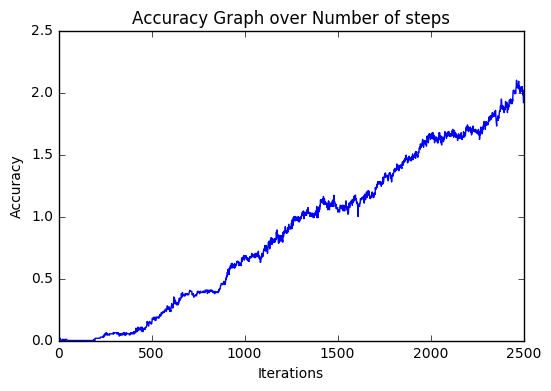

In [ ]:
plt.plot(accu)
plt.ylabel('Accuracy')
plt.xlabel('Iterations')
plt.title('Accuracy Graph over Number of steps')
plt.savefig(TMP_DIR +'accu1.png')
plt.show()

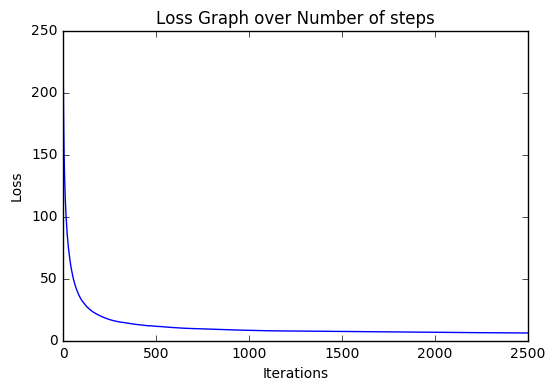

In [ ]:
plt.plot(los)
plt.ylabel('Loss')
plt.xlabel('Iterations')
plt.title('Loss Graph over Number of steps')
plt.savefig(TMP_DIR +'los1.png')
plt.show()

In [100]:
# Step 6: Visualize the embeddings.(Github)
def plot_with_labels(low_dim_embs, labels, filename='tsne.png'):
    assert low_dim_embs.shape[0] >= len(labels), 'More labels than embeddings'
    plt.figure(figsize=(18, 18))  # in inches
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i, :]
        plt.scatter(x, y)
        plt.annotate(label,
                    xy=(x, y),
                    xytext=(5, 2),
                    textcoords='offset points',
                    ha='right',
                    va='bottom')

    plt.savefig(TMP_DIR +'embeddings.png')
    
    
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
plot_only = 500
low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only, :])
labels = [reverse_dictionary[i] for i in range(plot_only)]
plot_with_labels(low_dim_embs, labels)


In [101]:
### READ THE TEXT FILES DOMAIN-WISE DATA ###

# Read the data into a list of strings.
# the domain_words parameters limits the number of words to be loaded per domain
def read_dom_data(directory, domain_words=-1):
    n = 0
    dom_data = [] # list to store data from single domain
    for domain in os.listdir(directory):
        print(domain)
        DOM_NAMES.append(domain)
        #for dirpath, dnames, fnames in os.walk(directory):
        limit = domain_words
        data_dom = [] # list to store domain wise data from all domains
        for f in os.listdir(os.path.join(directory, domain)):
            if f.endswith(".txt"):
                with open(os.path.join(directory, domain, f) ,encoding="utf8") as file:
                    limit = domain_words
                    for line in file.readlines():
                        split = line.lower().strip().split()
                        if limit > 0 and limit - len(split) < 0:
                            split = split[:limit]
                        else:
                            limit -= len(split)
                        if limit >= 0 or limit == -1:
                            data_dom += split
        dom_data.append(data_dom)
        print("Data Length: ", len(dom_data), "\n")
    return dom_data


In [102]:
# load the training set domain-wise
dom_data = read_dom_data(TRAIN_DIR, domain_words=1000)
print('Data length', len(dom_data))
# the portion of the training set used for data evaluation

ANIMALS
Data Length:  1 

ART_ARCHITECTURE_AND_ARCHAEOLOGY
Data Length:  2 

BIOLOGY
Data Length:  3 

BUSINESS_ECONOMICS_AND_FINANCE
Data Length:  4 

CHEMISTRY_AND_MINERALOGY
Data Length:  5 

COMPUTING
Data Length:  6 

CULTURE_AND_SOCIETY
Data Length:  7 

EDUCATION
Data Length:  8 

ENGINEERING_AND_TECHNOLOGY
Data Length:  9 

FARMING
Data Length:  10 

FOOD_AND_DRINK
Data Length:  11 

GAMES_AND_VIDEO_GAMES
Data Length:  12 

GEOGRAPHY_AND_PLACES
Data Length:  13 

GEOLOGY_AND_GEOPHYSICS
Data Length:  14 

HEALTH_AND_MEDICINE
Data Length:  15 

HERALDRY_HONORS_AND_VEXILLOLOGY
Data Length:  16 

HISTORY
Data Length:  17 

LANGUAGE_AND_LINGUISTICS
Data Length:  18 

LAW_AND_CRIME
Data Length:  19 

LITERATURE_AND_THEATRE
Data Length:  20 

MATHEMATICS
Data Length:  21 

MEDIA
Data Length:  22 

METEOROLOGY
Data Length:  23 

MUSIC
Data Length:  24 

NUMISMATICS_AND_CURRENCIES
Data Length:  25 

PHILOSOPHY_AND_PSYCHOLOGY
Data Length:  26 

PHYSICS_AND_ASTRONOMY
Data Length:  27 

PO

In [103]:
#Cleaning domain-wise data
sw = set(open("stopwords.txt", 'r') .read().split()) #reading a text file containing all stop words

dom_vocab = [] #list to store counters for every domain
red_dom_data = [] # list to store reduced domain wise data after removing stop words and unnecessaty characters
        
    
for dom in dom_data:
    vocabs = Counter() # counter to store words (to decide the size of our vocabulary)
    red_data_dom = []
    for i in dom:
        l = re.sub(r'[ ()â€\'ˈˌ|&$%#,“/"\.;:\\]', r"", i) # removing un-necessary characters from words
        l = ''.join([i for i in l if not i.isdigit()])
        if (l not in sw) and (not l.isdigit()):
            red_data_dom.append(l)
            vocabs[l] += 1
    red_dom_data.append(red_data_dom)
    dom_vocab.append(vocabs)
        
#print("Reduced Data Size: ", len(red_dom_data))

#to reduce memory size
del dom_data 

In [104]:
#reading list of total words
wordlist = []
wordlist[0:0] = [' '] # since the first line has ' ' in our word list
from pandas import DataFrame
df = DataFrame.from_csv(TMP_DIR + "metadata.tsv", header = None, sep = "\n")

for i, r in df.iterrows():
    wordlist.append(i)
    
#reading word embeddings from file
vectors = np.loadtxt(TMP_DIR + "embeddings.txt",skiprows=0)
vectors = vectors[0:-1,:]

In [108]:
#calculating vectors for domains
dom_vectors = []
for i in range (len(red_dom_data)):
    dom_vec = np.zeros(128)
    dom_vec_list = []
    n = 0
    for j in range (len(red_dom_data[i])):
        word = red_dom_data[i][j]
        if word in wordlist:
            dom_vec = dom_vec + vectors[wordlist.index(word)]
            n += 1
    dom_vec = dom_vec/n
    dom_vec_list = dom_vec.tolist()
    dom_vec_list.append(DOM_NAMES[i])
    dom_vectors.append(dom_vec_list)
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33


In [190]:
### Read domain-wise/document-wise text files from DEV ###
dev_file_names = []
DOM_NAMES = []
# Read the data into a list of strings.
# the domain_words parameters limits the number of words to be loaded per domain
def read_dom_data_file(directory, domain_words=-1):
    n = 0
    dom_data = [] # list to store data from single domain
    for domain in os.listdir(directory):
        dom_file_names = []
        dom_files= []
        
        #storing domain names to list
        print(domain)
        
        DOM_NAMES.append(domain)
        
        #for dirpath, dnames, fnames in os.walk(directory):
        limit = domain_words
        
        for f in os.listdir(os.path.join(directory, domain)):
            if f.endswith(".txt"):
                dom_file_names.append(f) 
                data_dom = [] # list to store domain wise data from all domains
                with open(os.path.join(directory, domain, f) ,encoding="utf8") as file:
                    limit = domain_words
                    for line in file.readlines():
                        split = line.lower().strip().split()
                        if limit > 0 and limit - len(split) < 0:
                            split = split[:limit]
                        else:
                            limit -= len(split)
                            
                        if limit >= 0 or limit == -1:
                            data_dom += split
                dom_files.append(data_dom)
        dom_data.append(dom_files)
        dev_file_names.append(dom_file_names)
        print("Data Length: ", len(dom_data), "\n")
    return dev_file_names, dom_data

In [191]:
# load the DEV set domain-wise
dev_file_names, dom_data_file = read_dom_data_file(VALID_DIR, domain_words=1000)
#print('Data length', len(dom_data))
# the portion of the training set used for data evaluation

ANIMALS
Data Length:  1 

ART_ARCHITECTURE_AND_ARCHAEOLOGY
Data Length:  2 

BIOLOGY
Data Length:  3 

BUSINESS_ECONOMICS_AND_FINANCE
Data Length:  4 

CHEMISTRY_AND_MINERALOGY
Data Length:  5 

COMPUTING
Data Length:  6 

CULTURE_AND_SOCIETY
Data Length:  7 

EDUCATION
Data Length:  8 

ENGINEERING_AND_TECHNOLOGY
Data Length:  9 

FARMING
Data Length:  10 

FOOD_AND_DRINK
Data Length:  11 

GAMES_AND_VIDEO_GAMES
Data Length:  12 

GEOGRAPHY_AND_PLACES
Data Length:  13 

GEOLOGY_AND_GEOPHYSICS
Data Length:  14 

HEALTH_AND_MEDICINE
Data Length:  15 

HERALDRY_HONORS_AND_VEXILLOLOGY
Data Length:  16 

HISTORY
Data Length:  17 

LANGUAGE_AND_LINGUISTICS
Data Length:  18 

LAW_AND_CRIME
Data Length:  19 

LITERATURE_AND_THEATRE
Data Length:  20 

MATHEMATICS
Data Length:  21 

MEDIA
Data Length:  22 

METEOROLOGY
Data Length:  23 

MUSIC
Data Length:  24 

NUMISMATICS_AND_CURRENCIES
Data Length:  25 

PHILOSOPHY_AND_PSYCHOLOGY
Data Length:  26 

PHYSICS_AND_ASTRONOMY
Data Length:  27 

PO

In [195]:
#cleaning data
sw = set(open("stopwords.txt", 'r') .read().split()) #reading a text file containing all stop words

#dom_vocab = [] #list to store counters for every domain
red_dom_data_file = [] # list to store reduced domain wise data after removing stop words and unnecessaty characters

for dom in dom_data_file:
    red_files = []
    for file in dom:
        red_data_dom = []
        for i in file:
            l = re.sub(r'[ ()â€\'ˈˌ|&$%#,“/"\.;:\\]', r"", i) # removing un-necessary characters from words
            l = ''.join([i for i in l if not i.isdigit()])
            if (l not in sw) and (not l.isdigit()):
                red_data_dom.append(l)
        red_files.append(red_data_dom)
    red_dom_data_file.append(red_files)
        
#print("Reduced Data Size: ", len(red_dom_data))

#to reduce memory size
del dom_data_file

In [198]:
# creating domain vectors for DEV set
dev_vectors = []
for i in range (len(red_dom_data_file)): #looping domains
    dom_vecs = []
    for j in range (len(red_dom_data_file[i])): #looping files in each domain
        file_vec = np.zeros(128)
        file_vec_list = []
        n = 0
        for k in range(len(red_dom_data_file[i][j])): #looping words in each file
            word = red_dom_data_file[i][j][k]
            if word in wordlist:
                file_vec = file_vec + vectors[wordlist.index(word)]
                n += 1
        file_vec = file_vec/n
        file_vec_list = file_vec.tolist()
        file_vec_list.append(DOM_NAMES[i])
        dom_vecs.append(file_vec_list)
    dev_vectors.append(dom_vecs)
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33


In [241]:
# Euclidean Distance for kNN
def euclideanDistance(instance1, instance2, length):
    #length = 128
    distance = 0
    for x in range(length):
        #print(instance1[x])
        #print(instance2[x])
        distance += pow((instance1[x] - instance2[x]), 2)
    return math.sqrt(distance)

In [244]:
# Getting nearest neighbours
import operator 
def getNeighbors(trainingSet, testInstance, k):
    distances = []
    length = len(testInstance)-1
    for x in range(len(trainingSet)):
        #print(trainingSet[x])
        dist = euclideanDistance(testInstance, trainingSet[x], length)
        distances.append((trainingSet[x], dist))
    distances.sort(key=operator.itemgetter(1))
    neighbors = []
    for x in range(k):
        neighbors.append(distances[x][0])
    return neighbors

In [265]:
# Applying predictions on DEV set
real = []
pred = []

for i in range(len(dev_vectors)):
    for j in range(len(dev_vectors[i])):
        neighbours = getNeighbors(dom_vectors, dev_vectors[i][j], 1)
        real.append(DOM_NAMES[i])
        pred.append(neighbours[0][128])

In [275]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

print("Accuracy: ", accuracy_score(real, pred))
print("Confusion Matrix: ", confusion_matrix(real, pred))
print("classification Report: ", classification_report(real, pred))

Accuracy:  0.6011162714902631
Confusion Matrix:  [[735  19 134 ...  33   3   1]
 [  1 188   3 ...  47  78   5]
 [184   3 175 ...   2   0   0]
 ...
 [  1   4   1 ...  45   1   0]
 [  0   2   0 ...   9 157  20]
 [  0   4   0 ...  46  18 333]]
classification Report:               precision    recall  f1-score   support

    ANIMALS       0.77      0.59      0.67      1241
ART_ARCHITECTURE_AND_ARCHAEOLOGY       0.57      0.22      0.32       841
    BIOLOGY       0.51      0.23      0.31       776
BUSINESS_ECONOMICS_AND_FINANCE       0.37      0.42      0.39       217
CHEMISTRY_AND_MINERALOGY       0.69      0.55      0.61       569
  COMPUTING       0.82      0.57      0.67       515
CULTURE_AND_SOCIETY       0.02      0.19      0.04        16
  EDUCATION       0.31      0.62      0.41       222
ENGINEERING_AND_TECHNOLOGY       0.20      0.74      0.32       167
    FARMING       0.21      0.36      0.26        95
FOOD_AND_DRINK       0.50      0.67      0.57       258
GAMES_AND_VIDEO_GAM

In [280]:
### Read document-wise text files from TEST ###
test_file_names = []
test_files = []
# Read the data into a list of strings.
# the domain_words parameters limits the number of words to be loaded per domain
def read_test_file(directory, domain_words=-1):
    for f in os.listdir(os.path.join(directory)):
        data_file = []
        if f.endswith(".txt"):
            test_file_names.append(f) 
            with open(os.path.join(directory, f) ,encoding="utf8") as file:
                limit = domain_words
                for line in file.readlines():
                    split = line.lower().strip().split()
                    if limit > 0 and limit - len(split) < 0:
                        split = split[:limit]
                    else:
                        limit -= len(split)

                    if limit >= 0 or limit == -1:
                        data_file += split
            test_files.append(data_file)
    print("Data Length: ", len(test_files), "\n")
    return test_files, test_file_names

In [281]:
# load the TEST set domain-wise
test_files, test_file_names = read_test_file(TEST_DIR, domain_words=1500)
#print('Data length', len(dom_data))
# the portion of the training set used for data evaluation

Data Length:  24526 



In [284]:
#cleaning data
sw = set(open("stopwords.txt", 'r') .read().split()) #reading a text file containing all stop words

#dom_vocab = [] #list to store counters for every domain
red_test_files = [] # list to store reduced domain wise data after removing stop words and unnecessaty characters

for file in test_files:
    red_data_file = []
    for i in file:
        l = re.sub(r'[ ()â€\'ˈˌ|&$%#,“/"\.;:\\]', r"", i) # removing un-necessary characters from words
        l = ''.join([i for i in l if not i.isdigit()])
        if (l not in sw) and (not l.isdigit()):
            red_data_file.append(l)
    red_test_files.append(red_data_file)

#print("Reduced Data Size: ", len(red_dom_data))

#to reduce memory size
del test_files

In [286]:
#creating vectors for test files
test_vectors = []
for i in range (len(red_test_files)): #looping files in each domain
    test_vec = np.zeros(128)
    test_vec_list = []
    n = 0
    for j in range(len(red_test_files[i])): #looping words in each file
        word = red_test_files[i][j]
        if word in wordlist:
            test_vec = test_vec + vectors[wordlist.index(word)]
            n += 1
    test_vec = test_vec/n
    test_vec_list = test_vec.tolist()
    test_vectors.append(test_vec)

In [288]:
# predicting domains for test files
predictions = []
for i in range(len(test_vectors)):
    neighbours = getNeighbors(dom_vectors, test_vectors[i], 1)
    predictions.append(neighbours[0][128])

In [294]:
#writing predicitons to tsv file
from __future__ import print_function
with open("test_answers.tsv", "w") as f:
    for i in range (len(predictions)):
        print ("%s\t%s" % (test_file_names[i], predictions[i]), file=f)